In [1]:
import numpy as np 
import pandas as pd # ( pd.read_csv)
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,cohen_kappa_score
import os, gensim, copy, pickle, warnings
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
import numpy as np
from gensim import corpora, models
import seaborn as sns
np.random.seed(400)
from imblearn.over_sampling import SMOTE
import pyLDAvis
import pyLDAvis.gensim_models
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/daisy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/daisy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
features = pd.read_csv('data/features.csv')
labels = pd.read_csv('data/labels.csv')
# test = pd.read_csv('data/test.csv')

### Check basic information

### Need to match the trackID to get the label for features, assuming “classic pop and rock” is different from pop

In [3]:
all_data = features.merge(labels, on=['trackID'], how='inner')
print(len(all_data),'combined data length \n', 
      len(features), 'feature length \n', 
      len(labels), 'label length')

8128 combined data length 
 8128 feature length 
 8128 label length


# Step 1: Exploratory Data Analyse and preprocessing

### The tag and title are all strings, need to convert to list and dict

In [4]:
## pre-processing by split the tag and title to list
def combine_title_and_tags(df):
    combine_title_tag_list = []
    for i in range(len(df)):
        df['title'] = df['title'].fillna('')
        df['tags'] = df['tags'].fillna('')
        combine_title_tag_list.append(" ".join([df['title'][i],df['tags'][i]]))   
    df = df.assign(text = pd.Series(combine_title_tag_list))
    df = df.drop(columns = ['tags','title'])
    return df
all_data = combine_title_and_tags(all_data)

### Imbalanced dataset, but not extremely imbalanced

# Step2: Preprocessing and prepare for modelling

In [5]:
## Split to train and test
y = all_data.pop('genre')
X_train, X_valid, y_train, y_valid = train_test_split( all_data, y, test_size=0.4, random_state=15, stratify=y)

In [6]:
print(np.shape(X_train))
X_valid= X_valid.reset_index(drop=True)
y_valid= y_valid.reset_index(drop=True)
X_valid.to_csv('test/X_valid.csv')
y_valid.to_csv('test/y_valid.csv')
X_train.to_csv('test/X_train.csv')
y_train.to_csv('test/y_train.csv')

(4876, 156)


## Check text data

In [7]:
X_train_text2 = pd.DataFrame(X_train.reset_index(drop=True))
y_train_text2 = y_train.reset_index(drop=True)

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['let','oh','hey', 'hay', 'ya', 'ooh',  'go', 'ai', 'tell', 'ah',
                   'ca', 'na', 'say', 'sure', 'yeah', 'tu', 'els', 'might', 'done']) 

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def lemmatize_stemming_2(texts):
    all_output =[]
    for j in texts:
         all_output.append([WordNetLemmatizer().lemmatize(i, pos = 'v') for i in j])
    return all_output


def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = lemmatize_stemming_2(words) ##new
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=13, no_above=0.5)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

## create vectors
def get_text_vector(df, corpuss, lda_model):
    vecs = []
    for i in range(len(df)):
        top_topics = lda_model.get_document_topics(corpuss[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(8)]
        topic_vec.extend([len(df.iloc[i].text)]) # length review
        vecs.append(topic_vec)
    return vecs



In [9]:
X_train_text2.columns

Index(['trackID', 'loudness', 'tempo', 'time_signature', 'key', 'mode',
       'duration', 'vect_1', 'vect_2', 'vect_3',
       ...
       'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144', 'vect_145',
       'vect_146', 'vect_147', 'vect_148', 'text'],
      dtype='object', length=156)

In [10]:
train_corpus, train_id2word, bigram_train = get_corpus(X_train_text2)

with open('model/train_corpus.pkl', 'wb') as f:
    pickle.dump(train_corpus, f)
with open('model/train_id2word.pkl', 'wb') as f:
    pickle.dump(train_id2word, f)
with open('model/bigram_train.pkl', 'wb') as f:
    pickle.dump(bigram_train, f)

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=8,
                           id2word=train_id2word,
                           chunksize=20,
                           workers=7, 
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_model.save('model/lda_model.model')

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, train_corpus, train_id2word , mds="mmds", R=30)
vis

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.134864  0.279007       1        1  25.334255
6     -0.325266  0.144248       2        1  22.211411
0     -0.004055  0.149907       3        1  21.457200
1      0.320332 -0.001269       4        1  10.137279
3     -0.131231 -0.090416       5        1   8.949206
4      0.253426 -0.408021       6        1   5.506518
2      0.236335  0.324251       7        1   4.308080
7     -0.214676 -0.397706       8        1   2.096051, topic_info=           Term        Freq       Total Category  logprob  loglift
231      que_de  308.000000  308.000000  Default  30.0000  30.0000
84    love_know  966.000000  966.000000  Default  29.0000  29.0000
77          get  890.000000  890.000000  Default  28.0000  28.0000
11           la  167.000000  167.000000  Default  27.0000  27.0000
361       la_en  201.000000  201.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2276         du   29.952772   30.821144   Topic8  -4.9604   3.8365
11           la  137.065857  167.545063   Topic8  -3.4395   3.6643
372          se   45.370595  103.159752   Topic8  -4.5451   3.0437
1026       pour   40.236750   74.490487   Topic8  -4.6652   3.2492
365          mi   35.274145  156.060183   Topic8  -4.7969   2.3780

[498 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2212      5  0.985033       action
2487      7  0.976079          ahh
2698      1  0.987697  alon_someth
2306      7  0.973883    alon_word
824       3  0.992238      alright
...     ...       ...          ...
998       1  0.319066          yes
998       3  0.634093          yes
998       4  0.044427          yes
2096      8  0.984271    yes_smile
1112      1  0.992257    yesterday

[844 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 2, 4, 5, 3, 8])

It seems there are some overlaps between topic 1 and 2

There are a few words seems to be stop words but not in the stop words list, added the extra stop words like ['hey', 'hay', 'ya','ooh'] to the existing stop words dictionary

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_model2 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=16,
                           id2word=train_id2word,
                           chunksize=20,
                           workers=10, 
                           passes=100,
                           eval_every = 1,
                           per_word_topics=False)
    lda_model2.save('model/lda_model2.model')


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, train_corpus, train_id2word , mds="mmds", R=30)
vis

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.082966  0.382077       1        1  17.797949
5     -0.238523  0.278689       2        1  16.299533
14     0.023754  0.282469       3        1  11.724456
15     0.205721  0.231091       4        1  10.318847
0     -0.117135  0.195982       5        1   8.852305
2     -0.007183 -0.156056       6        1   8.361719
11     0.176094  0.395181       7        1   5.277703
8     -0.174147 -0.006209       8        1   4.959765
10    -0.430357  0.069503       9        1   3.915994
7      0.233332  0.018629      10        1   3.355632
4      0.407420 -0.291724      11        1   2.854449
6     -0.432797 -0.214775      12        1   1.939554
1      0.492890  0.007325      13        1   1.449502
3     -0.009219 -0.459731      14        1   1.245656
9     -0.232782 -0.371710      15        1   0.862211
13     0.185897 -0.360742      16        1   0.784724, topic_info=           Term         Freq        Total Category  logprob  loglift
77          get   893.000000   893.000000  Default  30.0000  30.0000
84    love_know   979.000000   979.000000  Default  29.0000  29.0000
16         love  1046.000000  1046.000000  Default  28.0000  28.0000
231      que_de   326.000000   326.000000  Default  27.0000  27.0000
65          die   249.000000   249.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1723       vein    51.193957    56.151234  Topic16  -3.4419   4.7552
1012        voy    56.291560    66.430643  Topic16  -3.3470   4.6820
350        amor    34.079792    42.818162  Topic16  -3.8488   4.6193
1005         pa    20.465776    36.438489  Topic16  -4.3588   4.2707
2149      prove    25.130206    69.425328  Topic16  -4.1535   3.8314

[945 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1704      1  0.041767   abov
1704      2  0.642175   abov
1704      3  0.219279   abov
1704      9  0.093977   abov
2253     13  0.976469    ach
...     ...       ...    ...
578       1  0.240838  young
578       2  0.657288  young
578       4  0.035122  young
578       6  0.060210  young
2457      6  0.974910  youth

[1743 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 15, 16, 1, 3, 12, 9, 11, 8, 5, 7, 2, 4, 10, 14])

### Check topic and key words example

In [15]:
lda_model.print_topics(8,num_words=15)[:12]

[(0,
  '0.012*"love" + 0.012*"love_know" + 0.009*"come" + 0.008*"get" + 0.007*"make" + 0.006*"like" + 0.006*"think" + 0.005*"take" + 0.005*"babi" + 0.005*"would" + 0.005*"boy" + 0.004*"littl" + 0.004*"hear" + 0.004*"kiss" + 0.004*"night"'),
 (1,
  '0.009*"take" + 0.008*"shoot" + 0.007*"drink" + 0.007*"get" + 0.006*"gun" + 0.006*"kill" + 0.005*"beat" + 0.005*"mother" + 0.005*"dead" + 0.004*"ass" + 0.004*"hit" + 0.004*"know_like" + 0.004*"money" + 0.004*"one_get" + 0.004*"bodi"'),
 (2,
  '0.012*"music" + 0.011*"em" + 0.009*"dream" + 0.008*"readi" + 0.008*"fire" + 0.007*"midnight" + 0.007*"sink" + 0.007*"knee" + 0.007*"life_heart" + 0.007*"cant" + 0.006*"settl" + 0.006*"soul" + 0.006*"place" + 0.006*"whenev" + 0.006*"thing_gonna"'),
 (3,
  '0.011*"get" + 0.008*"like" + 0.008*"pay" + 0.006*"get_see" + 0.006*"write" + 0.006*"buy" + 0.006*"get_never" + 0.006*"sit" + 0.006*"car" + 0.005*"fuck" + 0.005*"money" + 0.005*"game" + 0.005*"run" + 0.005*"train" + 0.005*"back"'),
 (4,
  '0.027*"que_de

In [16]:
train_vecs1 = get_text_vector(X_train_text2, train_corpus, lda_model)
train_vecs2 = get_text_vector(X_train_text2, train_corpus, lda_model2)



In [17]:
print(np.shape(train_vecs2 ))
train_vecs = np.concatenate([train_vecs1, train_vecs2], axis=1)
np.shape(train_vecs)

(4876, 9)


(4876, 18)

In [18]:
### to continue
X = np.array(train_vecs)
y = np.array(y_train_text2)

In [19]:
## simulate minority groups
def smote2(X, y):
    X1, y1 = copy.deepcopy(X), copy.deepcopy(y)  # init
    sm = SMOTE(random_state=2)
    X1, y1 = sm.fit_resample(X, y)
    return X1, y1

X2,y2 = smote2(X,y)

### prepare for test text vec

In [20]:
def get_bigram(df):
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[i] for i in words]
    return bigram

def prepare_text_for_prediction(X_text_df, y_text_df, id2word_dict,lda_model):
    bigram_df = get_bigram(X_text_df)
    df_corpus = [id2word_dict.doc2bow(text) for text in bigram_df]
    df_vecs = get_text_vector(X_text_df, df_corpus, lda_model)
    X_text_array = np.array(df_vecs)
    y_text_array = np.array(y_text_df)
    return X_text_array, y_text_array



In [21]:
del lda_model, train_id2word, train_corpus, bigram_train

lda_model = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model.model')
train_id2word =  pickle.load(open("model/train_id2word.pkl", 'rb'))
lda_model2 = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model2.model')

In [22]:
X_text_array1, y_text_array1 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model)
X_text_array2, y_text_array2 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model2)

In [23]:
valid_vecs = np.concatenate([X_text_array1, X_text_array2], axis=1)
X_valid_vecs = np.array(valid_vecs)
valid_y= np.array(y_valid)

In [24]:
np.shape(X_valid_vecs) , np.shape(y_valid)

((3252, 18), (3252,))

In [25]:
X_valid_text_vec2, X_test_text_vec2, y_valid2, y_test2 = train_test_split(X_valid_vecs , y_valid, test_size=0.5, random_state=123)


# Step 3: modelling 

In [26]:
def grid_search_CV(grid_para, X, y, test_X, test_y):

    model_1 = GridSearchCV(XGBClassifier(eval_metric='mlogloss'),
                               grid_para, cv=3)
    model_1.fit(X, y, eval_set = [(test_X, test_y)],
                early_stopping_rounds = 10)
    print(model_1.best_score_)
    print(model_1.best_params_)
    
    xgb_m = XGBClassifier(eval_metric = ['mlogloss'],
                          objective='multi:softprob',
                          booster = 'gbtree',
                          grow_policy='lossguide',
                          max_depth=model_1.best_params_['max_depth'],
                          reg_alpha=model_1.best_params_['reg_alpha'],
                          reg_lambda=model_1.best_params_['reg_lambda'],
                          eta=model_1.best_params_['eta'],
                          num_parallel_tree = model_1.best_params_['num_parallel_tree'],
                          gamma=model_1.best_params_['gamma'],
                          sampling_method=model_1.best_params_['sampling_method'],
                          colsample_bytree=model_1.best_params_['colsample_bytree'],
                          seed=123,
                          n_jobs = -1,
                            )
    xgb_m.fit(X, y)
    xgb_m.save_model('model/xgb_model_text.model')
    return  xgb_m

In [27]:

max_depth = [5, 7]  #5, 
eta = [.08, .1 ,.15]  
gamma = [.15, .1] 
sampling_method = ['gradient_based']  
reg_lambda = [.1, .15]
colsample_bytree = [.5, .55] 
alphax = [.55, .6, .65] 
num_parallel_tree = [5] 
grid_para_2 = dict(max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=alphax,
                 colsample_bytree=colsample_bytree, eta=eta, gamma=gamma,
                 sampling_method=sampling_method, 
                 num_parallel_tree=num_parallel_tree)
xgb_model = grid_search_CV(grid_para_2, X2, y2, X_valid_text_vec2, y_valid2) #

[0]	validation_0-mlogloss:2.03593


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99922
[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93945
[4]	validation_0-mlogloss:1.91354
[5]	validation_0-mlogloss:1.89094
[6]	validation_0-mlogloss:1.86989
[7]	validation_0-mlogloss:1.84987
[8]	validation_0-mlogloss:1.83141
[9]	validation_0-mlogloss:1.81613
[10]	validation_0-mlogloss:1.80181
[11]	validation_0-mlogloss:1.78857
[12]	validation_0-mlogloss:1.77598
[13]	validation_0-mlogloss:1.76447
[14]	validation_0-mlogloss:1.75395
[15]	validation_0-mlogloss:1.74477
[16]	validation_0-mlogloss:1.73590
[17]	validation_0-mlogloss:1.72805
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71357
[20]	validation_0-mlogloss:1.70681
[21]	validation_0-mlogloss:1.70084
[22]	validation_0-mlogloss:1.69505
[23]	validation_0-mlogloss:1.69055
[24]	validation_0-mlogloss:1.68512
[25]	validation_0-mlogloss:1.68065
[26]	validation_0-mlogloss:1.67592
[27]	validation_0-mlogloss:1.67264
[28]	validation_0-mlogloss:1.66905
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97342
[3]	validation_0-mlogloss:1.94593
[4]	validation_0-mlogloss:1.92052
[5]	validation_0-mlogloss:1.89830
[6]	validation_0-mlogloss:1.87728
[7]	validation_0-mlogloss:1.85775
[8]	validation_0-mlogloss:1.84025
[9]	validation_0-mlogloss:1.82559
[10]	validation_0-mlogloss:1.81117
[11]	validation_0-mlogloss:1.79811
[12]	validation_0-mlogloss:1.78607
[13]	validation_0-mlogloss:1.77459
[14]	validation_0-mlogloss:1.76435
[15]	validation_0-mlogloss:1.75540
[16]	validation_0-mlogloss:1.74716
[17]	validation_0-mlogloss:1.73949
[18]	validation_0-mlogloss:1.73239
[19]	validation_0-mlogloss:1.72571
[20]	validation_0-mlogloss:1.71904
[21]	validation_0-mlogloss:1.71267
[22]	validation_0-mlogloss:1.70732
[23]	validation_0-mlogloss:1.70255
[24]	validation_0-mlogloss:1.69756
[25]	validation_0-mlogloss:1.69317
[26]	validation_0-mlogloss:1.68888
[27]	validation_0-mlogloss:1.68508
[28]	validation_0-mlogloss:1.68130
[29]	validation_0-mlogloss:1.67810
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97857
[3]	validation_0-mlogloss:1.95278
[4]	validation_0-mlogloss:1.92946
[5]	validation_0-mlogloss:1.90931
[6]	validation_0-mlogloss:1.89003
[7]	validation_0-mlogloss:1.87155
[8]	validation_0-mlogloss:1.85454
[9]	validation_0-mlogloss:1.84056
[10]	validation_0-mlogloss:1.82719
[11]	validation_0-mlogloss:1.81479
[12]	validation_0-mlogloss:1.80311
[13]	validation_0-mlogloss:1.79199
[14]	validation_0-mlogloss:1.78202
[15]	validation_0-mlogloss:1.77314
[16]	validation_0-mlogloss:1.76446
[17]	validation_0-mlogloss:1.75672
[18]	validation_0-mlogloss:1.74974
[19]	validation_0-mlogloss:1.74290
[20]	validation_0-mlogloss:1.73673
[21]	validation_0-mlogloss:1.73041
[22]	validation_0-mlogloss:1.72524
[23]	validation_0-mlogloss:1.72073
[24]	validation_0-mlogloss:1.71571
[25]	validation_0-mlogloss:1.71125
[26]	validation_0-mlogloss:1.70683
[27]	validation_0-mlogloss:1.70347
[28]	validation_0-mlogloss:1.69982
[29]	validation_0-mlogloss:1.69660
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96742
[3]	validation_0-mlogloss:1.93948
[4]	validation_0-mlogloss:1.91364
[5]	validation_0-mlogloss:1.89110
[6]	validation_0-mlogloss:1.87003
[7]	validation_0-mlogloss:1.84993
[8]	validation_0-mlogloss:1.83147
[9]	validation_0-mlogloss:1.81618
[10]	validation_0-mlogloss:1.80184
[11]	validation_0-mlogloss:1.78838
[12]	validation_0-mlogloss:1.77590
[13]	validation_0-mlogloss:1.76455
[14]	validation_0-mlogloss:1.75401
[15]	validation_0-mlogloss:1.74487
[16]	validation_0-mlogloss:1.73596
[17]	validation_0-mlogloss:1.72802
[18]	validation_0-mlogloss:1.72062
[19]	validation_0-mlogloss:1.71340
[20]	validation_0-mlogloss:1.70659
[21]	validation_0-mlogloss:1.70064
[22]	validation_0-mlogloss:1.69482
[23]	validation_0-mlogloss:1.69039
[24]	validation_0-mlogloss:1.68522
[25]	validation_0-mlogloss:1.68077
[26]	validation_0-mlogloss:1.67621
[27]	validation_0-mlogloss:1.67299
[28]	validation_0-mlogloss:1.66911
[29]	validation_0-mlogloss:1.66641
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00327
[2]	validation_0-mlogloss:1.97333
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92044
[5]	validation_0-mlogloss:1.89822
[6]	validation_0-mlogloss:1.87729
[7]	validation_0-mlogloss:1.85777
[8]	validation_0-mlogloss:1.84024
[9]	validation_0-mlogloss:1.82575
[10]	validation_0-mlogloss:1.81129
[11]	validation_0-mlogloss:1.79804
[12]	validation_0-mlogloss:1.78611
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75555
[16]	validation_0-mlogloss:1.74724
[17]	validation_0-mlogloss:1.73948
[18]	validation_0-mlogloss:1.73237
[19]	validation_0-mlogloss:1.72557
[20]	validation_0-mlogloss:1.71901
[21]	validation_0-mlogloss:1.71277
[22]	validation_0-mlogloss:1.70741
[23]	validation_0-mlogloss:1.70253
[24]	validation_0-mlogloss:1.69758
[25]	validation_0-mlogloss:1.69310
[26]	validation_0-mlogloss:1.68885
[27]	validation_0-mlogloss:1.68498
[28]	validation_0-mlogloss:1.68128
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95264
[4]	validation_0-mlogloss:1.92931
[5]	validation_0-mlogloss:1.90909
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87118
[8]	validation_0-mlogloss:1.85422
[9]	validation_0-mlogloss:1.84004
[10]	validation_0-mlogloss:1.82658
[11]	validation_0-mlogloss:1.81421
[12]	validation_0-mlogloss:1.80254
[13]	validation_0-mlogloss:1.79150
[14]	validation_0-mlogloss:1.78146
[15]	validation_0-mlogloss:1.77265
[16]	validation_0-mlogloss:1.76397
[17]	validation_0-mlogloss:1.75640
[18]	validation_0-mlogloss:1.74943
[19]	validation_0-mlogloss:1.74256
[20]	validation_0-mlogloss:1.73631
[21]	validation_0-mlogloss:1.73006
[22]	validation_0-mlogloss:1.72493
[23]	validation_0-mlogloss:1.72033
[24]	validation_0-mlogloss:1.71536
[25]	validation_0-mlogloss:1.71099
[26]	validation_0-mlogloss:1.70659
[27]	validation_0-mlogloss:1.70327
[28]	validation_0-mlogloss:1.69961
[29]	validation_0-mlogloss:1.69634
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96747
[3]	validation_0-mlogloss:1.93944
[4]	validation_0-mlogloss:1.91340
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86977
[7]	validation_0-mlogloss:1.84978
[8]	validation_0-mlogloss:1.83136
[9]	validation_0-mlogloss:1.81611
[10]	validation_0-mlogloss:1.80184
[11]	validation_0-mlogloss:1.78841
[12]	validation_0-mlogloss:1.77596
[13]	validation_0-mlogloss:1.76461
[14]	validation_0-mlogloss:1.75411
[15]	validation_0-mlogloss:1.74493
[16]	validation_0-mlogloss:1.73598
[17]	validation_0-mlogloss:1.72821
[18]	validation_0-mlogloss:1.72080
[19]	validation_0-mlogloss:1.71354
[20]	validation_0-mlogloss:1.70677
[21]	validation_0-mlogloss:1.70073
[22]	validation_0-mlogloss:1.69488
[23]	validation_0-mlogloss:1.69034
[24]	validation_0-mlogloss:1.68515
[25]	validation_0-mlogloss:1.68073
[26]	validation_0-mlogloss:1.67614
[27]	validation_0-mlogloss:1.67312
[28]	validation_0-mlogloss:1.66946
[29]	validation_0-mlogloss:1.66655
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97333
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92046
[5]	validation_0-mlogloss:1.89836
[6]	validation_0-mlogloss:1.87744
[7]	validation_0-mlogloss:1.85791
[8]	validation_0-mlogloss:1.84034
[9]	validation_0-mlogloss:1.82570
[10]	validation_0-mlogloss:1.81113
[11]	validation_0-mlogloss:1.79796
[12]	validation_0-mlogloss:1.78611
[13]	validation_0-mlogloss:1.77479
[14]	validation_0-mlogloss:1.76457
[15]	validation_0-mlogloss:1.75541
[16]	validation_0-mlogloss:1.74707
[17]	validation_0-mlogloss:1.73954
[18]	validation_0-mlogloss:1.73231
[19]	validation_0-mlogloss:1.72556
[20]	validation_0-mlogloss:1.71893
[21]	validation_0-mlogloss:1.71285
[22]	validation_0-mlogloss:1.70740
[23]	validation_0-mlogloss:1.70262
[24]	validation_0-mlogloss:1.69776
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68889
[27]	validation_0-mlogloss:1.68524
[28]	validation_0-mlogloss:1.68159
[29]	validation_0-mlogloss:1.67853
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97846
[3]	validation_0-mlogloss:1.95260
[4]	validation_0-mlogloss:1.92922
[5]	validation_0-mlogloss:1.90908
[6]	validation_0-mlogloss:1.88979
[7]	validation_0-mlogloss:1.87128
[8]	validation_0-mlogloss:1.85436
[9]	validation_0-mlogloss:1.84032
[10]	validation_0-mlogloss:1.82681
[11]	validation_0-mlogloss:1.81458
[12]	validation_0-mlogloss:1.80289
[13]	validation_0-mlogloss:1.79178
[14]	validation_0-mlogloss:1.78173
[15]	validation_0-mlogloss:1.77293
[16]	validation_0-mlogloss:1.76422
[17]	validation_0-mlogloss:1.75657
[18]	validation_0-mlogloss:1.74978
[19]	validation_0-mlogloss:1.74291
[20]	validation_0-mlogloss:1.73666
[21]	validation_0-mlogloss:1.73038
[22]	validation_0-mlogloss:1.72520
[23]	validation_0-mlogloss:1.72069
[24]	validation_0-mlogloss:1.71574
[25]	validation_0-mlogloss:1.71135
[26]	validation_0-mlogloss:1.70695
[27]	validation_0-mlogloss:1.70355
[28]	validation_0-mlogloss:1.69985
[29]	validation_0-mlogloss:1.69681
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96738
[3]	validation_0-mlogloss:1.93944
[4]	validation_0-mlogloss:1.91352
[5]	validation_0-mlogloss:1.89091
[6]	validation_0-mlogloss:1.86986
[7]	validation_0-mlogloss:1.84964
[8]	validation_0-mlogloss:1.83118
[9]	validation_0-mlogloss:1.81591
[10]	validation_0-mlogloss:1.80165
[11]	validation_0-mlogloss:1.78825
[12]	validation_0-mlogloss:1.77591
[13]	validation_0-mlogloss:1.76433
[14]	validation_0-mlogloss:1.75368
[15]	validation_0-mlogloss:1.74454
[16]	validation_0-mlogloss:1.73567
[17]	validation_0-mlogloss:1.72790
[18]	validation_0-mlogloss:1.72057
[19]	validation_0-mlogloss:1.71347
[20]	validation_0-mlogloss:1.70660
[21]	validation_0-mlogloss:1.70059
[22]	validation_0-mlogloss:1.69486
[23]	validation_0-mlogloss:1.69037
[24]	validation_0-mlogloss:1.68488
[25]	validation_0-mlogloss:1.68043
[26]	validation_0-mlogloss:1.67599
[27]	validation_0-mlogloss:1.67271
[28]	validation_0-mlogloss:1.66902
[29]	validation_0-mlogloss:1.66603
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97335
[3]	validation_0-mlogloss:1.94599
[4]	validation_0-mlogloss:1.92045
[5]	validation_0-mlogloss:1.89837
[6]	validation_0-mlogloss:1.87770
[7]	validation_0-mlogloss:1.85819
[8]	validation_0-mlogloss:1.84052
[9]	validation_0-mlogloss:1.82587
[10]	validation_0-mlogloss:1.81146
[11]	validation_0-mlogloss:1.79825
[12]	validation_0-mlogloss:1.78631
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76443
[15]	validation_0-mlogloss:1.75546
[16]	validation_0-mlogloss:1.74710
[17]	validation_0-mlogloss:1.73932
[18]	validation_0-mlogloss:1.73229
[19]	validation_0-mlogloss:1.72555
[20]	validation_0-mlogloss:1.71900
[21]	validation_0-mlogloss:1.71271
[22]	validation_0-mlogloss:1.70720
[23]	validation_0-mlogloss:1.70238
[24]	validation_0-mlogloss:1.69747
[25]	validation_0-mlogloss:1.69300
[26]	validation_0-mlogloss:1.68864
[27]	validation_0-mlogloss:1.68484
[28]	validation_0-mlogloss:1.68106
[29]	validation_0-mlogloss:1.67804
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00665
[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95269
[4]	validation_0-mlogloss:1.92929
[5]	validation_0-mlogloss:1.90910
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87125
[8]	validation_0-mlogloss:1.85422
[9]	validation_0-mlogloss:1.84013
[10]	validation_0-mlogloss:1.82672
[11]	validation_0-mlogloss:1.81452
[12]	validation_0-mlogloss:1.80285
[13]	validation_0-mlogloss:1.79183
[14]	validation_0-mlogloss:1.78193
[15]	validation_0-mlogloss:1.77304
[16]	validation_0-mlogloss:1.76430
[17]	validation_0-mlogloss:1.75659
[18]	validation_0-mlogloss:1.74967
[19]	validation_0-mlogloss:1.74290
[20]	validation_0-mlogloss:1.73669
[21]	validation_0-mlogloss:1.73056
[22]	validation_0-mlogloss:1.72541
[23]	validation_0-mlogloss:1.72081
[24]	validation_0-mlogloss:1.71587
[25]	validation_0-mlogloss:1.71152
[26]	validation_0-mlogloss:1.70712
[27]	validation_0-mlogloss:1.70378
[28]	validation_0-mlogloss:1.70036
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96723
[3]	validation_0-mlogloss:1.93932
[4]	validation_0-mlogloss:1.91343
[5]	validation_0-mlogloss:1.89084
[6]	validation_0-mlogloss:1.86981
[7]	validation_0-mlogloss:1.84966
[8]	validation_0-mlogloss:1.83120
[9]	validation_0-mlogloss:1.81596
[10]	validation_0-mlogloss:1.80172
[11]	validation_0-mlogloss:1.78844
[12]	validation_0-mlogloss:1.77597
[13]	validation_0-mlogloss:1.76451
[14]	validation_0-mlogloss:1.75393
[15]	validation_0-mlogloss:1.74472
[16]	validation_0-mlogloss:1.73577
[17]	validation_0-mlogloss:1.72797
[18]	validation_0-mlogloss:1.72067
[19]	validation_0-mlogloss:1.71341
[20]	validation_0-mlogloss:1.70659
[21]	validation_0-mlogloss:1.70058
[22]	validation_0-mlogloss:1.69472
[23]	validation_0-mlogloss:1.69017
[24]	validation_0-mlogloss:1.68476
[25]	validation_0-mlogloss:1.68035
[26]	validation_0-mlogloss:1.67590
[27]	validation_0-mlogloss:1.67268
[28]	validation_0-mlogloss:1.66906
[29]	validation_0-mlogloss:1.66616
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00339
[2]	validation_0-mlogloss:1.97346
[3]	validation_0-mlogloss:1.94608
[4]	validation_0-mlogloss:1.92059
[5]	validation_0-mlogloss:1.89851
[6]	validation_0-mlogloss:1.87752
[7]	validation_0-mlogloss:1.85801
[8]	validation_0-mlogloss:1.84039
[9]	validation_0-mlogloss:1.82583
[10]	validation_0-mlogloss:1.81164
[11]	validation_0-mlogloss:1.79845
[12]	validation_0-mlogloss:1.78645
[13]	validation_0-mlogloss:1.77483
[14]	validation_0-mlogloss:1.76467
[15]	validation_0-mlogloss:1.75578
[16]	validation_0-mlogloss:1.74736
[17]	validation_0-mlogloss:1.73962
[18]	validation_0-mlogloss:1.73264
[19]	validation_0-mlogloss:1.72584
[20]	validation_0-mlogloss:1.71946
[21]	validation_0-mlogloss:1.71334
[22]	validation_0-mlogloss:1.70787
[23]	validation_0-mlogloss:1.70310
[24]	validation_0-mlogloss:1.69821
[25]	validation_0-mlogloss:1.69341
[26]	validation_0-mlogloss:1.68887
[27]	validation_0-mlogloss:1.68515
[28]	validation_0-mlogloss:1.68141
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00648
[2]	validation_0-mlogloss:1.97834
[3]	validation_0-mlogloss:1.95251
[4]	validation_0-mlogloss:1.92925
[5]	validation_0-mlogloss:1.90901
[6]	validation_0-mlogloss:1.88958
[7]	validation_0-mlogloss:1.87117
[8]	validation_0-mlogloss:1.85421
[9]	validation_0-mlogloss:1.84000
[10]	validation_0-mlogloss:1.82662
[11]	validation_0-mlogloss:1.81440
[12]	validation_0-mlogloss:1.80268
[13]	validation_0-mlogloss:1.79164
[14]	validation_0-mlogloss:1.78155
[15]	validation_0-mlogloss:1.77272
[16]	validation_0-mlogloss:1.76401
[17]	validation_0-mlogloss:1.75629
[18]	validation_0-mlogloss:1.74936
[19]	validation_0-mlogloss:1.74259
[20]	validation_0-mlogloss:1.73636
[21]	validation_0-mlogloss:1.73021
[22]	validation_0-mlogloss:1.72508
[23]	validation_0-mlogloss:1.72056
[24]	validation_0-mlogloss:1.71551
[25]	validation_0-mlogloss:1.71125
[26]	validation_0-mlogloss:1.70687
[27]	validation_0-mlogloss:1.70350
[28]	validation_0-mlogloss:1.69990
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96741
[3]	validation_0-mlogloss:1.93963
[4]	validation_0-mlogloss:1.91384
[5]	validation_0-mlogloss:1.89123
[6]	validation_0-mlogloss:1.87020
[7]	validation_0-mlogloss:1.85025
[8]	validation_0-mlogloss:1.83167
[9]	validation_0-mlogloss:1.81642
[10]	validation_0-mlogloss:1.80211
[11]	validation_0-mlogloss:1.78881
[12]	validation_0-mlogloss:1.77642
[13]	validation_0-mlogloss:1.76477
[14]	validation_0-mlogloss:1.75418
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73605
[17]	validation_0-mlogloss:1.72821
[18]	validation_0-mlogloss:1.72083
[19]	validation_0-mlogloss:1.71373
[20]	validation_0-mlogloss:1.70691
[21]	validation_0-mlogloss:1.70083
[22]	validation_0-mlogloss:1.69501
[23]	validation_0-mlogloss:1.69051
[24]	validation_0-mlogloss:1.68501
[25]	validation_0-mlogloss:1.68043
[26]	validation_0-mlogloss:1.67610
[27]	validation_0-mlogloss:1.67283
[28]	validation_0-mlogloss:1.66899
[29]	validation_0-mlogloss:1.66608
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97365
[3]	validation_0-mlogloss:1.94625
[4]	validation_0-mlogloss:1.92073
[5]	validation_0-mlogloss:1.89862
[6]	validation_0-mlogloss:1.87770
[7]	validation_0-mlogloss:1.85822
[8]	validation_0-mlogloss:1.84055
[9]	validation_0-mlogloss:1.82588
[10]	validation_0-mlogloss:1.81154
[11]	validation_0-mlogloss:1.79832
[12]	validation_0-mlogloss:1.78633
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76453
[15]	validation_0-mlogloss:1.75549
[16]	validation_0-mlogloss:1.74710
[17]	validation_0-mlogloss:1.73934
[18]	validation_0-mlogloss:1.73222
[19]	validation_0-mlogloss:1.72535
[20]	validation_0-mlogloss:1.71900
[21]	validation_0-mlogloss:1.71285
[22]	validation_0-mlogloss:1.70742
[23]	validation_0-mlogloss:1.70262
[24]	validation_0-mlogloss:1.69775
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68871
[27]	validation_0-mlogloss:1.68494
[28]	validation_0-mlogloss:1.68116
[29]	validation_0-mlogloss:1.67821
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97850
[3]	validation_0-mlogloss:1.95265
[4]	validation_0-mlogloss:1.92933
[5]	validation_0-mlogloss:1.90911
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85413
[9]	validation_0-mlogloss:1.84003
[10]	validation_0-mlogloss:1.82657
[11]	validation_0-mlogloss:1.81426
[12]	validation_0-mlogloss:1.80258
[13]	validation_0-mlogloss:1.79141
[14]	validation_0-mlogloss:1.78137
[15]	validation_0-mlogloss:1.77252
[16]	validation_0-mlogloss:1.76373
[17]	validation_0-mlogloss:1.75604
[18]	validation_0-mlogloss:1.74916
[19]	validation_0-mlogloss:1.74235
[20]	validation_0-mlogloss:1.73619
[21]	validation_0-mlogloss:1.73004
[22]	validation_0-mlogloss:1.72489
[23]	validation_0-mlogloss:1.72019
[24]	validation_0-mlogloss:1.71512
[25]	validation_0-mlogloss:1.71085
[26]	validation_0-mlogloss:1.70655
[27]	validation_0-mlogloss:1.70323
[28]	validation_0-mlogloss:1.69970
[29]	validation_0-mlogloss:1.69635
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99446
[2]	validation_0-mlogloss:1.96080
[3]	validation_0-mlogloss:1.93121
[4]	validation_0-mlogloss:1.90477
[5]	validation_0-mlogloss:1.88153
[6]	validation_0-mlogloss:1.85939
[7]	validation_0-mlogloss:1.83882
[8]	validation_0-mlogloss:1.82000
[9]	validation_0-mlogloss:1.80444
[10]	validation_0-mlogloss:1.78945
[11]	validation_0-mlogloss:1.77619
[12]	validation_0-mlogloss:1.76377
[13]	validation_0-mlogloss:1.75185
[14]	validation_0-mlogloss:1.74090
[15]	validation_0-mlogloss:1.73141
[16]	validation_0-mlogloss:1.72256
[17]	validation_0-mlogloss:1.71470
[18]	validation_0-mlogloss:1.70776
[19]	validation_0-mlogloss:1.70111
[20]	validation_0-mlogloss:1.69457
[21]	validation_0-mlogloss:1.68871
[22]	validation_0-mlogloss:1.68332
[23]	validation_0-mlogloss:1.67905
[24]	validation_0-mlogloss:1.67464
[25]	validation_0-mlogloss:1.67077
[26]	validation_0-mlogloss:1.66654
[27]	validation_0-mlogloss:1.66353
[28]	validation_0-mlogloss:1.66056
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99890
[2]	validation_0-mlogloss:1.96750
[3]	validation_0-mlogloss:1.93865
[4]	validation_0-mlogloss:1.91271
[5]	validation_0-mlogloss:1.89044
[6]	validation_0-mlogloss:1.86918
[7]	validation_0-mlogloss:1.84925
[8]	validation_0-mlogloss:1.83136
[9]	validation_0-mlogloss:1.81662
[10]	validation_0-mlogloss:1.80180
[11]	validation_0-mlogloss:1.78867
[12]	validation_0-mlogloss:1.77628
[13]	validation_0-mlogloss:1.76479
[14]	validation_0-mlogloss:1.75433
[15]	validation_0-mlogloss:1.74512
[16]	validation_0-mlogloss:1.73654
[17]	validation_0-mlogloss:1.72917
[18]	validation_0-mlogloss:1.72234
[19]	validation_0-mlogloss:1.71536
[20]	validation_0-mlogloss:1.70873
[21]	validation_0-mlogloss:1.70214
[22]	validation_0-mlogloss:1.69661
[23]	validation_0-mlogloss:1.69216
[24]	validation_0-mlogloss:1.68769
[25]	validation_0-mlogloss:1.68346
[26]	validation_0-mlogloss:1.67872
[27]	validation_0-mlogloss:1.67521
[28]	validation_0-mlogloss:1.67168
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00306
[2]	validation_0-mlogloss:1.97324
[3]	validation_0-mlogloss:1.94629
[4]	validation_0-mlogloss:1.92156
[5]	validation_0-mlogloss:1.90087
[6]	validation_0-mlogloss:1.87990
[7]	validation_0-mlogloss:1.86099
[8]	validation_0-mlogloss:1.84331
[9]	validation_0-mlogloss:1.82860
[10]	validation_0-mlogloss:1.81461
[11]	validation_0-mlogloss:1.80130
[12]	validation_0-mlogloss:1.78938
[13]	validation_0-mlogloss:1.77804
[14]	validation_0-mlogloss:1.76788
[15]	validation_0-mlogloss:1.75911
[16]	validation_0-mlogloss:1.75014
[17]	validation_0-mlogloss:1.74269
[18]	validation_0-mlogloss:1.73621
[19]	validation_0-mlogloss:1.72950
[20]	validation_0-mlogloss:1.72380
[21]	validation_0-mlogloss:1.71752
[22]	validation_0-mlogloss:1.71217
[23]	validation_0-mlogloss:1.70775
[24]	validation_0-mlogloss:1.70249
[25]	validation_0-mlogloss:1.69820
[26]	validation_0-mlogloss:1.69409
[27]	validation_0-mlogloss:1.69098
[28]	validation_0-mlogloss:1.68772
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99435
[2]	validation_0-mlogloss:1.96067
[3]	validation_0-mlogloss:1.93110
[4]	validation_0-mlogloss:1.90455
[5]	validation_0-mlogloss:1.88126
[6]	validation_0-mlogloss:1.85915
[7]	validation_0-mlogloss:1.83847
[8]	validation_0-mlogloss:1.81963
[9]	validation_0-mlogloss:1.80428
[10]	validation_0-mlogloss:1.78925
[11]	validation_0-mlogloss:1.77604
[12]	validation_0-mlogloss:1.76376
[13]	validation_0-mlogloss:1.75177
[14]	validation_0-mlogloss:1.74066
[15]	validation_0-mlogloss:1.73102
[16]	validation_0-mlogloss:1.72201
[17]	validation_0-mlogloss:1.71412
[18]	validation_0-mlogloss:1.70725
[19]	validation_0-mlogloss:1.70059
[20]	validation_0-mlogloss:1.69397
[21]	validation_0-mlogloss:1.68829
[22]	validation_0-mlogloss:1.68291
[23]	validation_0-mlogloss:1.67884
[24]	validation_0-mlogloss:1.67445
[25]	validation_0-mlogloss:1.67044
[26]	validation_0-mlogloss:1.66639
[27]	validation_0-mlogloss:1.66323
[28]	validation_0-mlogloss:1.66017
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99911
[2]	validation_0-mlogloss:1.96786
[3]	validation_0-mlogloss:1.93910
[4]	validation_0-mlogloss:1.91307
[5]	validation_0-mlogloss:1.89076
[6]	validation_0-mlogloss:1.86945
[7]	validation_0-mlogloss:1.84949
[8]	validation_0-mlogloss:1.83156
[9]	validation_0-mlogloss:1.81668
[10]	validation_0-mlogloss:1.80191
[11]	validation_0-mlogloss:1.78852
[12]	validation_0-mlogloss:1.77612
[13]	validation_0-mlogloss:1.76474
[14]	validation_0-mlogloss:1.75429
[15]	validation_0-mlogloss:1.74497
[16]	validation_0-mlogloss:1.73651
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72226
[19]	validation_0-mlogloss:1.71522
[20]	validation_0-mlogloss:1.70845
[21]	validation_0-mlogloss:1.70204
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69190
[24]	validation_0-mlogloss:1.68740
[25]	validation_0-mlogloss:1.68322
[26]	validation_0-mlogloss:1.67879
[27]	validation_0-mlogloss:1.67516
[28]	validation_0-mlogloss:1.67170
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00298
[2]	validation_0-mlogloss:1.97325
[3]	validation_0-mlogloss:1.94624
[4]	validation_0-mlogloss:1.92188
[5]	validation_0-mlogloss:1.90128
[6]	validation_0-mlogloss:1.88026
[7]	validation_0-mlogloss:1.86118
[8]	validation_0-mlogloss:1.84343
[9]	validation_0-mlogloss:1.82883
[10]	validation_0-mlogloss:1.81475
[11]	validation_0-mlogloss:1.80157
[12]	validation_0-mlogloss:1.78967
[13]	validation_0-mlogloss:1.77835
[14]	validation_0-mlogloss:1.76831
[15]	validation_0-mlogloss:1.75969
[16]	validation_0-mlogloss:1.75089
[17]	validation_0-mlogloss:1.74338
[18]	validation_0-mlogloss:1.73688
[19]	validation_0-mlogloss:1.73027
[20]	validation_0-mlogloss:1.72447
[21]	validation_0-mlogloss:1.71815
[22]	validation_0-mlogloss:1.71298
[23]	validation_0-mlogloss:1.70850
[24]	validation_0-mlogloss:1.70354
[25]	validation_0-mlogloss:1.69946
[26]	validation_0-mlogloss:1.69542
[27]	validation_0-mlogloss:1.69241
[28]	validation_0-mlogloss:1.68884
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99451
[2]	validation_0-mlogloss:1.96064
[3]	validation_0-mlogloss:1.93103
[4]	validation_0-mlogloss:1.90444
[5]	validation_0-mlogloss:1.88125
[6]	validation_0-mlogloss:1.85914
[7]	validation_0-mlogloss:1.83860
[8]	validation_0-mlogloss:1.81982
[9]	validation_0-mlogloss:1.80445
[10]	validation_0-mlogloss:1.78942
[11]	validation_0-mlogloss:1.77604
[12]	validation_0-mlogloss:1.76364
[13]	validation_0-mlogloss:1.75179
[14]	validation_0-mlogloss:1.74084
[15]	validation_0-mlogloss:1.73132
[16]	validation_0-mlogloss:1.72251
[17]	validation_0-mlogloss:1.71460


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[18]	validation_0-mlogloss:1.70773
[19]	validation_0-mlogloss:1.70106
[20]	validation_0-mlogloss:1.69462
[21]	validation_0-mlogloss:1.68890
[22]	validation_0-mlogloss:1.68357
[23]	validation_0-mlogloss:1.67922
[24]	validation_0-mlogloss:1.67506
[25]	validation_0-mlogloss:1.67117
[26]	validation_0-mlogloss:1.66713
[27]	validation_0-mlogloss:1.66403
[28]	validation_0-mlogloss:1.66091
[29]	validation_0-mlogloss:1.65856
[30]	validation_0-mlogloss:1.65613
[31]	validation_0-mlogloss:1.65372
[32]	validation_0-mlogloss:1.65177
[33]	validation_0-mlogloss:1.64991
[34]	validation_0-mlogloss:1.64824
[35]	validation_0-mlogloss:1.64675
[36]	validation_0-mlogloss:1.64483
[37]	validation_0-mlogloss:1.64345
[38]	validation_0-mlogloss:1.64207
[39]	validation_0-mlogloss:1.64152
[40]	validation_0-mlogloss:1.64073
[41]	validation_0-mlogloss:1.64032
[42]	validation_0-mlogloss:1.63973
[43]	validation_0-mlogloss:1.63934
[44]	validation_0-mlogloss:1.63902
[45]	validation_0-mlogloss:1.63848
[46]	validation_0-ml

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99908
[2]	validation_0-mlogloss:1.96770
[3]	validation_0-mlogloss:1.93883
[4]	validation_0-mlogloss:1.91271
[5]	validation_0-mlogloss:1.89047
[6]	validation_0-mlogloss:1.86936
[7]	validation_0-mlogloss:1.84952
[8]	validation_0-mlogloss:1.83159
[9]	validation_0-mlogloss:1.81686
[10]	validation_0-mlogloss:1.80206
[11]	validation_0-mlogloss:1.78882
[12]	validation_0-mlogloss:1.77653
[13]	validation_0-mlogloss:1.76524
[14]	validation_0-mlogloss:1.75495
[15]	validation_0-mlogloss:1.74564
[16]	validation_0-mlogloss:1.73700
[17]	validation_0-mlogloss:1.72931
[18]	validation_0-mlogloss:1.72262
[19]	validation_0-mlogloss:1.71562
[20]	validation_0-mlogloss:1.70889
[21]	validation_0-mlogloss:1.70243
[22]	validation_0-mlogloss:1.69705
[23]	validation_0-mlogloss:1.69235
[24]	validation_0-mlogloss:1.68786
[25]	validation_0-mlogloss:1.68378
[26]	validation_0-mlogloss:1.67913
[27]	validation_0-mlogloss:1.67572
[28]	validation_0-mlogloss:1.67225
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00301
[2]	validation_0-mlogloss:1.97320
[3]	validation_0-mlogloss:1.94619
[4]	validation_0-mlogloss:1.92168
[5]	validation_0-mlogloss:1.90126
[6]	validation_0-mlogloss:1.88029
[7]	validation_0-mlogloss:1.86126
[8]	validation_0-mlogloss:1.84334
[9]	validation_0-mlogloss:1.82873
[10]	validation_0-mlogloss:1.81461
[11]	validation_0-mlogloss:1.80160
[12]	validation_0-mlogloss:1.78959
[13]	validation_0-mlogloss:1.77824
[14]	validation_0-mlogloss:1.76817
[15]	validation_0-mlogloss:1.75944
[16]	validation_0-mlogloss:1.75064
[17]	validation_0-mlogloss:1.74310
[18]	validation_0-mlogloss:1.73673
[19]	validation_0-mlogloss:1.72995
[20]	validation_0-mlogloss:1.72396
[21]	validation_0-mlogloss:1.71761
[22]	validation_0-mlogloss:1.71250
[23]	validation_0-mlogloss:1.70806
[24]	validation_0-mlogloss:1.70318
[25]	validation_0-mlogloss:1.69918
[26]	validation_0-mlogloss:1.69508
[27]	validation_0-mlogloss:1.69212
[28]	validation_0-mlogloss:1.68890
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99464
[2]	validation_0-mlogloss:1.96080
[3]	validation_0-mlogloss:1.93124
[4]	validation_0-mlogloss:1.90475
[5]	validation_0-mlogloss:1.88132
[6]	validation_0-mlogloss:1.85911
[7]	validation_0-mlogloss:1.83853
[8]	validation_0-mlogloss:1.81971
[9]	validation_0-mlogloss:1.80431
[10]	validation_0-mlogloss:1.78930
[11]	validation_0-mlogloss:1.77590
[12]	validation_0-mlogloss:1.76346
[13]	validation_0-mlogloss:1.75162
[14]	validation_0-mlogloss:1.74072
[15]	validation_0-mlogloss:1.73109
[16]	validation_0-mlogloss:1.72232
[17]	validation_0-mlogloss:1.71440
[18]	validation_0-mlogloss:1.70752
[19]	validation_0-mlogloss:1.70079
[20]	validation_0-mlogloss:1.69418
[21]	validation_0-mlogloss:1.68842
[22]	validation_0-mlogloss:1.68309
[23]	validation_0-mlogloss:1.67884
[24]	validation_0-mlogloss:1.67456
[25]	validation_0-mlogloss:1.67043
[26]	validation_0-mlogloss:1.66651
[27]	validation_0-mlogloss:1.66338
[28]	validation_0-mlogloss:1.66043
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99885
[2]	validation_0-mlogloss:1.96772
[3]	validation_0-mlogloss:1.93894
[4]	validation_0-mlogloss:1.91272
[5]	validation_0-mlogloss:1.89052
[6]	validation_0-mlogloss:1.86938


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[7]	validation_0-mlogloss:1.84962


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[8]	validation_0-mlogloss:1.83171


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[9]	validation_0-mlogloss:1.81690
[10]	validation_0-mlogloss:1.80201
[11]	validation_0-mlogloss:1.78879
[12]	validation_0-mlogloss:1.77649
[13]	validation_0-mlogloss:1.76493
[14]	validation_0-mlogloss:1.75436
[15]	validation_0-mlogloss:1.74487
[16]	validation_0-mlogloss:1.73639
[17]	validation_0-mlogloss:1.72884
[18]	validation_0-mlogloss:1.72183
[19]	validation_0-mlogloss:1.71481
[20]	validation_0-mlogloss:1.70816
[21]	validation_0-mlogloss:1.70169


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[22]	validation_0-mlogloss:1.69618
[23]	validation_0-mlogloss:1.69157
[24]	validation_0-mlogloss:1.68701
[25]	validation_0-mlogloss:1.68292
[26]	validation_0-mlogloss:1.67829
[27]	validation_0-mlogloss:1.67486
[28]	validation_0-mlogloss:1.67116
[29]	validation_0-mlogloss:1.66787
[30]	validation_0-mlogloss:1.66471
[31]	validation_0-mlogloss:1.66190
[32]	validation_0-mlogloss:1.65975
[33]	validation_0-mlogloss:1.65721
[34]	validation_0-mlogloss:1.65474
[35]	validation_0-mlogloss:1.65301
[36]	validation_0-mlogloss:1.65106
[37]	validation_0-mlogloss:1.64915
[38]	validation_0-mlogloss:1.64767
[39]	validation_0-mlogloss:1.64609
[40]	validation_0-mlogloss:1.64440
[41]	validation_0-mlogloss:1.64337
[42]	validation_0-mlogloss:1.64285
[43]	validation_0-mlogloss:1.64213
[44]	validation_0-mlogloss:1.64111
[45]	validation_0-mlogloss:1.64019
[46]	validation_0-mlogloss:1.63950
[47]	validation_0-mlogloss:1.63908
[48]	validation_0-mlogloss:1.63836
[49]	validation_0-mlogloss:1.63792
[50]	validation_0-ml

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00287
[2]	validation_0-mlogloss:1.97318
[3]	validation_0-mlogloss:1.94611
[4]	validation_0-mlogloss:1.92165
[5]	validation_0-mlogloss:1.90099
[6]	validation_0-mlogloss:1.88012
[7]	validation_0-mlogloss:1.86142
[8]	validation_0-mlogloss:1.84361
[9]	validation_0-mlogloss:1.82908
[10]	validation_0-mlogloss:1.81504
[11]	validation_0-mlogloss:1.80181
[12]	validation_0-mlogloss:1.78977
[13]	validation_0-mlogloss:1.77839
[14]	validation_0-mlogloss:1.76838
[15]	validation_0-mlogloss:1.75951
[16]	validation_0-mlogloss:1.75068
[17]	validation_0-mlogloss:1.74321
[18]	validation_0-mlogloss:1.73679
[19]	validation_0-mlogloss:1.73004
[20]	validation_0-mlogloss:1.72430
[21]	validation_0-mlogloss:1.71811
[22]	validation_0-mlogloss:1.71293
[23]	validation_0-mlogloss:1.70833
[24]	validation_0-mlogloss:1.70346
[25]	validation_0-mlogloss:1.69964
[26]	validation_0-mlogloss:1.69549
[27]	validation_0-mlogloss:1.69251
[28]	validation_0-mlogloss:1.68896
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99455
[2]	validation_0-mlogloss:1.96082
[3]	validation_0-mlogloss:1.93133
[4]	validation_0-mlogloss:1.90448
[5]	validation_0-mlogloss:1.88113
[6]	validation_0-mlogloss:1.85885
[7]	validation_0-mlogloss:1.83825
[8]	validation_0-mlogloss:1.81933
[9]	validation_0-mlogloss:1.80382
[10]	validation_0-mlogloss:1.78879
[11]	validation_0-mlogloss:1.77549
[12]	validation_0-mlogloss:1.76315
[13]	validation_0-mlogloss:1.75122
[14]	validation_0-mlogloss:1.74030
[15]	validation_0-mlogloss:1.73072
[16]	validation_0-mlogloss:1.72190
[17]	validation_0-mlogloss:1.71410
[18]	validation_0-mlogloss:1.70739
[19]	validation_0-mlogloss:1.70086
[20]	validation_0-mlogloss:1.69427
[21]	validation_0-mlogloss:1.68847
[22]	validation_0-mlogloss:1.68314
[23]	validation_0-mlogloss:1.67901
[24]	validation_0-mlogloss:1.67462
[25]	validation_0-mlogloss:1.67062
[26]	validation_0-mlogloss:1.66647
[27]	validation_0-mlogloss:1.66348
[28]	validation_0-mlogloss:1.66042
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99901
[2]	validation_0-mlogloss:1.96784
[3]	validation_0-mlogloss:1.93914
[4]	validation_0-mlogloss:1.91302
[5]	validation_0-mlogloss:1.89080
[6]	validation_0-mlogloss:1.86968
[7]	validation_0-mlogloss:1.84977
[8]	validation_0-mlogloss:1.83166
[9]	validation_0-mlogloss:1.81684
[10]	validation_0-mlogloss:1.80192
[11]	validation_0-mlogloss:1.78871
[12]	validation_0-mlogloss:1.77648
[13]	validation_0-mlogloss:1.76493
[14]	validation_0-mlogloss:1.75442
[15]	validation_0-mlogloss:1.74495
[16]	validation_0-mlogloss:1.73651
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72212
[19]	validation_0-mlogloss:1.71517
[20]	validation_0-mlogloss:1.70852
[21]	validation_0-mlogloss:1.70191
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69197
[24]	validation_0-mlogloss:1.68758
[25]	validation_0-mlogloss:1.68328
[26]	validation_0-mlogloss:1.67868
[27]	validation_0-mlogloss:1.67540
[28]	validation_0-mlogloss:1.67166
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00279
[2]	validation_0-mlogloss:1.97308
[3]	validation_0-mlogloss:1.94597
[4]	validation_0-mlogloss:1.92153
[5]	validation_0-mlogloss:1.90094
[6]	validation_0-mlogloss:1.88011
[7]	validation_0-mlogloss:1.86107
[8]	validation_0-mlogloss:1.84322
[9]	validation_0-mlogloss:1.82860
[10]	validation_0-mlogloss:1.81453
[11]	validation_0-mlogloss:1.80146
[12]	validation_0-mlogloss:1.78947
[13]	validation_0-mlogloss:1.77826
[14]	validation_0-mlogloss:1.76834
[15]	validation_0-mlogloss:1.75964
[16]	validation_0-mlogloss:1.75094
[17]	validation_0-mlogloss:1.74362
[18]	validation_0-mlogloss:1.73720
[19]	validation_0-mlogloss:1.73066
[20]	validation_0-mlogloss:1.72478
[21]	validation_0-mlogloss:1.71866
[22]	validation_0-mlogloss:1.71348
[23]	validation_0-mlogloss:1.70882
[24]	validation_0-mlogloss:1.70403
[25]	validation_0-mlogloss:1.69997
[26]	validation_0-mlogloss:1.69595
[27]	validation_0-mlogloss:1.69284
[28]	validation_0-mlogloss:1.68922
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99456
[2]	validation_0-mlogloss:1.96094
[3]	validation_0-mlogloss:1.93141
[4]	validation_0-mlogloss:1.90481
[5]	validation_0-mlogloss:1.88138
[6]	validation_0-mlogloss:1.85913
[7]	validation_0-mlogloss:1.83855
[8]	validation_0-mlogloss:1.81962
[9]	validation_0-mlogloss:1.80421
[10]	validation_0-mlogloss:1.78919
[11]	validation_0-mlogloss:1.77574
[12]	validation_0-mlogloss:1.76337
[13]	validation_0-mlogloss:1.75141
[14]	validation_0-mlogloss:1.74056
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72219
[17]	validation_0-mlogloss:1.71433
[18]	validation_0-mlogloss:1.70741
[19]	validation_0-mlogloss:1.70071
[20]	validation_0-mlogloss:1.69418
[21]	validation_0-mlogloss:1.68824
[22]	validation_0-mlogloss:1.68287
[23]	validation_0-mlogloss:1.67853
[24]	validation_0-mlogloss:1.67432
[25]	validation_0-mlogloss:1.67018
[26]	validation_0-mlogloss:1.66592
[27]	validation_0-mlogloss:1.66296
[28]	validation_0-mlogloss:1.66002
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99883
[2]	validation_0-mlogloss:1.96787
[3]	validation_0-mlogloss:1.93923
[4]	validation_0-mlogloss:1.91297
[5]	validation_0-mlogloss:1.89077
[6]	validation_0-mlogloss:1.86964
[7]	validation_0-mlogloss:1.84965
[8]	validation_0-mlogloss:1.83178
[9]	validation_0-mlogloss:1.81694
[10]	validation_0-mlogloss:1.80203
[11]	validation_0-mlogloss:1.78895
[12]	validation_0-mlogloss:1.77659
[13]	validation_0-mlogloss:1.76508
[14]	validation_0-mlogloss:1.75444
[15]	validation_0-mlogloss:1.74506
[16]	validation_0-mlogloss:1.73650
[17]	validation_0-mlogloss:1.72892
[18]	validation_0-mlogloss:1.72220
[19]	validation_0-mlogloss:1.71526
[20]	validation_0-mlogloss:1.70865
[21]	validation_0-mlogloss:1.70224
[22]	validation_0-mlogloss:1.69691
[23]	validation_0-mlogloss:1.69220
[24]	validation_0-mlogloss:1.68765
[25]	validation_0-mlogloss:1.68349
[26]	validation_0-mlogloss:1.67907
[27]	validation_0-mlogloss:1.67576
[28]	validation_0-mlogloss:1.67229
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00291
[2]	validation_0-mlogloss:1.97304
[3]	validation_0-mlogloss:1.94593
[4]	validation_0-mlogloss:1.92140
[5]	validation_0-mlogloss:1.90082
[6]	validation_0-mlogloss:1.88006
[7]	validation_0-mlogloss:1.86108
[8]	validation_0-mlogloss:1.84323
[9]	validation_0-mlogloss:1.82861
[10]	validation_0-mlogloss:1.81445
[11]	validation_0-mlogloss:1.80136
[12]	validation_0-mlogloss:1.78936
[13]	validation_0-mlogloss:1.77797
[14]	validation_0-mlogloss:1.76803
[15]	validation_0-mlogloss:1.75936
[16]	validation_0-mlogloss:1.75055
[17]	validation_0-mlogloss:1.74300
[18]	validation_0-mlogloss:1.73660
[19]	validation_0-mlogloss:1.72995
[20]	validation_0-mlogloss:1.72405
[21]	validation_0-mlogloss:1.71773
[22]	validation_0-mlogloss:1.71263
[23]	validation_0-mlogloss:1.70810
[24]	validation_0-mlogloss:1.70311
[25]	validation_0-mlogloss:1.69918
[26]	validation_0-mlogloss:1.69516
[27]	validation_0-mlogloss:1.69197
[28]	validation_0-mlogloss:1.68856
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93946
[4]	validation_0-mlogloss:1.91355
[5]	validation_0-mlogloss:1.89096
[6]	validation_0-mlogloss:1.86992
[7]	validation_0-mlogloss:1.84991
[8]	validation_0-mlogloss:1.83145
[9]	validation_0-mlogloss:1.81617
[10]	validation_0-mlogloss:1.80187
[11]	validation_0-mlogloss:1.78862
[12]	validation_0-mlogloss:1.77604
[13]	validation_0-mlogloss:1.76455
[14]	validation_0-mlogloss:1.75399
[15]	validation_0-mlogloss:1.74480
[16]	validation_0-mlogloss:1.73590
[17]	validation_0-mlogloss:1.72806
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71355
[20]	validation_0-mlogloss:1.70678
[21]	validation_0-mlogloss:1.70082
[22]	validation_0-mlogloss:1.69500
[23]	validation_0-mlogloss:1.69053
[24]	validation_0-mlogloss:1.68530
[25]	validation_0-mlogloss:1.68092
[26]	validation_0-mlogloss:1.67654
[27]	validation_0-mlogloss:1.67332
[28]	validation_0-mlogloss:1.66966
[29]	validation_0-mlogloss:1.66666
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97346
[3]	validation_0-mlogloss:1.94599
[4]	validation_0-mlogloss:1.92058
[5]	validation_0-mlogloss:1.89835
[6]	validation_0-mlogloss:1.87739
[7]	validation_0-mlogloss:1.85785
[8]	validation_0-mlogloss:1.84034
[9]	validation_0-mlogloss:1.82567
[10]	validation_0-mlogloss:1.81120
[11]	validation_0-mlogloss:1.79812
[12]	validation_0-mlogloss:1.78608
[13]	validation_0-mlogloss:1.77460
[14]	validation_0-mlogloss:1.76441
[15]	validation_0-mlogloss:1.75548
[16]	validation_0-mlogloss:1.74729
[17]	validation_0-mlogloss:1.73963
[18]	validation_0-mlogloss:1.73247
[19]	validation_0-mlogloss:1.72582
[20]	validation_0-mlogloss:1.71917
[21]	validation_0-mlogloss:1.71281
[22]	validation_0-mlogloss:1.70750
[23]	validation_0-mlogloss:1.70267
[24]	validation_0-mlogloss:1.69765
[25]	validation_0-mlogloss:1.69321
[26]	validation_0-mlogloss:1.68878
[27]	validation_0-mlogloss:1.68487
[28]	validation_0-mlogloss:1.68108
[29]	validation_0-mlogloss:1.67795
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95273
[4]	validation_0-mlogloss:1.92942
[5]	validation_0-mlogloss:1.90926
[6]	validation_0-mlogloss:1.88998
[7]	validation_0-mlogloss:1.87145
[8]	validation_0-mlogloss:1.85447
[9]	validation_0-mlogloss:1.84045
[10]	validation_0-mlogloss:1.82704
[11]	validation_0-mlogloss:1.81462
[12]	validation_0-mlogloss:1.80292
[13]	validation_0-mlogloss:1.79184
[14]	validation_0-mlogloss:1.78186
[15]	validation_0-mlogloss:1.77302
[16]	validation_0-mlogloss:1.76438
[17]	validation_0-mlogloss:1.75668
[18]	validation_0-mlogloss:1.74971
[19]	validation_0-mlogloss:1.74288
[20]	validation_0-mlogloss:1.73680
[21]	validation_0-mlogloss:1.73046
[22]	validation_0-mlogloss:1.72522
[23]	validation_0-mlogloss:1.72063
[24]	validation_0-mlogloss:1.71570
[25]	validation_0-mlogloss:1.71142
[26]	validation_0-mlogloss:1.70704
[27]	validation_0-mlogloss:1.70365
[28]	validation_0-mlogloss:1.69994
[29]	validation_0-mlogloss:1.69680
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99909
[2]	validation_0-mlogloss:1.96743
[3]	validation_0-mlogloss:1.93948
[4]	validation_0-mlogloss:1.91364
[5]	validation_0-mlogloss:1.89110
[6]	validation_0-mlogloss:1.87003
[7]	validation_0-mlogloss:1.84993
[8]	validation_0-mlogloss:1.83148
[9]	validation_0-mlogloss:1.81623
[10]	validation_0-mlogloss:1.80192
[11]	validation_0-mlogloss:1.78839
[12]	validation_0-mlogloss:1.77592
[13]	validation_0-mlogloss:1.76463
[14]	validation_0-mlogloss:1.75410
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73605
[17]	validation_0-mlogloss:1.72810
[18]	validation_0-mlogloss:1.72066
[19]	validation_0-mlogloss:1.71346
[20]	validation_0-mlogloss:1.70671
[21]	validation_0-mlogloss:1.70078
[22]	validation_0-mlogloss:1.69498
[23]	validation_0-mlogloss:1.69045
[24]	validation_0-mlogloss:1.68508
[25]	validation_0-mlogloss:1.68063
[26]	validation_0-mlogloss:1.67619
[27]	validation_0-mlogloss:1.67293
[28]	validation_0-mlogloss:1.66904
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00327
[2]	validation_0-mlogloss:1.97331
[3]	validation_0-mlogloss:1.94589
[4]	validation_0-mlogloss:1.92043
[5]	validation_0-mlogloss:1.89826
[6]	validation_0-mlogloss:1.87732
[7]	validation_0-mlogloss:1.85781
[8]	validation_0-mlogloss:1.84025
[9]	validation_0-mlogloss:1.82575
[10]	validation_0-mlogloss:1.81129
[11]	validation_0-mlogloss:1.79805
[12]	validation_0-mlogloss:1.78610
[13]	validation_0-mlogloss:1.77473
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75553
[16]	validation_0-mlogloss:1.74725
[17]	validation_0-mlogloss:1.73946
[18]	validation_0-mlogloss:1.73238
[19]	validation_0-mlogloss:1.72559
[20]	validation_0-mlogloss:1.71898
[21]	validation_0-mlogloss:1.71272
[22]	validation_0-mlogloss:1.70735
[23]	validation_0-mlogloss:1.70242
[24]	validation_0-mlogloss:1.69739
[25]	validation_0-mlogloss:1.69290
[26]	validation_0-mlogloss:1.68857
[27]	validation_0-mlogloss:1.68467
[28]	validation_0-mlogloss:1.68095
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00658
[2]	validation_0-mlogloss:1.97852
[3]	validation_0-mlogloss:1.95265
[4]	validation_0-mlogloss:1.92932
[5]	validation_0-mlogloss:1.90908
[6]	validation_0-mlogloss:1.88970
[7]	validation_0-mlogloss:1.87118
[8]	validation_0-mlogloss:1.85420
[9]	validation_0-mlogloss:1.84011
[10]	validation_0-mlogloss:1.82662
[11]	validation_0-mlogloss:1.81435
[12]	validation_0-mlogloss:1.80260
[13]	validation_0-mlogloss:1.79155
[14]	validation_0-mlogloss:1.78148
[15]	validation_0-mlogloss:1.77262
[16]	validation_0-mlogloss:1.76396
[17]	validation_0-mlogloss:1.75634
[18]	validation_0-mlogloss:1.74942
[19]	validation_0-mlogloss:1.74255
[20]	validation_0-mlogloss:1.73631
[21]	validation_0-mlogloss:1.73008
[22]	validation_0-mlogloss:1.72490
[23]	validation_0-mlogloss:1.72039
[24]	validation_0-mlogloss:1.71538
[25]	validation_0-mlogloss:1.71098
[26]	validation_0-mlogloss:1.70660
[27]	validation_0-mlogloss:1.70329
[28]	validation_0-mlogloss:1.69965
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99914
[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93945
[4]	validation_0-mlogloss:1.91341
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86978
[7]	validation_0-mlogloss:1.84984
[8]	validation_0-mlogloss:1.83143
[9]	validation_0-mlogloss:1.81616
[10]	validation_0-mlogloss:1.80190
[11]	validation_0-mlogloss:1.78847
[12]	validation_0-mlogloss:1.77602
[13]	validation_0-mlogloss:1.76462
[14]	validation_0-mlogloss:1.75410
[15]	validation_0-mlogloss:1.74497
[16]	validation_0-mlogloss:1.73604
[17]	validation_0-mlogloss:1.72824
[18]	validation_0-mlogloss:1.72086
[19]	validation_0-mlogloss:1.71365
[20]	validation_0-mlogloss:1.70689
[21]	validation_0-mlogloss:1.70091
[22]	validation_0-mlogloss:1.69508
[23]	validation_0-mlogloss:1.69051
[24]	validation_0-mlogloss:1.68541
[25]	validation_0-mlogloss:1.68095
[26]	validation_0-mlogloss:1.67641
[27]	validation_0-mlogloss:1.67318
[28]	validation_0-mlogloss:1.66932
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00334
[2]	validation_0-mlogloss:1.97336
[3]	validation_0-mlogloss:1.94592
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89837
[6]	validation_0-mlogloss:1.87745
[7]	validation_0-mlogloss:1.85792
[8]	validation_0-mlogloss:1.84035
[9]	validation_0-mlogloss:1.82572
[10]	validation_0-mlogloss:1.81113
[11]	validation_0-mlogloss:1.79795
[12]	validation_0-mlogloss:1.78607
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76452
[15]	validation_0-mlogloss:1.75545
[16]	validation_0-mlogloss:1.74714
[17]	validation_0-mlogloss:1.73946
[18]	validation_0-mlogloss:1.73219
[19]	validation_0-mlogloss:1.72541
[20]	validation_0-mlogloss:1.71891
[21]	validation_0-mlogloss:1.71260
[22]	validation_0-mlogloss:1.70723
[23]	validation_0-mlogloss:1.70256
[24]	validation_0-mlogloss:1.69765
[25]	validation_0-mlogloss:1.69319
[26]	validation_0-mlogloss:1.68872
[27]	validation_0-mlogloss:1.68485
[28]	validation_0-mlogloss:1.68127
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00651
[2]	validation_0-mlogloss:1.97844
[3]	validation_0-mlogloss:1.95259
[4]	validation_0-mlogloss:1.92919
[5]	validation_0-mlogloss:1.90901
[6]	validation_0-mlogloss:1.88973
[7]	validation_0-mlogloss:1.87127
[8]	validation_0-mlogloss:1.85433
[9]	validation_0-mlogloss:1.84024
[10]	validation_0-mlogloss:1.82677
[11]	validation_0-mlogloss:1.81456
[12]	validation_0-mlogloss:1.80284
[13]	validation_0-mlogloss:1.79171
[14]	validation_0-mlogloss:1.78178
[15]	validation_0-mlogloss:1.77301
[16]	validation_0-mlogloss:1.76430
[17]	validation_0-mlogloss:1.75670
[18]	validation_0-mlogloss:1.74991
[19]	validation_0-mlogloss:1.74310
[20]	validation_0-mlogloss:1.73689
[21]	validation_0-mlogloss:1.73048
[22]	validation_0-mlogloss:1.72526
[23]	validation_0-mlogloss:1.72075
[24]	validation_0-mlogloss:1.71582
[25]	validation_0-mlogloss:1.71143
[26]	validation_0-mlogloss:1.70707
[27]	validation_0-mlogloss:1.70369
[28]	validation_0-mlogloss:1.69999
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99919
[2]	validation_0-mlogloss:1.96740
[3]	validation_0-mlogloss:1.93942
[4]	validation_0-mlogloss:1.91353
[5]	validation_0-mlogloss:1.89092
[6]	validation_0-mlogloss:1.86987
[7]	validation_0-mlogloss:1.84965
[8]	validation_0-mlogloss:1.83119
[9]	validation_0-mlogloss:1.81588
[10]	validation_0-mlogloss:1.80161
[11]	validation_0-mlogloss:1.78819
[12]	validation_0-mlogloss:1.77588
[13]	validation_0-mlogloss:1.76426
[14]	validation_0-mlogloss:1.75367
[15]	validation_0-mlogloss:1.74454
[16]	validation_0-mlogloss:1.73567
[17]	validation_0-mlogloss:1.72790
[18]	validation_0-mlogloss:1.72058
[19]	validation_0-mlogloss:1.71354
[20]	validation_0-mlogloss:1.70667
[21]	validation_0-mlogloss:1.70067
[22]	validation_0-mlogloss:1.69487
[23]	validation_0-mlogloss:1.69026
[24]	validation_0-mlogloss:1.68475
[25]	validation_0-mlogloss:1.68030
[26]	validation_0-mlogloss:1.67589
[27]	validation_0-mlogloss:1.67277
[28]	validation_0-mlogloss:1.66884
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00334
[2]	validation_0-mlogloss:1.97338
[3]	validation_0-mlogloss:1.94601
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89840
[6]	validation_0-mlogloss:1.87773
[7]	validation_0-mlogloss:1.85821
[8]	validation_0-mlogloss:1.84054
[9]	validation_0-mlogloss:1.82588
[10]	validation_0-mlogloss:1.81146
[11]	validation_0-mlogloss:1.79825
[12]	validation_0-mlogloss:1.78632
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75547
[16]	validation_0-mlogloss:1.74711
[17]	validation_0-mlogloss:1.73933
[18]	validation_0-mlogloss:1.73223
[19]	validation_0-mlogloss:1.72554
[20]	validation_0-mlogloss:1.71907
[21]	validation_0-mlogloss:1.71291
[22]	validation_0-mlogloss:1.70759
[23]	validation_0-mlogloss:1.70257
[24]	validation_0-mlogloss:1.69771
[25]	validation_0-mlogloss:1.69324
[26]	validation_0-mlogloss:1.68877
[27]	validation_0-mlogloss:1.68503
[28]	validation_0-mlogloss:1.68132
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00662
[2]	validation_0-mlogloss:1.97851
[3]	validation_0-mlogloss:1.95267
[4]	validation_0-mlogloss:1.92925
[5]	validation_0-mlogloss:1.90907
[6]	validation_0-mlogloss:1.88968
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85419
[9]	validation_0-mlogloss:1.84013
[10]	validation_0-mlogloss:1.82675
[11]	validation_0-mlogloss:1.81453
[12]	validation_0-mlogloss:1.80286
[13]	validation_0-mlogloss:1.79186
[14]	validation_0-mlogloss:1.78194
[15]	validation_0-mlogloss:1.77304
[16]	validation_0-mlogloss:1.76431
[17]	validation_0-mlogloss:1.75659
[18]	validation_0-mlogloss:1.74975
[19]	validation_0-mlogloss:1.74298
[20]	validation_0-mlogloss:1.73676
[21]	validation_0-mlogloss:1.73050
[22]	validation_0-mlogloss:1.72536
[23]	validation_0-mlogloss:1.72069
[24]	validation_0-mlogloss:1.71567
[25]	validation_0-mlogloss:1.71124
[26]	validation_0-mlogloss:1.70683
[27]	validation_0-mlogloss:1.70348
[28]	validation_0-mlogloss:1.69979
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96723
[3]	validation_0-mlogloss:1.93932
[4]	validation_0-mlogloss:1.91344
[5]	validation_0-mlogloss:1.89084
[6]	validation_0-mlogloss:1.86983
[7]	validation_0-mlogloss:1.84966
[8]	validation_0-mlogloss:1.83120
[9]	validation_0-mlogloss:1.81598
[10]	validation_0-mlogloss:1.80174
[11]	validation_0-mlogloss:1.78845
[12]	validation_0-mlogloss:1.77608
[13]	validation_0-mlogloss:1.76459
[14]	validation_0-mlogloss:1.75404
[15]	validation_0-mlogloss:1.74482
[16]	validation_0-mlogloss:1.73586
[17]	validation_0-mlogloss:1.72808
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71362
[20]	validation_0-mlogloss:1.70688
[21]	validation_0-mlogloss:1.70097
[22]	validation_0-mlogloss:1.69518
[23]	validation_0-mlogloss:1.69073
[24]	validation_0-mlogloss:1.68543
[25]	validation_0-mlogloss:1.68091
[26]	validation_0-mlogloss:1.67644
[27]	validation_0-mlogloss:1.67319
[28]	validation_0-mlogloss:1.66939
[29]	validation_0-mlogloss:1.66648
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97336
[3]	validation_0-mlogloss:1.94598
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89836
[6]	validation_0-mlogloss:1.87741
[7]	validation_0-mlogloss:1.85793
[8]	validation_0-mlogloss:1.84039
[9]	validation_0-mlogloss:1.82582
[10]	validation_0-mlogloss:1.81162
[11]	validation_0-mlogloss:1.79841
[12]	validation_0-mlogloss:1.78633
[13]	validation_0-mlogloss:1.77467
[14]	validation_0-mlogloss:1.76444
[15]	validation_0-mlogloss:1.75537
[16]	validation_0-mlogloss:1.74694
[17]	validation_0-mlogloss:1.73917
[18]	validation_0-mlogloss:1.73216
[19]	validation_0-mlogloss:1.72533
[20]	validation_0-mlogloss:1.71889
[21]	validation_0-mlogloss:1.71274
[22]	validation_0-mlogloss:1.70741
[23]	validation_0-mlogloss:1.70265
[24]	validation_0-mlogloss:1.69771
[25]	validation_0-mlogloss:1.69290
[26]	validation_0-mlogloss:1.68870
[27]	validation_0-mlogloss:1.68510
[28]	validation_0-mlogloss:1.68150
[29]	validation_0-mlogloss:1.67848
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00646
[2]	validation_0-mlogloss:1.97832
[3]	validation_0-mlogloss:1.95249
[4]	validation_0-mlogloss:1.92922
[5]	validation_0-mlogloss:1.90900
[6]	validation_0-mlogloss:1.88961
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85425
[9]	validation_0-mlogloss:1.84005
[10]	validation_0-mlogloss:1.82666
[11]	validation_0-mlogloss:1.81443
[12]	validation_0-mlogloss:1.80271
[13]	validation_0-mlogloss:1.79169
[14]	validation_0-mlogloss:1.78158
[15]	validation_0-mlogloss:1.77272
[16]	validation_0-mlogloss:1.76403
[17]	validation_0-mlogloss:1.75625
[18]	validation_0-mlogloss:1.74935
[19]	validation_0-mlogloss:1.74254
[20]	validation_0-mlogloss:1.73632
[21]	validation_0-mlogloss:1.73021
[22]	validation_0-mlogloss:1.72507
[23]	validation_0-mlogloss:1.72053
[24]	validation_0-mlogloss:1.71551
[25]	validation_0-mlogloss:1.71123
[26]	validation_0-mlogloss:1.70686
[27]	validation_0-mlogloss:1.70346
[28]	validation_0-mlogloss:1.69989
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96742
[3]	validation_0-mlogloss:1.93965
[4]	validation_0-mlogloss:1.91392
[5]	validation_0-mlogloss:1.89131
[6]	validation_0-mlogloss:1.87028
[7]	validation_0-mlogloss:1.85032
[8]	validation_0-mlogloss:1.83175
[9]	validation_0-mlogloss:1.81651
[10]	validation_0-mlogloss:1.80222
[11]	validation_0-mlogloss:1.78892
[12]	validation_0-mlogloss:1.77653
[13]	validation_0-mlogloss:1.76487
[14]	validation_0-mlogloss:1.75429
[15]	validation_0-mlogloss:1.74509
[16]	validation_0-mlogloss:1.73617
[17]	validation_0-mlogloss:1.72833
[18]	validation_0-mlogloss:1.72104
[19]	validation_0-mlogloss:1.71392
[20]	validation_0-mlogloss:1.70707
[21]	validation_0-mlogloss:1.70107
[22]	validation_0-mlogloss:1.69525
[23]	validation_0-mlogloss:1.69076
[24]	validation_0-mlogloss:1.68530
[25]	validation_0-mlogloss:1.68080
[26]	validation_0-mlogloss:1.67605
[27]	validation_0-mlogloss:1.67273
[28]	validation_0-mlogloss:1.66917
[29]	validation_0-mlogloss:1.66630
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00353
[2]	validation_0-mlogloss:1.97364
[3]	validation_0-mlogloss:1.94623
[4]	validation_0-mlogloss:1.92070
[5]	validation_0-mlogloss:1.89860
[6]	validation_0-mlogloss:1.87767
[7]	validation_0-mlogloss:1.85820
[8]	validation_0-mlogloss:1.84055
[9]	validation_0-mlogloss:1.82591
[10]	validation_0-mlogloss:1.81170
[11]	validation_0-mlogloss:1.79846
[12]	validation_0-mlogloss:1.78647
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76467
[15]	validation_0-mlogloss:1.75573
[16]	validation_0-mlogloss:1.74736
[17]	validation_0-mlogloss:1.73965
[18]	validation_0-mlogloss:1.73256
[19]	validation_0-mlogloss:1.72567
[20]	validation_0-mlogloss:1.71924
[21]	validation_0-mlogloss:1.71305
[22]	validation_0-mlogloss:1.70758
[23]	validation_0-mlogloss:1.70268
[24]	validation_0-mlogloss:1.69774
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68864
[27]	validation_0-mlogloss:1.68479
[28]	validation_0-mlogloss:1.68098
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00658
[2]	validation_0-mlogloss:1.97846
[3]	validation_0-mlogloss:1.95261
[4]	validation_0-mlogloss:1.92931
[5]	validation_0-mlogloss:1.90911
[6]	validation_0-mlogloss:1.88970
[7]	validation_0-mlogloss:1.87123
[8]	validation_0-mlogloss:1.85418
[9]	validation_0-mlogloss:1.84008
[10]	validation_0-mlogloss:1.82661
[11]	validation_0-mlogloss:1.81431
[12]	validation_0-mlogloss:1.80258
[13]	validation_0-mlogloss:1.79144
[14]	validation_0-mlogloss:1.78138
[15]	validation_0-mlogloss:1.77257
[16]	validation_0-mlogloss:1.76373
[17]	validation_0-mlogloss:1.75600
[18]	validation_0-mlogloss:1.74911
[19]	validation_0-mlogloss:1.74230
[20]	validation_0-mlogloss:1.73616
[21]	validation_0-mlogloss:1.73003
[22]	validation_0-mlogloss:1.72492
[23]	validation_0-mlogloss:1.72035
[24]	validation_0-mlogloss:1.71533
[25]	validation_0-mlogloss:1.71094
[26]	validation_0-mlogloss:1.70664
[27]	validation_0-mlogloss:1.70327
[28]	validation_0-mlogloss:1.69970
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99448
[2]	validation_0-mlogloss:1.96082
[3]	validation_0-mlogloss:1.93125
[4]	validation_0-mlogloss:1.90479
[5]	validation_0-mlogloss:1.88147
[6]	validation_0-mlogloss:1.85936
[7]	validation_0-mlogloss:1.83886
[8]	validation_0-mlogloss:1.81999
[9]	validation_0-mlogloss:1.80454
[10]	validation_0-mlogloss:1.78954
[11]	validation_0-mlogloss:1.77624
[12]	validation_0-mlogloss:1.76386
[13]	validation_0-mlogloss:1.75190
[14]	validation_0-mlogloss:1.74092
[15]	validation_0-mlogloss:1.73146
[16]	validation_0-mlogloss:1.72257
[17]	validation_0-mlogloss:1.71475
[18]	validation_0-mlogloss:1.70789
[19]	validation_0-mlogloss:1.70139
[20]	validation_0-mlogloss:1.69472
[21]	validation_0-mlogloss:1.68876
[22]	validation_0-mlogloss:1.68328
[23]	validation_0-mlogloss:1.67887
[24]	validation_0-mlogloss:1.67458
[25]	validation_0-mlogloss:1.67057
[26]	validation_0-mlogloss:1.66635
[27]	validation_0-mlogloss:1.66325
[28]	validation_0-mlogloss:1.66018
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99890
[2]	validation_0-mlogloss:1.96746
[3]	validation_0-mlogloss:1.93861
[4]	validation_0-mlogloss:1.91261
[5]	validation_0-mlogloss:1.89038
[6]	validation_0-mlogloss:1.86910
[7]	validation_0-mlogloss:1.84920
[8]	validation_0-mlogloss:1.83123
[9]	validation_0-mlogloss:1.81643
[10]	validation_0-mlogloss:1.80172
[11]	validation_0-mlogloss:1.78853
[12]	validation_0-mlogloss:1.77620
[13]	validation_0-mlogloss:1.76480
[14]	validation_0-mlogloss:1.75440
[15]	validation_0-mlogloss:1.74516
[16]	validation_0-mlogloss:1.73668
[17]	validation_0-mlogloss:1.72877
[18]	validation_0-mlogloss:1.72188
[19]	validation_0-mlogloss:1.71486
[20]	validation_0-mlogloss:1.70803
[21]	validation_0-mlogloss:1.70164
[22]	validation_0-mlogloss:1.69634
[23]	validation_0-mlogloss:1.69161
[24]	validation_0-mlogloss:1.68714
[25]	validation_0-mlogloss:1.68300
[26]	validation_0-mlogloss:1.67830
[27]	validation_0-mlogloss:1.67468
[28]	validation_0-mlogloss:1.67136
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00305
[2]	validation_0-mlogloss:1.97324
[3]	validation_0-mlogloss:1.94630
[4]	validation_0-mlogloss:1.92163
[5]	validation_0-mlogloss:1.90099
[6]	validation_0-mlogloss:1.88006
[7]	validation_0-mlogloss:1.86115
[8]	validation_0-mlogloss:1.84344
[9]	validation_0-mlogloss:1.82875
[10]	validation_0-mlogloss:1.81471
[11]	validation_0-mlogloss:1.80142
[12]	validation_0-mlogloss:1.78956
[13]	validation_0-mlogloss:1.77848
[14]	validation_0-mlogloss:1.76830
[15]	validation_0-mlogloss:1.75959
[16]	validation_0-mlogloss:1.75063
[17]	validation_0-mlogloss:1.74296
[18]	validation_0-mlogloss:1.73644
[19]	validation_0-mlogloss:1.72959
[20]	validation_0-mlogloss:1.72358
[21]	validation_0-mlogloss:1.71722
[22]	validation_0-mlogloss:1.71182
[23]	validation_0-mlogloss:1.70736
[24]	validation_0-mlogloss:1.70222
[25]	validation_0-mlogloss:1.69809
[26]	validation_0-mlogloss:1.69414
[27]	validation_0-mlogloss:1.69137
[28]	validation_0-mlogloss:1.68807
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99441
[2]	validation_0-mlogloss:1.96076
[3]	validation_0-mlogloss:1.93125
[4]	validation_0-mlogloss:1.90465
[5]	validation_0-mlogloss:1.88145
[6]	validation_0-mlogloss:1.85932
[7]	validation_0-mlogloss:1.83865
[8]	validation_0-mlogloss:1.81967
[9]	validation_0-mlogloss:1.80420
[10]	validation_0-mlogloss:1.78920
[11]	validation_0-mlogloss:1.77599
[12]	validation_0-mlogloss:1.76368
[13]	validation_0-mlogloss:1.75169
[14]	validation_0-mlogloss:1.74062
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72218
[17]	validation_0-mlogloss:1.71419
[18]	validation_0-mlogloss:1.70729
[19]	validation_0-mlogloss:1.70051
[20]	validation_0-mlogloss:1.69391
[21]	validation_0-mlogloss:1.68810
[22]	validation_0-mlogloss:1.68283
[23]	validation_0-mlogloss:1.67861
[24]	validation_0-mlogloss:1.67415
[25]	validation_0-mlogloss:1.67014
[26]	validation_0-mlogloss:1.66596
[27]	validation_0-mlogloss:1.66276
[28]	validation_0-mlogloss:1.65961
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99913
[2]	validation_0-mlogloss:1.96788
[3]	validation_0-mlogloss:1.93910
[4]	validation_0-mlogloss:1.91311
[5]	validation_0-mlogloss:1.89074
[6]	validation_0-mlogloss:1.86938
[7]	validation_0-mlogloss:1.84949
[8]	validation_0-mlogloss:1.83155
[9]	validation_0-mlogloss:1.81680
[10]	validation_0-mlogloss:1.80198
[11]	validation_0-mlogloss:1.78866
[12]	validation_0-mlogloss:1.77612
[13]	validation_0-mlogloss:1.76472
[14]	validation_0-mlogloss:1.75425
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73643
[17]	validation_0-mlogloss:1.72878
[18]	validation_0-mlogloss:1.72205
[19]	validation_0-mlogloss:1.71502
[20]	validation_0-mlogloss:1.70834
[21]	validation_0-mlogloss:1.70187
[22]	validation_0-mlogloss:1.69647
[23]	validation_0-mlogloss:1.69181
[24]	validation_0-mlogloss:1.68734
[25]	validation_0-mlogloss:1.68316
[26]	validation_0-mlogloss:1.67871
[27]	validation_0-mlogloss:1.67516
[28]	validation_0-mlogloss:1.67137
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00296
[2]	validation_0-mlogloss:1.97319
[3]	validation_0-mlogloss:1.94623
[4]	validation_0-mlogloss:1.92182
[5]	validation_0-mlogloss:1.90120
[6]	validation_0-mlogloss:1.88016
[7]	validation_0-mlogloss:1.86107
[8]	validation_0-mlogloss:1.84325
[9]	validation_0-mlogloss:1.82872
[10]	validation_0-mlogloss:1.81466
[11]	validation_0-mlogloss:1.80149
[12]	validation_0-mlogloss:1.78952
[13]	validation_0-mlogloss:1.77822
[14]	validation_0-mlogloss:1.76817
[15]	validation_0-mlogloss:1.75943
[16]	validation_0-mlogloss:1.75057
[17]	validation_0-mlogloss:1.74288
[18]	validation_0-mlogloss:1.73629
[19]	validation_0-mlogloss:1.72979
[20]	validation_0-mlogloss:1.72397
[21]	validation_0-mlogloss:1.71771
[22]	validation_0-mlogloss:1.71244
[23]	validation_0-mlogloss:1.70807
[24]	validation_0-mlogloss:1.70314
[25]	validation_0-mlogloss:1.69919
[26]	validation_0-mlogloss:1.69511
[27]	validation_0-mlogloss:1.69225
[28]	validation_0-mlogloss:1.68876
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99455
[2]	validation_0-mlogloss:1.96068
[3]	validation_0-mlogloss:1.93109
[4]	validation_0-mlogloss:1.90460
[5]	validation_0-mlogloss:1.88138
[6]	validation_0-mlogloss:1.85931
[7]	validation_0-mlogloss:1.83876
[8]	validation_0-mlogloss:1.81993
[9]	validation_0-mlogloss:1.80450
[10]	validation_0-mlogloss:1.78953
[11]	validation_0-mlogloss:1.77620
[12]	validation_0-mlogloss:1.76384
[13]	validation_0-mlogloss:1.75191
[14]	validation_0-mlogloss:1.74110
[15]	validation_0-mlogloss:1.73155
[16]	validation_0-mlogloss:1.72279
[17]	validation_0-mlogloss:1.71496
[18]	validation_0-mlogloss:1.70807
[19]	validation_0-mlogloss:1.70138
[20]	validation_0-mlogloss:1.69485
[21]	validation_0-mlogloss:1.68906
[22]	validation_0-mlogloss:1.68376
[23]	validation_0-mlogloss:1.67930
[24]	validation_0-mlogloss:1.67499
[25]	validation_0-mlogloss:1.67099
[26]	validation_0-mlogloss:1.66684
[27]	validation_0-mlogloss:1.66389
[28]	validation_0-mlogloss:1.66074
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99907
[2]	validation_0-mlogloss:1.96779
[3]	validation_0-mlogloss:1.93896
[4]	validation_0-mlogloss:1.91287
[5]	validation_0-mlogloss:1.89062
[6]	validation_0-mlogloss:1.86953
[7]	validation_0-mlogloss:1.84969
[8]	validation_0-mlogloss:1.83166
[9]	validation_0-mlogloss:1.81690
[10]	validation_0-mlogloss:1.80207
[11]	validation_0-mlogloss:1.78878
[12]	validation_0-mlogloss:1.77635
[13]	validation_0-mlogloss:1.76497
[14]	validation_0-mlogloss:1.75454
[15]	validation_0-mlogloss:1.74524
[16]	validation_0-mlogloss:1.73641
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72221
[19]	validation_0-mlogloss:1.71529
[20]	validation_0-mlogloss:1.70859
[21]	validation_0-mlogloss:1.70200
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69184
[24]	validation_0-mlogloss:1.68737
[25]	validation_0-mlogloss:1.68310
[26]	validation_0-mlogloss:1.67847
[27]	validation_0-mlogloss:1.67479
[28]	validation_0-mlogloss:1.67128
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00300
[2]	validation_0-mlogloss:1.97319
[3]	validation_0-mlogloss:1.94619
[4]	validation_0-mlogloss:1.92167
[5]	validation_0-mlogloss:1.90120
[6]	validation_0-mlogloss:1.88020
[7]	validation_0-mlogloss:1.86122
[8]	validation_0-mlogloss:1.84326
[9]	validation_0-mlogloss:1.82864
[10]	validation_0-mlogloss:1.81446
[11]	validation_0-mlogloss:1.80136
[12]	validation_0-mlogloss:1.78927
[13]	validation_0-mlogloss:1.77810
[14]	validation_0-mlogloss:1.76805
[15]	validation_0-mlogloss:1.75937
[16]	validation_0-mlogloss:1.75052
[17]	validation_0-mlogloss:1.74331
[18]	validation_0-mlogloss:1.73684
[19]	validation_0-mlogloss:1.73016
[20]	validation_0-mlogloss:1.72423
[21]	validation_0-mlogloss:1.71796
[22]	validation_0-mlogloss:1.71276
[23]	validation_0-mlogloss:1.70822
[24]	validation_0-mlogloss:1.70336
[25]	validation_0-mlogloss:1.69937
[26]	validation_0-mlogloss:1.69538
[27]	validation_0-mlogloss:1.69238
[28]	validation_0-mlogloss:1.68900
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99465
[2]	validation_0-mlogloss:1.96091
[3]	validation_0-mlogloss:1.93136
[4]	validation_0-mlogloss:1.90483
[5]	validation_0-mlogloss:1.88136
[6]	validation_0-mlogloss:1.85915
[7]	validation_0-mlogloss:1.83851
[8]	validation_0-mlogloss:1.81967
[9]	validation_0-mlogloss:1.80424
[10]	validation_0-mlogloss:1.78935
[11]	validation_0-mlogloss:1.77595
[12]	validation_0-mlogloss:1.76350
[13]	validation_0-mlogloss:1.75163
[14]	validation_0-mlogloss:1.74069
[15]	validation_0-mlogloss:1.73109
[16]	validation_0-mlogloss:1.72224
[17]	validation_0-mlogloss:1.71438
[18]	validation_0-mlogloss:1.70744
[19]	validation_0-mlogloss:1.70081
[20]	validation_0-mlogloss:1.69424
[21]	validation_0-mlogloss:1.68844
[22]	validation_0-mlogloss:1.68297
[23]	validation_0-mlogloss:1.67869
[24]	validation_0-mlogloss:1.67429
[25]	validation_0-mlogloss:1.67018
[26]	validation_0-mlogloss:1.66584
[27]	validation_0-mlogloss:1.66283
[28]	validation_0-mlogloss:1.65981
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99888
[2]	validation_0-mlogloss:1.96775
[3]	validation_0-mlogloss:1.93896
[4]	validation_0-mlogloss:1.91275
[5]	validation_0-mlogloss:1.89056
[6]	validation_0-mlogloss:1.86942
[7]	validation_0-mlogloss:1.84967
[8]	validation_0-mlogloss:1.83183
[9]	validation_0-mlogloss:1.81705
[10]	validation_0-mlogloss:1.80214
[11]	validation_0-mlogloss:1.78878
[12]	validation_0-mlogloss:1.77646
[13]	validation_0-mlogloss:1.76486
[14]	validation_0-mlogloss:1.75433
[15]	validation_0-mlogloss:1.74482
[16]	validation_0-mlogloss:1.73630
[17]	validation_0-mlogloss:1.72856
[18]	validation_0-mlogloss:1.72147
[19]	validation_0-mlogloss:1.71459
[20]	validation_0-mlogloss:1.70792
[21]	validation_0-mlogloss:1.70133
[22]	validation_0-mlogloss:1.69599
[23]	validation_0-mlogloss:1.69138
[24]	validation_0-mlogloss:1.68690
[25]	validation_0-mlogloss:1.68274
[26]	validation_0-mlogloss:1.67787
[27]	validation_0-mlogloss:1.67445
[28]	validation_0-mlogloss:1.67091
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00294
[2]	validation_0-mlogloss:1.97328
[3]	validation_0-mlogloss:1.94620
[4]	validation_0-mlogloss:1.92177
[5]	validation_0-mlogloss:1.90116
[6]	validation_0-mlogloss:1.88021
[7]	validation_0-mlogloss:1.86129
[8]	validation_0-mlogloss:1.84350
[9]	validation_0-mlogloss:1.82892
[10]	validation_0-mlogloss:1.81485
[11]	validation_0-mlogloss:1.80157
[12]	validation_0-mlogloss:1.78947
[13]	validation_0-mlogloss:1.77840
[14]	validation_0-mlogloss:1.76855
[15]	validation_0-mlogloss:1.75976
[16]	validation_0-mlogloss:1.75106
[17]	validation_0-mlogloss:1.74361
[18]	validation_0-mlogloss:1.73712
[19]	validation_0-mlogloss:1.73036
[20]	validation_0-mlogloss:1.72460
[21]	validation_0-mlogloss:1.71838
[22]	validation_0-mlogloss:1.71318
[23]	validation_0-mlogloss:1.70868
[24]	validation_0-mlogloss:1.70371
[25]	validation_0-mlogloss:1.69980
[26]	validation_0-mlogloss:1.69583
[27]	validation_0-mlogloss:1.69279
[28]	validation_0-mlogloss:1.68922
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99457
[2]	validation_0-mlogloss:1.96086
[3]	validation_0-mlogloss:1.93130
[4]	validation_0-mlogloss:1.90472
[5]	validation_0-mlogloss:1.88133
[6]	validation_0-mlogloss:1.85914
[7]	validation_0-mlogloss:1.83841
[8]	validation_0-mlogloss:1.81968
[9]	validation_0-mlogloss:1.80428
[10]	validation_0-mlogloss:1.78928
[11]	validation_0-mlogloss:1.77594
[12]	validation_0-mlogloss:1.76359
[13]	validation_0-mlogloss:1.75167
[14]	validation_0-mlogloss:1.74068
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72218
[17]	validation_0-mlogloss:1.71439
[18]	validation_0-mlogloss:1.70762
[19]	validation_0-mlogloss:1.70115
[20]	validation_0-mlogloss:1.69457
[21]	validation_0-mlogloss:1.68871
[22]	validation_0-mlogloss:1.68338
[23]	validation_0-mlogloss:1.67890
[24]	validation_0-mlogloss:1.67476
[25]	validation_0-mlogloss:1.67077
[26]	validation_0-mlogloss:1.66662
[27]	validation_0-mlogloss:1.66346
[28]	validation_0-mlogloss:1.66025
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99901
[2]	validation_0-mlogloss:1.96786
[3]	validation_0-mlogloss:1.93917
[4]	validation_0-mlogloss:1.91305
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86972
[7]	validation_0-mlogloss:1.84988
[8]	validation_0-mlogloss:1.83172
[9]	validation_0-mlogloss:1.81684
[10]	validation_0-mlogloss:1.80201
[11]	validation_0-mlogloss:1.78876
[12]	validation_0-mlogloss:1.77654
[13]	validation_0-mlogloss:1.76511
[14]	validation_0-mlogloss:1.75456
[15]	validation_0-mlogloss:1.74508
[16]	validation_0-mlogloss:1.73672
[17]	validation_0-mlogloss:1.72926
[18]	validation_0-mlogloss:1.72231
[19]	validation_0-mlogloss:1.71531
[20]	validation_0-mlogloss:1.70867
[21]	validation_0-mlogloss:1.70222
[22]	validation_0-mlogloss:1.69684
[23]	validation_0-mlogloss:1.69205
[24]	validation_0-mlogloss:1.68753
[25]	validation_0-mlogloss:1.68339
[26]	validation_0-mlogloss:1.67890
[27]	validation_0-mlogloss:1.67544
[28]	validation_0-mlogloss:1.67169
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00276
[2]	validation_0-mlogloss:1.97304
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92148
[5]	validation_0-mlogloss:1.90088
[6]	validation_0-mlogloss:1.88005
[7]	validation_0-mlogloss:1.86104
[8]	validation_0-mlogloss:1.84322
[9]	validation_0-mlogloss:1.82864
[10]	validation_0-mlogloss:1.81451
[11]	validation_0-mlogloss:1.80146
[12]	validation_0-mlogloss:1.78946
[13]	validation_0-mlogloss:1.77805
[14]	validation_0-mlogloss:1.76808
[15]	validation_0-mlogloss:1.75936
[16]	validation_0-mlogloss:1.75051
[17]	validation_0-mlogloss:1.74321
[18]	validation_0-mlogloss:1.73686
[19]	validation_0-mlogloss:1.73020
[20]	validation_0-mlogloss:1.72450
[21]	validation_0-mlogloss:1.71833
[22]	validation_0-mlogloss:1.71321
[23]	validation_0-mlogloss:1.70868
[24]	validation_0-mlogloss:1.70375
[25]	validation_0-mlogloss:1.69962
[26]	validation_0-mlogloss:1.69544
[27]	validation_0-mlogloss:1.69245
[28]	validation_0-mlogloss:1.68917
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99458
[2]	validation_0-mlogloss:1.96093
[3]	validation_0-mlogloss:1.93142
[4]	validation_0-mlogloss:1.90483
[5]	validation_0-mlogloss:1.88140
[6]	validation_0-mlogloss:1.85922
[7]	validation_0-mlogloss:1.83859
[8]	validation_0-mlogloss:1.81975
[9]	validation_0-mlogloss:1.80443
[10]	validation_0-mlogloss:1.78939
[11]	validation_0-mlogloss:1.77605
[12]	validation_0-mlogloss:1.76365
[13]	validation_0-mlogloss:1.75173
[14]	validation_0-mlogloss:1.74099
[15]	validation_0-mlogloss:1.73133
[16]	validation_0-mlogloss:1.72247
[17]	validation_0-mlogloss:1.71441
[18]	validation_0-mlogloss:1.70756
[19]	validation_0-mlogloss:1.70095
[20]	validation_0-mlogloss:1.69437
[21]	validation_0-mlogloss:1.68842
[22]	validation_0-mlogloss:1.68308
[23]	validation_0-mlogloss:1.67869
[24]	validation_0-mlogloss:1.67434
[25]	validation_0-mlogloss:1.67025
[26]	validation_0-mlogloss:1.66622
[27]	validation_0-mlogloss:1.66309
[28]	validation_0-mlogloss:1.65990
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99884
[2]	validation_0-mlogloss:1.96790
[3]	validation_0-mlogloss:1.93927
[4]	validation_0-mlogloss:1.91300
[5]	validation_0-mlogloss:1.89078
[6]	validation_0-mlogloss:1.86964
[7]	validation_0-mlogloss:1.84972
[8]	validation_0-mlogloss:1.83181
[9]	validation_0-mlogloss:1.81693
[10]	validation_0-mlogloss:1.80210
[11]	validation_0-mlogloss:1.78889
[12]	validation_0-mlogloss:1.77651
[13]	validation_0-mlogloss:1.76492
[14]	validation_0-mlogloss:1.75425
[15]	validation_0-mlogloss:1.74484
[16]	validation_0-mlogloss:1.73643
[17]	validation_0-mlogloss:1.72863
[18]	validation_0-mlogloss:1.72173
[19]	validation_0-mlogloss:1.71476
[20]	validation_0-mlogloss:1.70814
[21]	validation_0-mlogloss:1.70175
[22]	validation_0-mlogloss:1.69644
[23]	validation_0-mlogloss:1.69176
[24]	validation_0-mlogloss:1.68730
[25]	validation_0-mlogloss:1.68316
[26]	validation_0-mlogloss:1.67866
[27]	validation_0-mlogloss:1.67540
[28]	validation_0-mlogloss:1.67193
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00291
[2]	validation_0-mlogloss:1.97306
[3]	validation_0-mlogloss:1.94596
[4]	validation_0-mlogloss:1.92142
[5]	validation_0-mlogloss:1.90087
[6]	validation_0-mlogloss:1.88008
[7]	validation_0-mlogloss:1.86112
[8]	validation_0-mlogloss:1.84328
[9]	validation_0-mlogloss:1.82875
[10]	validation_0-mlogloss:1.81463
[11]	validation_0-mlogloss:1.80148
[12]	validation_0-mlogloss:1.78951
[13]	validation_0-mlogloss:1.77815
[14]	validation_0-mlogloss:1.76820
[15]	validation_0-mlogloss:1.75937
[16]	validation_0-mlogloss:1.75060
[17]	validation_0-mlogloss:1.74305
[18]	validation_0-mlogloss:1.73663
[19]	validation_0-mlogloss:1.73008
[20]	validation_0-mlogloss:1.72414
[21]	validation_0-mlogloss:1.71790
[22]	validation_0-mlogloss:1.71277
[23]	validation_0-mlogloss:1.70827
[24]	validation_0-mlogloss:1.70339
[25]	validation_0-mlogloss:1.69938
[26]	validation_0-mlogloss:1.69538
[27]	validation_0-mlogloss:1.69231
[28]	validation_0-mlogloss:1.68881
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94490
[3]	validation_0-mlogloss:1.91350
[4]	validation_0-mlogloss:1.88458
[5]	validation_0-mlogloss:1.86032
[6]	validation_0-mlogloss:1.83787
[7]	validation_0-mlogloss:1.81727
[8]	validation_0-mlogloss:1.79818
[9]	validation_0-mlogloss:1.78225
[10]	validation_0-mlogloss:1.76783
[11]	validation_0-mlogloss:1.75431
[12]	validation_0-mlogloss:1.74255
[13]	validation_0-mlogloss:1.73150
[14]	validation_0-mlogloss:1.72182
[15]	validation_0-mlogloss:1.71343
[16]	validation_0-mlogloss:1.70514
[17]	validation_0-mlogloss:1.69806
[18]	validation_0-mlogloss:1.69157
[19]	validation_0-mlogloss:1.68609
[20]	validation_0-mlogloss:1.68045
[21]	validation_0-mlogloss:1.67558
[22]	validation_0-mlogloss:1.67085
[23]	validation_0-mlogloss:1.66762
[24]	validation_0-mlogloss:1.66387
[25]	validation_0-mlogloss:1.66087
[26]	validation_0-mlogloss:1.65738
[27]	validation_0-mlogloss:1.65548
[28]	validation_0-mlogloss:1.65291
[29]	validation_0-mlogloss:1.65141
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95169
[3]	validation_0-mlogloss:1.92071
[4]	validation_0-mlogloss:1.89238
[5]	validation_0-mlogloss:1.86835
[6]	validation_0-mlogloss:1.84594
[7]	validation_0-mlogloss:1.82534
[8]	validation_0-mlogloss:1.80719
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77732
[11]	validation_0-mlogloss:1.76390
[12]	validation_0-mlogloss:1.75234
[13]	validation_0-mlogloss:1.74088
[14]	validation_0-mlogloss:1.73120
[15]	validation_0-mlogloss:1.72280
[16]	validation_0-mlogloss:1.71473
[17]	validation_0-mlogloss:1.70774
[18]	validation_0-mlogloss:1.70147
[19]	validation_0-mlogloss:1.69527
[20]	validation_0-mlogloss:1.68926
[21]	validation_0-mlogloss:1.68405
[22]	validation_0-mlogloss:1.67948
[23]	validation_0-mlogloss:1.67549
[24]	validation_0-mlogloss:1.67149
[25]	validation_0-mlogloss:1.66793
[26]	validation_0-mlogloss:1.66411
[27]	validation_0-mlogloss:1.66111
[28]	validation_0-mlogloss:1.65800
[29]	validation_0-mlogloss:1.65568
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99062
[2]	validation_0-mlogloss:1.95795
[3]	validation_0-mlogloss:1.92856
[4]	validation_0-mlogloss:1.90247
[5]	validation_0-mlogloss:1.88008
[6]	validation_0-mlogloss:1.85895
[7]	validation_0-mlogloss:1.83948
[8]	validation_0-mlogloss:1.82198
[9]	validation_0-mlogloss:1.80719
[10]	validation_0-mlogloss:1.79375
[11]	validation_0-mlogloss:1.78127
[12]	validation_0-mlogloss:1.76996
[13]	validation_0-mlogloss:1.75928
[14]	validation_0-mlogloss:1.74993
[15]	validation_0-mlogloss:1.74217
[16]	validation_0-mlogloss:1.73409
[17]	validation_0-mlogloss:1.72708
[18]	validation_0-mlogloss:1.72110
[19]	validation_0-mlogloss:1.71496
[20]	validation_0-mlogloss:1.70927
[21]	validation_0-mlogloss:1.70355
[22]	validation_0-mlogloss:1.69946
[23]	validation_0-mlogloss:1.69555
[24]	validation_0-mlogloss:1.69179
[25]	validation_0-mlogloss:1.68797
[26]	validation_0-mlogloss:1.68411
[27]	validation_0-mlogloss:1.68154
[28]	validation_0-mlogloss:1.67874
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98161
[2]	validation_0-mlogloss:1.94460
[3]	validation_0-mlogloss:1.91318
[4]	validation_0-mlogloss:1.88443
[5]	validation_0-mlogloss:1.86015
[6]	validation_0-mlogloss:1.83766
[7]	validation_0-mlogloss:1.81697
[8]	validation_0-mlogloss:1.79811
[9]	validation_0-mlogloss:1.78223
[10]	validation_0-mlogloss:1.76773
[11]	validation_0-mlogloss:1.75439
[12]	validation_0-mlogloss:1.74274
[13]	validation_0-mlogloss:1.73166
[14]	validation_0-mlogloss:1.72206
[15]	validation_0-mlogloss:1.71372
[16]	validation_0-mlogloss:1.70547
[17]	validation_0-mlogloss:1.69834
[18]	validation_0-mlogloss:1.69192
[19]	validation_0-mlogloss:1.68630
[20]	validation_0-mlogloss:1.68064
[21]	validation_0-mlogloss:1.67576
[22]	validation_0-mlogloss:1.67123
[23]	validation_0-mlogloss:1.66773
[24]	validation_0-mlogloss:1.66383
[25]	validation_0-mlogloss:1.66054
[26]	validation_0-mlogloss:1.65713
[27]	validation_0-mlogloss:1.65535
[28]	validation_0-mlogloss:1.65295
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98660
[2]	validation_0-mlogloss:1.95158
[3]	validation_0-mlogloss:1.92068
[4]	validation_0-mlogloss:1.89236
[5]	validation_0-mlogloss:1.86833
[6]	validation_0-mlogloss:1.84590
[7]	validation_0-mlogloss:1.82539
[8]	validation_0-mlogloss:1.80724
[9]	validation_0-mlogloss:1.79197
[10]	validation_0-mlogloss:1.77724
[11]	validation_0-mlogloss:1.76398
[12]	validation_0-mlogloss:1.75251
[13]	validation_0-mlogloss:1.74139
[14]	validation_0-mlogloss:1.73163
[15]	validation_0-mlogloss:1.72319
[16]	validation_0-mlogloss:1.71517
[17]	validation_0-mlogloss:1.70821
[18]	validation_0-mlogloss:1.70178
[19]	validation_0-mlogloss:1.69531
[20]	validation_0-mlogloss:1.68925
[21]	validation_0-mlogloss:1.68412
[22]	validation_0-mlogloss:1.67964
[23]	validation_0-mlogloss:1.67550
[24]	validation_0-mlogloss:1.67145
[25]	validation_0-mlogloss:1.66793
[26]	validation_0-mlogloss:1.66440
[27]	validation_0-mlogloss:1.66179
[28]	validation_0-mlogloss:1.65885
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99052
[2]	validation_0-mlogloss:1.95752
[3]	validation_0-mlogloss:1.92836
[4]	validation_0-mlogloss:1.90237
[5]	validation_0-mlogloss:1.88006
[6]	validation_0-mlogloss:1.85902
[7]	validation_0-mlogloss:1.83968
[8]	validation_0-mlogloss:1.82221
[9]	validation_0-mlogloss:1.80741
[10]	validation_0-mlogloss:1.79391
[11]	validation_0-mlogloss:1.78115
[12]	validation_0-mlogloss:1.76989
[13]	validation_0-mlogloss:1.75922
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74235
[16]	validation_0-mlogloss:1.73433
[17]	validation_0-mlogloss:1.72719
[18]	validation_0-mlogloss:1.72127
[19]	validation_0-mlogloss:1.71524
[20]	validation_0-mlogloss:1.70944
[21]	validation_0-mlogloss:1.70399
[22]	validation_0-mlogloss:1.70016
[23]	validation_0-mlogloss:1.69634
[24]	validation_0-mlogloss:1.69246
[25]	validation_0-mlogloss:1.68858
[26]	validation_0-mlogloss:1.68493
[27]	validation_0-mlogloss:1.68249
[28]	validation_0-mlogloss:1.67969
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98167
[2]	validation_0-mlogloss:1.94473
[3]	validation_0-mlogloss:1.91333
[4]	validation_0-mlogloss:1.88451
[5]	validation_0-mlogloss:1.86026
[6]	validation_0-mlogloss:1.83797
[7]	validation_0-mlogloss:1.81731
[8]	validation_0-mlogloss:1.79827
[9]	validation_0-mlogloss:1.78228
[10]	validation_0-mlogloss:1.76782
[11]	validation_0-mlogloss:1.75453
[12]	validation_0-mlogloss:1.74292
[13]	validation_0-mlogloss:1.73191
[14]	validation_0-mlogloss:1.72240
[15]	validation_0-mlogloss:1.71398
[16]	validation_0-mlogloss:1.70589
[17]	validation_0-mlogloss:1.69886
[18]	validation_0-mlogloss:1.69228
[19]	validation_0-mlogloss:1.68664
[20]	validation_0-mlogloss:1.68106
[21]	validation_0-mlogloss:1.67631
[22]	validation_0-mlogloss:1.67164
[23]	validation_0-mlogloss:1.66837
[24]	validation_0-mlogloss:1.66453
[25]	validation_0-mlogloss:1.66137
[26]	validation_0-mlogloss:1.65822
[27]	validation_0-mlogloss:1.65630
[28]	validation_0-mlogloss:1.65396
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95165
[3]	validation_0-mlogloss:1.92082
[4]	validation_0-mlogloss:1.89250
[5]	validation_0-mlogloss:1.86853
[6]	validation_0-mlogloss:1.84611
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80738
[9]	validation_0-mlogloss:1.79211
[10]	validation_0-mlogloss:1.77739
[11]	validation_0-mlogloss:1.76418
[12]	validation_0-mlogloss:1.75269
[13]	validation_0-mlogloss:1.74158
[14]	validation_0-mlogloss:1.73185
[15]	validation_0-mlogloss:1.72343
[16]	validation_0-mlogloss:1.71521
[17]	validation_0-mlogloss:1.70805
[18]	validation_0-mlogloss:1.70182
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68937
[21]	validation_0-mlogloss:1.68419
[22]	validation_0-mlogloss:1.67974
[23]	validation_0-mlogloss:1.67565
[24]	validation_0-mlogloss:1.67168
[25]	validation_0-mlogloss:1.66818
[26]	validation_0-mlogloss:1.66479
[27]	validation_0-mlogloss:1.66221
[28]	validation_0-mlogloss:1.65925
[29]	validation_0-mlogloss:1.65696
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95746
[3]	validation_0-mlogloss:1.92836
[4]	validation_0-mlogloss:1.90232
[5]	validation_0-mlogloss:1.88003
[6]	validation_0-mlogloss:1.85903
[7]	validation_0-mlogloss:1.83960
[8]	validation_0-mlogloss:1.82208
[9]	validation_0-mlogloss:1.80727
[10]	validation_0-mlogloss:1.79381
[11]	validation_0-mlogloss:1.78107
[12]	validation_0-mlogloss:1.76984
[13]	validation_0-mlogloss:1.75925
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74241
[16]	validation_0-mlogloss:1.73443
[17]	validation_0-mlogloss:1.72715
[18]	validation_0-mlogloss:1.72112
[19]	validation_0-mlogloss:1.71499
[20]	validation_0-mlogloss:1.70933
[21]	validation_0-mlogloss:1.70390
[22]	validation_0-mlogloss:1.69994
[23]	validation_0-mlogloss:1.69596
[24]	validation_0-mlogloss:1.69207
[25]	validation_0-mlogloss:1.68838
[26]	validation_0-mlogloss:1.68459
[27]	validation_0-mlogloss:1.68196
[28]	validation_0-mlogloss:1.67898
[29]	validation_0-mlogloss:1.67603
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98160
[2]	validation_0-mlogloss:1.94471
[3]	validation_0-mlogloss:1.91325
[4]	validation_0-mlogloss:1.88435
[5]	validation_0-mlogloss:1.86009
[6]	validation_0-mlogloss:1.83767
[7]	validation_0-mlogloss:1.81686
[8]	validation_0-mlogloss:1.79781
[9]	validation_0-mlogloss:1.78163
[10]	validation_0-mlogloss:1.76739
[11]	validation_0-mlogloss:1.75388
[12]	validation_0-mlogloss:1.74219
[13]	validation_0-mlogloss:1.73121
[14]	validation_0-mlogloss:1.72174
[15]	validation_0-mlogloss:1.71334
[16]	validation_0-mlogloss:1.70520
[17]	validation_0-mlogloss:1.69822
[18]	validation_0-mlogloss:1.69170
[19]	validation_0-mlogloss:1.68599
[20]	validation_0-mlogloss:1.68029
[21]	validation_0-mlogloss:1.67532
[22]	validation_0-mlogloss:1.67064
[23]	validation_0-mlogloss:1.66718
[24]	validation_0-mlogloss:1.66325
[25]	validation_0-mlogloss:1.66008
[26]	validation_0-mlogloss:1.65693
[27]	validation_0-mlogloss:1.65486
[28]	validation_0-mlogloss:1.65221
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98650
[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92062
[4]	validation_0-mlogloss:1.89233
[5]	validation_0-mlogloss:1.86828
[6]	validation_0-mlogloss:1.84576
[7]	validation_0-mlogloss:1.82512
[8]	validation_0-mlogloss:1.80694
[9]	validation_0-mlogloss:1.79157
[10]	validation_0-mlogloss:1.77679
[11]	validation_0-mlogloss:1.76345
[12]	validation_0-mlogloss:1.75208
[13]	validation_0-mlogloss:1.74060
[14]	validation_0-mlogloss:1.73099
[15]	validation_0-mlogloss:1.72245
[16]	validation_0-mlogloss:1.71471
[17]	validation_0-mlogloss:1.70768
[18]	validation_0-mlogloss:1.70177
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68953
[21]	validation_0-mlogloss:1.68429
[22]	validation_0-mlogloss:1.67979
[23]	validation_0-mlogloss:1.67575
[24]	validation_0-mlogloss:1.67186
[25]	validation_0-mlogloss:1.66822
[26]	validation_0-mlogloss:1.66447
[27]	validation_0-mlogloss:1.66160
[28]	validation_0-mlogloss:1.65839
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99035
[2]	validation_0-mlogloss:1.95735
[3]	validation_0-mlogloss:1.92826
[4]	validation_0-mlogloss:1.90229
[5]	validation_0-mlogloss:1.87999
[6]	validation_0-mlogloss:1.85902
[7]	validation_0-mlogloss:1.83957
[8]	validation_0-mlogloss:1.82211
[9]	validation_0-mlogloss:1.80740
[10]	validation_0-mlogloss:1.79393
[11]	validation_0-mlogloss:1.78121
[12]	validation_0-mlogloss:1.76998
[13]	validation_0-mlogloss:1.75937
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74241
[16]	validation_0-mlogloss:1.73451
[17]	validation_0-mlogloss:1.72740
[18]	validation_0-mlogloss:1.72137
[19]	validation_0-mlogloss:1.71540
[20]	validation_0-mlogloss:1.70972
[21]	validation_0-mlogloss:1.70418
[22]	validation_0-mlogloss:1.70031
[23]	validation_0-mlogloss:1.69646
[24]	validation_0-mlogloss:1.69255
[25]	validation_0-mlogloss:1.68891
[26]	validation_0-mlogloss:1.68504
[27]	validation_0-mlogloss:1.68247
[28]	validation_0-mlogloss:1.67955
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98157
[2]	validation_0-mlogloss:1.94459
[3]	validation_0-mlogloss:1.91322
[4]	validation_0-mlogloss:1.88429
[5]	validation_0-mlogloss:1.86002
[6]	validation_0-mlogloss:1.83782
[7]	validation_0-mlogloss:1.81694
[8]	validation_0-mlogloss:1.79789
[9]	validation_0-mlogloss:1.78200
[10]	validation_0-mlogloss:1.76778
[11]	validation_0-mlogloss:1.75452
[12]	validation_0-mlogloss:1.74282
[13]	validation_0-mlogloss:1.73188
[14]	validation_0-mlogloss:1.72236
[15]	validation_0-mlogloss:1.71398
[16]	validation_0-mlogloss:1.70589
[17]	validation_0-mlogloss:1.69881
[18]	validation_0-mlogloss:1.69219
[19]	validation_0-mlogloss:1.68642
[20]	validation_0-mlogloss:1.68072
[21]	validation_0-mlogloss:1.67604
[22]	validation_0-mlogloss:1.67158
[23]	validation_0-mlogloss:1.66838
[24]	validation_0-mlogloss:1.66426
[25]	validation_0-mlogloss:1.66099
[26]	validation_0-mlogloss:1.65751
[27]	validation_0-mlogloss:1.65576
[28]	validation_0-mlogloss:1.65337
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98671
[2]	validation_0-mlogloss:1.95189
[3]	validation_0-mlogloss:1.92088
[4]	validation_0-mlogloss:1.89256
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84608
[7]	validation_0-mlogloss:1.82536
[8]	validation_0-mlogloss:1.80714
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77731
[11]	validation_0-mlogloss:1.76404
[12]	validation_0-mlogloss:1.75249
[13]	validation_0-mlogloss:1.74103
[14]	validation_0-mlogloss:1.73148
[15]	validation_0-mlogloss:1.72302
[16]	validation_0-mlogloss:1.71523
[17]	validation_0-mlogloss:1.70828
[18]	validation_0-mlogloss:1.70223
[19]	validation_0-mlogloss:1.69599
[20]	validation_0-mlogloss:1.69008
[21]	validation_0-mlogloss:1.68485
[22]	validation_0-mlogloss:1.68029
[23]	validation_0-mlogloss:1.67630
[24]	validation_0-mlogloss:1.67229
[25]	validation_0-mlogloss:1.66866
[26]	validation_0-mlogloss:1.66466
[27]	validation_0-mlogloss:1.66181
[28]	validation_0-mlogloss:1.65901
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95727
[3]	validation_0-mlogloss:1.92813
[4]	validation_0-mlogloss:1.90216
[5]	validation_0-mlogloss:1.87984
[6]	validation_0-mlogloss:1.85884
[7]	validation_0-mlogloss:1.83942
[8]	validation_0-mlogloss:1.82202
[9]	validation_0-mlogloss:1.80731
[10]	validation_0-mlogloss:1.79379
[11]	validation_0-mlogloss:1.78122
[12]	validation_0-mlogloss:1.76995
[13]	validation_0-mlogloss:1.75929
[14]	validation_0-mlogloss:1.74998
[15]	validation_0-mlogloss:1.74230
[16]	validation_0-mlogloss:1.73427
[17]	validation_0-mlogloss:1.72730
[18]	validation_0-mlogloss:1.72126
[19]	validation_0-mlogloss:1.71526
[20]	validation_0-mlogloss:1.70968
[21]	validation_0-mlogloss:1.70409
[22]	validation_0-mlogloss:1.70031
[23]	validation_0-mlogloss:1.69634
[24]	validation_0-mlogloss:1.69241
[25]	validation_0-mlogloss:1.68863
[26]	validation_0-mlogloss:1.68473
[27]	validation_0-mlogloss:1.68212
[28]	validation_0-mlogloss:1.67902
[29]	validation_0-mlogloss:1.67620
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94463
[3]	validation_0-mlogloss:1.91322
[4]	validation_0-mlogloss:1.88427
[5]	validation_0-mlogloss:1.86006
[6]	validation_0-mlogloss:1.83763
[7]	validation_0-mlogloss:1.81678
[8]	validation_0-mlogloss:1.79766
[9]	validation_0-mlogloss:1.78175
[10]	validation_0-mlogloss:1.76742
[11]	validation_0-mlogloss:1.75416
[12]	validation_0-mlogloss:1.74259
[13]	validation_0-mlogloss:1.73159
[14]	validation_0-mlogloss:1.72215
[15]	validation_0-mlogloss:1.71382
[16]	validation_0-mlogloss:1.70578
[17]	validation_0-mlogloss:1.69869
[18]	validation_0-mlogloss:1.69212
[19]	validation_0-mlogloss:1.68652
[20]	validation_0-mlogloss:1.68078
[21]	validation_0-mlogloss:1.67589
[22]	validation_0-mlogloss:1.67124
[23]	validation_0-mlogloss:1.66819
[24]	validation_0-mlogloss:1.66425
[25]	validation_0-mlogloss:1.66128
[26]	validation_0-mlogloss:1.65793
[27]	validation_0-mlogloss:1.65596
[28]	validation_0-mlogloss:1.65335
[29]	validation_0-mlogloss:1.65170
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98678
[2]	validation_0-mlogloss:1.95192
[3]	validation_0-mlogloss:1.92100
[4]	validation_0-mlogloss:1.89264
[5]	validation_0-mlogloss:1.86863
[6]	validation_0-mlogloss:1.84620
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80730
[9]	validation_0-mlogloss:1.79190
[10]	validation_0-mlogloss:1.77714
[11]	validation_0-mlogloss:1.76384
[12]	validation_0-mlogloss:1.75234
[13]	validation_0-mlogloss:1.74098
[14]	validation_0-mlogloss:1.73138
[15]	validation_0-mlogloss:1.72290
[16]	validation_0-mlogloss:1.71512
[17]	validation_0-mlogloss:1.70808
[18]	validation_0-mlogloss:1.70212
[19]	validation_0-mlogloss:1.69561
[20]	validation_0-mlogloss:1.68970
[21]	validation_0-mlogloss:1.68453
[22]	validation_0-mlogloss:1.68014
[23]	validation_0-mlogloss:1.67621
[24]	validation_0-mlogloss:1.67215
[25]	validation_0-mlogloss:1.66844
[26]	validation_0-mlogloss:1.66471
[27]	validation_0-mlogloss:1.66213
[28]	validation_0-mlogloss:1.65913
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99046
[2]	validation_0-mlogloss:1.95743
[3]	validation_0-mlogloss:1.92828
[4]	validation_0-mlogloss:1.90243
[5]	validation_0-mlogloss:1.88019
[6]	validation_0-mlogloss:1.85927
[7]	validation_0-mlogloss:1.83980
[8]	validation_0-mlogloss:1.82242
[9]	validation_0-mlogloss:1.80766
[10]	validation_0-mlogloss:1.79412
[11]	validation_0-mlogloss:1.78184
[12]	validation_0-mlogloss:1.77054
[13]	validation_0-mlogloss:1.75986
[14]	validation_0-mlogloss:1.75036
[15]	validation_0-mlogloss:1.74264
[16]	validation_0-mlogloss:1.73474
[17]	validation_0-mlogloss:1.72758
[18]	validation_0-mlogloss:1.72155
[19]	validation_0-mlogloss:1.71556
[20]	validation_0-mlogloss:1.70991
[21]	validation_0-mlogloss:1.70418
[22]	validation_0-mlogloss:1.70033
[23]	validation_0-mlogloss:1.69651
[24]	validation_0-mlogloss:1.69238
[25]	validation_0-mlogloss:1.68868
[26]	validation_0-mlogloss:1.68511
[27]	validation_0-mlogloss:1.68256
[28]	validation_0-mlogloss:1.67945
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97568
[2]	validation_0-mlogloss:1.93703
[3]	validation_0-mlogloss:1.90354
[4]	validation_0-mlogloss:1.87417
[5]	validation_0-mlogloss:1.84967
[6]	validation_0-mlogloss:1.82634
[7]	validation_0-mlogloss:1.80483
[8]	validation_0-mlogloss:1.78557
[9]	validation_0-mlogloss:1.76924
[10]	validation_0-mlogloss:1.75460
[11]	validation_0-mlogloss:1.74122
[12]	validation_0-mlogloss:1.72962
[13]	validation_0-mlogloss:1.71871
[14]	validation_0-mlogloss:1.70870
[15]	validation_0-mlogloss:1.70066
[16]	validation_0-mlogloss:1.69305
[17]	validation_0-mlogloss:1.68673
[18]	validation_0-mlogloss:1.68148
[19]	validation_0-mlogloss:1.67589
[20]	validation_0-mlogloss:1.67012
[21]	validation_0-mlogloss:1.66546
[22]	validation_0-mlogloss:1.66105
[23]	validation_0-mlogloss:1.65839
[24]	validation_0-mlogloss:1.65529
[25]	validation_0-mlogloss:1.65269
[26]	validation_0-mlogloss:1.64961
[27]	validation_0-mlogloss:1.64757
[28]	validation_0-mlogloss:1.64547
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98151
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91329
[4]	validation_0-mlogloss:1.88462
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83781
[7]	validation_0-mlogloss:1.81656
[8]	validation_0-mlogloss:1.79812
[9]	validation_0-mlogloss:1.78316
[10]	validation_0-mlogloss:1.76871
[11]	validation_0-mlogloss:1.75570
[12]	validation_0-mlogloss:1.74377
[13]	validation_0-mlogloss:1.73303
[14]	validation_0-mlogloss:1.72348
[15]	validation_0-mlogloss:1.71502
[16]	validation_0-mlogloss:1.70769
[17]	validation_0-mlogloss:1.70096
[18]	validation_0-mlogloss:1.69468
[19]	validation_0-mlogloss:1.68874
[20]	validation_0-mlogloss:1.68310
[21]	validation_0-mlogloss:1.67775
[22]	validation_0-mlogloss:1.67338
[23]	validation_0-mlogloss:1.66935
[24]	validation_0-mlogloss:1.66578
[25]	validation_0-mlogloss:1.66237
[26]	validation_0-mlogloss:1.65906
[27]	validation_0-mlogloss:1.65656
[28]	validation_0-mlogloss:1.65424
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98659
[2]	validation_0-mlogloss:1.95179
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89309
[5]	validation_0-mlogloss:1.87025
[6]	validation_0-mlogloss:1.84788
[7]	validation_0-mlogloss:1.82783
[8]	validation_0-mlogloss:1.80972
[9]	validation_0-mlogloss:1.79529
[10]	validation_0-mlogloss:1.78087
[11]	validation_0-mlogloss:1.76813
[12]	validation_0-mlogloss:1.75661
[13]	validation_0-mlogloss:1.74602
[14]	validation_0-mlogloss:1.73644
[15]	validation_0-mlogloss:1.72842
[16]	validation_0-mlogloss:1.72037
[17]	validation_0-mlogloss:1.71349
[18]	validation_0-mlogloss:1.70806
[19]	validation_0-mlogloss:1.70228
[20]	validation_0-mlogloss:1.69679
[21]	validation_0-mlogloss:1.69135
[22]	validation_0-mlogloss:1.68719
[23]	validation_0-mlogloss:1.68411
[24]	validation_0-mlogloss:1.67996
[25]	validation_0-mlogloss:1.67677
[26]	validation_0-mlogloss:1.67373
[27]	validation_0-mlogloss:1.67169
[28]	validation_0-mlogloss:1.66897
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97573
[2]	validation_0-mlogloss:1.93693
[3]	validation_0-mlogloss:1.90366
[4]	validation_0-mlogloss:1.87501
[5]	validation_0-mlogloss:1.85054
[6]	validation_0-mlogloss:1.82738
[7]	validation_0-mlogloss:1.80573
[8]	validation_0-mlogloss:1.78670
[9]	validation_0-mlogloss:1.77079
[10]	validation_0-mlogloss:1.75604
[11]	validation_0-mlogloss:1.74253
[12]	validation_0-mlogloss:1.73077
[13]	validation_0-mlogloss:1.71968
[14]	validation_0-mlogloss:1.70968
[15]	validation_0-mlogloss:1.70149
[16]	validation_0-mlogloss:1.69362
[17]	validation_0-mlogloss:1.68730
[18]	validation_0-mlogloss:1.68205
[19]	validation_0-mlogloss:1.67640
[20]	validation_0-mlogloss:1.67057
[21]	validation_0-mlogloss:1.66584
[22]	validation_0-mlogloss:1.66156
[23]	validation_0-mlogloss:1.65899
[24]	validation_0-mlogloss:1.65588
[25]	validation_0-mlogloss:1.65317
[26]	validation_0-mlogloss:1.64998
[27]	validation_0-mlogloss:1.64805
[28]	validation_0-mlogloss:1.64630
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98188
[2]	validation_0-mlogloss:1.94601
[3]	validation_0-mlogloss:1.91382
[4]	validation_0-mlogloss:1.88499
[5]	validation_0-mlogloss:1.86095
[6]	validation_0-mlogloss:1.83824
[7]	validation_0-mlogloss:1.81698
[8]	validation_0-mlogloss:1.79862
[9]	validation_0-mlogloss:1.78359
[10]	validation_0-mlogloss:1.76907
[11]	validation_0-mlogloss:1.75613
[12]	validation_0-mlogloss:1.74405
[13]	validation_0-mlogloss:1.73298
[14]	validation_0-mlogloss:1.72316
[15]	validation_0-mlogloss:1.71478
[16]	validation_0-mlogloss:1.70704
[17]	validation_0-mlogloss:1.70017
[18]	validation_0-mlogloss:1.69393
[19]	validation_0-mlogloss:1.68796
[20]	validation_0-mlogloss:1.68224
[21]	validation_0-mlogloss:1.67686
[22]	validation_0-mlogloss:1.67228
[23]	validation_0-mlogloss:1.66881
[24]	validation_0-mlogloss:1.66518
[25]	validation_0-mlogloss:1.66225
[26]	validation_0-mlogloss:1.65903
[27]	validation_0-mlogloss:1.65671
[28]	validation_0-mlogloss:1.65410
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98644
[2]	validation_0-mlogloss:1.95160
[3]	validation_0-mlogloss:1.92061
[4]	validation_0-mlogloss:1.89308
[5]	validation_0-mlogloss:1.87030
[6]	validation_0-mlogloss:1.84798
[7]	validation_0-mlogloss:1.82797
[8]	validation_0-mlogloss:1.80979
[9]	validation_0-mlogloss:1.79536
[10]	validation_0-mlogloss:1.78102
[11]	validation_0-mlogloss:1.76844
[12]	validation_0-mlogloss:1.75733
[13]	validation_0-mlogloss:1.74639
[14]	validation_0-mlogloss:1.73705
[15]	validation_0-mlogloss:1.72922
[16]	validation_0-mlogloss:1.72129
[17]	validation_0-mlogloss:1.71444
[18]	validation_0-mlogloss:1.70881
[19]	validation_0-mlogloss:1.70317
[20]	validation_0-mlogloss:1.69788
[21]	validation_0-mlogloss:1.69264
[22]	validation_0-mlogloss:1.68845
[23]	validation_0-mlogloss:1.68514
[24]	validation_0-mlogloss:1.68128
[25]	validation_0-mlogloss:1.67816
[26]	validation_0-mlogloss:1.67474
[27]	validation_0-mlogloss:1.67246
[28]	validation_0-mlogloss:1.66976
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97583
[2]	validation_0-mlogloss:1.93699
[3]	validation_0-mlogloss:1.90371
[4]	validation_0-mlogloss:1.87502
[5]	validation_0-mlogloss:1.85049
[6]	validation_0-mlogloss:1.82727
[7]	validation_0-mlogloss:1.80566
[8]	validation_0-mlogloss:1.78657
[9]	validation_0-mlogloss:1.77048
[10]	validation_0-mlogloss:1.75584
[11]	validation_0-mlogloss:1.74260
[12]	validation_0-mlogloss:1.73085
[13]	validation_0-mlogloss:1.71974
[14]	validation_0-mlogloss:1.70985
[15]	validation_0-mlogloss:1.70167
[16]	validation_0-mlogloss:1.69407
[17]	validation_0-mlogloss:1.68758
[18]	validation_0-mlogloss:1.68234
[19]	validation_0-mlogloss:1.67668
[20]	validation_0-mlogloss:1.67094
[21]	validation_0-mlogloss:1.66632
[22]	validation_0-mlogloss:1.66198
[23]	validation_0-mlogloss:1.65936
[24]	validation_0-mlogloss:1.65632
[25]	validation_0-mlogloss:1.65347
[26]	validation_0-mlogloss:1.65052
[27]	validation_0-mlogloss:1.64864
[28]	validation_0-mlogloss:1.64670
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98184
[2]	validation_0-mlogloss:1.94595
[3]	validation_0-mlogloss:1.91383
[4]	validation_0-mlogloss:1.88491
[5]	validation_0-mlogloss:1.86093
[6]	validation_0-mlogloss:1.83804
[7]	validation_0-mlogloss:1.81675
[8]	validation_0-mlogloss:1.79840
[9]	validation_0-mlogloss:1.78342
[10]	validation_0-mlogloss:1.76892
[11]	validation_0-mlogloss:1.75576
[12]	validation_0-mlogloss:1.74371
[13]	validation_0-mlogloss:1.73296
[14]	validation_0-mlogloss:1.72321
[15]	validation_0-mlogloss:1.71499
[16]	validation_0-mlogloss:1.70740
[17]	validation_0-mlogloss:1.70019
[18]	validation_0-mlogloss:1.69414
[19]	validation_0-mlogloss:1.68829
[20]	validation_0-mlogloss:1.68271
[21]	validation_0-mlogloss:1.67702
[22]	validation_0-mlogloss:1.67253
[23]	validation_0-mlogloss:1.66880
[24]	validation_0-mlogloss:1.66520
[25]	validation_0-mlogloss:1.66181
[26]	validation_0-mlogloss:1.65838
[27]	validation_0-mlogloss:1.65550
[28]	validation_0-mlogloss:1.65278
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95150
[3]	validation_0-mlogloss:1.92049
[4]	validation_0-mlogloss:1.89287
[5]	validation_0-mlogloss:1.87014
[6]	validation_0-mlogloss:1.84762
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80939
[9]	validation_0-mlogloss:1.79499
[10]	validation_0-mlogloss:1.78053
[11]	validation_0-mlogloss:1.76791
[12]	validation_0-mlogloss:1.75661
[13]	validation_0-mlogloss:1.74597
[14]	validation_0-mlogloss:1.73639
[15]	validation_0-mlogloss:1.72855
[16]	validation_0-mlogloss:1.72033
[17]	validation_0-mlogloss:1.71344
[18]	validation_0-mlogloss:1.70800
[19]	validation_0-mlogloss:1.70226
[20]	validation_0-mlogloss:1.69671
[21]	validation_0-mlogloss:1.69096
[22]	validation_0-mlogloss:1.68668
[23]	validation_0-mlogloss:1.68329
[24]	validation_0-mlogloss:1.67944
[25]	validation_0-mlogloss:1.67637
[26]	validation_0-mlogloss:1.67302
[27]	validation_0-mlogloss:1.67090
[28]	validation_0-mlogloss:1.66811
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97576
[2]	validation_0-mlogloss:1.93701
[3]	validation_0-mlogloss:1.90363
[4]	validation_0-mlogloss:1.87482
[5]	validation_0-mlogloss:1.84998
[6]	validation_0-mlogloss:1.82668
[7]	validation_0-mlogloss:1.80507
[8]	validation_0-mlogloss:1.78589
[9]	validation_0-mlogloss:1.76995
[10]	validation_0-mlogloss:1.75527
[11]	validation_0-mlogloss:1.74180
[12]	validation_0-mlogloss:1.73000
[13]	validation_0-mlogloss:1.71892
[14]	validation_0-mlogloss:1.70903
[15]	validation_0-mlogloss:1.70087
[16]	validation_0-mlogloss:1.69318
[17]	validation_0-mlogloss:1.68668
[18]	validation_0-mlogloss:1.68146
[19]	validation_0-mlogloss:1.67565
[20]	validation_0-mlogloss:1.66984
[21]	validation_0-mlogloss:1.66494
[22]	validation_0-mlogloss:1.66085
[23]	validation_0-mlogloss:1.65838
[24]	validation_0-mlogloss:1.65502
[25]	validation_0-mlogloss:1.65226
[26]	validation_0-mlogloss:1.64911
[27]	validation_0-mlogloss:1.64724
[28]	validation_0-mlogloss:1.64507
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98161
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91362
[4]	validation_0-mlogloss:1.88442
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83788
[7]	validation_0-mlogloss:1.81641
[8]	validation_0-mlogloss:1.79796
[9]	validation_0-mlogloss:1.78289
[10]	validation_0-mlogloss:1.76840
[11]	validation_0-mlogloss:1.75532
[12]	validation_0-mlogloss:1.74321
[13]	validation_0-mlogloss:1.73227
[14]	validation_0-mlogloss:1.72270
[15]	validation_0-mlogloss:1.71445
[16]	validation_0-mlogloss:1.70678
[17]	validation_0-mlogloss:1.69958
[18]	validation_0-mlogloss:1.69339
[19]	validation_0-mlogloss:1.68741
[20]	validation_0-mlogloss:1.68184
[21]	validation_0-mlogloss:1.67636
[22]	validation_0-mlogloss:1.67178
[23]	validation_0-mlogloss:1.66793
[24]	validation_0-mlogloss:1.66455
[25]	validation_0-mlogloss:1.66100
[26]	validation_0-mlogloss:1.65764
[27]	validation_0-mlogloss:1.65498
[28]	validation_0-mlogloss:1.65236
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95151
[3]	validation_0-mlogloss:1.92042
[4]	validation_0-mlogloss:1.89290
[5]	validation_0-mlogloss:1.87008
[6]	validation_0-mlogloss:1.84771
[7]	validation_0-mlogloss:1.82762
[8]	validation_0-mlogloss:1.80940
[9]	validation_0-mlogloss:1.79481
[10]	validation_0-mlogloss:1.78057
[11]	validation_0-mlogloss:1.76792
[12]	validation_0-mlogloss:1.75672
[13]	validation_0-mlogloss:1.74558
[14]	validation_0-mlogloss:1.73618
[15]	validation_0-mlogloss:1.72830
[16]	validation_0-mlogloss:1.72026
[17]	validation_0-mlogloss:1.71346
[18]	validation_0-mlogloss:1.70779
[19]	validation_0-mlogloss:1.70194
[20]	validation_0-mlogloss:1.69650
[21]	validation_0-mlogloss:1.69091
[22]	validation_0-mlogloss:1.68698
[23]	validation_0-mlogloss:1.68373
[24]	validation_0-mlogloss:1.68004
[25]	validation_0-mlogloss:1.67672
[26]	validation_0-mlogloss:1.67338
[27]	validation_0-mlogloss:1.67102
[28]	validation_0-mlogloss:1.66831
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02243
[1]	validation_0-mlogloss:1.97566
[2]	validation_0-mlogloss:1.93692
[3]	validation_0-mlogloss:1.90351
[4]	validation_0-mlogloss:1.87472
[5]	validation_0-mlogloss:1.85004
[6]	validation_0-mlogloss:1.82666
[7]	validation_0-mlogloss:1.80499
[8]	validation_0-mlogloss:1.78589
[9]	validation_0-mlogloss:1.76969
[10]	validation_0-mlogloss:1.75519
[11]	validation_0-mlogloss:1.74202
[12]	validation_0-mlogloss:1.72983
[13]	validation_0-mlogloss:1.71901
[14]	validation_0-mlogloss:1.70921
[15]	validation_0-mlogloss:1.70099
[16]	validation_0-mlogloss:1.69321
[17]	validation_0-mlogloss:1.68675
[18]	validation_0-mlogloss:1.68154
[19]	validation_0-mlogloss:1.67577
[20]	validation_0-mlogloss:1.66999
[21]	validation_0-mlogloss:1.66522
[22]	validation_0-mlogloss:1.66096
[23]	validation_0-mlogloss:1.65836
[24]	validation_0-mlogloss:1.65527
[25]	validation_0-mlogloss:1.65231
[26]	validation_0-mlogloss:1.64931
[27]	validation_0-mlogloss:1.64765
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98171
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91357
[4]	validation_0-mlogloss:1.88451
[5]	validation_0-mlogloss:1.86041
[6]	validation_0-mlogloss:1.83772
[7]	validation_0-mlogloss:1.81631
[8]	validation_0-mlogloss:1.79801
[9]	validation_0-mlogloss:1.78289
[10]	validation_0-mlogloss:1.76838
[11]	validation_0-mlogloss:1.75522
[12]	validation_0-mlogloss:1.74306
[13]	validation_0-mlogloss:1.73227
[14]	validation_0-mlogloss:1.72252
[15]	validation_0-mlogloss:1.71426
[16]	validation_0-mlogloss:1.70683
[17]	validation_0-mlogloss:1.70001
[18]	validation_0-mlogloss:1.69367
[19]	validation_0-mlogloss:1.68779
[20]	validation_0-mlogloss:1.68194
[21]	validation_0-mlogloss:1.67642
[22]	validation_0-mlogloss:1.67195
[23]	validation_0-mlogloss:1.66826
[24]	validation_0-mlogloss:1.66510
[25]	validation_0-mlogloss:1.66164
[26]	validation_0-mlogloss:1.65823
[27]	validation_0-mlogloss:1.65587
[28]	validation_0-mlogloss:1.65315
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98618
[2]	validation_0-mlogloss:1.95130
[3]	validation_0-mlogloss:1.92027
[4]	validation_0-mlogloss:1.89273
[5]	validation_0-mlogloss:1.87010
[6]	validation_0-mlogloss:1.84778
[7]	validation_0-mlogloss:1.82762
[8]	validation_0-mlogloss:1.80935
[9]	validation_0-mlogloss:1.79490
[10]	validation_0-mlogloss:1.78063
[11]	validation_0-mlogloss:1.76796
[12]	validation_0-mlogloss:1.75676
[13]	validation_0-mlogloss:1.74543
[14]	validation_0-mlogloss:1.73579
[15]	validation_0-mlogloss:1.72807
[16]	validation_0-mlogloss:1.72012
[17]	validation_0-mlogloss:1.71312
[18]	validation_0-mlogloss:1.70758
[19]	validation_0-mlogloss:1.70163
[20]	validation_0-mlogloss:1.69612
[21]	validation_0-mlogloss:1.69070
[22]	validation_0-mlogloss:1.68653
[23]	validation_0-mlogloss:1.68337
[24]	validation_0-mlogloss:1.67977
[25]	validation_0-mlogloss:1.67643
[26]	validation_0-mlogloss:1.67309
[27]	validation_0-mlogloss:1.67073
[28]	validation_0-mlogloss:1.66806
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97589
[2]	validation_0-mlogloss:1.93685
[3]	validation_0-mlogloss:1.90344
[4]	validation_0-mlogloss:1.87478
[5]	validation_0-mlogloss:1.85008
[6]	validation_0-mlogloss:1.82678
[7]	validation_0-mlogloss:1.80508
[8]	validation_0-mlogloss:1.78591
[9]	validation_0-mlogloss:1.76992
[10]	validation_0-mlogloss:1.75512
[11]	validation_0-mlogloss:1.74153
[12]	validation_0-mlogloss:1.72956
[13]	validation_0-mlogloss:1.71869
[14]	validation_0-mlogloss:1.70871
[15]	validation_0-mlogloss:1.70058
[16]	validation_0-mlogloss:1.69270
[17]	validation_0-mlogloss:1.68599
[18]	validation_0-mlogloss:1.68069
[19]	validation_0-mlogloss:1.67491
[20]	validation_0-mlogloss:1.66921
[21]	validation_0-mlogloss:1.66464
[22]	validation_0-mlogloss:1.66034
[23]	validation_0-mlogloss:1.65768
[24]	validation_0-mlogloss:1.65443
[25]	validation_0-mlogloss:1.65148
[26]	validation_0-mlogloss:1.64848
[27]	validation_0-mlogloss:1.64678
[28]	validation_0-mlogloss:1.64499
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98156
[2]	validation_0-mlogloss:1.94551
[3]	validation_0-mlogloss:1.91332
[4]	validation_0-mlogloss:1.88438
[5]	validation_0-mlogloss:1.86026
[6]	validation_0-mlogloss:1.83746
[7]	validation_0-mlogloss:1.81631
[8]	validation_0-mlogloss:1.79787
[9]	validation_0-mlogloss:1.78308
[10]	validation_0-mlogloss:1.76871
[11]	validation_0-mlogloss:1.75551
[12]	validation_0-mlogloss:1.74356
[13]	validation_0-mlogloss:1.73259
[14]	validation_0-mlogloss:1.72297
[15]	validation_0-mlogloss:1.71473
[16]	validation_0-mlogloss:1.70722
[17]	validation_0-mlogloss:1.70014
[18]	validation_0-mlogloss:1.69403
[19]	validation_0-mlogloss:1.68813
[20]	validation_0-mlogloss:1.68243
[21]	validation_0-mlogloss:1.67694
[22]	validation_0-mlogloss:1.67236
[23]	validation_0-mlogloss:1.66871
[24]	validation_0-mlogloss:1.66528
[25]	validation_0-mlogloss:1.66185
[26]	validation_0-mlogloss:1.65847
[27]	validation_0-mlogloss:1.65589
[28]	validation_0-mlogloss:1.65321
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98644
[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92047
[4]	validation_0-mlogloss:1.89263
[5]	validation_0-mlogloss:1.87004
[6]	validation_0-mlogloss:1.84767
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80954
[9]	validation_0-mlogloss:1.79503
[10]	validation_0-mlogloss:1.78084
[11]	validation_0-mlogloss:1.76815
[12]	validation_0-mlogloss:1.75707
[13]	validation_0-mlogloss:1.74626
[14]	validation_0-mlogloss:1.73643
[15]	validation_0-mlogloss:1.72873
[16]	validation_0-mlogloss:1.72067
[17]	validation_0-mlogloss:1.71388
[18]	validation_0-mlogloss:1.70841
[19]	validation_0-mlogloss:1.70248
[20]	validation_0-mlogloss:1.69705
[21]	validation_0-mlogloss:1.69153
[22]	validation_0-mlogloss:1.68760
[23]	validation_0-mlogloss:1.68433
[24]	validation_0-mlogloss:1.68026
[25]	validation_0-mlogloss:1.67689
[26]	validation_0-mlogloss:1.67364
[27]	validation_0-mlogloss:1.67131
[28]	validation_0-mlogloss:1.66876
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98170
[2]	validation_0-mlogloss:1.94495
[3]	validation_0-mlogloss:1.91353
[4]	validation_0-mlogloss:1.88458
[5]	validation_0-mlogloss:1.86033
[6]	validation_0-mlogloss:1.83789
[7]	validation_0-mlogloss:1.81722
[8]	validation_0-mlogloss:1.79819
[9]	validation_0-mlogloss:1.78228
[10]	validation_0-mlogloss:1.76790
[11]	validation_0-mlogloss:1.75441
[12]	validation_0-mlogloss:1.74264
[13]	validation_0-mlogloss:1.73169
[14]	validation_0-mlogloss:1.72201
[15]	validation_0-mlogloss:1.71355
[16]	validation_0-mlogloss:1.70528
[17]	validation_0-mlogloss:1.69832
[18]	validation_0-mlogloss:1.69177
[19]	validation_0-mlogloss:1.68630
[20]	validation_0-mlogloss:1.68062
[21]	validation_0-mlogloss:1.67600
[22]	validation_0-mlogloss:1.67142
[23]	validation_0-mlogloss:1.66797
[24]	validation_0-mlogloss:1.66421
[25]	validation_0-mlogloss:1.66112
[26]	validation_0-mlogloss:1.65766
[27]	validation_0-mlogloss:1.65574
[28]	validation_0-mlogloss:1.65303
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98661
[2]	validation_0-mlogloss:1.95168
[3]	validation_0-mlogloss:1.92070
[4]	validation_0-mlogloss:1.89240
[5]	validation_0-mlogloss:1.86835
[6]	validation_0-mlogloss:1.84594
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80720
[9]	validation_0-mlogloss:1.79181
[10]	validation_0-mlogloss:1.77737
[11]	validation_0-mlogloss:1.76386
[12]	validation_0-mlogloss:1.75229
[13]	validation_0-mlogloss:1.74081
[14]	validation_0-mlogloss:1.73116
[15]	validation_0-mlogloss:1.72279
[16]	validation_0-mlogloss:1.71470
[17]	validation_0-mlogloss:1.70772
[18]	validation_0-mlogloss:1.70140
[19]	validation_0-mlogloss:1.69521
[20]	validation_0-mlogloss:1.68919
[21]	validation_0-mlogloss:1.68415
[22]	validation_0-mlogloss:1.67958
[23]	validation_0-mlogloss:1.67556
[24]	validation_0-mlogloss:1.67166
[25]	validation_0-mlogloss:1.66797
[26]	validation_0-mlogloss:1.66410
[27]	validation_0-mlogloss:1.66129
[28]	validation_0-mlogloss:1.65826
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99073
[2]	validation_0-mlogloss:1.95812
[3]	validation_0-mlogloss:1.92872
[4]	validation_0-mlogloss:1.90253
[5]	validation_0-mlogloss:1.88019
[6]	validation_0-mlogloss:1.85904
[7]	validation_0-mlogloss:1.83957
[8]	validation_0-mlogloss:1.82207
[9]	validation_0-mlogloss:1.80729
[10]	validation_0-mlogloss:1.79384
[11]	validation_0-mlogloss:1.78146
[12]	validation_0-mlogloss:1.77015
[13]	validation_0-mlogloss:1.75943
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74235
[16]	validation_0-mlogloss:1.73424
[17]	validation_0-mlogloss:1.72717
[18]	validation_0-mlogloss:1.72107
[19]	validation_0-mlogloss:1.71494
[20]	validation_0-mlogloss:1.70921
[21]	validation_0-mlogloss:1.70362
[22]	validation_0-mlogloss:1.69982
[23]	validation_0-mlogloss:1.69596
[24]	validation_0-mlogloss:1.69220
[25]	validation_0-mlogloss:1.68826
[26]	validation_0-mlogloss:1.68452
[27]	validation_0-mlogloss:1.68202
[28]	validation_0-mlogloss:1.67900
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94467
[3]	validation_0-mlogloss:1.91323
[4]	validation_0-mlogloss:1.88438
[5]	validation_0-mlogloss:1.86012
[6]	validation_0-mlogloss:1.83771
[7]	validation_0-mlogloss:1.81706
[8]	validation_0-mlogloss:1.79816
[9]	validation_0-mlogloss:1.78213
[10]	validation_0-mlogloss:1.76781
[11]	validation_0-mlogloss:1.75446
[12]	validation_0-mlogloss:1.74274
[13]	validation_0-mlogloss:1.73165
[14]	validation_0-mlogloss:1.72207
[15]	validation_0-mlogloss:1.71370
[16]	validation_0-mlogloss:1.70546
[17]	validation_0-mlogloss:1.69835
[18]	validation_0-mlogloss:1.69199
[19]	validation_0-mlogloss:1.68637
[20]	validation_0-mlogloss:1.68058
[21]	validation_0-mlogloss:1.67573
[22]	validation_0-mlogloss:1.67114
[23]	validation_0-mlogloss:1.66787
[24]	validation_0-mlogloss:1.66383
[25]	validation_0-mlogloss:1.66074
[26]	validation_0-mlogloss:1.65711
[27]	validation_0-mlogloss:1.65534
[28]	validation_0-mlogloss:1.65295
[29]	validation_0-mlogloss:1.65153
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98660
[2]	validation_0-mlogloss:1.95157
[3]	validation_0-mlogloss:1.92068
[4]	validation_0-mlogloss:1.89238
[5]	validation_0-mlogloss:1.86830
[6]	validation_0-mlogloss:1.84588
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80722
[9]	validation_0-mlogloss:1.79196
[10]	validation_0-mlogloss:1.77724
[11]	validation_0-mlogloss:1.76402
[12]	validation_0-mlogloss:1.75257
[13]	validation_0-mlogloss:1.74145
[14]	validation_0-mlogloss:1.73171
[15]	validation_0-mlogloss:1.72325
[16]	validation_0-mlogloss:1.71510
[17]	validation_0-mlogloss:1.70821
[18]	validation_0-mlogloss:1.70182
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68932
[21]	validation_0-mlogloss:1.68415
[22]	validation_0-mlogloss:1.67961
[23]	validation_0-mlogloss:1.67542
[24]	validation_0-mlogloss:1.67140
[25]	validation_0-mlogloss:1.66784
[26]	validation_0-mlogloss:1.66436
[27]	validation_0-mlogloss:1.66163
[28]	validation_0-mlogloss:1.65892
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99046
[2]	validation_0-mlogloss:1.95745
[3]	validation_0-mlogloss:1.92834
[4]	validation_0-mlogloss:1.90235
[5]	validation_0-mlogloss:1.88003
[6]	validation_0-mlogloss:1.85900
[7]	validation_0-mlogloss:1.83962
[8]	validation_0-mlogloss:1.82214
[9]	validation_0-mlogloss:1.80746
[10]	validation_0-mlogloss:1.79397
[11]	validation_0-mlogloss:1.78125
[12]	validation_0-mlogloss:1.76998
[13]	validation_0-mlogloss:1.75934
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74247
[16]	validation_0-mlogloss:1.73444
[17]	validation_0-mlogloss:1.72729
[18]	validation_0-mlogloss:1.72133
[19]	validation_0-mlogloss:1.71528
[20]	validation_0-mlogloss:1.70961
[21]	validation_0-mlogloss:1.70409
[22]	validation_0-mlogloss:1.70036
[23]	validation_0-mlogloss:1.69665
[24]	validation_0-mlogloss:1.69273
[25]	validation_0-mlogloss:1.68877
[26]	validation_0-mlogloss:1.68509
[27]	validation_0-mlogloss:1.68259
[28]	validation_0-mlogloss:1.67966
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98168
[2]	validation_0-mlogloss:1.94476
[3]	validation_0-mlogloss:1.91336
[4]	validation_0-mlogloss:1.88454
[5]	validation_0-mlogloss:1.86028
[6]	validation_0-mlogloss:1.83798
[7]	validation_0-mlogloss:1.81723
[8]	validation_0-mlogloss:1.79829
[9]	validation_0-mlogloss:1.78243
[10]	validation_0-mlogloss:1.76790
[11]	validation_0-mlogloss:1.75460
[12]	validation_0-mlogloss:1.74304
[13]	validation_0-mlogloss:1.73198
[14]	validation_0-mlogloss:1.72240
[15]	validation_0-mlogloss:1.71396
[16]	validation_0-mlogloss:1.70563
[17]	validation_0-mlogloss:1.69852
[18]	validation_0-mlogloss:1.69203
[19]	validation_0-mlogloss:1.68638
[20]	validation_0-mlogloss:1.68083
[21]	validation_0-mlogloss:1.67606
[22]	validation_0-mlogloss:1.67136
[23]	validation_0-mlogloss:1.66798
[24]	validation_0-mlogloss:1.66399
[25]	validation_0-mlogloss:1.66079
[26]	validation_0-mlogloss:1.65763
[27]	validation_0-mlogloss:1.65584
[28]	validation_0-mlogloss:1.65339
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98658
[2]	validation_0-mlogloss:1.95163
[3]	validation_0-mlogloss:1.92080
[4]	validation_0-mlogloss:1.89248
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84611
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80740
[9]	validation_0-mlogloss:1.79211
[10]	validation_0-mlogloss:1.77738
[11]	validation_0-mlogloss:1.76417
[12]	validation_0-mlogloss:1.75267
[13]	validation_0-mlogloss:1.74152
[14]	validation_0-mlogloss:1.73176
[15]	validation_0-mlogloss:1.72342
[16]	validation_0-mlogloss:1.71523
[17]	validation_0-mlogloss:1.70818
[18]	validation_0-mlogloss:1.70197
[19]	validation_0-mlogloss:1.69555
[20]	validation_0-mlogloss:1.68958
[21]	validation_0-mlogloss:1.68442
[22]	validation_0-mlogloss:1.67991
[23]	validation_0-mlogloss:1.67557
[24]	validation_0-mlogloss:1.67156
[25]	validation_0-mlogloss:1.66805
[26]	validation_0-mlogloss:1.66450
[27]	validation_0-mlogloss:1.66184
[28]	validation_0-mlogloss:1.65918
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95748
[3]	validation_0-mlogloss:1.92838
[4]	validation_0-mlogloss:1.90234
[5]	validation_0-mlogloss:1.88005
[6]	validation_0-mlogloss:1.85905
[7]	validation_0-mlogloss:1.83963
[8]	validation_0-mlogloss:1.82211
[9]	validation_0-mlogloss:1.80733
[10]	validation_0-mlogloss:1.79385
[11]	validation_0-mlogloss:1.78116
[12]	validation_0-mlogloss:1.76993
[13]	validation_0-mlogloss:1.75934
[14]	validation_0-mlogloss:1.75013
[15]	validation_0-mlogloss:1.74247
[16]	validation_0-mlogloss:1.73452
[17]	validation_0-mlogloss:1.72734
[18]	validation_0-mlogloss:1.72125
[19]	validation_0-mlogloss:1.71512
[20]	validation_0-mlogloss:1.70948
[21]	validation_0-mlogloss:1.70405
[22]	validation_0-mlogloss:1.70019
[23]	validation_0-mlogloss:1.69629
[24]	validation_0-mlogloss:1.69230
[25]	validation_0-mlogloss:1.68855
[26]	validation_0-mlogloss:1.68477
[27]	validation_0-mlogloss:1.68223
[28]	validation_0-mlogloss:1.67935
[29]	validation_0-mlogloss:1.67630
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94471
[3]	validation_0-mlogloss:1.91326
[4]	validation_0-mlogloss:1.88439
[5]	validation_0-mlogloss:1.86013
[6]	validation_0-mlogloss:1.83773
[7]	validation_0-mlogloss:1.81694
[8]	validation_0-mlogloss:1.79769
[9]	validation_0-mlogloss:1.78173
[10]	validation_0-mlogloss:1.76744
[11]	validation_0-mlogloss:1.75397
[12]	validation_0-mlogloss:1.74227
[13]	validation_0-mlogloss:1.73127
[14]	validation_0-mlogloss:1.72180
[15]	validation_0-mlogloss:1.71341
[16]	validation_0-mlogloss:1.70525
[17]	validation_0-mlogloss:1.69837
[18]	validation_0-mlogloss:1.69197
[19]	validation_0-mlogloss:1.68637
[20]	validation_0-mlogloss:1.68060
[21]	validation_0-mlogloss:1.67572
[22]	validation_0-mlogloss:1.67096
[23]	validation_0-mlogloss:1.66789
[24]	validation_0-mlogloss:1.66407
[25]	validation_0-mlogloss:1.66111
[26]	validation_0-mlogloss:1.65780
[27]	validation_0-mlogloss:1.65584
[28]	validation_0-mlogloss:1.65312
[29]	validation_0-mlogloss:1.65163
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98649
[2]	validation_0-mlogloss:1.95159
[3]	validation_0-mlogloss:1.92059
[4]	validation_0-mlogloss:1.89230
[5]	validation_0-mlogloss:1.86826
[6]	validation_0-mlogloss:1.84574
[7]	validation_0-mlogloss:1.82512
[8]	validation_0-mlogloss:1.80693
[9]	validation_0-mlogloss:1.79152
[10]	validation_0-mlogloss:1.77676
[11]	validation_0-mlogloss:1.76344
[12]	validation_0-mlogloss:1.75190
[13]	validation_0-mlogloss:1.74053
[14]	validation_0-mlogloss:1.73098
[15]	validation_0-mlogloss:1.72255
[16]	validation_0-mlogloss:1.71471
[17]	validation_0-mlogloss:1.70772
[18]	validation_0-mlogloss:1.70145
[19]	validation_0-mlogloss:1.69517
[20]	validation_0-mlogloss:1.68914
[21]	validation_0-mlogloss:1.68389
[22]	validation_0-mlogloss:1.67938
[23]	validation_0-mlogloss:1.67511
[24]	validation_0-mlogloss:1.67106
[25]	validation_0-mlogloss:1.66740
[26]	validation_0-mlogloss:1.66380
[27]	validation_0-mlogloss:1.66122
[28]	validation_0-mlogloss:1.65835
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99033
[2]	validation_0-mlogloss:1.95734
[3]	validation_0-mlogloss:1.92825
[4]	validation_0-mlogloss:1.90226
[5]	validation_0-mlogloss:1.87997
[6]	validation_0-mlogloss:1.85900
[7]	validation_0-mlogloss:1.83956
[8]	validation_0-mlogloss:1.82209
[9]	validation_0-mlogloss:1.80735
[10]	validation_0-mlogloss:1.79388
[11]	validation_0-mlogloss:1.78124
[12]	validation_0-mlogloss:1.77002
[13]	validation_0-mlogloss:1.75938
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74239
[16]	validation_0-mlogloss:1.73449
[17]	validation_0-mlogloss:1.72737
[18]	validation_0-mlogloss:1.72132
[19]	validation_0-mlogloss:1.71532
[20]	validation_0-mlogloss:1.70964
[21]	validation_0-mlogloss:1.70413
[22]	validation_0-mlogloss:1.70025
[23]	validation_0-mlogloss:1.69648
[24]	validation_0-mlogloss:1.69255
[25]	validation_0-mlogloss:1.68878
[26]	validation_0-mlogloss:1.68506
[27]	validation_0-mlogloss:1.68245
[28]	validation_0-mlogloss:1.67961
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94460
[3]	validation_0-mlogloss:1.91324
[4]	validation_0-mlogloss:1.88433
[5]	validation_0-mlogloss:1.86007
[6]	validation_0-mlogloss:1.83789
[7]	validation_0-mlogloss:1.81697
[8]	validation_0-mlogloss:1.79794
[9]	validation_0-mlogloss:1.78200
[10]	validation_0-mlogloss:1.76778
[11]	validation_0-mlogloss:1.75451
[12]	validation_0-mlogloss:1.74285
[13]	validation_0-mlogloss:1.73193
[14]	validation_0-mlogloss:1.72244
[15]	validation_0-mlogloss:1.71413
[16]	validation_0-mlogloss:1.70601
[17]	validation_0-mlogloss:1.69893
[18]	validation_0-mlogloss:1.69238
[19]	validation_0-mlogloss:1.68668
[20]	validation_0-mlogloss:1.68102
[21]	validation_0-mlogloss:1.67620
[22]	validation_0-mlogloss:1.67163
[23]	validation_0-mlogloss:1.66831
[24]	validation_0-mlogloss:1.66412
[25]	validation_0-mlogloss:1.66084
[26]	validation_0-mlogloss:1.65741
[27]	validation_0-mlogloss:1.65555
[28]	validation_0-mlogloss:1.65316
[29]	validation_0-mlogloss:1.65159
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98668
[2]	validation_0-mlogloss:1.95185
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89256
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84609
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80717
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77729
[11]	validation_0-mlogloss:1.76404
[12]	validation_0-mlogloss:1.75248
[13]	validation_0-mlogloss:1.74104
[14]	validation_0-mlogloss:1.73150
[15]	validation_0-mlogloss:1.72306
[16]	validation_0-mlogloss:1.71526
[17]	validation_0-mlogloss:1.70836
[18]	validation_0-mlogloss:1.70230
[19]	validation_0-mlogloss:1.69604
[20]	validation_0-mlogloss:1.69007
[21]	validation_0-mlogloss:1.68483
[22]	validation_0-mlogloss:1.68029
[23]	validation_0-mlogloss:1.67605
[24]	validation_0-mlogloss:1.67214
[25]	validation_0-mlogloss:1.66852
[26]	validation_0-mlogloss:1.66473
[27]	validation_0-mlogloss:1.66187
[28]	validation_0-mlogloss:1.65887
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95725
[3]	validation_0-mlogloss:1.92812
[4]	validation_0-mlogloss:1.90216
[5]	validation_0-mlogloss:1.87984
[6]	validation_0-mlogloss:1.85884
[7]	validation_0-mlogloss:1.83945
[8]	validation_0-mlogloss:1.82204
[9]	validation_0-mlogloss:1.80730
[10]	validation_0-mlogloss:1.79378
[11]	validation_0-mlogloss:1.78120
[12]	validation_0-mlogloss:1.76997
[13]	validation_0-mlogloss:1.75931
[14]	validation_0-mlogloss:1.75000
[15]	validation_0-mlogloss:1.74231
[16]	validation_0-mlogloss:1.73426
[17]	validation_0-mlogloss:1.72719
[18]	validation_0-mlogloss:1.72115
[19]	validation_0-mlogloss:1.71519
[20]	validation_0-mlogloss:1.70959
[21]	validation_0-mlogloss:1.70403
[22]	validation_0-mlogloss:1.70019
[23]	validation_0-mlogloss:1.69629
[24]	validation_0-mlogloss:1.69236
[25]	validation_0-mlogloss:1.68842
[26]	validation_0-mlogloss:1.68461
[27]	validation_0-mlogloss:1.68191
[28]	validation_0-mlogloss:1.67884
[29]	validation_0-mlogloss:1.67582
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98171
[2]	validation_0-mlogloss:1.94464
[3]	validation_0-mlogloss:1.91325
[4]	validation_0-mlogloss:1.88427
[5]	validation_0-mlogloss:1.86007
[6]	validation_0-mlogloss:1.83764
[7]	validation_0-mlogloss:1.81682
[8]	validation_0-mlogloss:1.79767
[9]	validation_0-mlogloss:1.78175
[10]	validation_0-mlogloss:1.76745
[11]	validation_0-mlogloss:1.75411
[12]	validation_0-mlogloss:1.74244
[13]	validation_0-mlogloss:1.73143
[14]	validation_0-mlogloss:1.72207
[15]	validation_0-mlogloss:1.71371
[16]	validation_0-mlogloss:1.70558
[17]	validation_0-mlogloss:1.69859
[18]	validation_0-mlogloss:1.69212
[19]	validation_0-mlogloss:1.68656
[20]	validation_0-mlogloss:1.68084
[21]	validation_0-mlogloss:1.67607
[22]	validation_0-mlogloss:1.67134
[23]	validation_0-mlogloss:1.66810
[24]	validation_0-mlogloss:1.66429
[25]	validation_0-mlogloss:1.66134
[26]	validation_0-mlogloss:1.65801
[27]	validation_0-mlogloss:1.65604
[28]	validation_0-mlogloss:1.65336
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98678
[2]	validation_0-mlogloss:1.95191
[3]	validation_0-mlogloss:1.92098
[4]	validation_0-mlogloss:1.89260
[5]	validation_0-mlogloss:1.86860
[6]	validation_0-mlogloss:1.84616
[7]	validation_0-mlogloss:1.82550
[8]	validation_0-mlogloss:1.80725
[9]	validation_0-mlogloss:1.79183
[10]	validation_0-mlogloss:1.77705
[11]	validation_0-mlogloss:1.76376
[12]	validation_0-mlogloss:1.75228
[13]	validation_0-mlogloss:1.74095
[14]	validation_0-mlogloss:1.73137
[15]	validation_0-mlogloss:1.72292
[16]	validation_0-mlogloss:1.71525
[17]	validation_0-mlogloss:1.70829
[18]	validation_0-mlogloss:1.70218
[19]	validation_0-mlogloss:1.69570
[20]	validation_0-mlogloss:1.68987
[21]	validation_0-mlogloss:1.68467
[22]	validation_0-mlogloss:1.68031
[23]	validation_0-mlogloss:1.67612
[24]	validation_0-mlogloss:1.67213
[25]	validation_0-mlogloss:1.66846
[26]	validation_0-mlogloss:1.66486
[27]	validation_0-mlogloss:1.66220
[28]	validation_0-mlogloss:1.65922
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99046
[2]	validation_0-mlogloss:1.95744
[3]	validation_0-mlogloss:1.92830
[4]	validation_0-mlogloss:1.90245
[5]	validation_0-mlogloss:1.88021
[6]	validation_0-mlogloss:1.85929
[7]	validation_0-mlogloss:1.83983
[8]	validation_0-mlogloss:1.82245
[9]	validation_0-mlogloss:1.80771
[10]	validation_0-mlogloss:1.79416
[11]	validation_0-mlogloss:1.78188
[12]	validation_0-mlogloss:1.77057
[13]	validation_0-mlogloss:1.75987
[14]	validation_0-mlogloss:1.75038
[15]	validation_0-mlogloss:1.74269
[16]	validation_0-mlogloss:1.73480
[17]	validation_0-mlogloss:1.72780
[18]	validation_0-mlogloss:1.72179
[19]	validation_0-mlogloss:1.71572
[20]	validation_0-mlogloss:1.71011
[21]	validation_0-mlogloss:1.70431
[22]	validation_0-mlogloss:1.70046
[23]	validation_0-mlogloss:1.69673
[24]	validation_0-mlogloss:1.69258
[25]	validation_0-mlogloss:1.68867
[26]	validation_0-mlogloss:1.68480
[27]	validation_0-mlogloss:1.68220
[28]	validation_0-mlogloss:1.67917
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97572
[2]	validation_0-mlogloss:1.93706
[3]	validation_0-mlogloss:1.90353
[4]	validation_0-mlogloss:1.87423
[5]	validation_0-mlogloss:1.84977
[6]	validation_0-mlogloss:1.82652
[7]	validation_0-mlogloss:1.80499
[8]	validation_0-mlogloss:1.78580
[9]	validation_0-mlogloss:1.76941
[10]	validation_0-mlogloss:1.75474
[11]	validation_0-mlogloss:1.74158
[12]	validation_0-mlogloss:1.72995
[13]	validation_0-mlogloss:1.71919
[14]	validation_0-mlogloss:1.70907
[15]	validation_0-mlogloss:1.70097
[16]	validation_0-mlogloss:1.69326
[17]	validation_0-mlogloss:1.68686
[18]	validation_0-mlogloss:1.68152
[19]	validation_0-mlogloss:1.67596
[20]	validation_0-mlogloss:1.67017
[21]	validation_0-mlogloss:1.66551
[22]	validation_0-mlogloss:1.66109
[23]	validation_0-mlogloss:1.65854
[24]	validation_0-mlogloss:1.65556
[25]	validation_0-mlogloss:1.65298
[26]	validation_0-mlogloss:1.65004
[27]	validation_0-mlogloss:1.64821
[28]	validation_0-mlogloss:1.64634
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98149
[2]	validation_0-mlogloss:1.94558
[3]	validation_0-mlogloss:1.91324
[4]	validation_0-mlogloss:1.88455
[5]	validation_0-mlogloss:1.86043
[6]	validation_0-mlogloss:1.83781
[7]	validation_0-mlogloss:1.81660
[8]	validation_0-mlogloss:1.79820
[9]	validation_0-mlogloss:1.78306
[10]	validation_0-mlogloss:1.76859
[11]	validation_0-mlogloss:1.75561
[12]	validation_0-mlogloss:1.74348
[13]	validation_0-mlogloss:1.73259
[14]	validation_0-mlogloss:1.72287
[15]	validation_0-mlogloss:1.71457
[16]	validation_0-mlogloss:1.70685
[17]	validation_0-mlogloss:1.69995
[18]	validation_0-mlogloss:1.69384
[19]	validation_0-mlogloss:1.68793
[20]	validation_0-mlogloss:1.68233
[21]	validation_0-mlogloss:1.67671
[22]	validation_0-mlogloss:1.67224
[23]	validation_0-mlogloss:1.66840
[24]	validation_0-mlogloss:1.66501
[25]	validation_0-mlogloss:1.66167
[26]	validation_0-mlogloss:1.65837
[27]	validation_0-mlogloss:1.65574
[28]	validation_0-mlogloss:1.65302
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98653
[2]	validation_0-mlogloss:1.95182
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89311
[5]	validation_0-mlogloss:1.87033
[6]	validation_0-mlogloss:1.84807
[7]	validation_0-mlogloss:1.82812
[8]	validation_0-mlogloss:1.80992
[9]	validation_0-mlogloss:1.79545
[10]	validation_0-mlogloss:1.78120
[11]	validation_0-mlogloss:1.76848
[12]	validation_0-mlogloss:1.75699
[13]	validation_0-mlogloss:1.74647
[14]	validation_0-mlogloss:1.73696
[15]	validation_0-mlogloss:1.72919
[16]	validation_0-mlogloss:1.72113
[17]	validation_0-mlogloss:1.71423
[18]	validation_0-mlogloss:1.70879
[19]	validation_0-mlogloss:1.70316
[20]	validation_0-mlogloss:1.69761
[21]	validation_0-mlogloss:1.69212
[22]	validation_0-mlogloss:1.68791
[23]	validation_0-mlogloss:1.68481
[24]	validation_0-mlogloss:1.68102
[25]	validation_0-mlogloss:1.67798
[26]	validation_0-mlogloss:1.67481
[27]	validation_0-mlogloss:1.67263
[28]	validation_0-mlogloss:1.66985
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97581
[2]	validation_0-mlogloss:1.93706
[3]	validation_0-mlogloss:1.90376
[4]	validation_0-mlogloss:1.87508
[5]	validation_0-mlogloss:1.85066
[6]	validation_0-mlogloss:1.82738
[7]	validation_0-mlogloss:1.80560
[8]	validation_0-mlogloss:1.78645
[9]	validation_0-mlogloss:1.77022
[10]	validation_0-mlogloss:1.75569
[11]	validation_0-mlogloss:1.74224
[12]	validation_0-mlogloss:1.73050
[13]	validation_0-mlogloss:1.71951
[14]	validation_0-mlogloss:1.70940
[15]	validation_0-mlogloss:1.70108
[16]	validation_0-mlogloss:1.69325
[17]	validation_0-mlogloss:1.68694
[18]	validation_0-mlogloss:1.68165
[19]	validation_0-mlogloss:1.67602
[20]	validation_0-mlogloss:1.67020
[21]	validation_0-mlogloss:1.66545
[22]	validation_0-mlogloss:1.66105
[23]	validation_0-mlogloss:1.65866
[24]	validation_0-mlogloss:1.65560
[25]	validation_0-mlogloss:1.65287
[26]	validation_0-mlogloss:1.64972
[27]	validation_0-mlogloss:1.64785
[28]	validation_0-mlogloss:1.64597
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98189
[2]	validation_0-mlogloss:1.94601
[3]	validation_0-mlogloss:1.91379
[4]	validation_0-mlogloss:1.88514
[5]	validation_0-mlogloss:1.86110
[6]	validation_0-mlogloss:1.83841
[7]	validation_0-mlogloss:1.81715
[8]	validation_0-mlogloss:1.79865
[9]	validation_0-mlogloss:1.78367
[10]	validation_0-mlogloss:1.76923
[11]	validation_0-mlogloss:1.75616
[12]	validation_0-mlogloss:1.74412
[13]	validation_0-mlogloss:1.73321
[14]	validation_0-mlogloss:1.72340
[15]	validation_0-mlogloss:1.71517
[16]	validation_0-mlogloss:1.70770
[17]	validation_0-mlogloss:1.70035
[18]	validation_0-mlogloss:1.69432
[19]	validation_0-mlogloss:1.68825
[20]	validation_0-mlogloss:1.68253
[21]	validation_0-mlogloss:1.67688
[22]	validation_0-mlogloss:1.67244
[23]	validation_0-mlogloss:1.66876
[24]	validation_0-mlogloss:1.66555
[25]	validation_0-mlogloss:1.66240
[26]	validation_0-mlogloss:1.65902
[27]	validation_0-mlogloss:1.65680
[28]	validation_0-mlogloss:1.65449
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95154
[3]	validation_0-mlogloss:1.92063
[4]	validation_0-mlogloss:1.89313
[5]	validation_0-mlogloss:1.87033
[6]	validation_0-mlogloss:1.84810
[7]	validation_0-mlogloss:1.82818
[8]	validation_0-mlogloss:1.81003
[9]	validation_0-mlogloss:1.79566
[10]	validation_0-mlogloss:1.78127
[11]	validation_0-mlogloss:1.76852
[12]	validation_0-mlogloss:1.75714
[13]	validation_0-mlogloss:1.74644
[14]	validation_0-mlogloss:1.73685
[15]	validation_0-mlogloss:1.72899
[16]	validation_0-mlogloss:1.72104
[17]	validation_0-mlogloss:1.71426
[18]	validation_0-mlogloss:1.70870
[19]	validation_0-mlogloss:1.70294
[20]	validation_0-mlogloss:1.69761
[21]	validation_0-mlogloss:1.69207
[22]	validation_0-mlogloss:1.68792
[23]	validation_0-mlogloss:1.68464
[24]	validation_0-mlogloss:1.68106
[25]	validation_0-mlogloss:1.67786
[26]	validation_0-mlogloss:1.67461
[27]	validation_0-mlogloss:1.67244
[28]	validation_0-mlogloss:1.66953
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97586
[2]	validation_0-mlogloss:1.93724
[3]	validation_0-mlogloss:1.90388
[4]	validation_0-mlogloss:1.87522
[5]	validation_0-mlogloss:1.85074
[6]	validation_0-mlogloss:1.82751
[7]	validation_0-mlogloss:1.80594
[8]	validation_0-mlogloss:1.78702
[9]	validation_0-mlogloss:1.77102
[10]	validation_0-mlogloss:1.75623
[11]	validation_0-mlogloss:1.74299
[12]	validation_0-mlogloss:1.73134
[13]	validation_0-mlogloss:1.72044
[14]	validation_0-mlogloss:1.71036
[15]	validation_0-mlogloss:1.70205
[16]	validation_0-mlogloss:1.69435
[17]	validation_0-mlogloss:1.68795
[18]	validation_0-mlogloss:1.68257
[19]	validation_0-mlogloss:1.67693
[20]	validation_0-mlogloss:1.67124
[21]	validation_0-mlogloss:1.66646
[22]	validation_0-mlogloss:1.66214
[23]	validation_0-mlogloss:1.65953
[24]	validation_0-mlogloss:1.65648
[25]	validation_0-mlogloss:1.65364
[26]	validation_0-mlogloss:1.65068
[27]	validation_0-mlogloss:1.64883
[28]	validation_0-mlogloss:1.64698
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98184
[2]	validation_0-mlogloss:1.94600
[3]	validation_0-mlogloss:1.91384
[4]	validation_0-mlogloss:1.88490
[5]	validation_0-mlogloss:1.86087
[6]	validation_0-mlogloss:1.83808
[7]	validation_0-mlogloss:1.81676
[8]	validation_0-mlogloss:1.79831
[9]	validation_0-mlogloss:1.78347
[10]	validation_0-mlogloss:1.76916
[11]	validation_0-mlogloss:1.75615
[12]	validation_0-mlogloss:1.74437
[13]	validation_0-mlogloss:1.73357
[14]	validation_0-mlogloss:1.72381
[15]	validation_0-mlogloss:1.71542
[16]	validation_0-mlogloss:1.70831
[17]	validation_0-mlogloss:1.70149
[18]	validation_0-mlogloss:1.69511
[19]	validation_0-mlogloss:1.68921
[20]	validation_0-mlogloss:1.68371
[21]	validation_0-mlogloss:1.67815
[22]	validation_0-mlogloss:1.67373
[23]	validation_0-mlogloss:1.67009
[24]	validation_0-mlogloss:1.66651
[25]	validation_0-mlogloss:1.66308
[26]	validation_0-mlogloss:1.65984
[27]	validation_0-mlogloss:1.65719
[28]	validation_0-mlogloss:1.65447
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98628
[2]	validation_0-mlogloss:1.95148
[3]	validation_0-mlogloss:1.92043
[4]	validation_0-mlogloss:1.89278
[5]	validation_0-mlogloss:1.87017
[6]	validation_0-mlogloss:1.84774
[7]	validation_0-mlogloss:1.82770
[8]	validation_0-mlogloss:1.80956
[9]	validation_0-mlogloss:1.79529
[10]	validation_0-mlogloss:1.78108
[11]	validation_0-mlogloss:1.76848
[12]	validation_0-mlogloss:1.75738
[13]	validation_0-mlogloss:1.74653
[14]	validation_0-mlogloss:1.73699
[15]	validation_0-mlogloss:1.72907
[16]	validation_0-mlogloss:1.72101
[17]	validation_0-mlogloss:1.71420
[18]	validation_0-mlogloss:1.70877
[19]	validation_0-mlogloss:1.70298
[20]	validation_0-mlogloss:1.69749
[21]	validation_0-mlogloss:1.69182
[22]	validation_0-mlogloss:1.68770
[23]	validation_0-mlogloss:1.68442
[24]	validation_0-mlogloss:1.68061
[25]	validation_0-mlogloss:1.67739
[26]	validation_0-mlogloss:1.67400
[27]	validation_0-mlogloss:1.67189
[28]	validation_0-mlogloss:1.66888
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97576
[2]	validation_0-mlogloss:1.93702
[3]	validation_0-mlogloss:1.90366
[4]	validation_0-mlogloss:1.87485
[5]	validation_0-mlogloss:1.85008
[6]	validation_0-mlogloss:1.82678
[7]	validation_0-mlogloss:1.80523
[8]	validation_0-mlogloss:1.78609
[9]	validation_0-mlogloss:1.77003
[10]	validation_0-mlogloss:1.75529
[11]	validation_0-mlogloss:1.74201
[12]	validation_0-mlogloss:1.73013
[13]	validation_0-mlogloss:1.71898
[14]	validation_0-mlogloss:1.70892
[15]	validation_0-mlogloss:1.70087
[16]	validation_0-mlogloss:1.69313
[17]	validation_0-mlogloss:1.68660
[18]	validation_0-mlogloss:1.68119
[19]	validation_0-mlogloss:1.67569
[20]	validation_0-mlogloss:1.66995
[21]	validation_0-mlogloss:1.66512
[22]	validation_0-mlogloss:1.66099
[23]	validation_0-mlogloss:1.65848
[24]	validation_0-mlogloss:1.65527
[25]	validation_0-mlogloss:1.65218
[26]	validation_0-mlogloss:1.64902
[27]	validation_0-mlogloss:1.64716
[28]	validation_0-mlogloss:1.64514
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98164
[2]	validation_0-mlogloss:1.94566
[3]	validation_0-mlogloss:1.91365
[4]	validation_0-mlogloss:1.88444
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83792
[7]	validation_0-mlogloss:1.81637
[8]	validation_0-mlogloss:1.79792
[9]	validation_0-mlogloss:1.78308
[10]	validation_0-mlogloss:1.76859
[11]	validation_0-mlogloss:1.75556
[12]	validation_0-mlogloss:1.74350
[13]	validation_0-mlogloss:1.73260
[14]	validation_0-mlogloss:1.72298
[15]	validation_0-mlogloss:1.71462
[16]	validation_0-mlogloss:1.70694
[17]	validation_0-mlogloss:1.69995
[18]	validation_0-mlogloss:1.69378
[19]	validation_0-mlogloss:1.68779
[20]	validation_0-mlogloss:1.68226
[21]	validation_0-mlogloss:1.67678
[22]	validation_0-mlogloss:1.67226
[23]	validation_0-mlogloss:1.66827
[24]	validation_0-mlogloss:1.66498
[25]	validation_0-mlogloss:1.66171
[26]	validation_0-mlogloss:1.65828
[27]	validation_0-mlogloss:1.65563
[28]	validation_0-mlogloss:1.65299
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98637
[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92057
[4]	validation_0-mlogloss:1.89297
[5]	validation_0-mlogloss:1.87011
[6]	validation_0-mlogloss:1.84779
[7]	validation_0-mlogloss:1.82774
[8]	validation_0-mlogloss:1.80954
[9]	validation_0-mlogloss:1.79514
[10]	validation_0-mlogloss:1.78100
[11]	validation_0-mlogloss:1.76829
[12]	validation_0-mlogloss:1.75717
[13]	validation_0-mlogloss:1.74611
[14]	validation_0-mlogloss:1.73639
[15]	validation_0-mlogloss:1.72852
[16]	validation_0-mlogloss:1.72064
[17]	validation_0-mlogloss:1.71379
[18]	validation_0-mlogloss:1.70814
[19]	validation_0-mlogloss:1.70236
[20]	validation_0-mlogloss:1.69688
[21]	validation_0-mlogloss:1.69152
[22]	validation_0-mlogloss:1.68738
[23]	validation_0-mlogloss:1.68393
[24]	validation_0-mlogloss:1.68026
[25]	validation_0-mlogloss:1.67706
[26]	validation_0-mlogloss:1.67374
[27]	validation_0-mlogloss:1.67149
[28]	validation_0-mlogloss:1.66889
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97568
[2]	validation_0-mlogloss:1.93694
[3]	validation_0-mlogloss:1.90358
[4]	validation_0-mlogloss:1.87480
[5]	validation_0-mlogloss:1.85004
[6]	validation_0-mlogloss:1.82663
[7]	validation_0-mlogloss:1.80489
[8]	validation_0-mlogloss:1.78586
[9]	validation_0-mlogloss:1.76979
[10]	validation_0-mlogloss:1.75511
[11]	validation_0-mlogloss:1.74184
[12]	validation_0-mlogloss:1.72986
[13]	validation_0-mlogloss:1.71879
[14]	validation_0-mlogloss:1.70872
[15]	validation_0-mlogloss:1.70071
[16]	validation_0-mlogloss:1.69288
[17]	validation_0-mlogloss:1.68636
[18]	validation_0-mlogloss:1.68113
[19]	validation_0-mlogloss:1.67542
[20]	validation_0-mlogloss:1.66959
[21]	validation_0-mlogloss:1.66493
[22]	validation_0-mlogloss:1.66046
[23]	validation_0-mlogloss:1.65790
[24]	validation_0-mlogloss:1.65448
[25]	validation_0-mlogloss:1.65183
[26]	validation_0-mlogloss:1.64872
[27]	validation_0-mlogloss:1.64713
[28]	validation_0-mlogloss:1.64508
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98170
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91363
[4]	validation_0-mlogloss:1.88463
[5]	validation_0-mlogloss:1.86069
[6]	validation_0-mlogloss:1.83812
[7]	validation_0-mlogloss:1.81669
[8]	validation_0-mlogloss:1.79853
[9]	validation_0-mlogloss:1.78344
[10]	validation_0-mlogloss:1.76896
[11]	validation_0-mlogloss:1.75582
[12]	validation_0-mlogloss:1.74359
[13]	validation_0-mlogloss:1.73277
[14]	validation_0-mlogloss:1.72287
[15]	validation_0-mlogloss:1.71467
[16]	validation_0-mlogloss:1.70690
[17]	validation_0-mlogloss:1.69985
[18]	validation_0-mlogloss:1.69365
[19]	validation_0-mlogloss:1.68763
[20]	validation_0-mlogloss:1.68196
[21]	validation_0-mlogloss:1.67630
[22]	validation_0-mlogloss:1.67189
[23]	validation_0-mlogloss:1.66809
[24]	validation_0-mlogloss:1.66500
[25]	validation_0-mlogloss:1.66174
[26]	validation_0-mlogloss:1.65806
[27]	validation_0-mlogloss:1.65563
[28]	validation_0-mlogloss:1.65294
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98623
[2]	validation_0-mlogloss:1.95138
[3]	validation_0-mlogloss:1.92032
[4]	validation_0-mlogloss:1.89261
[5]	validation_0-mlogloss:1.87002
[6]	validation_0-mlogloss:1.84769
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80931
[9]	validation_0-mlogloss:1.79477
[10]	validation_0-mlogloss:1.78059
[11]	validation_0-mlogloss:1.76787
[12]	validation_0-mlogloss:1.75651
[13]	validation_0-mlogloss:1.74562
[14]	validation_0-mlogloss:1.73602
[15]	validation_0-mlogloss:1.72823
[16]	validation_0-mlogloss:1.72026
[17]	validation_0-mlogloss:1.71332
[18]	validation_0-mlogloss:1.70769
[19]	validation_0-mlogloss:1.70188
[20]	validation_0-mlogloss:1.69638
[21]	validation_0-mlogloss:1.69065
[22]	validation_0-mlogloss:1.68660
[23]	validation_0-mlogloss:1.68350
[24]	validation_0-mlogloss:1.67950
[25]	validation_0-mlogloss:1.67636
[26]	validation_0-mlogloss:1.67304
[27]	validation_0-mlogloss:1.67074
[28]	validation_0-mlogloss:1.66816
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97591
[2]	validation_0-mlogloss:1.93690
[3]	validation_0-mlogloss:1.90341
[4]	validation_0-mlogloss:1.87479
[5]	validation_0-mlogloss:1.85016
[6]	validation_0-mlogloss:1.82687
[7]	validation_0-mlogloss:1.80524
[8]	validation_0-mlogloss:1.78612
[9]	validation_0-mlogloss:1.77006
[10]	validation_0-mlogloss:1.75519
[11]	validation_0-mlogloss:1.74184
[12]	validation_0-mlogloss:1.72996
[13]	validation_0-mlogloss:1.71896
[14]	validation_0-mlogloss:1.70908
[15]	validation_0-mlogloss:1.70076
[16]	validation_0-mlogloss:1.69306
[17]	validation_0-mlogloss:1.68622
[18]	validation_0-mlogloss:1.68075
[19]	validation_0-mlogloss:1.67501
[20]	validation_0-mlogloss:1.66898
[21]	validation_0-mlogloss:1.66433
[22]	validation_0-mlogloss:1.66002
[23]	validation_0-mlogloss:1.65734
[24]	validation_0-mlogloss:1.65393
[25]	validation_0-mlogloss:1.65088
[26]	validation_0-mlogloss:1.64779
[27]	validation_0-mlogloss:1.64612
[28]	validation_0-mlogloss:1.64431
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98157
[2]	validation_0-mlogloss:1.94552
[3]	validation_0-mlogloss:1.91336
[4]	validation_0-mlogloss:1.88440
[5]	validation_0-mlogloss:1.86030
[6]	validation_0-mlogloss:1.83749
[7]	validation_0-mlogloss:1.81641
[8]	validation_0-mlogloss:1.79792
[9]	validation_0-mlogloss:1.78309
[10]	validation_0-mlogloss:1.76873
[11]	validation_0-mlogloss:1.75554
[12]	validation_0-mlogloss:1.74331
[13]	validation_0-mlogloss:1.73235
[14]	validation_0-mlogloss:1.72230
[15]	validation_0-mlogloss:1.71400
[16]	validation_0-mlogloss:1.70683
[17]	validation_0-mlogloss:1.69978
[18]	validation_0-mlogloss:1.69339
[19]	validation_0-mlogloss:1.68753
[20]	validation_0-mlogloss:1.68187
[21]	validation_0-mlogloss:1.67638
[22]	validation_0-mlogloss:1.67165
[23]	validation_0-mlogloss:1.66812
[24]	validation_0-mlogloss:1.66471
[25]	validation_0-mlogloss:1.66124
[26]	validation_0-mlogloss:1.65768
[27]	validation_0-mlogloss:1.65494
[28]	validation_0-mlogloss:1.65231
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98647
[2]	validation_0-mlogloss:1.95155
[3]	validation_0-mlogloss:1.92043
[4]	validation_0-mlogloss:1.89273
[5]	validation_0-mlogloss:1.87021
[6]	validation_0-mlogloss:1.84782
[7]	validation_0-mlogloss:1.82772
[8]	validation_0-mlogloss:1.80967
[9]	validation_0-mlogloss:1.79524
[10]	validation_0-mlogloss:1.78104
[11]	validation_0-mlogloss:1.76832
[12]	validation_0-mlogloss:1.75717
[13]	validation_0-mlogloss:1.74629
[14]	validation_0-mlogloss:1.73664
[15]	validation_0-mlogloss:1.72892
[16]	validation_0-mlogloss:1.72093
[17]	validation_0-mlogloss:1.71411
[18]	validation_0-mlogloss:1.70861
[19]	validation_0-mlogloss:1.70267
[20]	validation_0-mlogloss:1.69720
[21]	validation_0-mlogloss:1.69171
[22]	validation_0-mlogloss:1.68765
[23]	validation_0-mlogloss:1.68418
[24]	validation_0-mlogloss:1.68029
[25]	validation_0-mlogloss:1.67712
[26]	validation_0-mlogloss:1.67385
[27]	validation_0-mlogloss:1.67170
[28]	validation_0-mlogloss:1.66902
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89593
[3]	validation_0-mlogloss:1.85771
[4]	validation_0-mlogloss:1.82448
[5]	validation_0-mlogloss:1.79799
[6]	validation_0-mlogloss:1.77480
[7]	validation_0-mlogloss:1.75439
[8]	validation_0-mlogloss:1.73733
[9]	validation_0-mlogloss:1.72200
[10]	validation_0-mlogloss:1.70899
[11]	validation_0-mlogloss:1.69785
[12]	validation_0-mlogloss:1.68778
[13]	validation_0-mlogloss:1.67920
[14]	validation_0-mlogloss:1.67253
[15]	validation_0-mlogloss:1.66672
[16]	validation_0-mlogloss:1.66149
[17]	validation_0-mlogloss:1.65743
[18]	validation_0-mlogloss:1.65373
[19]	validation_0-mlogloss:1.65133
[20]	validation_0-mlogloss:1.64855
[21]	validation_0-mlogloss:1.64636
[22]	validation_0-mlogloss:1.64449
[23]	validation_0-mlogloss:1.64384
[24]	validation_0-mlogloss:1.64254
[25]	validation_0-mlogloss:1.64172
[26]	validation_0-mlogloss:1.64106
[27]	validation_0-mlogloss:1.64088
[28]	validation_0-mlogloss:1.64047
[29]	validation_0-mlogloss:1.64057
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94840
[2]	validation_0-mlogloss:1.90420
[3]	validation_0-mlogloss:1.86654
[4]	validation_0-mlogloss:1.83431
[5]	validation_0-mlogloss:1.80820
[6]	validation_0-mlogloss:1.78481
[7]	validation_0-mlogloss:1.76349
[8]	validation_0-mlogloss:1.74613
[9]	validation_0-mlogloss:1.73215
[10]	validation_0-mlogloss:1.71904
[11]	validation_0-mlogloss:1.70728
[12]	validation_0-mlogloss:1.69739
[13]	validation_0-mlogloss:1.68847
[14]	validation_0-mlogloss:1.68081
[15]	validation_0-mlogloss:1.67440
[16]	validation_0-mlogloss:1.66860
[17]	validation_0-mlogloss:1.66360
[18]	validation_0-mlogloss:1.65957
[19]	validation_0-mlogloss:1.65576
[20]	validation_0-mlogloss:1.65216
[21]	validation_0-mlogloss:1.64913
[22]	validation_0-mlogloss:1.64660
[23]	validation_0-mlogloss:1.64489
[24]	validation_0-mlogloss:1.64331
[25]	validation_0-mlogloss:1.64172
[26]	validation_0-mlogloss:1.64085
[27]	validation_0-mlogloss:1.64032
[28]	validation_0-mlogloss:1.63930
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95458
[2]	validation_0-mlogloss:1.91343
[3]	validation_0-mlogloss:1.87769
[4]	validation_0-mlogloss:1.84764
[5]	validation_0-mlogloss:1.82348
[6]	validation_0-mlogloss:1.80082
[7]	validation_0-mlogloss:1.78081
[8]	validation_0-mlogloss:1.76347
[9]	validation_0-mlogloss:1.74926
[10]	validation_0-mlogloss:1.73665
[11]	validation_0-mlogloss:1.72582
[12]	validation_0-mlogloss:1.71557
[13]	validation_0-mlogloss:1.70718
[14]	validation_0-mlogloss:1.69998
[15]	validation_0-mlogloss:1.69475
[16]	validation_0-mlogloss:1.68883
[17]	validation_0-mlogloss:1.68385
[18]	validation_0-mlogloss:1.67914
[19]	validation_0-mlogloss:1.67474
[20]	validation_0-mlogloss:1.67163
[21]	validation_0-mlogloss:1.66805
[22]	validation_0-mlogloss:1.66509
[23]	validation_0-mlogloss:1.66295
[24]	validation_0-mlogloss:1.66139
[25]	validation_0-mlogloss:1.65957
[26]	validation_0-mlogloss:1.65731
[27]	validation_0-mlogloss:1.65522
[28]	validation_0-mlogloss:1.65356
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89573
[3]	validation_0-mlogloss:1.85759
[4]	validation_0-mlogloss:1.82454
[5]	validation_0-mlogloss:1.79802
[6]	validation_0-mlogloss:1.77498
[7]	validation_0-mlogloss:1.75453
[8]	validation_0-mlogloss:1.73746
[9]	validation_0-mlogloss:1.72206
[10]	validation_0-mlogloss:1.70895
[11]	validation_0-mlogloss:1.69805
[12]	validation_0-mlogloss:1.68814
[13]	validation_0-mlogloss:1.67976
[14]	validation_0-mlogloss:1.67303
[15]	validation_0-mlogloss:1.66724
[16]	validation_0-mlogloss:1.66200
[17]	validation_0-mlogloss:1.65771
[18]	validation_0-mlogloss:1.65408
[19]	validation_0-mlogloss:1.65142
[20]	validation_0-mlogloss:1.64871
[21]	validation_0-mlogloss:1.64685
[22]	validation_0-mlogloss:1.64477
[23]	validation_0-mlogloss:1.64433
[24]	validation_0-mlogloss:1.64336
[25]	validation_0-mlogloss:1.64280
[26]	validation_0-mlogloss:1.64235
[27]	validation_0-mlogloss:1.64248
[28]	validation_0-mlogloss:1.64242
[29]	validation_0-mlogloss:1.64248
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94831
[2]	validation_0-mlogloss:1.90400
[3]	validation_0-mlogloss:1.86611
[4]	validation_0-mlogloss:1.83363
[5]	validation_0-mlogloss:1.80753
[6]	validation_0-mlogloss:1.78398
[7]	validation_0-mlogloss:1.76283
[8]	validation_0-mlogloss:1.74570
[9]	validation_0-mlogloss:1.73161
[10]	validation_0-mlogloss:1.71862
[11]	validation_0-mlogloss:1.70705
[12]	validation_0-mlogloss:1.69705
[13]	validation_0-mlogloss:1.68822
[14]	validation_0-mlogloss:1.68077
[15]	validation_0-mlogloss:1.67418
[16]	validation_0-mlogloss:1.66843
[17]	validation_0-mlogloss:1.66339
[18]	validation_0-mlogloss:1.65938
[19]	validation_0-mlogloss:1.65558
[20]	validation_0-mlogloss:1.65227
[21]	validation_0-mlogloss:1.64911
[22]	validation_0-mlogloss:1.64628
[23]	validation_0-mlogloss:1.64459
[24]	validation_0-mlogloss:1.64330
[25]	validation_0-mlogloss:1.64148
[26]	validation_0-mlogloss:1.64038
[27]	validation_0-mlogloss:1.63997
[28]	validation_0-mlogloss:1.63899
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95439
[2]	validation_0-mlogloss:1.91303
[3]	validation_0-mlogloss:1.87755
[4]	validation_0-mlogloss:1.84760
[5]	validation_0-mlogloss:1.82346
[6]	validation_0-mlogloss:1.80059
[7]	validation_0-mlogloss:1.78055
[8]	validation_0-mlogloss:1.76337
[9]	validation_0-mlogloss:1.74932
[10]	validation_0-mlogloss:1.73671
[11]	validation_0-mlogloss:1.72577
[12]	validation_0-mlogloss:1.71568
[13]	validation_0-mlogloss:1.70675
[14]	validation_0-mlogloss:1.69977
[15]	validation_0-mlogloss:1.69452
[16]	validation_0-mlogloss:1.68878
[17]	validation_0-mlogloss:1.68422
[18]	validation_0-mlogloss:1.67956
[19]	validation_0-mlogloss:1.67520
[20]	validation_0-mlogloss:1.67186
[21]	validation_0-mlogloss:1.66809
[22]	validation_0-mlogloss:1.66559
[23]	validation_0-mlogloss:1.66404
[24]	validation_0-mlogloss:1.66229
[25]	validation_0-mlogloss:1.66068
[26]	validation_0-mlogloss:1.65891
[27]	validation_0-mlogloss:1.65684
[28]	validation_0-mlogloss:1.65497
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94141
[2]	validation_0-mlogloss:1.89576
[3]	validation_0-mlogloss:1.85778
[4]	validation_0-mlogloss:1.82473
[5]	validation_0-mlogloss:1.79828
[6]	validation_0-mlogloss:1.77488
[7]	validation_0-mlogloss:1.75450
[8]	validation_0-mlogloss:1.73748
[9]	validation_0-mlogloss:1.72184
[10]	validation_0-mlogloss:1.70873
[11]	validation_0-mlogloss:1.69785
[12]	validation_0-mlogloss:1.68819
[13]	validation_0-mlogloss:1.67986
[14]	validation_0-mlogloss:1.67296
[15]	validation_0-mlogloss:1.66737
[16]	validation_0-mlogloss:1.66216
[17]	validation_0-mlogloss:1.65790
[18]	validation_0-mlogloss:1.65441
[19]	validation_0-mlogloss:1.65162
[20]	validation_0-mlogloss:1.64894
[21]	validation_0-mlogloss:1.64702
[22]	validation_0-mlogloss:1.64493
[23]	validation_0-mlogloss:1.64427
[24]	validation_0-mlogloss:1.64288
[25]	validation_0-mlogloss:1.64240
[26]	validation_0-mlogloss:1.64165
[27]	validation_0-mlogloss:1.64171
[28]	validation_0-mlogloss:1.64129
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90383
[3]	validation_0-mlogloss:1.86610
[4]	validation_0-mlogloss:1.83377
[5]	validation_0-mlogloss:1.80763
[6]	validation_0-mlogloss:1.78404
[7]	validation_0-mlogloss:1.76292
[8]	validation_0-mlogloss:1.74569
[9]	validation_0-mlogloss:1.73173
[10]	validation_0-mlogloss:1.71833
[11]	validation_0-mlogloss:1.70675
[12]	validation_0-mlogloss:1.69683
[13]	validation_0-mlogloss:1.68771
[14]	validation_0-mlogloss:1.68040
[15]	validation_0-mlogloss:1.67363
[16]	validation_0-mlogloss:1.66758
[17]	validation_0-mlogloss:1.66248
[18]	validation_0-mlogloss:1.65853
[19]	validation_0-mlogloss:1.65464
[20]	validation_0-mlogloss:1.65123
[21]	validation_0-mlogloss:1.64815
[22]	validation_0-mlogloss:1.64562
[23]	validation_0-mlogloss:1.64362
[24]	validation_0-mlogloss:1.64204
[25]	validation_0-mlogloss:1.64018
[26]	validation_0-mlogloss:1.63887
[27]	validation_0-mlogloss:1.63824
[28]	validation_0-mlogloss:1.63731
[29]	validation_0-mlogloss:1.63633
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91315
[3]	validation_0-mlogloss:1.87750
[4]	validation_0-mlogloss:1.84788
[5]	validation_0-mlogloss:1.82335
[6]	validation_0-mlogloss:1.80053
[7]	validation_0-mlogloss:1.78057
[8]	validation_0-mlogloss:1.76347
[9]	validation_0-mlogloss:1.74961
[10]	validation_0-mlogloss:1.73706
[11]	validation_0-mlogloss:1.72625
[12]	validation_0-mlogloss:1.71618
[13]	validation_0-mlogloss:1.70718
[14]	validation_0-mlogloss:1.70014
[15]	validation_0-mlogloss:1.69473
[16]	validation_0-mlogloss:1.68885
[17]	validation_0-mlogloss:1.68449
[18]	validation_0-mlogloss:1.67986
[19]	validation_0-mlogloss:1.67551
[20]	validation_0-mlogloss:1.67252
[21]	validation_0-mlogloss:1.66888
[22]	validation_0-mlogloss:1.66620
[23]	validation_0-mlogloss:1.66444
[24]	validation_0-mlogloss:1.66247
[25]	validation_0-mlogloss:1.66054
[26]	validation_0-mlogloss:1.65853
[27]	validation_0-mlogloss:1.65674
[28]	validation_0-mlogloss:1.65560
[29]	validation_0-mlogloss:1.65403
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94153
[2]	validation_0-mlogloss:1.89590
[3]	validation_0-mlogloss:1.85780
[4]	validation_0-mlogloss:1.82479
[5]	validation_0-mlogloss:1.79849
[6]	validation_0-mlogloss:1.77572
[7]	validation_0-mlogloss:1.75514
[8]	validation_0-mlogloss:1.73802
[9]	validation_0-mlogloss:1.72261
[10]	validation_0-mlogloss:1.70948
[11]	validation_0-mlogloss:1.69824
[12]	validation_0-mlogloss:1.68825
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67268
[15]	validation_0-mlogloss:1.66680
[16]	validation_0-mlogloss:1.66158
[17]	validation_0-mlogloss:1.65754
[18]	validation_0-mlogloss:1.65424
[19]	validation_0-mlogloss:1.65140
[20]	validation_0-mlogloss:1.64851
[21]	validation_0-mlogloss:1.64620
[22]	validation_0-mlogloss:1.64407
[23]	validation_0-mlogloss:1.64361
[24]	validation_0-mlogloss:1.64260
[25]	validation_0-mlogloss:1.64235
[26]	validation_0-mlogloss:1.64129
[27]	validation_0-mlogloss:1.64110
[28]	validation_0-mlogloss:1.64085
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94823
[2]	validation_0-mlogloss:1.90375
[3]	validation_0-mlogloss:1.86590
[4]	validation_0-mlogloss:1.83344
[5]	validation_0-mlogloss:1.80727
[6]	validation_0-mlogloss:1.78389
[7]	validation_0-mlogloss:1.76281
[8]	validation_0-mlogloss:1.74541
[9]	validation_0-mlogloss:1.73153
[10]	validation_0-mlogloss:1.71860
[11]	validation_0-mlogloss:1.70704
[12]	validation_0-mlogloss:1.69680
[13]	validation_0-mlogloss:1.68798
[14]	validation_0-mlogloss:1.68029
[15]	validation_0-mlogloss:1.67373
[16]	validation_0-mlogloss:1.66815
[17]	validation_0-mlogloss:1.66305
[18]	validation_0-mlogloss:1.65907
[19]	validation_0-mlogloss:1.65551
[20]	validation_0-mlogloss:1.65187
[21]	validation_0-mlogloss:1.64854
[22]	validation_0-mlogloss:1.64591
[23]	validation_0-mlogloss:1.64370
[24]	validation_0-mlogloss:1.64226
[25]	validation_0-mlogloss:1.64041
[26]	validation_0-mlogloss:1.63905
[27]	validation_0-mlogloss:1.63833
[28]	validation_0-mlogloss:1.63757
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95380
[2]	validation_0-mlogloss:1.91279
[3]	validation_0-mlogloss:1.87704
[4]	validation_0-mlogloss:1.84752
[5]	validation_0-mlogloss:1.82302
[6]	validation_0-mlogloss:1.80035
[7]	validation_0-mlogloss:1.78045
[8]	validation_0-mlogloss:1.76305
[9]	validation_0-mlogloss:1.74906
[10]	validation_0-mlogloss:1.73651
[11]	validation_0-mlogloss:1.72563
[12]	validation_0-mlogloss:1.71553
[13]	validation_0-mlogloss:1.70683
[14]	validation_0-mlogloss:1.69991
[15]	validation_0-mlogloss:1.69442
[16]	validation_0-mlogloss:1.68827
[17]	validation_0-mlogloss:1.68356
[18]	validation_0-mlogloss:1.67938
[19]	validation_0-mlogloss:1.67483
[20]	validation_0-mlogloss:1.67157
[21]	validation_0-mlogloss:1.66823
[22]	validation_0-mlogloss:1.66518
[23]	validation_0-mlogloss:1.66340
[24]	validation_0-mlogloss:1.66127
[25]	validation_0-mlogloss:1.65944
[26]	validation_0-mlogloss:1.65750
[27]	validation_0-mlogloss:1.65504
[28]	validation_0-mlogloss:1.65399
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94146
[2]	validation_0-mlogloss:1.89580
[3]	validation_0-mlogloss:1.85762
[4]	validation_0-mlogloss:1.82476
[5]	validation_0-mlogloss:1.79862
[6]	validation_0-mlogloss:1.77552
[7]	validation_0-mlogloss:1.75504
[8]	validation_0-mlogloss:1.73784
[9]	validation_0-mlogloss:1.72301
[10]	validation_0-mlogloss:1.71010
[11]	validation_0-mlogloss:1.69895
[12]	validation_0-mlogloss:1.68894
[13]	validation_0-mlogloss:1.68027
[14]	validation_0-mlogloss:1.67327
[15]	validation_0-mlogloss:1.66752
[16]	validation_0-mlogloss:1.66229
[17]	validation_0-mlogloss:1.65827
[18]	validation_0-mlogloss:1.65461
[19]	validation_0-mlogloss:1.65180
[20]	validation_0-mlogloss:1.64917
[21]	validation_0-mlogloss:1.64717
[22]	validation_0-mlogloss:1.64504
[23]	validation_0-mlogloss:1.64414
[24]	validation_0-mlogloss:1.64307
[25]	validation_0-mlogloss:1.64236
[26]	validation_0-mlogloss:1.64075
[27]	validation_0-mlogloss:1.64045
[28]	validation_0-mlogloss:1.64020
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94820
[2]	validation_0-mlogloss:1.90353
[3]	validation_0-mlogloss:1.86600
[4]	validation_0-mlogloss:1.83360
[5]	validation_0-mlogloss:1.80731
[6]	validation_0-mlogloss:1.78388
[7]	validation_0-mlogloss:1.76277
[8]	validation_0-mlogloss:1.74555
[9]	validation_0-mlogloss:1.73158
[10]	validation_0-mlogloss:1.71843
[11]	validation_0-mlogloss:1.70704
[12]	validation_0-mlogloss:1.69671
[13]	validation_0-mlogloss:1.68769
[14]	validation_0-mlogloss:1.67989
[15]	validation_0-mlogloss:1.67334
[16]	validation_0-mlogloss:1.66777
[17]	validation_0-mlogloss:1.66269
[18]	validation_0-mlogloss:1.65857
[19]	validation_0-mlogloss:1.65455
[20]	validation_0-mlogloss:1.65119
[21]	validation_0-mlogloss:1.64775
[22]	validation_0-mlogloss:1.64520
[23]	validation_0-mlogloss:1.64351
[24]	validation_0-mlogloss:1.64197
[25]	validation_0-mlogloss:1.64021
[26]	validation_0-mlogloss:1.63930
[27]	validation_0-mlogloss:1.63864
[28]	validation_0-mlogloss:1.63768
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91284
[3]	validation_0-mlogloss:1.87705
[4]	validation_0-mlogloss:1.84757
[5]	validation_0-mlogloss:1.82298
[6]	validation_0-mlogloss:1.80025
[7]	validation_0-mlogloss:1.78018
[8]	validation_0-mlogloss:1.76264
[9]	validation_0-mlogloss:1.74865
[10]	validation_0-mlogloss:1.73616
[11]	validation_0-mlogloss:1.72549
[12]	validation_0-mlogloss:1.71551
[13]	validation_0-mlogloss:1.70655
[14]	validation_0-mlogloss:1.69937
[15]	validation_0-mlogloss:1.69374
[16]	validation_0-mlogloss:1.68788
[17]	validation_0-mlogloss:1.68331
[18]	validation_0-mlogloss:1.67907
[19]	validation_0-mlogloss:1.67477
[20]	validation_0-mlogloss:1.67174
[21]	validation_0-mlogloss:1.66806
[22]	validation_0-mlogloss:1.66534
[23]	validation_0-mlogloss:1.66342
[24]	validation_0-mlogloss:1.66165
[25]	validation_0-mlogloss:1.65953
[26]	validation_0-mlogloss:1.65754
[27]	validation_0-mlogloss:1.65541
[28]	validation_0-mlogloss:1.65424
[29]	validation_0-mlogloss:1.65311
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94173
[2]	validation_0-mlogloss:1.89608
[3]	validation_0-mlogloss:1.85788
[4]	validation_0-mlogloss:1.82483
[5]	validation_0-mlogloss:1.79864
[6]	validation_0-mlogloss:1.77571
[7]	validation_0-mlogloss:1.75515
[8]	validation_0-mlogloss:1.73799
[9]	validation_0-mlogloss:1.72315
[10]	validation_0-mlogloss:1.71036
[11]	validation_0-mlogloss:1.69924
[12]	validation_0-mlogloss:1.68969
[13]	validation_0-mlogloss:1.68089
[14]	validation_0-mlogloss:1.67390
[15]	validation_0-mlogloss:1.66787
[16]	validation_0-mlogloss:1.66269
[17]	validation_0-mlogloss:1.65842
[18]	validation_0-mlogloss:1.65477
[19]	validation_0-mlogloss:1.65213
[20]	validation_0-mlogloss:1.64917
[21]	validation_0-mlogloss:1.64708
[22]	validation_0-mlogloss:1.64508
[23]	validation_0-mlogloss:1.64457
[24]	validation_0-mlogloss:1.64317
[25]	validation_0-mlogloss:1.64217
[26]	validation_0-mlogloss:1.64158
[27]	validation_0-mlogloss:1.64135
[28]	validation_0-mlogloss:1.64116
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94857
[2]	validation_0-mlogloss:1.90407
[3]	validation_0-mlogloss:1.86667
[4]	validation_0-mlogloss:1.83429
[5]	validation_0-mlogloss:1.80799
[6]	validation_0-mlogloss:1.78449
[7]	validation_0-mlogloss:1.76345
[8]	validation_0-mlogloss:1.74634
[9]	validation_0-mlogloss:1.73212
[10]	validation_0-mlogloss:1.71879
[11]	validation_0-mlogloss:1.70757
[12]	validation_0-mlogloss:1.69725
[13]	validation_0-mlogloss:1.68827
[14]	validation_0-mlogloss:1.68046
[15]	validation_0-mlogloss:1.67383
[16]	validation_0-mlogloss:1.66834
[17]	validation_0-mlogloss:1.66326
[18]	validation_0-mlogloss:1.65901
[19]	validation_0-mlogloss:1.65538
[20]	validation_0-mlogloss:1.65198
[21]	validation_0-mlogloss:1.64890
[22]	validation_0-mlogloss:1.64642
[23]	validation_0-mlogloss:1.64440
[24]	validation_0-mlogloss:1.64296
[25]	validation_0-mlogloss:1.64078
[26]	validation_0-mlogloss:1.63936
[27]	validation_0-mlogloss:1.63893
[28]	validation_0-mlogloss:1.63831
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95340
[2]	validation_0-mlogloss:1.91254
[3]	validation_0-mlogloss:1.87686
[4]	validation_0-mlogloss:1.84750
[5]	validation_0-mlogloss:1.82289
[6]	validation_0-mlogloss:1.80017
[7]	validation_0-mlogloss:1.78027
[8]	validation_0-mlogloss:1.76301
[9]	validation_0-mlogloss:1.74900
[10]	validation_0-mlogloss:1.73677
[11]	validation_0-mlogloss:1.72620
[12]	validation_0-mlogloss:1.71580
[13]	validation_0-mlogloss:1.70733
[14]	validation_0-mlogloss:1.70043
[15]	validation_0-mlogloss:1.69478
[16]	validation_0-mlogloss:1.68891
[17]	validation_0-mlogloss:1.68426
[18]	validation_0-mlogloss:1.67989
[19]	validation_0-mlogloss:1.67548
[20]	validation_0-mlogloss:1.67209
[21]	validation_0-mlogloss:1.66841
[22]	validation_0-mlogloss:1.66536
[23]	validation_0-mlogloss:1.66360
[24]	validation_0-mlogloss:1.66217
[25]	validation_0-mlogloss:1.66032
[26]	validation_0-mlogloss:1.65842
[27]	validation_0-mlogloss:1.65673
[28]	validation_0-mlogloss:1.65564
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93390
[2]	validation_0-mlogloss:1.88570
[3]	validation_0-mlogloss:1.84621
[4]	validation_0-mlogloss:1.81395
[5]	validation_0-mlogloss:1.78836
[6]	validation_0-mlogloss:1.76455
[7]	validation_0-mlogloss:1.74367
[8]	validation_0-mlogloss:1.72628
[9]	validation_0-mlogloss:1.71203
[10]	validation_0-mlogloss:1.70008
[11]	validation_0-mlogloss:1.68903
[12]	validation_0-mlogloss:1.67969
[13]	validation_0-mlogloss:1.67224
[14]	validation_0-mlogloss:1.66583
[15]	validation_0-mlogloss:1.66059
[16]	validation_0-mlogloss:1.65562
[17]	validation_0-mlogloss:1.65255
[18]	validation_0-mlogloss:1.64996
[19]	validation_0-mlogloss:1.64755
[20]	validation_0-mlogloss:1.64521
[21]	validation_0-mlogloss:1.64416
[22]	validation_0-mlogloss:1.64315
[23]	validation_0-mlogloss:1.64311
[24]	validation_0-mlogloss:1.64282
[25]	validation_0-mlogloss:1.64308
[26]	validation_0-mlogloss:1.64284
[27]	validation_0-mlogloss:1.64365
[28]	validation_0-mlogloss:1.64400
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89604
[3]	validation_0-mlogloss:1.85817
[4]	validation_0-mlogloss:1.82504
[5]	validation_0-mlogloss:1.79904
[6]	validation_0-mlogloss:1.77521
[7]	validation_0-mlogloss:1.75401
[8]	validation_0-mlogloss:1.73675
[9]	validation_0-mlogloss:1.72253
[10]	validation_0-mlogloss:1.71002
[11]	validation_0-mlogloss:1.69912
[12]	validation_0-mlogloss:1.68981
[13]	validation_0-mlogloss:1.68083
[14]	validation_0-mlogloss:1.67419
[15]	validation_0-mlogloss:1.66714
[16]	validation_0-mlogloss:1.66209
[17]	validation_0-mlogloss:1.65705
[18]	validation_0-mlogloss:1.65331
[19]	validation_0-mlogloss:1.64992
[20]	validation_0-mlogloss:1.64679
[21]	validation_0-mlogloss:1.64423
[22]	validation_0-mlogloss:1.64261
[23]	validation_0-mlogloss:1.64175
[24]	validation_0-mlogloss:1.64014
[25]	validation_0-mlogloss:1.63918
[26]	validation_0-mlogloss:1.63807
[27]	validation_0-mlogloss:1.63721
[28]	validation_0-mlogloss:1.63699
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94949
[2]	validation_0-mlogloss:1.90598
[3]	validation_0-mlogloss:1.86884
[4]	validation_0-mlogloss:1.83805
[5]	validation_0-mlogloss:1.81280
[6]	validation_0-mlogloss:1.78883
[7]	validation_0-mlogloss:1.76920
[8]	validation_0-mlogloss:1.75185
[9]	validation_0-mlogloss:1.73845
[10]	validation_0-mlogloss:1.72592
[11]	validation_0-mlogloss:1.71526
[12]	validation_0-mlogloss:1.70617
[13]	validation_0-mlogloss:1.69822
[14]	validation_0-mlogloss:1.69086
[15]	validation_0-mlogloss:1.68544
[16]	validation_0-mlogloss:1.68002
[17]	validation_0-mlogloss:1.67537
[18]	validation_0-mlogloss:1.67163
[19]	validation_0-mlogloss:1.66863
[20]	validation_0-mlogloss:1.66504
[21]	validation_0-mlogloss:1.66219
[22]	validation_0-mlogloss:1.65971
[23]	validation_0-mlogloss:1.65924
[24]	validation_0-mlogloss:1.65722
[25]	validation_0-mlogloss:1.65582
[26]	validation_0-mlogloss:1.65406
[27]	validation_0-mlogloss:1.65326
[28]	validation_0-mlogloss:1.65303
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93394
[2]	validation_0-mlogloss:1.88580
[3]	validation_0-mlogloss:1.84620
[4]	validation_0-mlogloss:1.81415
[5]	validation_0-mlogloss:1.78853
[6]	validation_0-mlogloss:1.76452
[7]	validation_0-mlogloss:1.74309
[8]	validation_0-mlogloss:1.72594
[9]	validation_0-mlogloss:1.71112
[10]	validation_0-mlogloss:1.69868
[11]	validation_0-mlogloss:1.68763
[12]	validation_0-mlogloss:1.67813
[13]	validation_0-mlogloss:1.67062
[14]	validation_0-mlogloss:1.66439
[15]	validation_0-mlogloss:1.65918
[16]	validation_0-mlogloss:1.65475
[17]	validation_0-mlogloss:1.65118
[18]	validation_0-mlogloss:1.64870
[19]	validation_0-mlogloss:1.64617
[20]	validation_0-mlogloss:1.64353
[21]	validation_0-mlogloss:1.64234
[22]	validation_0-mlogloss:1.64142
[23]	validation_0-mlogloss:1.64078
[24]	validation_0-mlogloss:1.64104
[25]	validation_0-mlogloss:1.64079
[26]	validation_0-mlogloss:1.64064
[27]	validation_0-mlogloss:1.64126
[28]	validation_0-mlogloss:1.64160
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89598
[3]	validation_0-mlogloss:1.85802
[4]	validation_0-mlogloss:1.82494
[5]	validation_0-mlogloss:1.79841
[6]	validation_0-mlogloss:1.77468
[7]	validation_0-mlogloss:1.75316
[8]	validation_0-mlogloss:1.73576
[9]	validation_0-mlogloss:1.72172
[10]	validation_0-mlogloss:1.70960
[11]	validation_0-mlogloss:1.69858
[12]	validation_0-mlogloss:1.68913
[13]	validation_0-mlogloss:1.67964
[14]	validation_0-mlogloss:1.67281
[15]	validation_0-mlogloss:1.66610
[16]	validation_0-mlogloss:1.66159
[17]	validation_0-mlogloss:1.65657
[18]	validation_0-mlogloss:1.65244
[19]	validation_0-mlogloss:1.64948
[20]	validation_0-mlogloss:1.64690
[21]	validation_0-mlogloss:1.64424
[22]	validation_0-mlogloss:1.64223
[23]	validation_0-mlogloss:1.64179
[24]	validation_0-mlogloss:1.64045
[25]	validation_0-mlogloss:1.63915
[26]	validation_0-mlogloss:1.63816
[27]	validation_0-mlogloss:1.63745
[28]	validation_0-mlogloss:1.63691
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94925
[2]	validation_0-mlogloss:1.90573
[3]	validation_0-mlogloss:1.86822
[4]	validation_0-mlogloss:1.83688
[5]	validation_0-mlogloss:1.81194
[6]	validation_0-mlogloss:1.78825
[7]	validation_0-mlogloss:1.76800
[8]	validation_0-mlogloss:1.75009
[9]	validation_0-mlogloss:1.73664
[10]	validation_0-mlogloss:1.72426
[11]	validation_0-mlogloss:1.71405
[12]	validation_0-mlogloss:1.70470
[13]	validation_0-mlogloss:1.69633
[14]	validation_0-mlogloss:1.68949
[15]	validation_0-mlogloss:1.68402
[16]	validation_0-mlogloss:1.67885
[17]	validation_0-mlogloss:1.67380
[18]	validation_0-mlogloss:1.67018
[19]	validation_0-mlogloss:1.66710
[20]	validation_0-mlogloss:1.66372
[21]	validation_0-mlogloss:1.66144
[22]	validation_0-mlogloss:1.65914
[23]	validation_0-mlogloss:1.65855
[24]	validation_0-mlogloss:1.65705
[25]	validation_0-mlogloss:1.65517
[26]	validation_0-mlogloss:1.65380
[27]	validation_0-mlogloss:1.65369
[28]	validation_0-mlogloss:1.65365
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93415
[2]	validation_0-mlogloss:1.88599
[3]	validation_0-mlogloss:1.84662
[4]	validation_0-mlogloss:1.81436
[5]	validation_0-mlogloss:1.78883
[6]	validation_0-mlogloss:1.76470
[7]	validation_0-mlogloss:1.74376
[8]	validation_0-mlogloss:1.72653
[9]	validation_0-mlogloss:1.71189
[10]	validation_0-mlogloss:1.69998
[11]	validation_0-mlogloss:1.68908
[12]	validation_0-mlogloss:1.67997
[13]	validation_0-mlogloss:1.67247
[14]	validation_0-mlogloss:1.66637
[15]	validation_0-mlogloss:1.66096
[16]	validation_0-mlogloss:1.65603
[17]	validation_0-mlogloss:1.65279
[18]	validation_0-mlogloss:1.65032
[19]	validation_0-mlogloss:1.64826
[20]	validation_0-mlogloss:1.64550
[21]	validation_0-mlogloss:1.64400
[22]	validation_0-mlogloss:1.64305
[23]	validation_0-mlogloss:1.64361
[24]	validation_0-mlogloss:1.64301
[25]	validation_0-mlogloss:1.64311
[26]	validation_0-mlogloss:1.64258
[27]	validation_0-mlogloss:1.64362
[28]	validation_0-mlogloss:1.64420
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89548
[3]	validation_0-mlogloss:1.85772
[4]	validation_0-mlogloss:1.82448
[5]	validation_0-mlogloss:1.79804
[6]	validation_0-mlogloss:1.77416
[7]	validation_0-mlogloss:1.75248
[8]	validation_0-mlogloss:1.73517
[9]	validation_0-mlogloss:1.72125
[10]	validation_0-mlogloss:1.70917
[11]	validation_0-mlogloss:1.69791
[12]	validation_0-mlogloss:1.68853
[13]	validation_0-mlogloss:1.67932
[14]	validation_0-mlogloss:1.67221
[15]	validation_0-mlogloss:1.66547
[16]	validation_0-mlogloss:1.66061
[17]	validation_0-mlogloss:1.65564
[18]	validation_0-mlogloss:1.65193
[19]	validation_0-mlogloss:1.64873
[20]	validation_0-mlogloss:1.64597
[21]	validation_0-mlogloss:1.64323
[22]	validation_0-mlogloss:1.64140
[23]	validation_0-mlogloss:1.64081
[24]	validation_0-mlogloss:1.63947
[25]	validation_0-mlogloss:1.63838
[26]	validation_0-mlogloss:1.63737
[27]	validation_0-mlogloss:1.63693
[28]	validation_0-mlogloss:1.63648
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94924
[2]	validation_0-mlogloss:1.90556
[3]	validation_0-mlogloss:1.86805
[4]	validation_0-mlogloss:1.83774
[5]	validation_0-mlogloss:1.81261
[6]	validation_0-mlogloss:1.78884
[7]	validation_0-mlogloss:1.76863
[8]	validation_0-mlogloss:1.75130
[9]	validation_0-mlogloss:1.73766
[10]	validation_0-mlogloss:1.72515
[11]	validation_0-mlogloss:1.71496
[12]	validation_0-mlogloss:1.70553
[13]	validation_0-mlogloss:1.69708
[14]	validation_0-mlogloss:1.69013
[15]	validation_0-mlogloss:1.68487
[16]	validation_0-mlogloss:1.67957
[17]	validation_0-mlogloss:1.67476
[18]	validation_0-mlogloss:1.67100
[19]	validation_0-mlogloss:1.66816
[20]	validation_0-mlogloss:1.66480
[21]	validation_0-mlogloss:1.66206
[22]	validation_0-mlogloss:1.65997
[23]	validation_0-mlogloss:1.65920
[24]	validation_0-mlogloss:1.65712
[25]	validation_0-mlogloss:1.65548
[26]	validation_0-mlogloss:1.65396
[27]	validation_0-mlogloss:1.65330
[28]	validation_0-mlogloss:1.65301
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93351
[2]	validation_0-mlogloss:1.88501
[3]	validation_0-mlogloss:1.84508
[4]	validation_0-mlogloss:1.81288
[5]	validation_0-mlogloss:1.78758
[6]	validation_0-mlogloss:1.76354
[7]	validation_0-mlogloss:1.74182
[8]	validation_0-mlogloss:1.72461
[9]	validation_0-mlogloss:1.71016
[10]	validation_0-mlogloss:1.69784
[11]	validation_0-mlogloss:1.68695
[12]	validation_0-mlogloss:1.67809
[13]	validation_0-mlogloss:1.67027
[14]	validation_0-mlogloss:1.66379
[15]	validation_0-mlogloss:1.65809
[16]	validation_0-mlogloss:1.65327
[17]	validation_0-mlogloss:1.64983
[18]	validation_0-mlogloss:1.64738
[19]	validation_0-mlogloss:1.64527
[20]	validation_0-mlogloss:1.64252
[21]	validation_0-mlogloss:1.64137
[22]	validation_0-mlogloss:1.64035
[23]	validation_0-mlogloss:1.64047
[24]	validation_0-mlogloss:1.63997
[25]	validation_0-mlogloss:1.64009
[26]	validation_0-mlogloss:1.63931
[27]	validation_0-mlogloss:1.64007
[28]	validation_0-mlogloss:1.64038
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94096
[2]	validation_0-mlogloss:1.89497
[3]	validation_0-mlogloss:1.85727
[4]	validation_0-mlogloss:1.82429
[5]	validation_0-mlogloss:1.79792
[6]	validation_0-mlogloss:1.77389
[7]	validation_0-mlogloss:1.75221
[8]	validation_0-mlogloss:1.73498
[9]	validation_0-mlogloss:1.72073
[10]	validation_0-mlogloss:1.70859
[11]	validation_0-mlogloss:1.69735
[12]	validation_0-mlogloss:1.68801
[13]	validation_0-mlogloss:1.67908
[14]	validation_0-mlogloss:1.67292
[15]	validation_0-mlogloss:1.66628
[16]	validation_0-mlogloss:1.66111
[17]	validation_0-mlogloss:1.65638
[18]	validation_0-mlogloss:1.65223
[19]	validation_0-mlogloss:1.64918
[20]	validation_0-mlogloss:1.64613
[21]	validation_0-mlogloss:1.64342
[22]	validation_0-mlogloss:1.64153
[23]	validation_0-mlogloss:1.64043
[24]	validation_0-mlogloss:1.63913
[25]	validation_0-mlogloss:1.63814
[26]	validation_0-mlogloss:1.63718
[27]	validation_0-mlogloss:1.63667
[28]	validation_0-mlogloss:1.63595
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94903
[2]	validation_0-mlogloss:1.90490
[3]	validation_0-mlogloss:1.86746
[4]	validation_0-mlogloss:1.83694
[5]	validation_0-mlogloss:1.81192
[6]	validation_0-mlogloss:1.78815
[7]	validation_0-mlogloss:1.76818
[8]	validation_0-mlogloss:1.75071
[9]	validation_0-mlogloss:1.73746
[10]	validation_0-mlogloss:1.72510
[11]	validation_0-mlogloss:1.71473
[12]	validation_0-mlogloss:1.70524
[13]	validation_0-mlogloss:1.69675
[14]	validation_0-mlogloss:1.68950
[15]	validation_0-mlogloss:1.68417
[16]	validation_0-mlogloss:1.67884
[17]	validation_0-mlogloss:1.67397
[18]	validation_0-mlogloss:1.67067
[19]	validation_0-mlogloss:1.66785
[20]	validation_0-mlogloss:1.66445
[21]	validation_0-mlogloss:1.66210
[22]	validation_0-mlogloss:1.66026
[23]	validation_0-mlogloss:1.65940
[24]	validation_0-mlogloss:1.65739
[25]	validation_0-mlogloss:1.65573
[26]	validation_0-mlogloss:1.65402
[27]	validation_0-mlogloss:1.65341
[28]	validation_0-mlogloss:1.65344
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93333
[2]	validation_0-mlogloss:1.88488
[3]	validation_0-mlogloss:1.84552
[4]	validation_0-mlogloss:1.81309
[5]	validation_0-mlogloss:1.78751
[6]	validation_0-mlogloss:1.76354
[7]	validation_0-mlogloss:1.74182
[8]	validation_0-mlogloss:1.72458
[9]	validation_0-mlogloss:1.70969
[10]	validation_0-mlogloss:1.69745
[11]	validation_0-mlogloss:1.68686
[12]	validation_0-mlogloss:1.67792
[13]	validation_0-mlogloss:1.67053
[14]	validation_0-mlogloss:1.66423
[15]	validation_0-mlogloss:1.65918
[16]	validation_0-mlogloss:1.65399
[17]	validation_0-mlogloss:1.65040
[18]	validation_0-mlogloss:1.64791
[19]	validation_0-mlogloss:1.64550
[20]	validation_0-mlogloss:1.64311
[21]	validation_0-mlogloss:1.64171
[22]	validation_0-mlogloss:1.64068
[23]	validation_0-mlogloss:1.64120
[24]	validation_0-mlogloss:1.64068
[25]	validation_0-mlogloss:1.64060
[26]	validation_0-mlogloss:1.63990
[27]	validation_0-mlogloss:1.64048
[28]	validation_0-mlogloss:1.64068
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89540
[3]	validation_0-mlogloss:1.85773
[4]	validation_0-mlogloss:1.82483
[5]	validation_0-mlogloss:1.79848
[6]	validation_0-mlogloss:1.77473
[7]	validation_0-mlogloss:1.75294
[8]	validation_0-mlogloss:1.73604
[9]	validation_0-mlogloss:1.72207
[10]	validation_0-mlogloss:1.70975
[11]	validation_0-mlogloss:1.69856
[12]	validation_0-mlogloss:1.68924
[13]	validation_0-mlogloss:1.68003
[14]	validation_0-mlogloss:1.67319
[15]	validation_0-mlogloss:1.66654
[16]	validation_0-mlogloss:1.66143
[17]	validation_0-mlogloss:1.65659
[18]	validation_0-mlogloss:1.65282
[19]	validation_0-mlogloss:1.64936
[20]	validation_0-mlogloss:1.64669
[21]	validation_0-mlogloss:1.64388
[22]	validation_0-mlogloss:1.64185
[23]	validation_0-mlogloss:1.64083
[24]	validation_0-mlogloss:1.63962
[25]	validation_0-mlogloss:1.63854
[26]	validation_0-mlogloss:1.63769
[27]	validation_0-mlogloss:1.63683
[28]	validation_0-mlogloss:1.63623
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94884
[2]	validation_0-mlogloss:1.90504
[3]	validation_0-mlogloss:1.86738
[4]	validation_0-mlogloss:1.83647
[5]	validation_0-mlogloss:1.81151
[6]	validation_0-mlogloss:1.78806
[7]	validation_0-mlogloss:1.76796
[8]	validation_0-mlogloss:1.75063
[9]	validation_0-mlogloss:1.73713
[10]	validation_0-mlogloss:1.72470
[11]	validation_0-mlogloss:1.71438
[12]	validation_0-mlogloss:1.70512
[13]	validation_0-mlogloss:1.69671
[14]	validation_0-mlogloss:1.68923
[15]	validation_0-mlogloss:1.68365
[16]	validation_0-mlogloss:1.67801
[17]	validation_0-mlogloss:1.67360
[18]	validation_0-mlogloss:1.66976
[19]	validation_0-mlogloss:1.66673
[20]	validation_0-mlogloss:1.66343
[21]	validation_0-mlogloss:1.66102
[22]	validation_0-mlogloss:1.65888
[23]	validation_0-mlogloss:1.65783
[24]	validation_0-mlogloss:1.65562
[25]	validation_0-mlogloss:1.65399
[26]	validation_0-mlogloss:1.65192
[27]	validation_0-mlogloss:1.65148
[28]	validation_0-mlogloss:1.65165
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93356
[2]	validation_0-mlogloss:1.88476
[3]	validation_0-mlogloss:1.84486
[4]	validation_0-mlogloss:1.81258
[5]	validation_0-mlogloss:1.78699
[6]	validation_0-mlogloss:1.76301
[7]	validation_0-mlogloss:1.74157
[8]	validation_0-mlogloss:1.72415
[9]	validation_0-mlogloss:1.70968
[10]	validation_0-mlogloss:1.69723
[11]	validation_0-mlogloss:1.68639
[12]	validation_0-mlogloss:1.67738
[13]	validation_0-mlogloss:1.66984
[14]	validation_0-mlogloss:1.66357
[15]	validation_0-mlogloss:1.65822
[16]	validation_0-mlogloss:1.65313
[17]	validation_0-mlogloss:1.64981
[18]	validation_0-mlogloss:1.64726
[19]	validation_0-mlogloss:1.64537
[20]	validation_0-mlogloss:1.64233
[21]	validation_0-mlogloss:1.64085
[22]	validation_0-mlogloss:1.63957
[23]	validation_0-mlogloss:1.64015
[24]	validation_0-mlogloss:1.63995
[25]	validation_0-mlogloss:1.64021
[26]	validation_0-mlogloss:1.63950
[27]	validation_0-mlogloss:1.64039
[28]	validation_0-mlogloss:1.64074
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94090
[2]	validation_0-mlogloss:1.89455
[3]	validation_0-mlogloss:1.85713
[4]	validation_0-mlogloss:1.82447
[5]	validation_0-mlogloss:1.79819
[6]	validation_0-mlogloss:1.77438
[7]	validation_0-mlogloss:1.75291
[8]	validation_0-mlogloss:1.73592
[9]	validation_0-mlogloss:1.72222
[10]	validation_0-mlogloss:1.70953
[11]	validation_0-mlogloss:1.69847
[12]	validation_0-mlogloss:1.68881
[13]	validation_0-mlogloss:1.67979
[14]	validation_0-mlogloss:1.67272
[15]	validation_0-mlogloss:1.66596
[16]	validation_0-mlogloss:1.66091
[17]	validation_0-mlogloss:1.65597
[18]	validation_0-mlogloss:1.65246
[19]	validation_0-mlogloss:1.64875
[20]	validation_0-mlogloss:1.64603
[21]	validation_0-mlogloss:1.64291
[22]	validation_0-mlogloss:1.64092
[23]	validation_0-mlogloss:1.63993
[24]	validation_0-mlogloss:1.63846
[25]	validation_0-mlogloss:1.63749
[26]	validation_0-mlogloss:1.63678
[27]	validation_0-mlogloss:1.63627
[28]	validation_0-mlogloss:1.63588
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94911
[2]	validation_0-mlogloss:1.90493
[3]	validation_0-mlogloss:1.86697
[4]	validation_0-mlogloss:1.83655
[5]	validation_0-mlogloss:1.81172
[6]	validation_0-mlogloss:1.78843
[7]	validation_0-mlogloss:1.76797
[8]	validation_0-mlogloss:1.75091
[9]	validation_0-mlogloss:1.73768
[10]	validation_0-mlogloss:1.72524
[11]	validation_0-mlogloss:1.71483
[12]	validation_0-mlogloss:1.70585
[13]	validation_0-mlogloss:1.69746
[14]	validation_0-mlogloss:1.69007
[15]	validation_0-mlogloss:1.68452
[16]	validation_0-mlogloss:1.67894
[17]	validation_0-mlogloss:1.67478
[18]	validation_0-mlogloss:1.67131
[19]	validation_0-mlogloss:1.66821
[20]	validation_0-mlogloss:1.66542
[21]	validation_0-mlogloss:1.66284
[22]	validation_0-mlogloss:1.66037
[23]	validation_0-mlogloss:1.65885
[24]	validation_0-mlogloss:1.65706
[25]	validation_0-mlogloss:1.65551
[26]	validation_0-mlogloss:1.65406
[27]	validation_0-mlogloss:1.65335
[28]	validation_0-mlogloss:1.65313
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94150
[2]	validation_0-mlogloss:1.89595
[3]	validation_0-mlogloss:1.85774
[4]	validation_0-mlogloss:1.82456
[5]	validation_0-mlogloss:1.79806
[6]	validation_0-mlogloss:1.77482
[7]	validation_0-mlogloss:1.75441
[8]	validation_0-mlogloss:1.73729
[9]	validation_0-mlogloss:1.72198
[10]	validation_0-mlogloss:1.70898
[11]	validation_0-mlogloss:1.69801
[12]	validation_0-mlogloss:1.68818
[13]	validation_0-mlogloss:1.67972
[14]	validation_0-mlogloss:1.67267
[15]	validation_0-mlogloss:1.66678
[16]	validation_0-mlogloss:1.66155
[17]	validation_0-mlogloss:1.65745
[18]	validation_0-mlogloss:1.65367
[19]	validation_0-mlogloss:1.65128
[20]	validation_0-mlogloss:1.64843
[21]	validation_0-mlogloss:1.64658
[22]	validation_0-mlogloss:1.64452
[23]	validation_0-mlogloss:1.64395
[24]	validation_0-mlogloss:1.64282
[25]	validation_0-mlogloss:1.64258
[26]	validation_0-mlogloss:1.64162
[27]	validation_0-mlogloss:1.64167
[28]	validation_0-mlogloss:1.64109
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90422
[3]	validation_0-mlogloss:1.86657
[4]	validation_0-mlogloss:1.83432
[5]	validation_0-mlogloss:1.80819
[6]	validation_0-mlogloss:1.78480
[7]	validation_0-mlogloss:1.76351
[8]	validation_0-mlogloss:1.74627
[9]	validation_0-mlogloss:1.73228
[10]	validation_0-mlogloss:1.71911
[11]	validation_0-mlogloss:1.70733
[12]	validation_0-mlogloss:1.69744
[13]	validation_0-mlogloss:1.68859
[14]	validation_0-mlogloss:1.68086
[15]	validation_0-mlogloss:1.67437
[16]	validation_0-mlogloss:1.66850
[17]	validation_0-mlogloss:1.66342
[18]	validation_0-mlogloss:1.65945
[19]	validation_0-mlogloss:1.65537
[20]	validation_0-mlogloss:1.65166
[21]	validation_0-mlogloss:1.64871
[22]	validation_0-mlogloss:1.64617
[23]	validation_0-mlogloss:1.64436
[24]	validation_0-mlogloss:1.64272
[25]	validation_0-mlogloss:1.64106
[26]	validation_0-mlogloss:1.64026
[27]	validation_0-mlogloss:1.63975
[28]	validation_0-mlogloss:1.63883
[29]	validation_0-mlogloss:1.63779
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95445
[2]	validation_0-mlogloss:1.91331
[3]	validation_0-mlogloss:1.87760
[4]	validation_0-mlogloss:1.84755
[5]	validation_0-mlogloss:1.82339
[6]	validation_0-mlogloss:1.80073
[7]	validation_0-mlogloss:1.78072
[8]	validation_0-mlogloss:1.76338
[9]	validation_0-mlogloss:1.74920
[10]	validation_0-mlogloss:1.73657
[11]	validation_0-mlogloss:1.72574
[12]	validation_0-mlogloss:1.71564
[13]	validation_0-mlogloss:1.70722
[14]	validation_0-mlogloss:1.69999
[15]	validation_0-mlogloss:1.69473
[16]	validation_0-mlogloss:1.68893
[17]	validation_0-mlogloss:1.68386
[18]	validation_0-mlogloss:1.67914
[19]	validation_0-mlogloss:1.67476
[20]	validation_0-mlogloss:1.67153
[21]	validation_0-mlogloss:1.66805
[22]	validation_0-mlogloss:1.66508
[23]	validation_0-mlogloss:1.66317
[24]	validation_0-mlogloss:1.66138
[25]	validation_0-mlogloss:1.65965
[26]	validation_0-mlogloss:1.65742
[27]	validation_0-mlogloss:1.65555
[28]	validation_0-mlogloss:1.65447
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94128
[2]	validation_0-mlogloss:1.89575
[3]	validation_0-mlogloss:1.85762
[4]	validation_0-mlogloss:1.82455
[5]	validation_0-mlogloss:1.79803
[6]	validation_0-mlogloss:1.77498
[7]	validation_0-mlogloss:1.75452
[8]	validation_0-mlogloss:1.73742
[9]	validation_0-mlogloss:1.72199
[10]	validation_0-mlogloss:1.70893
[11]	validation_0-mlogloss:1.69804
[12]	validation_0-mlogloss:1.68796
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67271
[15]	validation_0-mlogloss:1.66697
[16]	validation_0-mlogloss:1.66180
[17]	validation_0-mlogloss:1.65780
[18]	validation_0-mlogloss:1.65430
[19]	validation_0-mlogloss:1.65192
[20]	validation_0-mlogloss:1.64934
[21]	validation_0-mlogloss:1.64702
[22]	validation_0-mlogloss:1.64511
[23]	validation_0-mlogloss:1.64459
[24]	validation_0-mlogloss:1.64342
[25]	validation_0-mlogloss:1.64319
[26]	validation_0-mlogloss:1.64166
[27]	validation_0-mlogloss:1.64118
[28]	validation_0-mlogloss:1.64088
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90400
[3]	validation_0-mlogloss:1.86614
[4]	validation_0-mlogloss:1.83369
[5]	validation_0-mlogloss:1.80758
[6]	validation_0-mlogloss:1.78400
[7]	validation_0-mlogloss:1.76300
[8]	validation_0-mlogloss:1.74580
[9]	validation_0-mlogloss:1.73168
[10]	validation_0-mlogloss:1.71840
[11]	validation_0-mlogloss:1.70676
[12]	validation_0-mlogloss:1.69683
[13]	validation_0-mlogloss:1.68790
[14]	validation_0-mlogloss:1.68028
[15]	validation_0-mlogloss:1.67372
[16]	validation_0-mlogloss:1.66814
[17]	validation_0-mlogloss:1.66290
[18]	validation_0-mlogloss:1.65868
[19]	validation_0-mlogloss:1.65455
[20]	validation_0-mlogloss:1.65116
[21]	validation_0-mlogloss:1.64787
[22]	validation_0-mlogloss:1.64506
[23]	validation_0-mlogloss:1.64334
[24]	validation_0-mlogloss:1.64175
[25]	validation_0-mlogloss:1.63989
[26]	validation_0-mlogloss:1.63847
[27]	validation_0-mlogloss:1.63803
[28]	validation_0-mlogloss:1.63698
[29]	validation_0-mlogloss:1.63619
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91303
[3]	validation_0-mlogloss:1.87757
[4]	validation_0-mlogloss:1.84758
[5]	validation_0-mlogloss:1.82342
[6]	validation_0-mlogloss:1.80055
[7]	validation_0-mlogloss:1.78044
[8]	validation_0-mlogloss:1.76325
[9]	validation_0-mlogloss:1.74915
[10]	validation_0-mlogloss:1.73640
[11]	validation_0-mlogloss:1.72552
[12]	validation_0-mlogloss:1.71531
[13]	validation_0-mlogloss:1.70643
[14]	validation_0-mlogloss:1.69942
[15]	validation_0-mlogloss:1.69423
[16]	validation_0-mlogloss:1.68857
[17]	validation_0-mlogloss:1.68417
[18]	validation_0-mlogloss:1.67949
[19]	validation_0-mlogloss:1.67515
[20]	validation_0-mlogloss:1.67182
[21]	validation_0-mlogloss:1.66825
[22]	validation_0-mlogloss:1.66566
[23]	validation_0-mlogloss:1.66397
[24]	validation_0-mlogloss:1.66178
[25]	validation_0-mlogloss:1.66044
[26]	validation_0-mlogloss:1.65835
[27]	validation_0-mlogloss:1.65607
[28]	validation_0-mlogloss:1.65454
[29]	validation_0-mlogloss:1.65354
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94140
[2]	validation_0-mlogloss:1.89575
[3]	validation_0-mlogloss:1.85778
[4]	validation_0-mlogloss:1.82471
[5]	validation_0-mlogloss:1.79825
[6]	validation_0-mlogloss:1.77486
[7]	validation_0-mlogloss:1.75432
[8]	validation_0-mlogloss:1.73720
[9]	validation_0-mlogloss:1.72175
[10]	validation_0-mlogloss:1.70878
[11]	validation_0-mlogloss:1.69795
[12]	validation_0-mlogloss:1.68839
[13]	validation_0-mlogloss:1.68000
[14]	validation_0-mlogloss:1.67333
[15]	validation_0-mlogloss:1.66773
[16]	validation_0-mlogloss:1.66257
[17]	validation_0-mlogloss:1.65822
[18]	validation_0-mlogloss:1.65461
[19]	validation_0-mlogloss:1.65180
[20]	validation_0-mlogloss:1.64924
[21]	validation_0-mlogloss:1.64740
[22]	validation_0-mlogloss:1.64522
[23]	validation_0-mlogloss:1.64473
[24]	validation_0-mlogloss:1.64322
[25]	validation_0-mlogloss:1.64303
[26]	validation_0-mlogloss:1.64231
[27]	validation_0-mlogloss:1.64223
[28]	validation_0-mlogloss:1.64159
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90382
[3]	validation_0-mlogloss:1.86610
[4]	validation_0-mlogloss:1.83374
[5]	validation_0-mlogloss:1.80762
[6]	validation_0-mlogloss:1.78403
[7]	validation_0-mlogloss:1.76293
[8]	validation_0-mlogloss:1.74571
[9]	validation_0-mlogloss:1.73173
[10]	validation_0-mlogloss:1.71842
[11]	validation_0-mlogloss:1.70684
[12]	validation_0-mlogloss:1.69689
[13]	validation_0-mlogloss:1.68781
[14]	validation_0-mlogloss:1.68053
[15]	validation_0-mlogloss:1.67392
[16]	validation_0-mlogloss:1.66793
[17]	validation_0-mlogloss:1.66290
[18]	validation_0-mlogloss:1.65887
[19]	validation_0-mlogloss:1.65479
[20]	validation_0-mlogloss:1.65125
[21]	validation_0-mlogloss:1.64791
[22]	validation_0-mlogloss:1.64545
[23]	validation_0-mlogloss:1.64370
[24]	validation_0-mlogloss:1.64197
[25]	validation_0-mlogloss:1.64018
[26]	validation_0-mlogloss:1.63904
[27]	validation_0-mlogloss:1.63815
[28]	validation_0-mlogloss:1.63744
[29]	validation_0-mlogloss:1.63661
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95419
[2]	validation_0-mlogloss:1.91318
[3]	validation_0-mlogloss:1.87754
[4]	validation_0-mlogloss:1.84792
[5]	validation_0-mlogloss:1.82340
[6]	validation_0-mlogloss:1.80052
[7]	validation_0-mlogloss:1.78056
[8]	validation_0-mlogloss:1.76348
[9]	validation_0-mlogloss:1.74969
[10]	validation_0-mlogloss:1.73695
[11]	validation_0-mlogloss:1.72618
[12]	validation_0-mlogloss:1.71619
[13]	validation_0-mlogloss:1.70720
[14]	validation_0-mlogloss:1.70013
[15]	validation_0-mlogloss:1.69469
[16]	validation_0-mlogloss:1.68891
[17]	validation_0-mlogloss:1.68448
[18]	validation_0-mlogloss:1.68005
[19]	validation_0-mlogloss:1.67528
[20]	validation_0-mlogloss:1.67225
[21]	validation_0-mlogloss:1.66856
[22]	validation_0-mlogloss:1.66598
[23]	validation_0-mlogloss:1.66435
[24]	validation_0-mlogloss:1.66224
[25]	validation_0-mlogloss:1.66055
[26]	validation_0-mlogloss:1.65858
[27]	validation_0-mlogloss:1.65683
[28]	validation_0-mlogloss:1.65565
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94155
[2]	validation_0-mlogloss:1.89593
[3]	validation_0-mlogloss:1.85783
[4]	validation_0-mlogloss:1.82487
[5]	validation_0-mlogloss:1.79858
[6]	validation_0-mlogloss:1.77565
[7]	validation_0-mlogloss:1.75507
[8]	validation_0-mlogloss:1.73783
[9]	validation_0-mlogloss:1.72282
[10]	validation_0-mlogloss:1.70969
[11]	validation_0-mlogloss:1.69839
[12]	validation_0-mlogloss:1.68826
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67267
[15]	validation_0-mlogloss:1.66668
[16]	validation_0-mlogloss:1.66145
[17]	validation_0-mlogloss:1.65738
[18]	validation_0-mlogloss:1.65395
[19]	validation_0-mlogloss:1.65122
[20]	validation_0-mlogloss:1.64869
[21]	validation_0-mlogloss:1.64650
[22]	validation_0-mlogloss:1.64457
[23]	validation_0-mlogloss:1.64372
[24]	validation_0-mlogloss:1.64274
[25]	validation_0-mlogloss:1.64223
[26]	validation_0-mlogloss:1.64092
[27]	validation_0-mlogloss:1.64053
[28]	validation_0-mlogloss:1.64010
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94823
[2]	validation_0-mlogloss:1.90383
[3]	validation_0-mlogloss:1.86597
[4]	validation_0-mlogloss:1.83356
[5]	validation_0-mlogloss:1.80737
[6]	validation_0-mlogloss:1.78396
[7]	validation_0-mlogloss:1.76288
[8]	validation_0-mlogloss:1.74568
[9]	validation_0-mlogloss:1.73177
[10]	validation_0-mlogloss:1.71851
[11]	validation_0-mlogloss:1.70711
[12]	validation_0-mlogloss:1.69697
[13]	validation_0-mlogloss:1.68812
[14]	validation_0-mlogloss:1.68024
[15]	validation_0-mlogloss:1.67362
[16]	validation_0-mlogloss:1.66807
[17]	validation_0-mlogloss:1.66278
[18]	validation_0-mlogloss:1.65879
[19]	validation_0-mlogloss:1.65463
[20]	validation_0-mlogloss:1.65099
[21]	validation_0-mlogloss:1.64786
[22]	validation_0-mlogloss:1.64520
[23]	validation_0-mlogloss:1.64337
[24]	validation_0-mlogloss:1.64185
[25]	validation_0-mlogloss:1.64015
[26]	validation_0-mlogloss:1.63915
[27]	validation_0-mlogloss:1.63885
[28]	validation_0-mlogloss:1.63788
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95380
[2]	validation_0-mlogloss:1.91280
[3]	validation_0-mlogloss:1.87702
[4]	validation_0-mlogloss:1.84748
[5]	validation_0-mlogloss:1.82295
[6]	validation_0-mlogloss:1.80023
[7]	validation_0-mlogloss:1.78026
[8]	validation_0-mlogloss:1.76291
[9]	validation_0-mlogloss:1.74900
[10]	validation_0-mlogloss:1.73653
[11]	validation_0-mlogloss:1.72572
[12]	validation_0-mlogloss:1.71565
[13]	validation_0-mlogloss:1.70700
[14]	validation_0-mlogloss:1.69990
[15]	validation_0-mlogloss:1.69436
[16]	validation_0-mlogloss:1.68823
[17]	validation_0-mlogloss:1.68325
[18]	validation_0-mlogloss:1.67876
[19]	validation_0-mlogloss:1.67433
[20]	validation_0-mlogloss:1.67108
[21]	validation_0-mlogloss:1.66769
[22]	validation_0-mlogloss:1.66484
[23]	validation_0-mlogloss:1.66265
[24]	validation_0-mlogloss:1.66088
[25]	validation_0-mlogloss:1.65904
[26]	validation_0-mlogloss:1.65698
[27]	validation_0-mlogloss:1.65497
[28]	validation_0-mlogloss:1.65379
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94149
[2]	validation_0-mlogloss:1.89583
[3]	validation_0-mlogloss:1.85775
[4]	validation_0-mlogloss:1.82480
[5]	validation_0-mlogloss:1.79866
[6]	validation_0-mlogloss:1.77556
[7]	validation_0-mlogloss:1.75524
[8]	validation_0-mlogloss:1.73820
[9]	validation_0-mlogloss:1.72294
[10]	validation_0-mlogloss:1.70999
[11]	validation_0-mlogloss:1.69891
[12]	validation_0-mlogloss:1.68884
[13]	validation_0-mlogloss:1.68030
[14]	validation_0-mlogloss:1.67331
[15]	validation_0-mlogloss:1.66739
[16]	validation_0-mlogloss:1.66230
[17]	validation_0-mlogloss:1.65803
[18]	validation_0-mlogloss:1.65436
[19]	validation_0-mlogloss:1.65118
[20]	validation_0-mlogloss:1.64841
[21]	validation_0-mlogloss:1.64599
[22]	validation_0-mlogloss:1.64386
[23]	validation_0-mlogloss:1.64325
[24]	validation_0-mlogloss:1.64205
[25]	validation_0-mlogloss:1.64149
[26]	validation_0-mlogloss:1.64054
[27]	validation_0-mlogloss:1.63994
[28]	validation_0-mlogloss:1.63976
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94820
[2]	validation_0-mlogloss:1.90353
[3]	validation_0-mlogloss:1.86600
[4]	validation_0-mlogloss:1.83365
[5]	validation_0-mlogloss:1.80732
[6]	validation_0-mlogloss:1.78393
[7]	validation_0-mlogloss:1.76283
[8]	validation_0-mlogloss:1.74571
[9]	validation_0-mlogloss:1.73178
[10]	validation_0-mlogloss:1.71860
[11]	validation_0-mlogloss:1.70709
[12]	validation_0-mlogloss:1.69688
[13]	validation_0-mlogloss:1.68794
[14]	validation_0-mlogloss:1.68022
[15]	validation_0-mlogloss:1.67364
[16]	validation_0-mlogloss:1.66807
[17]	validation_0-mlogloss:1.66311
[18]	validation_0-mlogloss:1.65922
[19]	validation_0-mlogloss:1.65561
[20]	validation_0-mlogloss:1.65197
[21]	validation_0-mlogloss:1.64875
[22]	validation_0-mlogloss:1.64591
[23]	validation_0-mlogloss:1.64422
[24]	validation_0-mlogloss:1.64250
[25]	validation_0-mlogloss:1.64074
[26]	validation_0-mlogloss:1.63968
[27]	validation_0-mlogloss:1.63910
[28]	validation_0-mlogloss:1.63827
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95381
[2]	validation_0-mlogloss:1.91278
[3]	validation_0-mlogloss:1.87697
[4]	validation_0-mlogloss:1.84750
[5]	validation_0-mlogloss:1.82283
[6]	validation_0-mlogloss:1.80010
[7]	validation_0-mlogloss:1.78006
[8]	validation_0-mlogloss:1.76257
[9]	validation_0-mlogloss:1.74856
[10]	validation_0-mlogloss:1.73614
[11]	validation_0-mlogloss:1.72538
[12]	validation_0-mlogloss:1.71532
[13]	validation_0-mlogloss:1.70631
[14]	validation_0-mlogloss:1.69914
[15]	validation_0-mlogloss:1.69359
[16]	validation_0-mlogloss:1.68784
[17]	validation_0-mlogloss:1.68329
[18]	validation_0-mlogloss:1.67893
[19]	validation_0-mlogloss:1.67433
[20]	validation_0-mlogloss:1.67129
[21]	validation_0-mlogloss:1.66784
[22]	validation_0-mlogloss:1.66489
[23]	validation_0-mlogloss:1.66328
[24]	validation_0-mlogloss:1.66168
[25]	validation_0-mlogloss:1.65945
[26]	validation_0-mlogloss:1.65739
[27]	validation_0-mlogloss:1.65540
[28]	validation_0-mlogloss:1.65404
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89611
[3]	validation_0-mlogloss:1.85802
[4]	validation_0-mlogloss:1.82494
[5]	validation_0-mlogloss:1.79878
[6]	validation_0-mlogloss:1.77587
[7]	validation_0-mlogloss:1.75530
[8]	validation_0-mlogloss:1.73813
[9]	validation_0-mlogloss:1.72325
[10]	validation_0-mlogloss:1.71049
[11]	validation_0-mlogloss:1.69935
[12]	validation_0-mlogloss:1.68957
[13]	validation_0-mlogloss:1.68061
[14]	validation_0-mlogloss:1.67390
[15]	validation_0-mlogloss:1.66803
[16]	validation_0-mlogloss:1.66290
[17]	validation_0-mlogloss:1.65873
[18]	validation_0-mlogloss:1.65507
[19]	validation_0-mlogloss:1.65245
[20]	validation_0-mlogloss:1.64952
[21]	validation_0-mlogloss:1.64704
[22]	validation_0-mlogloss:1.64504
[23]	validation_0-mlogloss:1.64428
[24]	validation_0-mlogloss:1.64314
[25]	validation_0-mlogloss:1.64268
[26]	validation_0-mlogloss:1.64168
[27]	validation_0-mlogloss:1.64142
[28]	validation_0-mlogloss:1.64092
[29]	validation_0-mlogloss:1.64048
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94856
[2]	validation_0-mlogloss:1.90407
[3]	validation_0-mlogloss:1.86668
[4]	validation_0-mlogloss:1.83431
[5]	validation_0-mlogloss:1.80804
[6]	validation_0-mlogloss:1.78456
[7]	validation_0-mlogloss:1.76351
[8]	validation_0-mlogloss:1.74643
[9]	validation_0-mlogloss:1.73217
[10]	validation_0-mlogloss:1.71880
[11]	validation_0-mlogloss:1.70756
[12]	validation_0-mlogloss:1.69746
[13]	validation_0-mlogloss:1.68839
[14]	validation_0-mlogloss:1.68051
[15]	validation_0-mlogloss:1.67389
[16]	validation_0-mlogloss:1.66817
[17]	validation_0-mlogloss:1.66317
[18]	validation_0-mlogloss:1.65875
[19]	validation_0-mlogloss:1.65448
[20]	validation_0-mlogloss:1.65115
[21]	validation_0-mlogloss:1.64807
[22]	validation_0-mlogloss:1.64549
[23]	validation_0-mlogloss:1.64345
[24]	validation_0-mlogloss:1.64187
[25]	validation_0-mlogloss:1.63992
[26]	validation_0-mlogloss:1.63860
[27]	validation_0-mlogloss:1.63819
[28]	validation_0-mlogloss:1.63731
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95338
[2]	validation_0-mlogloss:1.91252
[3]	validation_0-mlogloss:1.87682
[4]	validation_0-mlogloss:1.84739
[5]	validation_0-mlogloss:1.82280
[6]	validation_0-mlogloss:1.80013
[7]	validation_0-mlogloss:1.78022
[8]	validation_0-mlogloss:1.76277
[9]	validation_0-mlogloss:1.74876
[10]	validation_0-mlogloss:1.73615
[11]	validation_0-mlogloss:1.72554
[12]	validation_0-mlogloss:1.71533
[13]	validation_0-mlogloss:1.70650
[14]	validation_0-mlogloss:1.69967
[15]	validation_0-mlogloss:1.69420
[16]	validation_0-mlogloss:1.68863
[17]	validation_0-mlogloss:1.68415
[18]	validation_0-mlogloss:1.67920
[19]	validation_0-mlogloss:1.67501
[20]	validation_0-mlogloss:1.67183
[21]	validation_0-mlogloss:1.66810
[22]	validation_0-mlogloss:1.66540
[23]	validation_0-mlogloss:1.66332
[24]	validation_0-mlogloss:1.66156
[25]	validation_0-mlogloss:1.65958
[26]	validation_0-mlogloss:1.65731
[27]	validation_0-mlogloss:1.65527
[28]	validation_0-mlogloss:1.65401
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93393
[2]	validation_0-mlogloss:1.88576
[3]	validation_0-mlogloss:1.84626
[4]	validation_0-mlogloss:1.81419
[5]	validation_0-mlogloss:1.78869
[6]	validation_0-mlogloss:1.76483
[7]	validation_0-mlogloss:1.74397
[8]	validation_0-mlogloss:1.72656
[9]	validation_0-mlogloss:1.71224
[10]	validation_0-mlogloss:1.70007
[11]	validation_0-mlogloss:1.68904
[12]	validation_0-mlogloss:1.67992
[13]	validation_0-mlogloss:1.67247
[14]	validation_0-mlogloss:1.66566
[15]	validation_0-mlogloss:1.66015
[16]	validation_0-mlogloss:1.65555
[17]	validation_0-mlogloss:1.65244
[18]	validation_0-mlogloss:1.65002
[19]	validation_0-mlogloss:1.64773
[20]	validation_0-mlogloss:1.64498
[21]	validation_0-mlogloss:1.64372
[22]	validation_0-mlogloss:1.64243
[23]	validation_0-mlogloss:1.64244
[24]	validation_0-mlogloss:1.64207
[25]	validation_0-mlogloss:1.64203
[26]	validation_0-mlogloss:1.64158
[27]	validation_0-mlogloss:1.64261
[28]	validation_0-mlogloss:1.64303
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94152
[2]	validation_0-mlogloss:1.89610
[3]	validation_0-mlogloss:1.85805
[4]	validation_0-mlogloss:1.82513
[5]	validation_0-mlogloss:1.79908
[6]	validation_0-mlogloss:1.77502
[7]	validation_0-mlogloss:1.75383
[8]	validation_0-mlogloss:1.73661
[9]	validation_0-mlogloss:1.72282
[10]	validation_0-mlogloss:1.71072
[11]	validation_0-mlogloss:1.69940
[12]	validation_0-mlogloss:1.69011
[13]	validation_0-mlogloss:1.68110
[14]	validation_0-mlogloss:1.67429
[15]	validation_0-mlogloss:1.66733
[16]	validation_0-mlogloss:1.66250
[17]	validation_0-mlogloss:1.65785
[18]	validation_0-mlogloss:1.65378
[19]	validation_0-mlogloss:1.65040
[20]	validation_0-mlogloss:1.64719
[21]	validation_0-mlogloss:1.64480
[22]	validation_0-mlogloss:1.64289
[23]	validation_0-mlogloss:1.64193
[24]	validation_0-mlogloss:1.64038
[25]	validation_0-mlogloss:1.63936
[26]	validation_0-mlogloss:1.63844
[27]	validation_0-mlogloss:1.63789
[28]	validation_0-mlogloss:1.63724
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94942
[2]	validation_0-mlogloss:1.90592
[3]	validation_0-mlogloss:1.86872
[4]	validation_0-mlogloss:1.83815
[5]	validation_0-mlogloss:1.81272
[6]	validation_0-mlogloss:1.78890
[7]	validation_0-mlogloss:1.76903
[8]	validation_0-mlogloss:1.75138
[9]	validation_0-mlogloss:1.73857
[10]	validation_0-mlogloss:1.72597
[11]	validation_0-mlogloss:1.71557
[12]	validation_0-mlogloss:1.70665
[13]	validation_0-mlogloss:1.69853
[14]	validation_0-mlogloss:1.69135
[15]	validation_0-mlogloss:1.68578
[16]	validation_0-mlogloss:1.68051
[17]	validation_0-mlogloss:1.67620
[18]	validation_0-mlogloss:1.67233
[19]	validation_0-mlogloss:1.66944
[20]	validation_0-mlogloss:1.66582
[21]	validation_0-mlogloss:1.66261
[22]	validation_0-mlogloss:1.66097
[23]	validation_0-mlogloss:1.66044
[24]	validation_0-mlogloss:1.65790
[25]	validation_0-mlogloss:1.65635
[26]	validation_0-mlogloss:1.65514
[27]	validation_0-mlogloss:1.65431
[28]	validation_0-mlogloss:1.65409
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93395
[2]	validation_0-mlogloss:1.88581
[3]	validation_0-mlogloss:1.84612
[4]	validation_0-mlogloss:1.81403
[5]	validation_0-mlogloss:1.78842
[6]	validation_0-mlogloss:1.76437
[7]	validation_0-mlogloss:1.74298
[8]	validation_0-mlogloss:1.72542
[9]	validation_0-mlogloss:1.71095
[10]	validation_0-mlogloss:1.69880
[11]	validation_0-mlogloss:1.68773
[12]	validation_0-mlogloss:1.67838
[13]	validation_0-mlogloss:1.67092
[14]	validation_0-mlogloss:1.66464
[15]	validation_0-mlogloss:1.65934
[16]	validation_0-mlogloss:1.65471
[17]	validation_0-mlogloss:1.65151
[18]	validation_0-mlogloss:1.64907
[19]	validation_0-mlogloss:1.64702
[20]	validation_0-mlogloss:1.64424
[21]	validation_0-mlogloss:1.64309
[22]	validation_0-mlogloss:1.64219
[23]	validation_0-mlogloss:1.64251
[24]	validation_0-mlogloss:1.64259
[25]	validation_0-mlogloss:1.64268
[26]	validation_0-mlogloss:1.64240
[27]	validation_0-mlogloss:1.64302
[28]	validation_0-mlogloss:1.64367
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89597
[3]	validation_0-mlogloss:1.85800
[4]	validation_0-mlogloss:1.82488
[5]	validation_0-mlogloss:1.79849
[6]	validation_0-mlogloss:1.77472
[7]	validation_0-mlogloss:1.75323
[8]	validation_0-mlogloss:1.73561
[9]	validation_0-mlogloss:1.72151
[10]	validation_0-mlogloss:1.70884
[11]	validation_0-mlogloss:1.69774
[12]	validation_0-mlogloss:1.68860
[13]	validation_0-mlogloss:1.67953
[14]	validation_0-mlogloss:1.67324
[15]	validation_0-mlogloss:1.66648
[16]	validation_0-mlogloss:1.66202
[17]	validation_0-mlogloss:1.65702
[18]	validation_0-mlogloss:1.65316
[19]	validation_0-mlogloss:1.65009
[20]	validation_0-mlogloss:1.64723
[21]	validation_0-mlogloss:1.64452
[22]	validation_0-mlogloss:1.64257
[23]	validation_0-mlogloss:1.64191
[24]	validation_0-mlogloss:1.64050
[25]	validation_0-mlogloss:1.63948
[26]	validation_0-mlogloss:1.63821
[27]	validation_0-mlogloss:1.63776
[28]	validation_0-mlogloss:1.63751
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94941
[2]	validation_0-mlogloss:1.90592
[3]	validation_0-mlogloss:1.86855
[4]	validation_0-mlogloss:1.83788
[5]	validation_0-mlogloss:1.81279
[6]	validation_0-mlogloss:1.78904
[7]	validation_0-mlogloss:1.76893
[8]	validation_0-mlogloss:1.75117
[9]	validation_0-mlogloss:1.73779
[10]	validation_0-mlogloss:1.72586
[11]	validation_0-mlogloss:1.71556
[12]	validation_0-mlogloss:1.70643
[13]	validation_0-mlogloss:1.69844
[14]	validation_0-mlogloss:1.69135
[15]	validation_0-mlogloss:1.68650
[16]	validation_0-mlogloss:1.68123
[17]	validation_0-mlogloss:1.67655
[18]	validation_0-mlogloss:1.67300
[19]	validation_0-mlogloss:1.67007
[20]	validation_0-mlogloss:1.66664
[21]	validation_0-mlogloss:1.66422
[22]	validation_0-mlogloss:1.66179
[23]	validation_0-mlogloss:1.66125
[24]	validation_0-mlogloss:1.65902
[25]	validation_0-mlogloss:1.65756
[26]	validation_0-mlogloss:1.65629
[27]	validation_0-mlogloss:1.65581
[28]	validation_0-mlogloss:1.65584
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93417
[2]	validation_0-mlogloss:1.88596
[3]	validation_0-mlogloss:1.84659
[4]	validation_0-mlogloss:1.81455
[5]	validation_0-mlogloss:1.78898
[6]	validation_0-mlogloss:1.76486
[7]	validation_0-mlogloss:1.74381
[8]	validation_0-mlogloss:1.72662
[9]	validation_0-mlogloss:1.71199
[10]	validation_0-mlogloss:1.69966
[11]	validation_0-mlogloss:1.68856
[12]	validation_0-mlogloss:1.67947
[13]	validation_0-mlogloss:1.67177
[14]	validation_0-mlogloss:1.66539
[15]	validation_0-mlogloss:1.66017
[16]	validation_0-mlogloss:1.65520
[17]	validation_0-mlogloss:1.65199
[18]	validation_0-mlogloss:1.64950
[19]	validation_0-mlogloss:1.64739
[20]	validation_0-mlogloss:1.64522
[21]	validation_0-mlogloss:1.64418
[22]	validation_0-mlogloss:1.64282
[23]	validation_0-mlogloss:1.64307
[24]	validation_0-mlogloss:1.64251
[25]	validation_0-mlogloss:1.64262
[26]	validation_0-mlogloss:1.64220
[27]	validation_0-mlogloss:1.64262
[28]	validation_0-mlogloss:1.64309
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94159
[2]	validation_0-mlogloss:1.89557
[3]	validation_0-mlogloss:1.85773
[4]	validation_0-mlogloss:1.82455
[5]	validation_0-mlogloss:1.79818
[6]	validation_0-mlogloss:1.77423
[7]	validation_0-mlogloss:1.75266
[8]	validation_0-mlogloss:1.73538
[9]	validation_0-mlogloss:1.72116
[10]	validation_0-mlogloss:1.70903
[11]	validation_0-mlogloss:1.69750
[12]	validation_0-mlogloss:1.68805
[13]	validation_0-mlogloss:1.67929
[14]	validation_0-mlogloss:1.67281
[15]	validation_0-mlogloss:1.66613
[16]	validation_0-mlogloss:1.66157
[17]	validation_0-mlogloss:1.65683
[18]	validation_0-mlogloss:1.65303
[19]	validation_0-mlogloss:1.64989
[20]	validation_0-mlogloss:1.64724
[21]	validation_0-mlogloss:1.64448
[22]	validation_0-mlogloss:1.64250
[23]	validation_0-mlogloss:1.64216
[24]	validation_0-mlogloss:1.64063
[25]	validation_0-mlogloss:1.63950
[26]	validation_0-mlogloss:1.63863
[27]	validation_0-mlogloss:1.63812
[28]	validation_0-mlogloss:1.63798
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94922
[2]	validation_0-mlogloss:1.90541
[3]	validation_0-mlogloss:1.86803
[4]	validation_0-mlogloss:1.83758
[5]	validation_0-mlogloss:1.81239
[6]	validation_0-mlogloss:1.78873
[7]	validation_0-mlogloss:1.76858
[8]	validation_0-mlogloss:1.75128
[9]	validation_0-mlogloss:1.73749
[10]	validation_0-mlogloss:1.72500
[11]	validation_0-mlogloss:1.71467
[12]	validation_0-mlogloss:1.70543
[13]	validation_0-mlogloss:1.69708
[14]	validation_0-mlogloss:1.68983
[15]	validation_0-mlogloss:1.68450
[16]	validation_0-mlogloss:1.67921
[17]	validation_0-mlogloss:1.67392
[18]	validation_0-mlogloss:1.67026
[19]	validation_0-mlogloss:1.66722
[20]	validation_0-mlogloss:1.66385
[21]	validation_0-mlogloss:1.66105
[22]	validation_0-mlogloss:1.65883
[23]	validation_0-mlogloss:1.65792
[24]	validation_0-mlogloss:1.65606
[25]	validation_0-mlogloss:1.65460
[26]	validation_0-mlogloss:1.65324
[27]	validation_0-mlogloss:1.65267
[28]	validation_0-mlogloss:1.65237
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93350
[2]	validation_0-mlogloss:1.88504
[3]	validation_0-mlogloss:1.84521
[4]	validation_0-mlogloss:1.81313
[5]	validation_0-mlogloss:1.78783
[6]	validation_0-mlogloss:1.76376
[7]	validation_0-mlogloss:1.74228
[8]	validation_0-mlogloss:1.72524
[9]	validation_0-mlogloss:1.71070
[10]	validation_0-mlogloss:1.69844
[11]	validation_0-mlogloss:1.68742
[12]	validation_0-mlogloss:1.67827
[13]	validation_0-mlogloss:1.67036
[14]	validation_0-mlogloss:1.66387
[15]	validation_0-mlogloss:1.65835
[16]	validation_0-mlogloss:1.65361
[17]	validation_0-mlogloss:1.65051
[18]	validation_0-mlogloss:1.64813
[19]	validation_0-mlogloss:1.64610
[20]	validation_0-mlogloss:1.64348
[21]	validation_0-mlogloss:1.64220
[22]	validation_0-mlogloss:1.64064
[23]	validation_0-mlogloss:1.64120
[24]	validation_0-mlogloss:1.64100
[25]	validation_0-mlogloss:1.64136
[26]	validation_0-mlogloss:1.64034
[27]	validation_0-mlogloss:1.64093
[28]	validation_0-mlogloss:1.64151
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99802
[1]	validation_0-mlogloss:1.94101
[2]	validation_0-mlogloss:1.89508
[3]	validation_0-mlogloss:1.85745
[4]	validation_0-mlogloss:1.82438
[5]	validation_0-mlogloss:1.79804
[6]	validation_0-mlogloss:1.77417
[7]	validation_0-mlogloss:1.75243
[8]	validation_0-mlogloss:1.73510
[9]	validation_0-mlogloss:1.72102
[10]	validation_0-mlogloss:1.70915
[11]	validation_0-mlogloss:1.69772
[12]	validation_0-mlogloss:1.68837
[13]	validation_0-mlogloss:1.67944
[14]	validation_0-mlogloss:1.67322
[15]	validation_0-mlogloss:1.66662
[16]	validation_0-mlogloss:1.66131
[17]	validation_0-mlogloss:1.65647
[18]	validation_0-mlogloss:1.65240
[19]	validation_0-mlogloss:1.64913
[20]	validation_0-mlogloss:1.64619
[21]	validation_0-mlogloss:1.64369
[22]	validation_0-mlogloss:1.64166
[23]	validation_0-mlogloss:1.64052
[24]	validation_0-mlogloss:1.63918
[25]	validation_0-mlogloss:1.63822
[26]	validation_0-mlogloss:1.63741
[27]	validation_0-mlogloss:1.63666
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94901
[2]	validation_0-mlogloss:1.90488
[3]	validation_0-mlogloss:1.86739
[4]	validation_0-mlogloss:1.83680
[5]	validation_0-mlogloss:1.81185
[6]	validation_0-mlogloss:1.78809
[7]	validation_0-mlogloss:1.76829
[8]	validation_0-mlogloss:1.75096
[9]	validation_0-mlogloss:1.73765
[10]	validation_0-mlogloss:1.72525
[11]	validation_0-mlogloss:1.71504
[12]	validation_0-mlogloss:1.70592
[13]	validation_0-mlogloss:1.69766
[14]	validation_0-mlogloss:1.69033
[15]	validation_0-mlogloss:1.68507
[16]	validation_0-mlogloss:1.68015
[17]	validation_0-mlogloss:1.67526
[18]	validation_0-mlogloss:1.67142
[19]	validation_0-mlogloss:1.66877
[20]	validation_0-mlogloss:1.66519
[21]	validation_0-mlogloss:1.66232
[22]	validation_0-mlogloss:1.66030
[23]	validation_0-mlogloss:1.65963
[24]	validation_0-mlogloss:1.65781
[25]	validation_0-mlogloss:1.65626
[26]	validation_0-mlogloss:1.65519
[27]	validation_0-mlogloss:1.65474
[28]	validation_0-mlogloss:1.65485
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93341
[2]	validation_0-mlogloss:1.88490
[3]	validation_0-mlogloss:1.84560
[4]	validation_0-mlogloss:1.81316
[5]	validation_0-mlogloss:1.78748
[6]	validation_0-mlogloss:1.76343
[7]	validation_0-mlogloss:1.74177
[8]	validation_0-mlogloss:1.72468
[9]	validation_0-mlogloss:1.70984
[10]	validation_0-mlogloss:1.69754
[11]	validation_0-mlogloss:1.68665
[12]	validation_0-mlogloss:1.67782
[13]	validation_0-mlogloss:1.67042
[14]	validation_0-mlogloss:1.66433
[15]	validation_0-mlogloss:1.65915
[16]	validation_0-mlogloss:1.65403
[17]	validation_0-mlogloss:1.65038
[18]	validation_0-mlogloss:1.64792
[19]	validation_0-mlogloss:1.64577
[20]	validation_0-mlogloss:1.64339
[21]	validation_0-mlogloss:1.64204
[22]	validation_0-mlogloss:1.64116
[23]	validation_0-mlogloss:1.64137
[24]	validation_0-mlogloss:1.64098
[25]	validation_0-mlogloss:1.64113
[26]	validation_0-mlogloss:1.64023
[27]	validation_0-mlogloss:1.64119
[28]	validation_0-mlogloss:1.64135
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89546
[3]	validation_0-mlogloss:1.85777
[4]	validation_0-mlogloss:1.82484
[5]	validation_0-mlogloss:1.79847
[6]	validation_0-mlogloss:1.77476
[7]	validation_0-mlogloss:1.75332
[8]	validation_0-mlogloss:1.73625
[9]	validation_0-mlogloss:1.72229
[10]	validation_0-mlogloss:1.71013
[11]	validation_0-mlogloss:1.69878
[12]	validation_0-mlogloss:1.68952
[13]	validation_0-mlogloss:1.68067
[14]	validation_0-mlogloss:1.67403
[15]	validation_0-mlogloss:1.66762
[16]	validation_0-mlogloss:1.66262
[17]	validation_0-mlogloss:1.65789
[18]	validation_0-mlogloss:1.65392
[19]	validation_0-mlogloss:1.65050
[20]	validation_0-mlogloss:1.64732
[21]	validation_0-mlogloss:1.64451
[22]	validation_0-mlogloss:1.64273
[23]	validation_0-mlogloss:1.64179
[24]	validation_0-mlogloss:1.64059
[25]	validation_0-mlogloss:1.63997
[26]	validation_0-mlogloss:1.63932
[27]	validation_0-mlogloss:1.63858
[28]	validation_0-mlogloss:1.63815
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94876
[2]	validation_0-mlogloss:1.90495
[3]	validation_0-mlogloss:1.86729
[4]	validation_0-mlogloss:1.83643
[5]	validation_0-mlogloss:1.81146
[6]	validation_0-mlogloss:1.78818
[7]	validation_0-mlogloss:1.76820
[8]	validation_0-mlogloss:1.75148
[9]	validation_0-mlogloss:1.73766
[10]	validation_0-mlogloss:1.72508
[11]	validation_0-mlogloss:1.71490
[12]	validation_0-mlogloss:1.70545
[13]	validation_0-mlogloss:1.69685
[14]	validation_0-mlogloss:1.68966
[15]	validation_0-mlogloss:1.68411
[16]	validation_0-mlogloss:1.67883
[17]	validation_0-mlogloss:1.67396
[18]	validation_0-mlogloss:1.67025
[19]	validation_0-mlogloss:1.66730
[20]	validation_0-mlogloss:1.66380
[21]	validation_0-mlogloss:1.66148
[22]	validation_0-mlogloss:1.65937
[23]	validation_0-mlogloss:1.65867
[24]	validation_0-mlogloss:1.65653
[25]	validation_0-mlogloss:1.65454
[26]	validation_0-mlogloss:1.65357
[27]	validation_0-mlogloss:1.65292
[28]	validation_0-mlogloss:1.65271
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93358
[2]	validation_0-mlogloss:1.88486
[3]	validation_0-mlogloss:1.84491
[4]	validation_0-mlogloss:1.81261
[5]	validation_0-mlogloss:1.78701
[6]	validation_0-mlogloss:1.76296
[7]	validation_0-mlogloss:1.74143
[8]	validation_0-mlogloss:1.72395
[9]	validation_0-mlogloss:1.70933
[10]	validation_0-mlogloss:1.69720
[11]	validation_0-mlogloss:1.68644
[12]	validation_0-mlogloss:1.67729
[13]	validation_0-mlogloss:1.66961
[14]	validation_0-mlogloss:1.66318
[15]	validation_0-mlogloss:1.65794
[16]	validation_0-mlogloss:1.65281
[17]	validation_0-mlogloss:1.64970
[18]	validation_0-mlogloss:1.64717
[19]	validation_0-mlogloss:1.64506
[20]	validation_0-mlogloss:1.64234
[21]	validation_0-mlogloss:1.64093
[22]	validation_0-mlogloss:1.63962
[23]	validation_0-mlogloss:1.63956
[24]	validation_0-mlogloss:1.63933
[25]	validation_0-mlogloss:1.63943
[26]	validation_0-mlogloss:1.63856
[27]	validation_0-mlogloss:1.63903
[28]	validation_0-mlogloss:1.63918
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94091
[2]	validation_0-mlogloss:1.89462
[3]	validation_0-mlogloss:1.85701
[4]	validation_0-mlogloss:1.82427
[5]	validation_0-mlogloss:1.79825
[6]	validation_0-mlogloss:1.77467
[7]	validation_0-mlogloss:1.75290
[8]	validation_0-mlogloss:1.73605
[9]	validation_0-mlogloss:1.72211
[10]	validation_0-mlogloss:1.71028
[11]	validation_0-mlogloss:1.69920
[12]	validation_0-mlogloss:1.68982
[13]	validation_0-mlogloss:1.68079
[14]	validation_0-mlogloss:1.67352
[15]	validation_0-mlogloss:1.66699
[16]	validation_0-mlogloss:1.66197
[17]	validation_0-mlogloss:1.65680
[18]	validation_0-mlogloss:1.65304
[19]	validation_0-mlogloss:1.64969
[20]	validation_0-mlogloss:1.64668
[21]	validation_0-mlogloss:1.64367
[22]	validation_0-mlogloss:1.64186
[23]	validation_0-mlogloss:1.64070
[24]	validation_0-mlogloss:1.63942
[25]	validation_0-mlogloss:1.63849
[26]	validation_0-mlogloss:1.63737
[27]	validation_0-mlogloss:1.63679
[28]	validation_0-mlogloss:1.63590
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94912
[2]	validation_0-mlogloss:1.90494
[3]	validation_0-mlogloss:1.86670
[4]	validation_0-mlogloss:1.83642
[5]	validation_0-mlogloss:1.81172
[6]	validation_0-mlogloss:1.78840
[7]	validation_0-mlogloss:1.76810
[8]	validation_0-mlogloss:1.75058
[9]	validation_0-mlogloss:1.73730
[10]	validation_0-mlogloss:1.72452
[11]	validation_0-mlogloss:1.71435
[12]	validation_0-mlogloss:1.70532
[13]	validation_0-mlogloss:1.69688
[14]	validation_0-mlogloss:1.68982
[15]	validation_0-mlogloss:1.68447
[16]	validation_0-mlogloss:1.67888
[17]	validation_0-mlogloss:1.67413
[18]	validation_0-mlogloss:1.67023
[19]	validation_0-mlogloss:1.66770
[20]	validation_0-mlogloss:1.66478
[21]	validation_0-mlogloss:1.66224
[22]	validation_0-mlogloss:1.65989
[23]	validation_0-mlogloss:1.65921
[24]	validation_0-mlogloss:1.65754
[25]	validation_0-mlogloss:1.65574
[26]	validation_0-mlogloss:1.65438
[27]	validation_0-mlogloss:1.65387
[28]	validation_0-mlogloss:1.65360
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93945
[4]	validation_0-mlogloss:1.91354
[5]	validation_0-mlogloss:1.89094
[6]	validation_0-mlogloss:1.86989
[7]	validation_0-mlogloss:1.84987
[8]	validation_0-mlogloss:1.83141
[9]	validation_0-mlogloss:1.81613
[10]	validation_0-mlogloss:1.80181
[11]	validation_0-mlogloss:1.78857
[12]	validation_0-mlogloss:1.77598
[13]	validation_0-mlogloss:1.76447
[14]	validation_0-mlogloss:1.75395
[15]	validation_0-mlogloss:1.74477
[16]	validation_0-mlogloss:1.73590
[17]	validation_0-mlogloss:1.72805
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71357
[20]	validation_0-mlogloss:1.70681
[21]	validation_0-mlogloss:1.70084
[22]	validation_0-mlogloss:1.69505
[23]	validation_0-mlogloss:1.69055
[24]	validation_0-mlogloss:1.68512
[25]	validation_0-mlogloss:1.68065
[26]	validation_0-mlogloss:1.67592
[27]	validation_0-mlogloss:1.67264
[28]	validation_0-mlogloss:1.66905
[29]	validation_0-mlogloss:1.66632
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97342
[3]	validation_0-mlogloss:1.94593
[4]	validation_0-mlogloss:1.92052
[5]	validation_0-mlogloss:1.89830
[6]	validation_0-mlogloss:1.87728
[7]	validation_0-mlogloss:1.85775
[8]	validation_0-mlogloss:1.84025
[9]	validation_0-mlogloss:1.82559
[10]	validation_0-mlogloss:1.81117
[11]	validation_0-mlogloss:1.79811
[12]	validation_0-mlogloss:1.78607
[13]	validation_0-mlogloss:1.77459
[14]	validation_0-mlogloss:1.76435
[15]	validation_0-mlogloss:1.75540
[16]	validation_0-mlogloss:1.74716
[17]	validation_0-mlogloss:1.73949
[18]	validation_0-mlogloss:1.73239
[19]	validation_0-mlogloss:1.72571
[20]	validation_0-mlogloss:1.71904
[21]	validation_0-mlogloss:1.71267
[22]	validation_0-mlogloss:1.70732
[23]	validation_0-mlogloss:1.70255
[24]	validation_0-mlogloss:1.69756
[25]	validation_0-mlogloss:1.69317
[26]	validation_0-mlogloss:1.68888
[27]	validation_0-mlogloss:1.68508
[28]	validation_0-mlogloss:1.68130
[29]	validation_0-mlogloss:1.67810
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00655
[2]	validation_0-mlogloss:1.97857
[3]	validation_0-mlogloss:1.95278
[4]	validation_0-mlogloss:1.92946
[5]	validation_0-mlogloss:1.90931
[6]	validation_0-mlogloss:1.89003
[7]	validation_0-mlogloss:1.87155
[8]	validation_0-mlogloss:1.85454
[9]	validation_0-mlogloss:1.84056
[10]	validation_0-mlogloss:1.82719
[11]	validation_0-mlogloss:1.81479
[12]	validation_0-mlogloss:1.80311
[13]	validation_0-mlogloss:1.79199
[14]	validation_0-mlogloss:1.78202
[15]	validation_0-mlogloss:1.77314
[16]	validation_0-mlogloss:1.76446
[17]	validation_0-mlogloss:1.75672
[18]	validation_0-mlogloss:1.74974
[19]	validation_0-mlogloss:1.74290
[20]	validation_0-mlogloss:1.73673
[21]	validation_0-mlogloss:1.73041
[22]	validation_0-mlogloss:1.72524
[23]	validation_0-mlogloss:1.72073
[24]	validation_0-mlogloss:1.71571
[25]	validation_0-mlogloss:1.71125
[26]	validation_0-mlogloss:1.70683
[27]	validation_0-mlogloss:1.70347
[28]	validation_0-mlogloss:1.69982
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96742
[3]	validation_0-mlogloss:1.93948
[4]	validation_0-mlogloss:1.91364
[5]	validation_0-mlogloss:1.89110
[6]	validation_0-mlogloss:1.87003
[7]	validation_0-mlogloss:1.84993
[8]	validation_0-mlogloss:1.83147
[9]	validation_0-mlogloss:1.81618
[10]	validation_0-mlogloss:1.80184
[11]	validation_0-mlogloss:1.78838
[12]	validation_0-mlogloss:1.77590
[13]	validation_0-mlogloss:1.76455
[14]	validation_0-mlogloss:1.75401
[15]	validation_0-mlogloss:1.74487
[16]	validation_0-mlogloss:1.73596
[17]	validation_0-mlogloss:1.72802
[18]	validation_0-mlogloss:1.72062
[19]	validation_0-mlogloss:1.71340
[20]	validation_0-mlogloss:1.70659
[21]	validation_0-mlogloss:1.70064
[22]	validation_0-mlogloss:1.69482
[23]	validation_0-mlogloss:1.69039
[24]	validation_0-mlogloss:1.68522
[25]	validation_0-mlogloss:1.68077
[26]	validation_0-mlogloss:1.67621
[27]	validation_0-mlogloss:1.67299
[28]	validation_0-mlogloss:1.66911
[29]	validation_0-mlogloss:1.66641
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00327
[2]	validation_0-mlogloss:1.97333
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92044
[5]	validation_0-mlogloss:1.89822
[6]	validation_0-mlogloss:1.87729
[7]	validation_0-mlogloss:1.85777
[8]	validation_0-mlogloss:1.84024
[9]	validation_0-mlogloss:1.82575
[10]	validation_0-mlogloss:1.81129
[11]	validation_0-mlogloss:1.79804
[12]	validation_0-mlogloss:1.78611
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75555
[16]	validation_0-mlogloss:1.74724
[17]	validation_0-mlogloss:1.73948
[18]	validation_0-mlogloss:1.73237
[19]	validation_0-mlogloss:1.72557
[20]	validation_0-mlogloss:1.71901
[21]	validation_0-mlogloss:1.71277
[22]	validation_0-mlogloss:1.70741
[23]	validation_0-mlogloss:1.70253
[24]	validation_0-mlogloss:1.69758
[25]	validation_0-mlogloss:1.69310
[26]	validation_0-mlogloss:1.68885
[27]	validation_0-mlogloss:1.68498
[28]	validation_0-mlogloss:1.68128
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95264
[4]	validation_0-mlogloss:1.92931
[5]	validation_0-mlogloss:1.90909
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87118
[8]	validation_0-mlogloss:1.85422
[9]	validation_0-mlogloss:1.84004
[10]	validation_0-mlogloss:1.82658
[11]	validation_0-mlogloss:1.81421
[12]	validation_0-mlogloss:1.80254
[13]	validation_0-mlogloss:1.79150
[14]	validation_0-mlogloss:1.78146
[15]	validation_0-mlogloss:1.77265
[16]	validation_0-mlogloss:1.76397
[17]	validation_0-mlogloss:1.75640
[18]	validation_0-mlogloss:1.74943
[19]	validation_0-mlogloss:1.74256
[20]	validation_0-mlogloss:1.73631
[21]	validation_0-mlogloss:1.73006
[22]	validation_0-mlogloss:1.72493
[23]	validation_0-mlogloss:1.72033
[24]	validation_0-mlogloss:1.71536
[25]	validation_0-mlogloss:1.71099
[26]	validation_0-mlogloss:1.70659
[27]	validation_0-mlogloss:1.70327
[28]	validation_0-mlogloss:1.69961
[29]	validation_0-mlogloss:1.69634
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99914
[2]	validation_0-mlogloss:1.96747
[3]	validation_0-mlogloss:1.93944
[4]	validation_0-mlogloss:1.91340
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86977
[7]	validation_0-mlogloss:1.84978
[8]	validation_0-mlogloss:1.83136
[9]	validation_0-mlogloss:1.81611
[10]	validation_0-mlogloss:1.80184
[11]	validation_0-mlogloss:1.78841
[12]	validation_0-mlogloss:1.77596
[13]	validation_0-mlogloss:1.76461
[14]	validation_0-mlogloss:1.75411
[15]	validation_0-mlogloss:1.74493
[16]	validation_0-mlogloss:1.73598
[17]	validation_0-mlogloss:1.72821
[18]	validation_0-mlogloss:1.72080
[19]	validation_0-mlogloss:1.71354
[20]	validation_0-mlogloss:1.70677
[21]	validation_0-mlogloss:1.70073
[22]	validation_0-mlogloss:1.69488
[23]	validation_0-mlogloss:1.69034
[24]	validation_0-mlogloss:1.68515
[25]	validation_0-mlogloss:1.68073
[26]	validation_0-mlogloss:1.67614
[27]	validation_0-mlogloss:1.67312
[28]	validation_0-mlogloss:1.66946
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97333
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92046
[5]	validation_0-mlogloss:1.89836
[6]	validation_0-mlogloss:1.87744
[7]	validation_0-mlogloss:1.85791
[8]	validation_0-mlogloss:1.84034
[9]	validation_0-mlogloss:1.82570
[10]	validation_0-mlogloss:1.81113
[11]	validation_0-mlogloss:1.79796
[12]	validation_0-mlogloss:1.78611
[13]	validation_0-mlogloss:1.77479
[14]	validation_0-mlogloss:1.76457
[15]	validation_0-mlogloss:1.75541
[16]	validation_0-mlogloss:1.74707
[17]	validation_0-mlogloss:1.73954
[18]	validation_0-mlogloss:1.73231
[19]	validation_0-mlogloss:1.72556
[20]	validation_0-mlogloss:1.71893
[21]	validation_0-mlogloss:1.71285
[22]	validation_0-mlogloss:1.70740
[23]	validation_0-mlogloss:1.70262
[24]	validation_0-mlogloss:1.69776
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68889
[27]	validation_0-mlogloss:1.68524
[28]	validation_0-mlogloss:1.68159
[29]	validation_0-mlogloss:1.67853
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97846
[3]	validation_0-mlogloss:1.95260
[4]	validation_0-mlogloss:1.92922
[5]	validation_0-mlogloss:1.90908
[6]	validation_0-mlogloss:1.88979
[7]	validation_0-mlogloss:1.87128
[8]	validation_0-mlogloss:1.85436
[9]	validation_0-mlogloss:1.84032
[10]	validation_0-mlogloss:1.82681
[11]	validation_0-mlogloss:1.81458
[12]	validation_0-mlogloss:1.80289
[13]	validation_0-mlogloss:1.79178
[14]	validation_0-mlogloss:1.78173
[15]	validation_0-mlogloss:1.77293
[16]	validation_0-mlogloss:1.76422
[17]	validation_0-mlogloss:1.75657
[18]	validation_0-mlogloss:1.74978
[19]	validation_0-mlogloss:1.74291
[20]	validation_0-mlogloss:1.73666
[21]	validation_0-mlogloss:1.73038
[22]	validation_0-mlogloss:1.72520
[23]	validation_0-mlogloss:1.72069
[24]	validation_0-mlogloss:1.71574
[25]	validation_0-mlogloss:1.71135
[26]	validation_0-mlogloss:1.70695
[27]	validation_0-mlogloss:1.70355
[28]	validation_0-mlogloss:1.69985
[29]	validation_0-mlogloss:1.69681
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96738
[3]	validation_0-mlogloss:1.93944
[4]	validation_0-mlogloss:1.91352
[5]	validation_0-mlogloss:1.89091
[6]	validation_0-mlogloss:1.86986
[7]	validation_0-mlogloss:1.84964
[8]	validation_0-mlogloss:1.83118
[9]	validation_0-mlogloss:1.81591
[10]	validation_0-mlogloss:1.80165
[11]	validation_0-mlogloss:1.78825
[12]	validation_0-mlogloss:1.77591
[13]	validation_0-mlogloss:1.76433
[14]	validation_0-mlogloss:1.75368
[15]	validation_0-mlogloss:1.74454
[16]	validation_0-mlogloss:1.73567
[17]	validation_0-mlogloss:1.72790
[18]	validation_0-mlogloss:1.72057
[19]	validation_0-mlogloss:1.71347
[20]	validation_0-mlogloss:1.70660
[21]	validation_0-mlogloss:1.70059
[22]	validation_0-mlogloss:1.69486
[23]	validation_0-mlogloss:1.69037
[24]	validation_0-mlogloss:1.68488
[25]	validation_0-mlogloss:1.68043
[26]	validation_0-mlogloss:1.67599
[27]	validation_0-mlogloss:1.67271
[28]	validation_0-mlogloss:1.66902
[29]	validation_0-mlogloss:1.66603
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00334
[2]	validation_0-mlogloss:1.97335
[3]	validation_0-mlogloss:1.94599
[4]	validation_0-mlogloss:1.92045
[5]	validation_0-mlogloss:1.89837
[6]	validation_0-mlogloss:1.87770
[7]	validation_0-mlogloss:1.85819
[8]	validation_0-mlogloss:1.84052
[9]	validation_0-mlogloss:1.82587
[10]	validation_0-mlogloss:1.81146
[11]	validation_0-mlogloss:1.79825
[12]	validation_0-mlogloss:1.78631
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76443
[15]	validation_0-mlogloss:1.75546
[16]	validation_0-mlogloss:1.74710
[17]	validation_0-mlogloss:1.73932
[18]	validation_0-mlogloss:1.73229
[19]	validation_0-mlogloss:1.72555
[20]	validation_0-mlogloss:1.71900
[21]	validation_0-mlogloss:1.71271
[22]	validation_0-mlogloss:1.70720
[23]	validation_0-mlogloss:1.70238
[24]	validation_0-mlogloss:1.69747
[25]	validation_0-mlogloss:1.69300
[26]	validation_0-mlogloss:1.68864
[27]	validation_0-mlogloss:1.68484
[28]	validation_0-mlogloss:1.68106
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95269
[4]	validation_0-mlogloss:1.92929
[5]	validation_0-mlogloss:1.90910
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87125
[8]	validation_0-mlogloss:1.85422
[9]	validation_0-mlogloss:1.84013
[10]	validation_0-mlogloss:1.82672
[11]	validation_0-mlogloss:1.81452
[12]	validation_0-mlogloss:1.80285
[13]	validation_0-mlogloss:1.79183
[14]	validation_0-mlogloss:1.78193
[15]	validation_0-mlogloss:1.77304
[16]	validation_0-mlogloss:1.76430
[17]	validation_0-mlogloss:1.75659
[18]	validation_0-mlogloss:1.74967
[19]	validation_0-mlogloss:1.74290
[20]	validation_0-mlogloss:1.73669
[21]	validation_0-mlogloss:1.73056
[22]	validation_0-mlogloss:1.72541
[23]	validation_0-mlogloss:1.72081
[24]	validation_0-mlogloss:1.71587
[25]	validation_0-mlogloss:1.71152
[26]	validation_0-mlogloss:1.70712
[27]	validation_0-mlogloss:1.70378
[28]	validation_0-mlogloss:1.70036
[29]	validation_0-mlogloss:1.69702
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96723
[3]	validation_0-mlogloss:1.93932
[4]	validation_0-mlogloss:1.91343
[5]	validation_0-mlogloss:1.89084
[6]	validation_0-mlogloss:1.86981
[7]	validation_0-mlogloss:1.84966
[8]	validation_0-mlogloss:1.83120
[9]	validation_0-mlogloss:1.81596
[10]	validation_0-mlogloss:1.80172
[11]	validation_0-mlogloss:1.78844
[12]	validation_0-mlogloss:1.77597
[13]	validation_0-mlogloss:1.76451
[14]	validation_0-mlogloss:1.75393
[15]	validation_0-mlogloss:1.74472
[16]	validation_0-mlogloss:1.73577
[17]	validation_0-mlogloss:1.72797
[18]	validation_0-mlogloss:1.72067
[19]	validation_0-mlogloss:1.71341
[20]	validation_0-mlogloss:1.70659
[21]	validation_0-mlogloss:1.70058
[22]	validation_0-mlogloss:1.69472
[23]	validation_0-mlogloss:1.69017
[24]	validation_0-mlogloss:1.68476
[25]	validation_0-mlogloss:1.68035
[26]	validation_0-mlogloss:1.67590
[27]	validation_0-mlogloss:1.67268
[28]	validation_0-mlogloss:1.66906
[29]	validation_0-mlogloss:1.66616
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00339
[2]	validation_0-mlogloss:1.97346
[3]	validation_0-mlogloss:1.94608
[4]	validation_0-mlogloss:1.92059
[5]	validation_0-mlogloss:1.89851
[6]	validation_0-mlogloss:1.87752
[7]	validation_0-mlogloss:1.85801
[8]	validation_0-mlogloss:1.84039
[9]	validation_0-mlogloss:1.82583
[10]	validation_0-mlogloss:1.81164
[11]	validation_0-mlogloss:1.79845
[12]	validation_0-mlogloss:1.78645
[13]	validation_0-mlogloss:1.77483
[14]	validation_0-mlogloss:1.76467
[15]	validation_0-mlogloss:1.75578
[16]	validation_0-mlogloss:1.74736
[17]	validation_0-mlogloss:1.73962
[18]	validation_0-mlogloss:1.73264
[19]	validation_0-mlogloss:1.72584
[20]	validation_0-mlogloss:1.71946
[21]	validation_0-mlogloss:1.71334
[22]	validation_0-mlogloss:1.70787
[23]	validation_0-mlogloss:1.70310
[24]	validation_0-mlogloss:1.69821
[25]	validation_0-mlogloss:1.69341
[26]	validation_0-mlogloss:1.68887
[27]	validation_0-mlogloss:1.68515
[28]	validation_0-mlogloss:1.68141
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00648
[2]	validation_0-mlogloss:1.97834
[3]	validation_0-mlogloss:1.95251
[4]	validation_0-mlogloss:1.92925
[5]	validation_0-mlogloss:1.90901
[6]	validation_0-mlogloss:1.88958
[7]	validation_0-mlogloss:1.87117
[8]	validation_0-mlogloss:1.85421
[9]	validation_0-mlogloss:1.84000
[10]	validation_0-mlogloss:1.82662
[11]	validation_0-mlogloss:1.81440
[12]	validation_0-mlogloss:1.80268
[13]	validation_0-mlogloss:1.79164
[14]	validation_0-mlogloss:1.78155
[15]	validation_0-mlogloss:1.77272
[16]	validation_0-mlogloss:1.76401
[17]	validation_0-mlogloss:1.75629
[18]	validation_0-mlogloss:1.74936
[19]	validation_0-mlogloss:1.74259
[20]	validation_0-mlogloss:1.73636
[21]	validation_0-mlogloss:1.73021
[22]	validation_0-mlogloss:1.72508
[23]	validation_0-mlogloss:1.72056
[24]	validation_0-mlogloss:1.71551
[25]	validation_0-mlogloss:1.71125
[26]	validation_0-mlogloss:1.70687
[27]	validation_0-mlogloss:1.70350
[28]	validation_0-mlogloss:1.69990
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99927
[2]	validation_0-mlogloss:1.96741
[3]	validation_0-mlogloss:1.93963
[4]	validation_0-mlogloss:1.91384
[5]	validation_0-mlogloss:1.89123
[6]	validation_0-mlogloss:1.87020
[7]	validation_0-mlogloss:1.85025
[8]	validation_0-mlogloss:1.83167
[9]	validation_0-mlogloss:1.81642
[10]	validation_0-mlogloss:1.80211
[11]	validation_0-mlogloss:1.78881
[12]	validation_0-mlogloss:1.77642
[13]	validation_0-mlogloss:1.76477
[14]	validation_0-mlogloss:1.75418
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73605
[17]	validation_0-mlogloss:1.72821
[18]	validation_0-mlogloss:1.72083
[19]	validation_0-mlogloss:1.71373
[20]	validation_0-mlogloss:1.70691
[21]	validation_0-mlogloss:1.70083
[22]	validation_0-mlogloss:1.69501
[23]	validation_0-mlogloss:1.69051
[24]	validation_0-mlogloss:1.68501
[25]	validation_0-mlogloss:1.68043
[26]	validation_0-mlogloss:1.67610
[27]	validation_0-mlogloss:1.67283
[28]	validation_0-mlogloss:1.66899
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00353
[2]	validation_0-mlogloss:1.97365
[3]	validation_0-mlogloss:1.94625
[4]	validation_0-mlogloss:1.92073
[5]	validation_0-mlogloss:1.89862
[6]	validation_0-mlogloss:1.87770
[7]	validation_0-mlogloss:1.85822
[8]	validation_0-mlogloss:1.84055
[9]	validation_0-mlogloss:1.82588
[10]	validation_0-mlogloss:1.81154
[11]	validation_0-mlogloss:1.79832
[12]	validation_0-mlogloss:1.78633
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76453
[15]	validation_0-mlogloss:1.75549
[16]	validation_0-mlogloss:1.74710
[17]	validation_0-mlogloss:1.73934
[18]	validation_0-mlogloss:1.73222
[19]	validation_0-mlogloss:1.72535
[20]	validation_0-mlogloss:1.71900
[21]	validation_0-mlogloss:1.71285
[22]	validation_0-mlogloss:1.70742
[23]	validation_0-mlogloss:1.70262
[24]	validation_0-mlogloss:1.69775
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68871
[27]	validation_0-mlogloss:1.68494
[28]	validation_0-mlogloss:1.68116
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97850
[3]	validation_0-mlogloss:1.95265
[4]	validation_0-mlogloss:1.92933
[5]	validation_0-mlogloss:1.90911
[6]	validation_0-mlogloss:1.88971
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85413
[9]	validation_0-mlogloss:1.84003
[10]	validation_0-mlogloss:1.82657
[11]	validation_0-mlogloss:1.81426
[12]	validation_0-mlogloss:1.80258
[13]	validation_0-mlogloss:1.79141
[14]	validation_0-mlogloss:1.78137
[15]	validation_0-mlogloss:1.77252
[16]	validation_0-mlogloss:1.76373
[17]	validation_0-mlogloss:1.75604
[18]	validation_0-mlogloss:1.74916
[19]	validation_0-mlogloss:1.74235
[20]	validation_0-mlogloss:1.73619
[21]	validation_0-mlogloss:1.73004
[22]	validation_0-mlogloss:1.72489
[23]	validation_0-mlogloss:1.72019
[24]	validation_0-mlogloss:1.71512
[25]	validation_0-mlogloss:1.71085
[26]	validation_0-mlogloss:1.70655
[27]	validation_0-mlogloss:1.70323
[28]	validation_0-mlogloss:1.69970
[29]	validation_0-mlogloss:1.69635
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99446
[2]	validation_0-mlogloss:1.96080
[3]	validation_0-mlogloss:1.93121
[4]	validation_0-mlogloss:1.90477
[5]	validation_0-mlogloss:1.88153
[6]	validation_0-mlogloss:1.85939
[7]	validation_0-mlogloss:1.83882
[8]	validation_0-mlogloss:1.82000
[9]	validation_0-mlogloss:1.80444
[10]	validation_0-mlogloss:1.78945
[11]	validation_0-mlogloss:1.77619
[12]	validation_0-mlogloss:1.76377
[13]	validation_0-mlogloss:1.75185
[14]	validation_0-mlogloss:1.74090
[15]	validation_0-mlogloss:1.73141
[16]	validation_0-mlogloss:1.72256
[17]	validation_0-mlogloss:1.71470
[18]	validation_0-mlogloss:1.70776
[19]	validation_0-mlogloss:1.70111
[20]	validation_0-mlogloss:1.69457
[21]	validation_0-mlogloss:1.68871
[22]	validation_0-mlogloss:1.68332
[23]	validation_0-mlogloss:1.67905
[24]	validation_0-mlogloss:1.67464
[25]	validation_0-mlogloss:1.67077
[26]	validation_0-mlogloss:1.66654
[27]	validation_0-mlogloss:1.66353
[28]	validation_0-mlogloss:1.66056
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99890
[2]	validation_0-mlogloss:1.96750
[3]	validation_0-mlogloss:1.93865
[4]	validation_0-mlogloss:1.91271
[5]	validation_0-mlogloss:1.89044
[6]	validation_0-mlogloss:1.86918
[7]	validation_0-mlogloss:1.84925
[8]	validation_0-mlogloss:1.83136
[9]	validation_0-mlogloss:1.81662
[10]	validation_0-mlogloss:1.80180
[11]	validation_0-mlogloss:1.78867
[12]	validation_0-mlogloss:1.77628
[13]	validation_0-mlogloss:1.76479
[14]	validation_0-mlogloss:1.75433
[15]	validation_0-mlogloss:1.74512
[16]	validation_0-mlogloss:1.73654
[17]	validation_0-mlogloss:1.72917
[18]	validation_0-mlogloss:1.72234
[19]	validation_0-mlogloss:1.71536
[20]	validation_0-mlogloss:1.70873
[21]	validation_0-mlogloss:1.70214
[22]	validation_0-mlogloss:1.69661
[23]	validation_0-mlogloss:1.69216
[24]	validation_0-mlogloss:1.68769
[25]	validation_0-mlogloss:1.68346
[26]	validation_0-mlogloss:1.67872
[27]	validation_0-mlogloss:1.67521
[28]	validation_0-mlogloss:1.67168
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00306
[2]	validation_0-mlogloss:1.97324
[3]	validation_0-mlogloss:1.94629
[4]	validation_0-mlogloss:1.92156
[5]	validation_0-mlogloss:1.90087
[6]	validation_0-mlogloss:1.87990
[7]	validation_0-mlogloss:1.86099
[8]	validation_0-mlogloss:1.84331
[9]	validation_0-mlogloss:1.82860
[10]	validation_0-mlogloss:1.81461
[11]	validation_0-mlogloss:1.80130
[12]	validation_0-mlogloss:1.78938
[13]	validation_0-mlogloss:1.77804
[14]	validation_0-mlogloss:1.76788
[15]	validation_0-mlogloss:1.75911
[16]	validation_0-mlogloss:1.75014
[17]	validation_0-mlogloss:1.74269
[18]	validation_0-mlogloss:1.73621
[19]	validation_0-mlogloss:1.72950
[20]	validation_0-mlogloss:1.72380
[21]	validation_0-mlogloss:1.71752
[22]	validation_0-mlogloss:1.71217
[23]	validation_0-mlogloss:1.70775
[24]	validation_0-mlogloss:1.70249
[25]	validation_0-mlogloss:1.69820
[26]	validation_0-mlogloss:1.69409
[27]	validation_0-mlogloss:1.69098
[28]	validation_0-mlogloss:1.68772
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99435
[2]	validation_0-mlogloss:1.96067
[3]	validation_0-mlogloss:1.93110
[4]	validation_0-mlogloss:1.90455
[5]	validation_0-mlogloss:1.88126
[6]	validation_0-mlogloss:1.85915
[7]	validation_0-mlogloss:1.83847
[8]	validation_0-mlogloss:1.81963
[9]	validation_0-mlogloss:1.80428
[10]	validation_0-mlogloss:1.78925
[11]	validation_0-mlogloss:1.77604
[12]	validation_0-mlogloss:1.76376
[13]	validation_0-mlogloss:1.75177
[14]	validation_0-mlogloss:1.74066
[15]	validation_0-mlogloss:1.73102
[16]	validation_0-mlogloss:1.72201
[17]	validation_0-mlogloss:1.71412
[18]	validation_0-mlogloss:1.70725
[19]	validation_0-mlogloss:1.70059
[20]	validation_0-mlogloss:1.69397
[21]	validation_0-mlogloss:1.68829
[22]	validation_0-mlogloss:1.68291
[23]	validation_0-mlogloss:1.67884
[24]	validation_0-mlogloss:1.67445
[25]	validation_0-mlogloss:1.67044
[26]	validation_0-mlogloss:1.66639
[27]	validation_0-mlogloss:1.66323
[28]	validation_0-mlogloss:1.66017
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99911
[2]	validation_0-mlogloss:1.96786
[3]	validation_0-mlogloss:1.93910
[4]	validation_0-mlogloss:1.91307
[5]	validation_0-mlogloss:1.89076
[6]	validation_0-mlogloss:1.86945
[7]	validation_0-mlogloss:1.84949
[8]	validation_0-mlogloss:1.83156
[9]	validation_0-mlogloss:1.81668
[10]	validation_0-mlogloss:1.80191
[11]	validation_0-mlogloss:1.78852
[12]	validation_0-mlogloss:1.77612
[13]	validation_0-mlogloss:1.76474
[14]	validation_0-mlogloss:1.75429
[15]	validation_0-mlogloss:1.74497
[16]	validation_0-mlogloss:1.73651
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72226
[19]	validation_0-mlogloss:1.71522
[20]	validation_0-mlogloss:1.70845
[21]	validation_0-mlogloss:1.70204
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69190
[24]	validation_0-mlogloss:1.68740
[25]	validation_0-mlogloss:1.68322
[26]	validation_0-mlogloss:1.67879
[27]	validation_0-mlogloss:1.67516
[28]	validation_0-mlogloss:1.67170
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00298
[2]	validation_0-mlogloss:1.97325
[3]	validation_0-mlogloss:1.94624
[4]	validation_0-mlogloss:1.92188
[5]	validation_0-mlogloss:1.90128
[6]	validation_0-mlogloss:1.88026
[7]	validation_0-mlogloss:1.86118
[8]	validation_0-mlogloss:1.84343
[9]	validation_0-mlogloss:1.82883
[10]	validation_0-mlogloss:1.81475
[11]	validation_0-mlogloss:1.80157
[12]	validation_0-mlogloss:1.78967
[13]	validation_0-mlogloss:1.77835
[14]	validation_0-mlogloss:1.76831
[15]	validation_0-mlogloss:1.75969
[16]	validation_0-mlogloss:1.75089
[17]	validation_0-mlogloss:1.74338
[18]	validation_0-mlogloss:1.73688
[19]	validation_0-mlogloss:1.73027
[20]	validation_0-mlogloss:1.72447
[21]	validation_0-mlogloss:1.71815
[22]	validation_0-mlogloss:1.71298
[23]	validation_0-mlogloss:1.70850
[24]	validation_0-mlogloss:1.70354
[25]	validation_0-mlogloss:1.69946
[26]	validation_0-mlogloss:1.69542
[27]	validation_0-mlogloss:1.69241
[28]	validation_0-mlogloss:1.68884
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99451
[2]	validation_0-mlogloss:1.96064
[3]	validation_0-mlogloss:1.93103
[4]	validation_0-mlogloss:1.90444
[5]	validation_0-mlogloss:1.88125
[6]	validation_0-mlogloss:1.85914
[7]	validation_0-mlogloss:1.83860
[8]	validation_0-mlogloss:1.81982
[9]	validation_0-mlogloss:1.80445
[10]	validation_0-mlogloss:1.78942
[11]	validation_0-mlogloss:1.77604
[12]	validation_0-mlogloss:1.76364
[13]	validation_0-mlogloss:1.75179
[14]	validation_0-mlogloss:1.74084
[15]	validation_0-mlogloss:1.73132
[16]	validation_0-mlogloss:1.72251
[17]	validation_0-mlogloss:1.71460
[18]	validation_0-mlogloss:1.70773
[19]	validation_0-mlogloss:1.70106
[20]	validation_0-mlogloss:1.69462
[21]	validation_0-mlogloss:1.68890
[22]	validation_0-mlogloss:1.68357
[23]	validation_0-mlogloss:1.67922
[24]	validation_0-mlogloss:1.67506
[25]	validation_0-mlogloss:1.67117
[26]	validation_0-mlogloss:1.66713
[27]	validation_0-mlogloss:1.66403
[28]	validation_0-mlogloss:1.66091
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99908
[2]	validation_0-mlogloss:1.96770
[3]	validation_0-mlogloss:1.93883
[4]	validation_0-mlogloss:1.91271
[5]	validation_0-mlogloss:1.89047
[6]	validation_0-mlogloss:1.86936
[7]	validation_0-mlogloss:1.84952
[8]	validation_0-mlogloss:1.83159
[9]	validation_0-mlogloss:1.81686
[10]	validation_0-mlogloss:1.80206
[11]	validation_0-mlogloss:1.78882
[12]	validation_0-mlogloss:1.77653
[13]	validation_0-mlogloss:1.76524
[14]	validation_0-mlogloss:1.75495
[15]	validation_0-mlogloss:1.74564
[16]	validation_0-mlogloss:1.73700
[17]	validation_0-mlogloss:1.72931
[18]	validation_0-mlogloss:1.72262
[19]	validation_0-mlogloss:1.71562
[20]	validation_0-mlogloss:1.70889
[21]	validation_0-mlogloss:1.70243
[22]	validation_0-mlogloss:1.69705
[23]	validation_0-mlogloss:1.69235
[24]	validation_0-mlogloss:1.68786
[25]	validation_0-mlogloss:1.68378
[26]	validation_0-mlogloss:1.67913
[27]	validation_0-mlogloss:1.67572
[28]	validation_0-mlogloss:1.67225
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.03828
[1]	validation_0-mlogloss:2.00301
[2]	validation_0-mlogloss:1.97320
[3]	validation_0-mlogloss:1.94619
[4]	validation_0-mlogloss:1.92168
[5]	validation_0-mlogloss:1.90126
[6]	validation_0-mlogloss:1.88029
[7]	validation_0-mlogloss:1.86126
[8]	validation_0-mlogloss:1.84334
[9]	validation_0-mlogloss:1.82873
[10]	validation_0-mlogloss:1.81461
[11]	validation_0-mlogloss:1.80160
[12]	validation_0-mlogloss:1.78959
[13]	validation_0-mlogloss:1.77824
[14]	validation_0-mlogloss:1.76817
[15]	validation_0-mlogloss:1.75944
[16]	validation_0-mlogloss:1.75064
[17]	validation_0-mlogloss:1.74310
[18]	validation_0-mlogloss:1.73673
[19]	validation_0-mlogloss:1.72995
[20]	validation_0-mlogloss:1.72396
[21]	validation_0-mlogloss:1.71761
[22]	validation_0-mlogloss:1.71250
[23]	validation_0-mlogloss:1.70806
[24]	validation_0-mlogloss:1.70318
[25]	validation_0-mlogloss:1.69918
[26]	validation_0-mlogloss:1.69508
[27]	validation_0-mlogloss:1.69212
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99464
[2]	validation_0-mlogloss:1.96080
[3]	validation_0-mlogloss:1.93124
[4]	validation_0-mlogloss:1.90475
[5]	validation_0-mlogloss:1.88132
[6]	validation_0-mlogloss:1.85911
[7]	validation_0-mlogloss:1.83853
[8]	validation_0-mlogloss:1.81971
[9]	validation_0-mlogloss:1.80431
[10]	validation_0-mlogloss:1.78930
[11]	validation_0-mlogloss:1.77590
[12]	validation_0-mlogloss:1.76346
[13]	validation_0-mlogloss:1.75162
[14]	validation_0-mlogloss:1.74072
[15]	validation_0-mlogloss:1.73109
[16]	validation_0-mlogloss:1.72232
[17]	validation_0-mlogloss:1.71440
[18]	validation_0-mlogloss:1.70752
[19]	validation_0-mlogloss:1.70079
[20]	validation_0-mlogloss:1.69418
[21]	validation_0-mlogloss:1.68842
[22]	validation_0-mlogloss:1.68309
[23]	validation_0-mlogloss:1.67884
[24]	validation_0-mlogloss:1.67456
[25]	validation_0-mlogloss:1.67043
[26]	validation_0-mlogloss:1.66651
[27]	validation_0-mlogloss:1.66338
[28]	validation_0-mlogloss:1.66043
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99885
[2]	validation_0-mlogloss:1.96772
[3]	validation_0-mlogloss:1.93894
[4]	validation_0-mlogloss:1.91272
[5]	validation_0-mlogloss:1.89052
[6]	validation_0-mlogloss:1.86938
[7]	validation_0-mlogloss:1.84962
[8]	validation_0-mlogloss:1.83171
[9]	validation_0-mlogloss:1.81690
[10]	validation_0-mlogloss:1.80201
[11]	validation_0-mlogloss:1.78879
[12]	validation_0-mlogloss:1.77649
[13]	validation_0-mlogloss:1.76493
[14]	validation_0-mlogloss:1.75436
[15]	validation_0-mlogloss:1.74487
[16]	validation_0-mlogloss:1.73639
[17]	validation_0-mlogloss:1.72884
[18]	validation_0-mlogloss:1.72183
[19]	validation_0-mlogloss:1.71481
[20]	validation_0-mlogloss:1.70816
[21]	validation_0-mlogloss:1.70169
[22]	validation_0-mlogloss:1.69618
[23]	validation_0-mlogloss:1.69157
[24]	validation_0-mlogloss:1.68701
[25]	validation_0-mlogloss:1.68292
[26]	validation_0-mlogloss:1.67829
[27]	validation_0-mlogloss:1.67486
[28]	validation_0-mlogloss:1.67116
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00287
[2]	validation_0-mlogloss:1.97318
[3]	validation_0-mlogloss:1.94611
[4]	validation_0-mlogloss:1.92165
[5]	validation_0-mlogloss:1.90099
[6]	validation_0-mlogloss:1.88012
[7]	validation_0-mlogloss:1.86142
[8]	validation_0-mlogloss:1.84361
[9]	validation_0-mlogloss:1.82908
[10]	validation_0-mlogloss:1.81504
[11]	validation_0-mlogloss:1.80181
[12]	validation_0-mlogloss:1.78977
[13]	validation_0-mlogloss:1.77839
[14]	validation_0-mlogloss:1.76838
[15]	validation_0-mlogloss:1.75951
[16]	validation_0-mlogloss:1.75068
[17]	validation_0-mlogloss:1.74321
[18]	validation_0-mlogloss:1.73679
[19]	validation_0-mlogloss:1.73004
[20]	validation_0-mlogloss:1.72430
[21]	validation_0-mlogloss:1.71811
[22]	validation_0-mlogloss:1.71293
[23]	validation_0-mlogloss:1.70833
[24]	validation_0-mlogloss:1.70346
[25]	validation_0-mlogloss:1.69964
[26]	validation_0-mlogloss:1.69549
[27]	validation_0-mlogloss:1.69251
[28]	validation_0-mlogloss:1.68896
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99455
[2]	validation_0-mlogloss:1.96082
[3]	validation_0-mlogloss:1.93133
[4]	validation_0-mlogloss:1.90448
[5]	validation_0-mlogloss:1.88113
[6]	validation_0-mlogloss:1.85885
[7]	validation_0-mlogloss:1.83825
[8]	validation_0-mlogloss:1.81933
[9]	validation_0-mlogloss:1.80382
[10]	validation_0-mlogloss:1.78879
[11]	validation_0-mlogloss:1.77549
[12]	validation_0-mlogloss:1.76315
[13]	validation_0-mlogloss:1.75122
[14]	validation_0-mlogloss:1.74030
[15]	validation_0-mlogloss:1.73072
[16]	validation_0-mlogloss:1.72190
[17]	validation_0-mlogloss:1.71410
[18]	validation_0-mlogloss:1.70739
[19]	validation_0-mlogloss:1.70086
[20]	validation_0-mlogloss:1.69427
[21]	validation_0-mlogloss:1.68847
[22]	validation_0-mlogloss:1.68314
[23]	validation_0-mlogloss:1.67901
[24]	validation_0-mlogloss:1.67462
[25]	validation_0-mlogloss:1.67062
[26]	validation_0-mlogloss:1.66647
[27]	validation_0-mlogloss:1.66348
[28]	validation_0-mlogloss:1.66042
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99901
[2]	validation_0-mlogloss:1.96784
[3]	validation_0-mlogloss:1.93914
[4]	validation_0-mlogloss:1.91302
[5]	validation_0-mlogloss:1.89080
[6]	validation_0-mlogloss:1.86968
[7]	validation_0-mlogloss:1.84977
[8]	validation_0-mlogloss:1.83166
[9]	validation_0-mlogloss:1.81684
[10]	validation_0-mlogloss:1.80192
[11]	validation_0-mlogloss:1.78871
[12]	validation_0-mlogloss:1.77648
[13]	validation_0-mlogloss:1.76493
[14]	validation_0-mlogloss:1.75442
[15]	validation_0-mlogloss:1.74495
[16]	validation_0-mlogloss:1.73651
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72212
[19]	validation_0-mlogloss:1.71517
[20]	validation_0-mlogloss:1.70852
[21]	validation_0-mlogloss:1.70191
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69197
[24]	validation_0-mlogloss:1.68758
[25]	validation_0-mlogloss:1.68328
[26]	validation_0-mlogloss:1.67868
[27]	validation_0-mlogloss:1.67540
[28]	validation_0-mlogloss:1.67166
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00279
[2]	validation_0-mlogloss:1.97308
[3]	validation_0-mlogloss:1.94597
[4]	validation_0-mlogloss:1.92153
[5]	validation_0-mlogloss:1.90094
[6]	validation_0-mlogloss:1.88011
[7]	validation_0-mlogloss:1.86107
[8]	validation_0-mlogloss:1.84322
[9]	validation_0-mlogloss:1.82860
[10]	validation_0-mlogloss:1.81453
[11]	validation_0-mlogloss:1.80146
[12]	validation_0-mlogloss:1.78947
[13]	validation_0-mlogloss:1.77826
[14]	validation_0-mlogloss:1.76834
[15]	validation_0-mlogloss:1.75964
[16]	validation_0-mlogloss:1.75094
[17]	validation_0-mlogloss:1.74362
[18]	validation_0-mlogloss:1.73720
[19]	validation_0-mlogloss:1.73066
[20]	validation_0-mlogloss:1.72478
[21]	validation_0-mlogloss:1.71866
[22]	validation_0-mlogloss:1.71348
[23]	validation_0-mlogloss:1.70882
[24]	validation_0-mlogloss:1.70403
[25]	validation_0-mlogloss:1.69997
[26]	validation_0-mlogloss:1.69595
[27]	validation_0-mlogloss:1.69284
[28]	validation_0-mlogloss:1.68922
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99456
[2]	validation_0-mlogloss:1.96094
[3]	validation_0-mlogloss:1.93141
[4]	validation_0-mlogloss:1.90481
[5]	validation_0-mlogloss:1.88138
[6]	validation_0-mlogloss:1.85913
[7]	validation_0-mlogloss:1.83855
[8]	validation_0-mlogloss:1.81962
[9]	validation_0-mlogloss:1.80421
[10]	validation_0-mlogloss:1.78919
[11]	validation_0-mlogloss:1.77574
[12]	validation_0-mlogloss:1.76337
[13]	validation_0-mlogloss:1.75141
[14]	validation_0-mlogloss:1.74056
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72219
[17]	validation_0-mlogloss:1.71433
[18]	validation_0-mlogloss:1.70741
[19]	validation_0-mlogloss:1.70071
[20]	validation_0-mlogloss:1.69418
[21]	validation_0-mlogloss:1.68824
[22]	validation_0-mlogloss:1.68287
[23]	validation_0-mlogloss:1.67853
[24]	validation_0-mlogloss:1.67432
[25]	validation_0-mlogloss:1.67018
[26]	validation_0-mlogloss:1.66592
[27]	validation_0-mlogloss:1.66296
[28]	validation_0-mlogloss:1.66002
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99883
[2]	validation_0-mlogloss:1.96787
[3]	validation_0-mlogloss:1.93923
[4]	validation_0-mlogloss:1.91297
[5]	validation_0-mlogloss:1.89077
[6]	validation_0-mlogloss:1.86964
[7]	validation_0-mlogloss:1.84965
[8]	validation_0-mlogloss:1.83178
[9]	validation_0-mlogloss:1.81694
[10]	validation_0-mlogloss:1.80203
[11]	validation_0-mlogloss:1.78895
[12]	validation_0-mlogloss:1.77659
[13]	validation_0-mlogloss:1.76508
[14]	validation_0-mlogloss:1.75444
[15]	validation_0-mlogloss:1.74506
[16]	validation_0-mlogloss:1.73650
[17]	validation_0-mlogloss:1.72892
[18]	validation_0-mlogloss:1.72220
[19]	validation_0-mlogloss:1.71526
[20]	validation_0-mlogloss:1.70865
[21]	validation_0-mlogloss:1.70224
[22]	validation_0-mlogloss:1.69691
[23]	validation_0-mlogloss:1.69220
[24]	validation_0-mlogloss:1.68765
[25]	validation_0-mlogloss:1.68349
[26]	validation_0-mlogloss:1.67907
[27]	validation_0-mlogloss:1.67576
[28]	validation_0-mlogloss:1.67229
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00291
[2]	validation_0-mlogloss:1.97304
[3]	validation_0-mlogloss:1.94593
[4]	validation_0-mlogloss:1.92140
[5]	validation_0-mlogloss:1.90082
[6]	validation_0-mlogloss:1.88006
[7]	validation_0-mlogloss:1.86108
[8]	validation_0-mlogloss:1.84323
[9]	validation_0-mlogloss:1.82861
[10]	validation_0-mlogloss:1.81445
[11]	validation_0-mlogloss:1.80136
[12]	validation_0-mlogloss:1.78936
[13]	validation_0-mlogloss:1.77797
[14]	validation_0-mlogloss:1.76803
[15]	validation_0-mlogloss:1.75936
[16]	validation_0-mlogloss:1.75055
[17]	validation_0-mlogloss:1.74300
[18]	validation_0-mlogloss:1.73660
[19]	validation_0-mlogloss:1.72995
[20]	validation_0-mlogloss:1.72405
[21]	validation_0-mlogloss:1.71773
[22]	validation_0-mlogloss:1.71263
[23]	validation_0-mlogloss:1.70810
[24]	validation_0-mlogloss:1.70311
[25]	validation_0-mlogloss:1.69918
[26]	validation_0-mlogloss:1.69516
[27]	validation_0-mlogloss:1.69197
[28]	validation_0-mlogloss:1.68856
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99922
[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93946
[4]	validation_0-mlogloss:1.91355
[5]	validation_0-mlogloss:1.89096
[6]	validation_0-mlogloss:1.86992
[7]	validation_0-mlogloss:1.84991
[8]	validation_0-mlogloss:1.83145
[9]	validation_0-mlogloss:1.81617
[10]	validation_0-mlogloss:1.80187
[11]	validation_0-mlogloss:1.78862
[12]	validation_0-mlogloss:1.77604
[13]	validation_0-mlogloss:1.76455
[14]	validation_0-mlogloss:1.75399
[15]	validation_0-mlogloss:1.74480
[16]	validation_0-mlogloss:1.73590
[17]	validation_0-mlogloss:1.72806
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71355
[20]	validation_0-mlogloss:1.70678
[21]	validation_0-mlogloss:1.70082
[22]	validation_0-mlogloss:1.69500
[23]	validation_0-mlogloss:1.69053
[24]	validation_0-mlogloss:1.68530
[25]	validation_0-mlogloss:1.68092
[26]	validation_0-mlogloss:1.67654
[27]	validation_0-mlogloss:1.67332
[28]	validation_0-mlogloss:1.66966
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97346
[3]	validation_0-mlogloss:1.94599
[4]	validation_0-mlogloss:1.92058
[5]	validation_0-mlogloss:1.89835
[6]	validation_0-mlogloss:1.87739
[7]	validation_0-mlogloss:1.85785
[8]	validation_0-mlogloss:1.84034
[9]	validation_0-mlogloss:1.82567
[10]	validation_0-mlogloss:1.81120
[11]	validation_0-mlogloss:1.79812
[12]	validation_0-mlogloss:1.78608
[13]	validation_0-mlogloss:1.77460
[14]	validation_0-mlogloss:1.76441
[15]	validation_0-mlogloss:1.75548
[16]	validation_0-mlogloss:1.74729
[17]	validation_0-mlogloss:1.73963
[18]	validation_0-mlogloss:1.73247
[19]	validation_0-mlogloss:1.72582
[20]	validation_0-mlogloss:1.71917
[21]	validation_0-mlogloss:1.71281
[22]	validation_0-mlogloss:1.70750
[23]	validation_0-mlogloss:1.70267
[24]	validation_0-mlogloss:1.69765
[25]	validation_0-mlogloss:1.69321
[26]	validation_0-mlogloss:1.68878
[27]	validation_0-mlogloss:1.68487
[28]	validation_0-mlogloss:1.68108
[29]	validation_0-mlogloss:1.67795
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00651
[2]	validation_0-mlogloss:1.97853
[3]	validation_0-mlogloss:1.95273
[4]	validation_0-mlogloss:1.92942
[5]	validation_0-mlogloss:1.90926
[6]	validation_0-mlogloss:1.88998
[7]	validation_0-mlogloss:1.87145
[8]	validation_0-mlogloss:1.85447
[9]	validation_0-mlogloss:1.84045
[10]	validation_0-mlogloss:1.82704
[11]	validation_0-mlogloss:1.81462
[12]	validation_0-mlogloss:1.80292
[13]	validation_0-mlogloss:1.79184
[14]	validation_0-mlogloss:1.78186
[15]	validation_0-mlogloss:1.77302
[16]	validation_0-mlogloss:1.76438
[17]	validation_0-mlogloss:1.75668
[18]	validation_0-mlogloss:1.74971
[19]	validation_0-mlogloss:1.74288
[20]	validation_0-mlogloss:1.73680
[21]	validation_0-mlogloss:1.73046
[22]	validation_0-mlogloss:1.72522
[23]	validation_0-mlogloss:1.72063
[24]	validation_0-mlogloss:1.71570
[25]	validation_0-mlogloss:1.71142
[26]	validation_0-mlogloss:1.70704
[27]	validation_0-mlogloss:1.70365
[28]	validation_0-mlogloss:1.69994
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96743
[3]	validation_0-mlogloss:1.93948
[4]	validation_0-mlogloss:1.91364
[5]	validation_0-mlogloss:1.89110
[6]	validation_0-mlogloss:1.87003
[7]	validation_0-mlogloss:1.84993
[8]	validation_0-mlogloss:1.83148
[9]	validation_0-mlogloss:1.81623
[10]	validation_0-mlogloss:1.80192
[11]	validation_0-mlogloss:1.78839
[12]	validation_0-mlogloss:1.77592
[13]	validation_0-mlogloss:1.76463
[14]	validation_0-mlogloss:1.75410
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73605
[17]	validation_0-mlogloss:1.72810
[18]	validation_0-mlogloss:1.72066
[19]	validation_0-mlogloss:1.71346
[20]	validation_0-mlogloss:1.70671
[21]	validation_0-mlogloss:1.70078
[22]	validation_0-mlogloss:1.69498
[23]	validation_0-mlogloss:1.69045
[24]	validation_0-mlogloss:1.68508
[25]	validation_0-mlogloss:1.68063
[26]	validation_0-mlogloss:1.67619
[27]	validation_0-mlogloss:1.67293
[28]	validation_0-mlogloss:1.66904
[29]	validation_0-mlogloss:1.66637
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00327
[2]	validation_0-mlogloss:1.97331
[3]	validation_0-mlogloss:1.94589
[4]	validation_0-mlogloss:1.92043
[5]	validation_0-mlogloss:1.89826
[6]	validation_0-mlogloss:1.87732
[7]	validation_0-mlogloss:1.85781
[8]	validation_0-mlogloss:1.84025
[9]	validation_0-mlogloss:1.82575
[10]	validation_0-mlogloss:1.81129
[11]	validation_0-mlogloss:1.79805
[12]	validation_0-mlogloss:1.78610
[13]	validation_0-mlogloss:1.77473
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75553
[16]	validation_0-mlogloss:1.74725
[17]	validation_0-mlogloss:1.73946
[18]	validation_0-mlogloss:1.73238
[19]	validation_0-mlogloss:1.72559
[20]	validation_0-mlogloss:1.71898
[21]	validation_0-mlogloss:1.71272
[22]	validation_0-mlogloss:1.70735
[23]	validation_0-mlogloss:1.70242
[24]	validation_0-mlogloss:1.69739
[25]	validation_0-mlogloss:1.69290
[26]	validation_0-mlogloss:1.68857
[27]	validation_0-mlogloss:1.68467
[28]	validation_0-mlogloss:1.68095
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00658
[2]	validation_0-mlogloss:1.97852
[3]	validation_0-mlogloss:1.95265
[4]	validation_0-mlogloss:1.92932
[5]	validation_0-mlogloss:1.90908
[6]	validation_0-mlogloss:1.88970
[7]	validation_0-mlogloss:1.87118
[8]	validation_0-mlogloss:1.85420
[9]	validation_0-mlogloss:1.84011
[10]	validation_0-mlogloss:1.82662
[11]	validation_0-mlogloss:1.81435
[12]	validation_0-mlogloss:1.80260
[13]	validation_0-mlogloss:1.79155
[14]	validation_0-mlogloss:1.78148
[15]	validation_0-mlogloss:1.77262
[16]	validation_0-mlogloss:1.76396
[17]	validation_0-mlogloss:1.75634
[18]	validation_0-mlogloss:1.74942
[19]	validation_0-mlogloss:1.74255
[20]	validation_0-mlogloss:1.73631
[21]	validation_0-mlogloss:1.73008
[22]	validation_0-mlogloss:1.72490
[23]	validation_0-mlogloss:1.72039
[24]	validation_0-mlogloss:1.71538
[25]	validation_0-mlogloss:1.71098
[26]	validation_0-mlogloss:1.70660
[27]	validation_0-mlogloss:1.70329
[28]	validation_0-mlogloss:1.69965
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99914
[2]	validation_0-mlogloss:1.96748
[3]	validation_0-mlogloss:1.93945
[4]	validation_0-mlogloss:1.91341
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86978
[7]	validation_0-mlogloss:1.84984
[8]	validation_0-mlogloss:1.83143
[9]	validation_0-mlogloss:1.81616
[10]	validation_0-mlogloss:1.80190
[11]	validation_0-mlogloss:1.78847
[12]	validation_0-mlogloss:1.77602
[13]	validation_0-mlogloss:1.76462
[14]	validation_0-mlogloss:1.75410
[15]	validation_0-mlogloss:1.74497
[16]	validation_0-mlogloss:1.73604
[17]	validation_0-mlogloss:1.72824
[18]	validation_0-mlogloss:1.72086
[19]	validation_0-mlogloss:1.71365
[20]	validation_0-mlogloss:1.70689
[21]	validation_0-mlogloss:1.70091
[22]	validation_0-mlogloss:1.69508
[23]	validation_0-mlogloss:1.69051
[24]	validation_0-mlogloss:1.68541
[25]	validation_0-mlogloss:1.68095
[26]	validation_0-mlogloss:1.67641
[27]	validation_0-mlogloss:1.67318
[28]	validation_0-mlogloss:1.66932
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97336
[3]	validation_0-mlogloss:1.94592
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89837
[6]	validation_0-mlogloss:1.87745
[7]	validation_0-mlogloss:1.85792
[8]	validation_0-mlogloss:1.84035
[9]	validation_0-mlogloss:1.82572
[10]	validation_0-mlogloss:1.81113
[11]	validation_0-mlogloss:1.79795
[12]	validation_0-mlogloss:1.78607
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.76452
[15]	validation_0-mlogloss:1.75545
[16]	validation_0-mlogloss:1.74714
[17]	validation_0-mlogloss:1.73946
[18]	validation_0-mlogloss:1.73219
[19]	validation_0-mlogloss:1.72541
[20]	validation_0-mlogloss:1.71891
[21]	validation_0-mlogloss:1.71260
[22]	validation_0-mlogloss:1.70723
[23]	validation_0-mlogloss:1.70256
[24]	validation_0-mlogloss:1.69765
[25]	validation_0-mlogloss:1.69319
[26]	validation_0-mlogloss:1.68872
[27]	validation_0-mlogloss:1.68485
[28]	validation_0-mlogloss:1.68127
[29]	validation_0-mlogloss:1.67815
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97844
[3]	validation_0-mlogloss:1.95259
[4]	validation_0-mlogloss:1.92919
[5]	validation_0-mlogloss:1.90901
[6]	validation_0-mlogloss:1.88973
[7]	validation_0-mlogloss:1.87127
[8]	validation_0-mlogloss:1.85433
[9]	validation_0-mlogloss:1.84024
[10]	validation_0-mlogloss:1.82677
[11]	validation_0-mlogloss:1.81456
[12]	validation_0-mlogloss:1.80284
[13]	validation_0-mlogloss:1.79171
[14]	validation_0-mlogloss:1.78178
[15]	validation_0-mlogloss:1.77301
[16]	validation_0-mlogloss:1.76430
[17]	validation_0-mlogloss:1.75670
[18]	validation_0-mlogloss:1.74991
[19]	validation_0-mlogloss:1.74310
[20]	validation_0-mlogloss:1.73689
[21]	validation_0-mlogloss:1.73048
[22]	validation_0-mlogloss:1.72526
[23]	validation_0-mlogloss:1.72075
[24]	validation_0-mlogloss:1.71582
[25]	validation_0-mlogloss:1.71143
[26]	validation_0-mlogloss:1.70707
[27]	validation_0-mlogloss:1.70369
[28]	validation_0-mlogloss:1.69999
[29]	validation_0-mlogloss:1.69673
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.96740
[3]	validation_0-mlogloss:1.93942
[4]	validation_0-mlogloss:1.91353
[5]	validation_0-mlogloss:1.89092
[6]	validation_0-mlogloss:1.86987
[7]	validation_0-mlogloss:1.84965
[8]	validation_0-mlogloss:1.83119
[9]	validation_0-mlogloss:1.81588
[10]	validation_0-mlogloss:1.80161
[11]	validation_0-mlogloss:1.78819
[12]	validation_0-mlogloss:1.77588
[13]	validation_0-mlogloss:1.76426
[14]	validation_0-mlogloss:1.75367
[15]	validation_0-mlogloss:1.74454
[16]	validation_0-mlogloss:1.73567
[17]	validation_0-mlogloss:1.72790
[18]	validation_0-mlogloss:1.72058
[19]	validation_0-mlogloss:1.71354
[20]	validation_0-mlogloss:1.70667
[21]	validation_0-mlogloss:1.70067
[22]	validation_0-mlogloss:1.69487
[23]	validation_0-mlogloss:1.69026
[24]	validation_0-mlogloss:1.68475
[25]	validation_0-mlogloss:1.68030
[26]	validation_0-mlogloss:1.67589
[27]	validation_0-mlogloss:1.67277
[28]	validation_0-mlogloss:1.66884
[29]	validation_0-mlogloss:1.66601
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00334
[2]	validation_0-mlogloss:1.97338
[3]	validation_0-mlogloss:1.94601
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89840
[6]	validation_0-mlogloss:1.87773
[7]	validation_0-mlogloss:1.85821
[8]	validation_0-mlogloss:1.84054
[9]	validation_0-mlogloss:1.82588
[10]	validation_0-mlogloss:1.81146
[11]	validation_0-mlogloss:1.79825
[12]	validation_0-mlogloss:1.78632
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76446
[15]	validation_0-mlogloss:1.75547
[16]	validation_0-mlogloss:1.74711
[17]	validation_0-mlogloss:1.73933
[18]	validation_0-mlogloss:1.73223
[19]	validation_0-mlogloss:1.72554
[20]	validation_0-mlogloss:1.71907
[21]	validation_0-mlogloss:1.71291
[22]	validation_0-mlogloss:1.70759
[23]	validation_0-mlogloss:1.70257
[24]	validation_0-mlogloss:1.69771
[25]	validation_0-mlogloss:1.69324
[26]	validation_0-mlogloss:1.68877
[27]	validation_0-mlogloss:1.68503
[28]	validation_0-mlogloss:1.68132
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97851
[3]	validation_0-mlogloss:1.95267
[4]	validation_0-mlogloss:1.92925
[5]	validation_0-mlogloss:1.90907
[6]	validation_0-mlogloss:1.88968
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85419
[9]	validation_0-mlogloss:1.84013
[10]	validation_0-mlogloss:1.82675
[11]	validation_0-mlogloss:1.81453
[12]	validation_0-mlogloss:1.80286
[13]	validation_0-mlogloss:1.79186
[14]	validation_0-mlogloss:1.78194
[15]	validation_0-mlogloss:1.77304
[16]	validation_0-mlogloss:1.76431
[17]	validation_0-mlogloss:1.75659
[18]	validation_0-mlogloss:1.74975
[19]	validation_0-mlogloss:1.74298
[20]	validation_0-mlogloss:1.73676
[21]	validation_0-mlogloss:1.73050
[22]	validation_0-mlogloss:1.72536
[23]	validation_0-mlogloss:1.72069
[24]	validation_0-mlogloss:1.71567
[25]	validation_0-mlogloss:1.71124
[26]	validation_0-mlogloss:1.70683
[27]	validation_0-mlogloss:1.70348
[28]	validation_0-mlogloss:1.69979
[29]	validation_0-mlogloss:1.69663
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99908
[2]	validation_0-mlogloss:1.96723
[3]	validation_0-mlogloss:1.93932
[4]	validation_0-mlogloss:1.91344
[5]	validation_0-mlogloss:1.89084
[6]	validation_0-mlogloss:1.86983
[7]	validation_0-mlogloss:1.84966
[8]	validation_0-mlogloss:1.83120
[9]	validation_0-mlogloss:1.81598
[10]	validation_0-mlogloss:1.80174
[11]	validation_0-mlogloss:1.78845
[12]	validation_0-mlogloss:1.77608
[13]	validation_0-mlogloss:1.76459
[14]	validation_0-mlogloss:1.75404
[15]	validation_0-mlogloss:1.74482
[16]	validation_0-mlogloss:1.73586
[17]	validation_0-mlogloss:1.72808
[18]	validation_0-mlogloss:1.72070
[19]	validation_0-mlogloss:1.71362
[20]	validation_0-mlogloss:1.70688
[21]	validation_0-mlogloss:1.70097
[22]	validation_0-mlogloss:1.69518
[23]	validation_0-mlogloss:1.69073
[24]	validation_0-mlogloss:1.68543
[25]	validation_0-mlogloss:1.68091
[26]	validation_0-mlogloss:1.67644
[27]	validation_0-mlogloss:1.67319
[28]	validation_0-mlogloss:1.66939
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00337
[2]	validation_0-mlogloss:1.97336
[3]	validation_0-mlogloss:1.94598
[4]	validation_0-mlogloss:1.92047
[5]	validation_0-mlogloss:1.89836
[6]	validation_0-mlogloss:1.87741
[7]	validation_0-mlogloss:1.85793
[8]	validation_0-mlogloss:1.84039
[9]	validation_0-mlogloss:1.82582
[10]	validation_0-mlogloss:1.81162
[11]	validation_0-mlogloss:1.79841
[12]	validation_0-mlogloss:1.78633
[13]	validation_0-mlogloss:1.77467
[14]	validation_0-mlogloss:1.76444
[15]	validation_0-mlogloss:1.75537
[16]	validation_0-mlogloss:1.74694
[17]	validation_0-mlogloss:1.73917
[18]	validation_0-mlogloss:1.73216
[19]	validation_0-mlogloss:1.72533
[20]	validation_0-mlogloss:1.71889
[21]	validation_0-mlogloss:1.71274
[22]	validation_0-mlogloss:1.70741
[23]	validation_0-mlogloss:1.70265
[24]	validation_0-mlogloss:1.69771
[25]	validation_0-mlogloss:1.69290
[26]	validation_0-mlogloss:1.68870
[27]	validation_0-mlogloss:1.68510
[28]	validation_0-mlogloss:1.68150
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00646
[2]	validation_0-mlogloss:1.97832
[3]	validation_0-mlogloss:1.95249
[4]	validation_0-mlogloss:1.92922
[5]	validation_0-mlogloss:1.90900
[6]	validation_0-mlogloss:1.88961
[7]	validation_0-mlogloss:1.87122
[8]	validation_0-mlogloss:1.85425
[9]	validation_0-mlogloss:1.84005
[10]	validation_0-mlogloss:1.82666
[11]	validation_0-mlogloss:1.81443
[12]	validation_0-mlogloss:1.80271
[13]	validation_0-mlogloss:1.79169
[14]	validation_0-mlogloss:1.78158
[15]	validation_0-mlogloss:1.77272
[16]	validation_0-mlogloss:1.76403
[17]	validation_0-mlogloss:1.75625
[18]	validation_0-mlogloss:1.74935
[19]	validation_0-mlogloss:1.74254
[20]	validation_0-mlogloss:1.73632
[21]	validation_0-mlogloss:1.73021
[22]	validation_0-mlogloss:1.72507
[23]	validation_0-mlogloss:1.72053
[24]	validation_0-mlogloss:1.71551
[25]	validation_0-mlogloss:1.71123
[26]	validation_0-mlogloss:1.70686
[27]	validation_0-mlogloss:1.70346
[28]	validation_0-mlogloss:1.69989
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99928
[2]	validation_0-mlogloss:1.96742
[3]	validation_0-mlogloss:1.93965
[4]	validation_0-mlogloss:1.91392
[5]	validation_0-mlogloss:1.89131
[6]	validation_0-mlogloss:1.87028
[7]	validation_0-mlogloss:1.85032
[8]	validation_0-mlogloss:1.83175
[9]	validation_0-mlogloss:1.81651
[10]	validation_0-mlogloss:1.80222
[11]	validation_0-mlogloss:1.78892
[12]	validation_0-mlogloss:1.77653
[13]	validation_0-mlogloss:1.76487
[14]	validation_0-mlogloss:1.75429
[15]	validation_0-mlogloss:1.74509
[16]	validation_0-mlogloss:1.73617
[17]	validation_0-mlogloss:1.72833
[18]	validation_0-mlogloss:1.72104
[19]	validation_0-mlogloss:1.71392
[20]	validation_0-mlogloss:1.70707
[21]	validation_0-mlogloss:1.70107
[22]	validation_0-mlogloss:1.69525
[23]	validation_0-mlogloss:1.69076
[24]	validation_0-mlogloss:1.68530
[25]	validation_0-mlogloss:1.68080
[26]	validation_0-mlogloss:1.67605
[27]	validation_0-mlogloss:1.67273
[28]	validation_0-mlogloss:1.66917
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00353
[2]	validation_0-mlogloss:1.97364
[3]	validation_0-mlogloss:1.94623
[4]	validation_0-mlogloss:1.92070
[5]	validation_0-mlogloss:1.89860
[6]	validation_0-mlogloss:1.87767
[7]	validation_0-mlogloss:1.85820
[8]	validation_0-mlogloss:1.84055
[9]	validation_0-mlogloss:1.82591
[10]	validation_0-mlogloss:1.81170
[11]	validation_0-mlogloss:1.79846
[12]	validation_0-mlogloss:1.78647
[13]	validation_0-mlogloss:1.77487
[14]	validation_0-mlogloss:1.76467
[15]	validation_0-mlogloss:1.75573
[16]	validation_0-mlogloss:1.74736
[17]	validation_0-mlogloss:1.73965
[18]	validation_0-mlogloss:1.73256
[19]	validation_0-mlogloss:1.72567
[20]	validation_0-mlogloss:1.71924
[21]	validation_0-mlogloss:1.71305
[22]	validation_0-mlogloss:1.70758
[23]	validation_0-mlogloss:1.70268
[24]	validation_0-mlogloss:1.69774
[25]	validation_0-mlogloss:1.69309
[26]	validation_0-mlogloss:1.68864
[27]	validation_0-mlogloss:1.68479
[28]	validation_0-mlogloss:1.68098
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.97846
[3]	validation_0-mlogloss:1.95261
[4]	validation_0-mlogloss:1.92931
[5]	validation_0-mlogloss:1.90911
[6]	validation_0-mlogloss:1.88970
[7]	validation_0-mlogloss:1.87123
[8]	validation_0-mlogloss:1.85418
[9]	validation_0-mlogloss:1.84008
[10]	validation_0-mlogloss:1.82661
[11]	validation_0-mlogloss:1.81431
[12]	validation_0-mlogloss:1.80258
[13]	validation_0-mlogloss:1.79144
[14]	validation_0-mlogloss:1.78138
[15]	validation_0-mlogloss:1.77257
[16]	validation_0-mlogloss:1.76373
[17]	validation_0-mlogloss:1.75600
[18]	validation_0-mlogloss:1.74911
[19]	validation_0-mlogloss:1.74230
[20]	validation_0-mlogloss:1.73616
[21]	validation_0-mlogloss:1.73003
[22]	validation_0-mlogloss:1.72492
[23]	validation_0-mlogloss:1.72035
[24]	validation_0-mlogloss:1.71533
[25]	validation_0-mlogloss:1.71094
[26]	validation_0-mlogloss:1.70664
[27]	validation_0-mlogloss:1.70327
[28]	validation_0-mlogloss:1.69970
[29]	validation_0-mlogloss:1.69635
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99448
[2]	validation_0-mlogloss:1.96082
[3]	validation_0-mlogloss:1.93125
[4]	validation_0-mlogloss:1.90479
[5]	validation_0-mlogloss:1.88147
[6]	validation_0-mlogloss:1.85936
[7]	validation_0-mlogloss:1.83886
[8]	validation_0-mlogloss:1.81999
[9]	validation_0-mlogloss:1.80454
[10]	validation_0-mlogloss:1.78954
[11]	validation_0-mlogloss:1.77624
[12]	validation_0-mlogloss:1.76386
[13]	validation_0-mlogloss:1.75190
[14]	validation_0-mlogloss:1.74092
[15]	validation_0-mlogloss:1.73146
[16]	validation_0-mlogloss:1.72257
[17]	validation_0-mlogloss:1.71475
[18]	validation_0-mlogloss:1.70789
[19]	validation_0-mlogloss:1.70139
[20]	validation_0-mlogloss:1.69472
[21]	validation_0-mlogloss:1.68876
[22]	validation_0-mlogloss:1.68328
[23]	validation_0-mlogloss:1.67887
[24]	validation_0-mlogloss:1.67458
[25]	validation_0-mlogloss:1.67057
[26]	validation_0-mlogloss:1.66635
[27]	validation_0-mlogloss:1.66325
[28]	validation_0-mlogloss:1.66018
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99890
[2]	validation_0-mlogloss:1.96746
[3]	validation_0-mlogloss:1.93861
[4]	validation_0-mlogloss:1.91261
[5]	validation_0-mlogloss:1.89038
[6]	validation_0-mlogloss:1.86910
[7]	validation_0-mlogloss:1.84920
[8]	validation_0-mlogloss:1.83123
[9]	validation_0-mlogloss:1.81643
[10]	validation_0-mlogloss:1.80172
[11]	validation_0-mlogloss:1.78853
[12]	validation_0-mlogloss:1.77620
[13]	validation_0-mlogloss:1.76480
[14]	validation_0-mlogloss:1.75440
[15]	validation_0-mlogloss:1.74516
[16]	validation_0-mlogloss:1.73668
[17]	validation_0-mlogloss:1.72877
[18]	validation_0-mlogloss:1.72188
[19]	validation_0-mlogloss:1.71486
[20]	validation_0-mlogloss:1.70803
[21]	validation_0-mlogloss:1.70164
[22]	validation_0-mlogloss:1.69634
[23]	validation_0-mlogloss:1.69161
[24]	validation_0-mlogloss:1.68714
[25]	validation_0-mlogloss:1.68300
[26]	validation_0-mlogloss:1.67830
[27]	validation_0-mlogloss:1.67468
[28]	validation_0-mlogloss:1.67136
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00305
[2]	validation_0-mlogloss:1.97324
[3]	validation_0-mlogloss:1.94630
[4]	validation_0-mlogloss:1.92163
[5]	validation_0-mlogloss:1.90099
[6]	validation_0-mlogloss:1.88006
[7]	validation_0-mlogloss:1.86115
[8]	validation_0-mlogloss:1.84344
[9]	validation_0-mlogloss:1.82875
[10]	validation_0-mlogloss:1.81471
[11]	validation_0-mlogloss:1.80142
[12]	validation_0-mlogloss:1.78956
[13]	validation_0-mlogloss:1.77848
[14]	validation_0-mlogloss:1.76830
[15]	validation_0-mlogloss:1.75959
[16]	validation_0-mlogloss:1.75063
[17]	validation_0-mlogloss:1.74296
[18]	validation_0-mlogloss:1.73644
[19]	validation_0-mlogloss:1.72959
[20]	validation_0-mlogloss:1.72358
[21]	validation_0-mlogloss:1.71722
[22]	validation_0-mlogloss:1.71182
[23]	validation_0-mlogloss:1.70736
[24]	validation_0-mlogloss:1.70222
[25]	validation_0-mlogloss:1.69809
[26]	validation_0-mlogloss:1.69414
[27]	validation_0-mlogloss:1.69137
[28]	validation_0-mlogloss:1.68807
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99441
[2]	validation_0-mlogloss:1.96076
[3]	validation_0-mlogloss:1.93125
[4]	validation_0-mlogloss:1.90465
[5]	validation_0-mlogloss:1.88145
[6]	validation_0-mlogloss:1.85932
[7]	validation_0-mlogloss:1.83865
[8]	validation_0-mlogloss:1.81967
[9]	validation_0-mlogloss:1.80420
[10]	validation_0-mlogloss:1.78920
[11]	validation_0-mlogloss:1.77599
[12]	validation_0-mlogloss:1.76368
[13]	validation_0-mlogloss:1.75169
[14]	validation_0-mlogloss:1.74062
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72218
[17]	validation_0-mlogloss:1.71419
[18]	validation_0-mlogloss:1.70729
[19]	validation_0-mlogloss:1.70051
[20]	validation_0-mlogloss:1.69391
[21]	validation_0-mlogloss:1.68810
[22]	validation_0-mlogloss:1.68283
[23]	validation_0-mlogloss:1.67861
[24]	validation_0-mlogloss:1.67415
[25]	validation_0-mlogloss:1.67014
[26]	validation_0-mlogloss:1.66596
[27]	validation_0-mlogloss:1.66276
[28]	validation_0-mlogloss:1.65961
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99913
[2]	validation_0-mlogloss:1.96788
[3]	validation_0-mlogloss:1.93910
[4]	validation_0-mlogloss:1.91311
[5]	validation_0-mlogloss:1.89074
[6]	validation_0-mlogloss:1.86938
[7]	validation_0-mlogloss:1.84949
[8]	validation_0-mlogloss:1.83155
[9]	validation_0-mlogloss:1.81680
[10]	validation_0-mlogloss:1.80198
[11]	validation_0-mlogloss:1.78866
[12]	validation_0-mlogloss:1.77612
[13]	validation_0-mlogloss:1.76472
[14]	validation_0-mlogloss:1.75425
[15]	validation_0-mlogloss:1.74496
[16]	validation_0-mlogloss:1.73643
[17]	validation_0-mlogloss:1.72878
[18]	validation_0-mlogloss:1.72205
[19]	validation_0-mlogloss:1.71502
[20]	validation_0-mlogloss:1.70834
[21]	validation_0-mlogloss:1.70187
[22]	validation_0-mlogloss:1.69647
[23]	validation_0-mlogloss:1.69181
[24]	validation_0-mlogloss:1.68734
[25]	validation_0-mlogloss:1.68316
[26]	validation_0-mlogloss:1.67871
[27]	validation_0-mlogloss:1.67516
[28]	validation_0-mlogloss:1.67137
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00296
[2]	validation_0-mlogloss:1.97319
[3]	validation_0-mlogloss:1.94623
[4]	validation_0-mlogloss:1.92182
[5]	validation_0-mlogloss:1.90120
[6]	validation_0-mlogloss:1.88016
[7]	validation_0-mlogloss:1.86107
[8]	validation_0-mlogloss:1.84325
[9]	validation_0-mlogloss:1.82872
[10]	validation_0-mlogloss:1.81466
[11]	validation_0-mlogloss:1.80149
[12]	validation_0-mlogloss:1.78952
[13]	validation_0-mlogloss:1.77822
[14]	validation_0-mlogloss:1.76817
[15]	validation_0-mlogloss:1.75943
[16]	validation_0-mlogloss:1.75057
[17]	validation_0-mlogloss:1.74288
[18]	validation_0-mlogloss:1.73629
[19]	validation_0-mlogloss:1.72979
[20]	validation_0-mlogloss:1.72397
[21]	validation_0-mlogloss:1.71771
[22]	validation_0-mlogloss:1.71244
[23]	validation_0-mlogloss:1.70807
[24]	validation_0-mlogloss:1.70314
[25]	validation_0-mlogloss:1.69919
[26]	validation_0-mlogloss:1.69511
[27]	validation_0-mlogloss:1.69225
[28]	validation_0-mlogloss:1.68876
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99455
[2]	validation_0-mlogloss:1.96068
[3]	validation_0-mlogloss:1.93109
[4]	validation_0-mlogloss:1.90460
[5]	validation_0-mlogloss:1.88138
[6]	validation_0-mlogloss:1.85931
[7]	validation_0-mlogloss:1.83876
[8]	validation_0-mlogloss:1.81993
[9]	validation_0-mlogloss:1.80450
[10]	validation_0-mlogloss:1.78953
[11]	validation_0-mlogloss:1.77620
[12]	validation_0-mlogloss:1.76384
[13]	validation_0-mlogloss:1.75191
[14]	validation_0-mlogloss:1.74110
[15]	validation_0-mlogloss:1.73155
[16]	validation_0-mlogloss:1.72279
[17]	validation_0-mlogloss:1.71496
[18]	validation_0-mlogloss:1.70807
[19]	validation_0-mlogloss:1.70138
[20]	validation_0-mlogloss:1.69485
[21]	validation_0-mlogloss:1.68906
[22]	validation_0-mlogloss:1.68376
[23]	validation_0-mlogloss:1.67930
[24]	validation_0-mlogloss:1.67499
[25]	validation_0-mlogloss:1.67099
[26]	validation_0-mlogloss:1.66684
[27]	validation_0-mlogloss:1.66389
[28]	validation_0-mlogloss:1.66074
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99907
[2]	validation_0-mlogloss:1.96779
[3]	validation_0-mlogloss:1.93896
[4]	validation_0-mlogloss:1.91287
[5]	validation_0-mlogloss:1.89062
[6]	validation_0-mlogloss:1.86953
[7]	validation_0-mlogloss:1.84969
[8]	validation_0-mlogloss:1.83166
[9]	validation_0-mlogloss:1.81690
[10]	validation_0-mlogloss:1.80207
[11]	validation_0-mlogloss:1.78878
[12]	validation_0-mlogloss:1.77635
[13]	validation_0-mlogloss:1.76497
[14]	validation_0-mlogloss:1.75454
[15]	validation_0-mlogloss:1.74524
[16]	validation_0-mlogloss:1.73641
[17]	validation_0-mlogloss:1.72900
[18]	validation_0-mlogloss:1.72221
[19]	validation_0-mlogloss:1.71529
[20]	validation_0-mlogloss:1.70859
[21]	validation_0-mlogloss:1.70200
[22]	validation_0-mlogloss:1.69654
[23]	validation_0-mlogloss:1.69184
[24]	validation_0-mlogloss:1.68737
[25]	validation_0-mlogloss:1.68310
[26]	validation_0-mlogloss:1.67847
[27]	validation_0-mlogloss:1.67479
[28]	validation_0-mlogloss:1.67128
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00300
[2]	validation_0-mlogloss:1.97319
[3]	validation_0-mlogloss:1.94619
[4]	validation_0-mlogloss:1.92167
[5]	validation_0-mlogloss:1.90120
[6]	validation_0-mlogloss:1.88020
[7]	validation_0-mlogloss:1.86122
[8]	validation_0-mlogloss:1.84326
[9]	validation_0-mlogloss:1.82864
[10]	validation_0-mlogloss:1.81446
[11]	validation_0-mlogloss:1.80136
[12]	validation_0-mlogloss:1.78927
[13]	validation_0-mlogloss:1.77810
[14]	validation_0-mlogloss:1.76805
[15]	validation_0-mlogloss:1.75937
[16]	validation_0-mlogloss:1.75052
[17]	validation_0-mlogloss:1.74331
[18]	validation_0-mlogloss:1.73684
[19]	validation_0-mlogloss:1.73016
[20]	validation_0-mlogloss:1.72423
[21]	validation_0-mlogloss:1.71796
[22]	validation_0-mlogloss:1.71276
[23]	validation_0-mlogloss:1.70822
[24]	validation_0-mlogloss:1.70336
[25]	validation_0-mlogloss:1.69937
[26]	validation_0-mlogloss:1.69538
[27]	validation_0-mlogloss:1.69238
[28]	validation_0-mlogloss:1.68900
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99465
[2]	validation_0-mlogloss:1.96091
[3]	validation_0-mlogloss:1.93136
[4]	validation_0-mlogloss:1.90483
[5]	validation_0-mlogloss:1.88136
[6]	validation_0-mlogloss:1.85915
[7]	validation_0-mlogloss:1.83851
[8]	validation_0-mlogloss:1.81967
[9]	validation_0-mlogloss:1.80424
[10]	validation_0-mlogloss:1.78935
[11]	validation_0-mlogloss:1.77595
[12]	validation_0-mlogloss:1.76350
[13]	validation_0-mlogloss:1.75163
[14]	validation_0-mlogloss:1.74069
[15]	validation_0-mlogloss:1.73109
[16]	validation_0-mlogloss:1.72224
[17]	validation_0-mlogloss:1.71438
[18]	validation_0-mlogloss:1.70744
[19]	validation_0-mlogloss:1.70081
[20]	validation_0-mlogloss:1.69424
[21]	validation_0-mlogloss:1.68844
[22]	validation_0-mlogloss:1.68297
[23]	validation_0-mlogloss:1.67869
[24]	validation_0-mlogloss:1.67429
[25]	validation_0-mlogloss:1.67018
[26]	validation_0-mlogloss:1.66584
[27]	validation_0-mlogloss:1.66283
[28]	validation_0-mlogloss:1.65981
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99888
[2]	validation_0-mlogloss:1.96775
[3]	validation_0-mlogloss:1.93896
[4]	validation_0-mlogloss:1.91275
[5]	validation_0-mlogloss:1.89056
[6]	validation_0-mlogloss:1.86942
[7]	validation_0-mlogloss:1.84967
[8]	validation_0-mlogloss:1.83183
[9]	validation_0-mlogloss:1.81705
[10]	validation_0-mlogloss:1.80214
[11]	validation_0-mlogloss:1.78878
[12]	validation_0-mlogloss:1.77646
[13]	validation_0-mlogloss:1.76486
[14]	validation_0-mlogloss:1.75433
[15]	validation_0-mlogloss:1.74482
[16]	validation_0-mlogloss:1.73630
[17]	validation_0-mlogloss:1.72856
[18]	validation_0-mlogloss:1.72147
[19]	validation_0-mlogloss:1.71459
[20]	validation_0-mlogloss:1.70792
[21]	validation_0-mlogloss:1.70133
[22]	validation_0-mlogloss:1.69599
[23]	validation_0-mlogloss:1.69138
[24]	validation_0-mlogloss:1.68690
[25]	validation_0-mlogloss:1.68274
[26]	validation_0-mlogloss:1.67787
[27]	validation_0-mlogloss:1.67445
[28]	validation_0-mlogloss:1.67091
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00294
[2]	validation_0-mlogloss:1.97328
[3]	validation_0-mlogloss:1.94620
[4]	validation_0-mlogloss:1.92177
[5]	validation_0-mlogloss:1.90116
[6]	validation_0-mlogloss:1.88021
[7]	validation_0-mlogloss:1.86129
[8]	validation_0-mlogloss:1.84350
[9]	validation_0-mlogloss:1.82892
[10]	validation_0-mlogloss:1.81485
[11]	validation_0-mlogloss:1.80157
[12]	validation_0-mlogloss:1.78947
[13]	validation_0-mlogloss:1.77840
[14]	validation_0-mlogloss:1.76855
[15]	validation_0-mlogloss:1.75976
[16]	validation_0-mlogloss:1.75106
[17]	validation_0-mlogloss:1.74361
[18]	validation_0-mlogloss:1.73712
[19]	validation_0-mlogloss:1.73036
[20]	validation_0-mlogloss:1.72460
[21]	validation_0-mlogloss:1.71838
[22]	validation_0-mlogloss:1.71318
[23]	validation_0-mlogloss:1.70868
[24]	validation_0-mlogloss:1.70371
[25]	validation_0-mlogloss:1.69980
[26]	validation_0-mlogloss:1.69583
[27]	validation_0-mlogloss:1.69279
[28]	validation_0-mlogloss:1.68922
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99457
[2]	validation_0-mlogloss:1.96086
[3]	validation_0-mlogloss:1.93130
[4]	validation_0-mlogloss:1.90472
[5]	validation_0-mlogloss:1.88133
[6]	validation_0-mlogloss:1.85914
[7]	validation_0-mlogloss:1.83841
[8]	validation_0-mlogloss:1.81968
[9]	validation_0-mlogloss:1.80428
[10]	validation_0-mlogloss:1.78928
[11]	validation_0-mlogloss:1.77594
[12]	validation_0-mlogloss:1.76359
[13]	validation_0-mlogloss:1.75167
[14]	validation_0-mlogloss:1.74068
[15]	validation_0-mlogloss:1.73106
[16]	validation_0-mlogloss:1.72218
[17]	validation_0-mlogloss:1.71439
[18]	validation_0-mlogloss:1.70762
[19]	validation_0-mlogloss:1.70115
[20]	validation_0-mlogloss:1.69457
[21]	validation_0-mlogloss:1.68871
[22]	validation_0-mlogloss:1.68338
[23]	validation_0-mlogloss:1.67890
[24]	validation_0-mlogloss:1.67476
[25]	validation_0-mlogloss:1.67077
[26]	validation_0-mlogloss:1.66662
[27]	validation_0-mlogloss:1.66346
[28]	validation_0-mlogloss:1.66025
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99901
[2]	validation_0-mlogloss:1.96786
[3]	validation_0-mlogloss:1.93917
[4]	validation_0-mlogloss:1.91305
[5]	validation_0-mlogloss:1.89083
[6]	validation_0-mlogloss:1.86972
[7]	validation_0-mlogloss:1.84988
[8]	validation_0-mlogloss:1.83172
[9]	validation_0-mlogloss:1.81684
[10]	validation_0-mlogloss:1.80201
[11]	validation_0-mlogloss:1.78876
[12]	validation_0-mlogloss:1.77654
[13]	validation_0-mlogloss:1.76511
[14]	validation_0-mlogloss:1.75456
[15]	validation_0-mlogloss:1.74508
[16]	validation_0-mlogloss:1.73672
[17]	validation_0-mlogloss:1.72926
[18]	validation_0-mlogloss:1.72231
[19]	validation_0-mlogloss:1.71531
[20]	validation_0-mlogloss:1.70867
[21]	validation_0-mlogloss:1.70222
[22]	validation_0-mlogloss:1.69684
[23]	validation_0-mlogloss:1.69205
[24]	validation_0-mlogloss:1.68753
[25]	validation_0-mlogloss:1.68339
[26]	validation_0-mlogloss:1.67890
[27]	validation_0-mlogloss:1.67544
[28]	validation_0-mlogloss:1.67169
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00276
[2]	validation_0-mlogloss:1.97304
[3]	validation_0-mlogloss:1.94591
[4]	validation_0-mlogloss:1.92148
[5]	validation_0-mlogloss:1.90088
[6]	validation_0-mlogloss:1.88005
[7]	validation_0-mlogloss:1.86104
[8]	validation_0-mlogloss:1.84322
[9]	validation_0-mlogloss:1.82864
[10]	validation_0-mlogloss:1.81451
[11]	validation_0-mlogloss:1.80146
[12]	validation_0-mlogloss:1.78946
[13]	validation_0-mlogloss:1.77805
[14]	validation_0-mlogloss:1.76808
[15]	validation_0-mlogloss:1.75936
[16]	validation_0-mlogloss:1.75051
[17]	validation_0-mlogloss:1.74321
[18]	validation_0-mlogloss:1.73686
[19]	validation_0-mlogloss:1.73020
[20]	validation_0-mlogloss:1.72450
[21]	validation_0-mlogloss:1.71833
[22]	validation_0-mlogloss:1.71321
[23]	validation_0-mlogloss:1.70868
[24]	validation_0-mlogloss:1.70375
[25]	validation_0-mlogloss:1.69962
[26]	validation_0-mlogloss:1.69544
[27]	validation_0-mlogloss:1.69245
[28]	validation_0-mlogloss:1.68917
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99458
[2]	validation_0-mlogloss:1.96093
[3]	validation_0-mlogloss:1.93142
[4]	validation_0-mlogloss:1.90483
[5]	validation_0-mlogloss:1.88140
[6]	validation_0-mlogloss:1.85922
[7]	validation_0-mlogloss:1.83859
[8]	validation_0-mlogloss:1.81975
[9]	validation_0-mlogloss:1.80443
[10]	validation_0-mlogloss:1.78939
[11]	validation_0-mlogloss:1.77605
[12]	validation_0-mlogloss:1.76365
[13]	validation_0-mlogloss:1.75173
[14]	validation_0-mlogloss:1.74099
[15]	validation_0-mlogloss:1.73133
[16]	validation_0-mlogloss:1.72247
[17]	validation_0-mlogloss:1.71441
[18]	validation_0-mlogloss:1.70756
[19]	validation_0-mlogloss:1.70095
[20]	validation_0-mlogloss:1.69437
[21]	validation_0-mlogloss:1.68842
[22]	validation_0-mlogloss:1.68308
[23]	validation_0-mlogloss:1.67869
[24]	validation_0-mlogloss:1.67434
[25]	validation_0-mlogloss:1.67025
[26]	validation_0-mlogloss:1.66622
[27]	validation_0-mlogloss:1.66309
[28]	validation_0-mlogloss:1.65990
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99884
[2]	validation_0-mlogloss:1.96790
[3]	validation_0-mlogloss:1.93927
[4]	validation_0-mlogloss:1.91300
[5]	validation_0-mlogloss:1.89078
[6]	validation_0-mlogloss:1.86964
[7]	validation_0-mlogloss:1.84972
[8]	validation_0-mlogloss:1.83181
[9]	validation_0-mlogloss:1.81693
[10]	validation_0-mlogloss:1.80210
[11]	validation_0-mlogloss:1.78889
[12]	validation_0-mlogloss:1.77651
[13]	validation_0-mlogloss:1.76492
[14]	validation_0-mlogloss:1.75425
[15]	validation_0-mlogloss:1.74484
[16]	validation_0-mlogloss:1.73643
[17]	validation_0-mlogloss:1.72863
[18]	validation_0-mlogloss:1.72173
[19]	validation_0-mlogloss:1.71476
[20]	validation_0-mlogloss:1.70814
[21]	validation_0-mlogloss:1.70175
[22]	validation_0-mlogloss:1.69644
[23]	validation_0-mlogloss:1.69176
[24]	validation_0-mlogloss:1.68730
[25]	validation_0-mlogloss:1.68316
[26]	validation_0-mlogloss:1.67866
[27]	validation_0-mlogloss:1.67540
[28]	validation_0-mlogloss:1.67193
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:2.00291
[2]	validation_0-mlogloss:1.97306
[3]	validation_0-mlogloss:1.94596
[4]	validation_0-mlogloss:1.92142
[5]	validation_0-mlogloss:1.90087
[6]	validation_0-mlogloss:1.88008
[7]	validation_0-mlogloss:1.86112
[8]	validation_0-mlogloss:1.84328
[9]	validation_0-mlogloss:1.82875
[10]	validation_0-mlogloss:1.81463
[11]	validation_0-mlogloss:1.80148
[12]	validation_0-mlogloss:1.78951
[13]	validation_0-mlogloss:1.77815
[14]	validation_0-mlogloss:1.76820
[15]	validation_0-mlogloss:1.75937
[16]	validation_0-mlogloss:1.75060
[17]	validation_0-mlogloss:1.74305
[18]	validation_0-mlogloss:1.73663
[19]	validation_0-mlogloss:1.73008
[20]	validation_0-mlogloss:1.72414
[21]	validation_0-mlogloss:1.71790
[22]	validation_0-mlogloss:1.71277
[23]	validation_0-mlogloss:1.70827
[24]	validation_0-mlogloss:1.70339
[25]	validation_0-mlogloss:1.69938
[26]	validation_0-mlogloss:1.69538
[27]	validation_0-mlogloss:1.69231
[28]	validation_0-mlogloss:1.68881
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94490
[3]	validation_0-mlogloss:1.91350
[4]	validation_0-mlogloss:1.88458
[5]	validation_0-mlogloss:1.86032
[6]	validation_0-mlogloss:1.83787
[7]	validation_0-mlogloss:1.81727
[8]	validation_0-mlogloss:1.79818
[9]	validation_0-mlogloss:1.78225
[10]	validation_0-mlogloss:1.76783
[11]	validation_0-mlogloss:1.75431
[12]	validation_0-mlogloss:1.74255
[13]	validation_0-mlogloss:1.73150
[14]	validation_0-mlogloss:1.72182
[15]	validation_0-mlogloss:1.71343
[16]	validation_0-mlogloss:1.70514
[17]	validation_0-mlogloss:1.69806
[18]	validation_0-mlogloss:1.69157
[19]	validation_0-mlogloss:1.68609
[20]	validation_0-mlogloss:1.68045
[21]	validation_0-mlogloss:1.67558
[22]	validation_0-mlogloss:1.67085
[23]	validation_0-mlogloss:1.66762
[24]	validation_0-mlogloss:1.66387
[25]	validation_0-mlogloss:1.66087
[26]	validation_0-mlogloss:1.65738
[27]	validation_0-mlogloss:1.65548
[28]	validation_0-mlogloss:1.65291
[29]	validation_0-mlogloss:1.65141
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95169
[3]	validation_0-mlogloss:1.92071
[4]	validation_0-mlogloss:1.89238
[5]	validation_0-mlogloss:1.86835
[6]	validation_0-mlogloss:1.84594
[7]	validation_0-mlogloss:1.82534
[8]	validation_0-mlogloss:1.80719
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77732
[11]	validation_0-mlogloss:1.76390
[12]	validation_0-mlogloss:1.75234
[13]	validation_0-mlogloss:1.74088
[14]	validation_0-mlogloss:1.73120
[15]	validation_0-mlogloss:1.72280
[16]	validation_0-mlogloss:1.71473
[17]	validation_0-mlogloss:1.70774
[18]	validation_0-mlogloss:1.70147
[19]	validation_0-mlogloss:1.69527
[20]	validation_0-mlogloss:1.68926
[21]	validation_0-mlogloss:1.68405
[22]	validation_0-mlogloss:1.67948
[23]	validation_0-mlogloss:1.67549
[24]	validation_0-mlogloss:1.67149
[25]	validation_0-mlogloss:1.66793
[26]	validation_0-mlogloss:1.66411
[27]	validation_0-mlogloss:1.66111
[28]	validation_0-mlogloss:1.65800
[29]	validation_0-mlogloss:1.65568
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95795
[3]	validation_0-mlogloss:1.92856
[4]	validation_0-mlogloss:1.90247
[5]	validation_0-mlogloss:1.88008
[6]	validation_0-mlogloss:1.85895
[7]	validation_0-mlogloss:1.83948
[8]	validation_0-mlogloss:1.82198
[9]	validation_0-mlogloss:1.80719
[10]	validation_0-mlogloss:1.79375
[11]	validation_0-mlogloss:1.78127
[12]	validation_0-mlogloss:1.76996
[13]	validation_0-mlogloss:1.75928
[14]	validation_0-mlogloss:1.74993
[15]	validation_0-mlogloss:1.74217
[16]	validation_0-mlogloss:1.73409
[17]	validation_0-mlogloss:1.72708
[18]	validation_0-mlogloss:1.72110
[19]	validation_0-mlogloss:1.71496
[20]	validation_0-mlogloss:1.70927
[21]	validation_0-mlogloss:1.70355
[22]	validation_0-mlogloss:1.69946
[23]	validation_0-mlogloss:1.69555
[24]	validation_0-mlogloss:1.69179
[25]	validation_0-mlogloss:1.68797
[26]	validation_0-mlogloss:1.68411
[27]	validation_0-mlogloss:1.68154
[28]	validation_0-mlogloss:1.67874
[29]	validation_0-mlogloss:1.67585
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94460
[3]	validation_0-mlogloss:1.91318
[4]	validation_0-mlogloss:1.88443
[5]	validation_0-mlogloss:1.86015
[6]	validation_0-mlogloss:1.83766
[7]	validation_0-mlogloss:1.81697
[8]	validation_0-mlogloss:1.79811
[9]	validation_0-mlogloss:1.78223
[10]	validation_0-mlogloss:1.76773
[11]	validation_0-mlogloss:1.75439
[12]	validation_0-mlogloss:1.74274
[13]	validation_0-mlogloss:1.73166
[14]	validation_0-mlogloss:1.72206
[15]	validation_0-mlogloss:1.71372
[16]	validation_0-mlogloss:1.70547
[17]	validation_0-mlogloss:1.69834
[18]	validation_0-mlogloss:1.69192
[19]	validation_0-mlogloss:1.68630
[20]	validation_0-mlogloss:1.68064
[21]	validation_0-mlogloss:1.67576
[22]	validation_0-mlogloss:1.67123
[23]	validation_0-mlogloss:1.66773
[24]	validation_0-mlogloss:1.66383
[25]	validation_0-mlogloss:1.66054
[26]	validation_0-mlogloss:1.65713
[27]	validation_0-mlogloss:1.65535
[28]	validation_0-mlogloss:1.65295
[29]	validation_0-mlogloss:1.65157
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95158
[3]	validation_0-mlogloss:1.92068
[4]	validation_0-mlogloss:1.89236
[5]	validation_0-mlogloss:1.86833
[6]	validation_0-mlogloss:1.84590
[7]	validation_0-mlogloss:1.82539
[8]	validation_0-mlogloss:1.80724
[9]	validation_0-mlogloss:1.79197
[10]	validation_0-mlogloss:1.77724
[11]	validation_0-mlogloss:1.76398
[12]	validation_0-mlogloss:1.75251
[13]	validation_0-mlogloss:1.74139
[14]	validation_0-mlogloss:1.73163
[15]	validation_0-mlogloss:1.72319
[16]	validation_0-mlogloss:1.71517
[17]	validation_0-mlogloss:1.70821
[18]	validation_0-mlogloss:1.70178
[19]	validation_0-mlogloss:1.69531
[20]	validation_0-mlogloss:1.68925
[21]	validation_0-mlogloss:1.68412
[22]	validation_0-mlogloss:1.67964
[23]	validation_0-mlogloss:1.67550
[24]	validation_0-mlogloss:1.67145
[25]	validation_0-mlogloss:1.66793
[26]	validation_0-mlogloss:1.66440
[27]	validation_0-mlogloss:1.66179
[28]	validation_0-mlogloss:1.65885
[29]	validation_0-mlogloss:1.65661
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95752
[3]	validation_0-mlogloss:1.92836
[4]	validation_0-mlogloss:1.90237
[5]	validation_0-mlogloss:1.88006
[6]	validation_0-mlogloss:1.85902
[7]	validation_0-mlogloss:1.83968
[8]	validation_0-mlogloss:1.82221
[9]	validation_0-mlogloss:1.80741
[10]	validation_0-mlogloss:1.79391
[11]	validation_0-mlogloss:1.78115
[12]	validation_0-mlogloss:1.76989
[13]	validation_0-mlogloss:1.75922
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74235
[16]	validation_0-mlogloss:1.73433
[17]	validation_0-mlogloss:1.72719
[18]	validation_0-mlogloss:1.72127
[19]	validation_0-mlogloss:1.71524
[20]	validation_0-mlogloss:1.70944
[21]	validation_0-mlogloss:1.70399
[22]	validation_0-mlogloss:1.70016
[23]	validation_0-mlogloss:1.69634
[24]	validation_0-mlogloss:1.69246
[25]	validation_0-mlogloss:1.68858
[26]	validation_0-mlogloss:1.68493
[27]	validation_0-mlogloss:1.68249
[28]	validation_0-mlogloss:1.67969
[29]	validation_0-mlogloss:1.67668
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94473
[3]	validation_0-mlogloss:1.91333
[4]	validation_0-mlogloss:1.88451
[5]	validation_0-mlogloss:1.86026
[6]	validation_0-mlogloss:1.83797
[7]	validation_0-mlogloss:1.81731
[8]	validation_0-mlogloss:1.79827
[9]	validation_0-mlogloss:1.78228
[10]	validation_0-mlogloss:1.76782
[11]	validation_0-mlogloss:1.75453
[12]	validation_0-mlogloss:1.74292
[13]	validation_0-mlogloss:1.73191
[14]	validation_0-mlogloss:1.72240
[15]	validation_0-mlogloss:1.71398
[16]	validation_0-mlogloss:1.70589
[17]	validation_0-mlogloss:1.69886
[18]	validation_0-mlogloss:1.69228
[19]	validation_0-mlogloss:1.68664
[20]	validation_0-mlogloss:1.68106
[21]	validation_0-mlogloss:1.67631
[22]	validation_0-mlogloss:1.67164
[23]	validation_0-mlogloss:1.66837
[24]	validation_0-mlogloss:1.66453
[25]	validation_0-mlogloss:1.66137
[26]	validation_0-mlogloss:1.65822
[27]	validation_0-mlogloss:1.65630
[28]	validation_0-mlogloss:1.65396
[29]	validation_0-mlogloss:1.65235
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95165
[3]	validation_0-mlogloss:1.92082
[4]	validation_0-mlogloss:1.89250
[5]	validation_0-mlogloss:1.86853
[6]	validation_0-mlogloss:1.84611
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80738
[9]	validation_0-mlogloss:1.79211
[10]	validation_0-mlogloss:1.77739
[11]	validation_0-mlogloss:1.76418
[12]	validation_0-mlogloss:1.75269
[13]	validation_0-mlogloss:1.74158
[14]	validation_0-mlogloss:1.73185
[15]	validation_0-mlogloss:1.72343
[16]	validation_0-mlogloss:1.71521
[17]	validation_0-mlogloss:1.70805
[18]	validation_0-mlogloss:1.70182
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68937
[21]	validation_0-mlogloss:1.68419
[22]	validation_0-mlogloss:1.67974
[23]	validation_0-mlogloss:1.67565
[24]	validation_0-mlogloss:1.67168
[25]	validation_0-mlogloss:1.66818
[26]	validation_0-mlogloss:1.66479
[27]	validation_0-mlogloss:1.66221
[28]	validation_0-mlogloss:1.65925
[29]	validation_0-mlogloss:1.65696
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95746
[3]	validation_0-mlogloss:1.92836
[4]	validation_0-mlogloss:1.90232
[5]	validation_0-mlogloss:1.88003
[6]	validation_0-mlogloss:1.85903
[7]	validation_0-mlogloss:1.83960
[8]	validation_0-mlogloss:1.82208
[9]	validation_0-mlogloss:1.80727
[10]	validation_0-mlogloss:1.79381
[11]	validation_0-mlogloss:1.78107
[12]	validation_0-mlogloss:1.76984
[13]	validation_0-mlogloss:1.75925
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74241
[16]	validation_0-mlogloss:1.73443
[17]	validation_0-mlogloss:1.72715
[18]	validation_0-mlogloss:1.72112
[19]	validation_0-mlogloss:1.71499
[20]	validation_0-mlogloss:1.70933
[21]	validation_0-mlogloss:1.70390
[22]	validation_0-mlogloss:1.69994
[23]	validation_0-mlogloss:1.69596
[24]	validation_0-mlogloss:1.69207
[25]	validation_0-mlogloss:1.68838
[26]	validation_0-mlogloss:1.68459
[27]	validation_0-mlogloss:1.68196
[28]	validation_0-mlogloss:1.67898
[29]	validation_0-mlogloss:1.67603
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94471
[3]	validation_0-mlogloss:1.91325
[4]	validation_0-mlogloss:1.88435
[5]	validation_0-mlogloss:1.86009
[6]	validation_0-mlogloss:1.83767
[7]	validation_0-mlogloss:1.81686
[8]	validation_0-mlogloss:1.79781
[9]	validation_0-mlogloss:1.78163
[10]	validation_0-mlogloss:1.76739
[11]	validation_0-mlogloss:1.75388
[12]	validation_0-mlogloss:1.74219
[13]	validation_0-mlogloss:1.73121
[14]	validation_0-mlogloss:1.72174
[15]	validation_0-mlogloss:1.71334
[16]	validation_0-mlogloss:1.70520
[17]	validation_0-mlogloss:1.69822
[18]	validation_0-mlogloss:1.69170
[19]	validation_0-mlogloss:1.68599
[20]	validation_0-mlogloss:1.68029
[21]	validation_0-mlogloss:1.67532
[22]	validation_0-mlogloss:1.67064
[23]	validation_0-mlogloss:1.66718
[24]	validation_0-mlogloss:1.66325
[25]	validation_0-mlogloss:1.66008
[26]	validation_0-mlogloss:1.65693
[27]	validation_0-mlogloss:1.65486
[28]	validation_0-mlogloss:1.65221
[29]	validation_0-mlogloss:1.65073
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92062
[4]	validation_0-mlogloss:1.89233
[5]	validation_0-mlogloss:1.86828
[6]	validation_0-mlogloss:1.84576
[7]	validation_0-mlogloss:1.82512
[8]	validation_0-mlogloss:1.80694
[9]	validation_0-mlogloss:1.79157
[10]	validation_0-mlogloss:1.77679
[11]	validation_0-mlogloss:1.76345
[12]	validation_0-mlogloss:1.75208
[13]	validation_0-mlogloss:1.74060
[14]	validation_0-mlogloss:1.73099
[15]	validation_0-mlogloss:1.72245
[16]	validation_0-mlogloss:1.71471
[17]	validation_0-mlogloss:1.70768
[18]	validation_0-mlogloss:1.70177
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68953
[21]	validation_0-mlogloss:1.68429
[22]	validation_0-mlogloss:1.67979
[23]	validation_0-mlogloss:1.67575
[24]	validation_0-mlogloss:1.67186
[25]	validation_0-mlogloss:1.66822
[26]	validation_0-mlogloss:1.66447
[27]	validation_0-mlogloss:1.66160
[28]	validation_0-mlogloss:1.65839
[29]	validation_0-mlogloss:1.65633
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95735
[3]	validation_0-mlogloss:1.92826
[4]	validation_0-mlogloss:1.90229
[5]	validation_0-mlogloss:1.87999
[6]	validation_0-mlogloss:1.85902
[7]	validation_0-mlogloss:1.83957
[8]	validation_0-mlogloss:1.82211
[9]	validation_0-mlogloss:1.80740
[10]	validation_0-mlogloss:1.79393
[11]	validation_0-mlogloss:1.78121
[12]	validation_0-mlogloss:1.76998
[13]	validation_0-mlogloss:1.75937
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74241
[16]	validation_0-mlogloss:1.73451
[17]	validation_0-mlogloss:1.72740
[18]	validation_0-mlogloss:1.72137
[19]	validation_0-mlogloss:1.71540
[20]	validation_0-mlogloss:1.70972
[21]	validation_0-mlogloss:1.70418
[22]	validation_0-mlogloss:1.70031
[23]	validation_0-mlogloss:1.69646
[24]	validation_0-mlogloss:1.69255
[25]	validation_0-mlogloss:1.68891
[26]	validation_0-mlogloss:1.68504
[27]	validation_0-mlogloss:1.68247
[28]	validation_0-mlogloss:1.67955
[29]	validation_0-mlogloss:1.67675
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94459
[3]	validation_0-mlogloss:1.91322
[4]	validation_0-mlogloss:1.88429
[5]	validation_0-mlogloss:1.86002
[6]	validation_0-mlogloss:1.83782
[7]	validation_0-mlogloss:1.81694
[8]	validation_0-mlogloss:1.79789
[9]	validation_0-mlogloss:1.78200
[10]	validation_0-mlogloss:1.76778
[11]	validation_0-mlogloss:1.75452
[12]	validation_0-mlogloss:1.74282
[13]	validation_0-mlogloss:1.73188
[14]	validation_0-mlogloss:1.72236
[15]	validation_0-mlogloss:1.71398
[16]	validation_0-mlogloss:1.70589
[17]	validation_0-mlogloss:1.69881
[18]	validation_0-mlogloss:1.69219
[19]	validation_0-mlogloss:1.68642
[20]	validation_0-mlogloss:1.68072
[21]	validation_0-mlogloss:1.67604
[22]	validation_0-mlogloss:1.67158
[23]	validation_0-mlogloss:1.66838
[24]	validation_0-mlogloss:1.66426
[25]	validation_0-mlogloss:1.66099
[26]	validation_0-mlogloss:1.65751
[27]	validation_0-mlogloss:1.65576
[28]	validation_0-mlogloss:1.65337
[29]	validation_0-mlogloss:1.65189
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95189
[3]	validation_0-mlogloss:1.92088
[4]	validation_0-mlogloss:1.89256
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84608
[7]	validation_0-mlogloss:1.82536
[8]	validation_0-mlogloss:1.80714
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77731
[11]	validation_0-mlogloss:1.76404
[12]	validation_0-mlogloss:1.75249
[13]	validation_0-mlogloss:1.74103
[14]	validation_0-mlogloss:1.73148
[15]	validation_0-mlogloss:1.72302
[16]	validation_0-mlogloss:1.71523
[17]	validation_0-mlogloss:1.70828
[18]	validation_0-mlogloss:1.70223
[19]	validation_0-mlogloss:1.69599
[20]	validation_0-mlogloss:1.69008
[21]	validation_0-mlogloss:1.68485
[22]	validation_0-mlogloss:1.68029
[23]	validation_0-mlogloss:1.67630
[24]	validation_0-mlogloss:1.67229
[25]	validation_0-mlogloss:1.66866
[26]	validation_0-mlogloss:1.66466
[27]	validation_0-mlogloss:1.66181
[28]	validation_0-mlogloss:1.65901
[29]	validation_0-mlogloss:1.65678
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95727
[3]	validation_0-mlogloss:1.92813
[4]	validation_0-mlogloss:1.90216
[5]	validation_0-mlogloss:1.87984
[6]	validation_0-mlogloss:1.85884
[7]	validation_0-mlogloss:1.83942
[8]	validation_0-mlogloss:1.82202
[9]	validation_0-mlogloss:1.80731
[10]	validation_0-mlogloss:1.79379
[11]	validation_0-mlogloss:1.78122
[12]	validation_0-mlogloss:1.76995
[13]	validation_0-mlogloss:1.75929
[14]	validation_0-mlogloss:1.74998
[15]	validation_0-mlogloss:1.74230
[16]	validation_0-mlogloss:1.73427
[17]	validation_0-mlogloss:1.72730
[18]	validation_0-mlogloss:1.72126
[19]	validation_0-mlogloss:1.71526
[20]	validation_0-mlogloss:1.70968
[21]	validation_0-mlogloss:1.70409
[22]	validation_0-mlogloss:1.70031
[23]	validation_0-mlogloss:1.69634
[24]	validation_0-mlogloss:1.69241
[25]	validation_0-mlogloss:1.68863
[26]	validation_0-mlogloss:1.68473
[27]	validation_0-mlogloss:1.68212
[28]	validation_0-mlogloss:1.67902
[29]	validation_0-mlogloss:1.67620
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94463
[3]	validation_0-mlogloss:1.91322
[4]	validation_0-mlogloss:1.88427
[5]	validation_0-mlogloss:1.86006
[6]	validation_0-mlogloss:1.83763
[7]	validation_0-mlogloss:1.81678
[8]	validation_0-mlogloss:1.79766
[9]	validation_0-mlogloss:1.78175
[10]	validation_0-mlogloss:1.76742
[11]	validation_0-mlogloss:1.75416
[12]	validation_0-mlogloss:1.74259
[13]	validation_0-mlogloss:1.73159
[14]	validation_0-mlogloss:1.72215
[15]	validation_0-mlogloss:1.71382
[16]	validation_0-mlogloss:1.70578
[17]	validation_0-mlogloss:1.69869
[18]	validation_0-mlogloss:1.69212
[19]	validation_0-mlogloss:1.68652
[20]	validation_0-mlogloss:1.68078
[21]	validation_0-mlogloss:1.67589
[22]	validation_0-mlogloss:1.67124
[23]	validation_0-mlogloss:1.66819
[24]	validation_0-mlogloss:1.66425
[25]	validation_0-mlogloss:1.66128
[26]	validation_0-mlogloss:1.65793
[27]	validation_0-mlogloss:1.65596
[28]	validation_0-mlogloss:1.65335
[29]	validation_0-mlogloss:1.65170
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95192
[3]	validation_0-mlogloss:1.92100
[4]	validation_0-mlogloss:1.89264
[5]	validation_0-mlogloss:1.86863
[6]	validation_0-mlogloss:1.84620
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80730
[9]	validation_0-mlogloss:1.79190
[10]	validation_0-mlogloss:1.77714
[11]	validation_0-mlogloss:1.76384
[12]	validation_0-mlogloss:1.75234
[13]	validation_0-mlogloss:1.74098
[14]	validation_0-mlogloss:1.73138
[15]	validation_0-mlogloss:1.72290
[16]	validation_0-mlogloss:1.71512
[17]	validation_0-mlogloss:1.70808
[18]	validation_0-mlogloss:1.70212
[19]	validation_0-mlogloss:1.69561
[20]	validation_0-mlogloss:1.68970
[21]	validation_0-mlogloss:1.68453
[22]	validation_0-mlogloss:1.68014
[23]	validation_0-mlogloss:1.67621
[24]	validation_0-mlogloss:1.67215
[25]	validation_0-mlogloss:1.66844
[26]	validation_0-mlogloss:1.66471
[27]	validation_0-mlogloss:1.66213
[28]	validation_0-mlogloss:1.65913
[29]	validation_0-mlogloss:1.65696
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95743
[3]	validation_0-mlogloss:1.92828
[4]	validation_0-mlogloss:1.90243
[5]	validation_0-mlogloss:1.88019
[6]	validation_0-mlogloss:1.85927
[7]	validation_0-mlogloss:1.83980
[8]	validation_0-mlogloss:1.82242
[9]	validation_0-mlogloss:1.80766
[10]	validation_0-mlogloss:1.79412
[11]	validation_0-mlogloss:1.78184
[12]	validation_0-mlogloss:1.77054
[13]	validation_0-mlogloss:1.75986
[14]	validation_0-mlogloss:1.75036
[15]	validation_0-mlogloss:1.74264
[16]	validation_0-mlogloss:1.73474
[17]	validation_0-mlogloss:1.72758
[18]	validation_0-mlogloss:1.72155
[19]	validation_0-mlogloss:1.71556
[20]	validation_0-mlogloss:1.70991
[21]	validation_0-mlogloss:1.70418
[22]	validation_0-mlogloss:1.70033
[23]	validation_0-mlogloss:1.69651
[24]	validation_0-mlogloss:1.69238
[25]	validation_0-mlogloss:1.68868
[26]	validation_0-mlogloss:1.68511
[27]	validation_0-mlogloss:1.68256
[28]	validation_0-mlogloss:1.67945
[29]	validation_0-mlogloss:1.67664
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97568
[2]	validation_0-mlogloss:1.93703
[3]	validation_0-mlogloss:1.90354
[4]	validation_0-mlogloss:1.87417
[5]	validation_0-mlogloss:1.84967
[6]	validation_0-mlogloss:1.82634
[7]	validation_0-mlogloss:1.80483
[8]	validation_0-mlogloss:1.78557
[9]	validation_0-mlogloss:1.76924
[10]	validation_0-mlogloss:1.75460
[11]	validation_0-mlogloss:1.74122
[12]	validation_0-mlogloss:1.72962
[13]	validation_0-mlogloss:1.71871
[14]	validation_0-mlogloss:1.70870
[15]	validation_0-mlogloss:1.70066
[16]	validation_0-mlogloss:1.69305
[17]	validation_0-mlogloss:1.68673
[18]	validation_0-mlogloss:1.68148
[19]	validation_0-mlogloss:1.67589
[20]	validation_0-mlogloss:1.67012
[21]	validation_0-mlogloss:1.66546
[22]	validation_0-mlogloss:1.66105
[23]	validation_0-mlogloss:1.65839
[24]	validation_0-mlogloss:1.65529
[25]	validation_0-mlogloss:1.65269
[26]	validation_0-mlogloss:1.64961
[27]	validation_0-mlogloss:1.64757
[28]	validation_0-mlogloss:1.64547
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98151
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91329
[4]	validation_0-mlogloss:1.88462
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83781
[7]	validation_0-mlogloss:1.81656
[8]	validation_0-mlogloss:1.79812
[9]	validation_0-mlogloss:1.78316
[10]	validation_0-mlogloss:1.76871
[11]	validation_0-mlogloss:1.75570
[12]	validation_0-mlogloss:1.74377
[13]	validation_0-mlogloss:1.73303
[14]	validation_0-mlogloss:1.72348
[15]	validation_0-mlogloss:1.71502
[16]	validation_0-mlogloss:1.70769
[17]	validation_0-mlogloss:1.70096
[18]	validation_0-mlogloss:1.69468
[19]	validation_0-mlogloss:1.68874
[20]	validation_0-mlogloss:1.68310
[21]	validation_0-mlogloss:1.67775
[22]	validation_0-mlogloss:1.67338
[23]	validation_0-mlogloss:1.66935
[24]	validation_0-mlogloss:1.66578
[25]	validation_0-mlogloss:1.66237
[26]	validation_0-mlogloss:1.65906
[27]	validation_0-mlogloss:1.65656
[28]	validation_0-mlogloss:1.65424
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98659
[2]	validation_0-mlogloss:1.95179
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89309
[5]	validation_0-mlogloss:1.87025
[6]	validation_0-mlogloss:1.84788
[7]	validation_0-mlogloss:1.82783
[8]	validation_0-mlogloss:1.80972
[9]	validation_0-mlogloss:1.79529
[10]	validation_0-mlogloss:1.78087
[11]	validation_0-mlogloss:1.76813
[12]	validation_0-mlogloss:1.75661
[13]	validation_0-mlogloss:1.74602
[14]	validation_0-mlogloss:1.73644
[15]	validation_0-mlogloss:1.72842
[16]	validation_0-mlogloss:1.72037
[17]	validation_0-mlogloss:1.71349
[18]	validation_0-mlogloss:1.70806
[19]	validation_0-mlogloss:1.70228
[20]	validation_0-mlogloss:1.69679
[21]	validation_0-mlogloss:1.69135
[22]	validation_0-mlogloss:1.68719
[23]	validation_0-mlogloss:1.68411
[24]	validation_0-mlogloss:1.67996
[25]	validation_0-mlogloss:1.67677
[26]	validation_0-mlogloss:1.67373
[27]	validation_0-mlogloss:1.67169
[28]	validation_0-mlogloss:1.66897
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97573
[2]	validation_0-mlogloss:1.93693
[3]	validation_0-mlogloss:1.90366
[4]	validation_0-mlogloss:1.87501
[5]	validation_0-mlogloss:1.85054
[6]	validation_0-mlogloss:1.82738
[7]	validation_0-mlogloss:1.80573
[8]	validation_0-mlogloss:1.78670
[9]	validation_0-mlogloss:1.77079
[10]	validation_0-mlogloss:1.75604
[11]	validation_0-mlogloss:1.74253
[12]	validation_0-mlogloss:1.73077
[13]	validation_0-mlogloss:1.71968
[14]	validation_0-mlogloss:1.70968
[15]	validation_0-mlogloss:1.70149
[16]	validation_0-mlogloss:1.69362
[17]	validation_0-mlogloss:1.68730
[18]	validation_0-mlogloss:1.68205
[19]	validation_0-mlogloss:1.67640
[20]	validation_0-mlogloss:1.67057
[21]	validation_0-mlogloss:1.66584
[22]	validation_0-mlogloss:1.66156
[23]	validation_0-mlogloss:1.65899
[24]	validation_0-mlogloss:1.65588
[25]	validation_0-mlogloss:1.65317
[26]	validation_0-mlogloss:1.64998
[27]	validation_0-mlogloss:1.64805
[28]	validation_0-mlogloss:1.64630
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98188
[2]	validation_0-mlogloss:1.94601
[3]	validation_0-mlogloss:1.91382
[4]	validation_0-mlogloss:1.88499
[5]	validation_0-mlogloss:1.86095
[6]	validation_0-mlogloss:1.83824
[7]	validation_0-mlogloss:1.81698
[8]	validation_0-mlogloss:1.79862
[9]	validation_0-mlogloss:1.78359
[10]	validation_0-mlogloss:1.76907
[11]	validation_0-mlogloss:1.75613
[12]	validation_0-mlogloss:1.74405
[13]	validation_0-mlogloss:1.73298
[14]	validation_0-mlogloss:1.72316
[15]	validation_0-mlogloss:1.71478
[16]	validation_0-mlogloss:1.70704
[17]	validation_0-mlogloss:1.70017
[18]	validation_0-mlogloss:1.69393
[19]	validation_0-mlogloss:1.68796
[20]	validation_0-mlogloss:1.68224
[21]	validation_0-mlogloss:1.67686
[22]	validation_0-mlogloss:1.67228
[23]	validation_0-mlogloss:1.66881
[24]	validation_0-mlogloss:1.66518
[25]	validation_0-mlogloss:1.66225
[26]	validation_0-mlogloss:1.65903
[27]	validation_0-mlogloss:1.65671
[28]	validation_0-mlogloss:1.65410
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98644
[2]	validation_0-mlogloss:1.95160
[3]	validation_0-mlogloss:1.92061
[4]	validation_0-mlogloss:1.89308
[5]	validation_0-mlogloss:1.87030
[6]	validation_0-mlogloss:1.84798
[7]	validation_0-mlogloss:1.82797
[8]	validation_0-mlogloss:1.80979
[9]	validation_0-mlogloss:1.79536
[10]	validation_0-mlogloss:1.78102
[11]	validation_0-mlogloss:1.76844
[12]	validation_0-mlogloss:1.75733
[13]	validation_0-mlogloss:1.74639
[14]	validation_0-mlogloss:1.73705
[15]	validation_0-mlogloss:1.72922
[16]	validation_0-mlogloss:1.72129
[17]	validation_0-mlogloss:1.71444
[18]	validation_0-mlogloss:1.70881
[19]	validation_0-mlogloss:1.70317
[20]	validation_0-mlogloss:1.69788
[21]	validation_0-mlogloss:1.69264
[22]	validation_0-mlogloss:1.68845
[23]	validation_0-mlogloss:1.68514
[24]	validation_0-mlogloss:1.68128
[25]	validation_0-mlogloss:1.67816
[26]	validation_0-mlogloss:1.67474
[27]	validation_0-mlogloss:1.67246
[28]	validation_0-mlogloss:1.66976
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97583
[2]	validation_0-mlogloss:1.93699
[3]	validation_0-mlogloss:1.90371
[4]	validation_0-mlogloss:1.87502
[5]	validation_0-mlogloss:1.85049
[6]	validation_0-mlogloss:1.82727
[7]	validation_0-mlogloss:1.80566
[8]	validation_0-mlogloss:1.78657
[9]	validation_0-mlogloss:1.77048
[10]	validation_0-mlogloss:1.75584
[11]	validation_0-mlogloss:1.74260
[12]	validation_0-mlogloss:1.73085
[13]	validation_0-mlogloss:1.71974
[14]	validation_0-mlogloss:1.70985
[15]	validation_0-mlogloss:1.70167
[16]	validation_0-mlogloss:1.69407
[17]	validation_0-mlogloss:1.68758
[18]	validation_0-mlogloss:1.68234
[19]	validation_0-mlogloss:1.67668
[20]	validation_0-mlogloss:1.67094
[21]	validation_0-mlogloss:1.66632
[22]	validation_0-mlogloss:1.66198
[23]	validation_0-mlogloss:1.65936
[24]	validation_0-mlogloss:1.65632
[25]	validation_0-mlogloss:1.65347
[26]	validation_0-mlogloss:1.65052
[27]	validation_0-mlogloss:1.64864
[28]	validation_0-mlogloss:1.64670
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98184
[2]	validation_0-mlogloss:1.94595
[3]	validation_0-mlogloss:1.91383
[4]	validation_0-mlogloss:1.88491
[5]	validation_0-mlogloss:1.86093
[6]	validation_0-mlogloss:1.83804
[7]	validation_0-mlogloss:1.81675
[8]	validation_0-mlogloss:1.79840
[9]	validation_0-mlogloss:1.78342
[10]	validation_0-mlogloss:1.76892
[11]	validation_0-mlogloss:1.75576
[12]	validation_0-mlogloss:1.74371
[13]	validation_0-mlogloss:1.73296
[14]	validation_0-mlogloss:1.72321
[15]	validation_0-mlogloss:1.71499
[16]	validation_0-mlogloss:1.70740
[17]	validation_0-mlogloss:1.70019
[18]	validation_0-mlogloss:1.69414
[19]	validation_0-mlogloss:1.68829
[20]	validation_0-mlogloss:1.68271
[21]	validation_0-mlogloss:1.67702
[22]	validation_0-mlogloss:1.67253
[23]	validation_0-mlogloss:1.66880
[24]	validation_0-mlogloss:1.66520
[25]	validation_0-mlogloss:1.66181
[26]	validation_0-mlogloss:1.65838
[27]	validation_0-mlogloss:1.65550
[28]	validation_0-mlogloss:1.65278
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95150
[3]	validation_0-mlogloss:1.92049
[4]	validation_0-mlogloss:1.89287
[5]	validation_0-mlogloss:1.87014
[6]	validation_0-mlogloss:1.84762
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80939
[9]	validation_0-mlogloss:1.79499
[10]	validation_0-mlogloss:1.78053
[11]	validation_0-mlogloss:1.76791
[12]	validation_0-mlogloss:1.75661
[13]	validation_0-mlogloss:1.74597
[14]	validation_0-mlogloss:1.73639
[15]	validation_0-mlogloss:1.72855
[16]	validation_0-mlogloss:1.72033
[17]	validation_0-mlogloss:1.71344
[18]	validation_0-mlogloss:1.70800
[19]	validation_0-mlogloss:1.70226
[20]	validation_0-mlogloss:1.69671
[21]	validation_0-mlogloss:1.69096
[22]	validation_0-mlogloss:1.68668
[23]	validation_0-mlogloss:1.68329
[24]	validation_0-mlogloss:1.67944
[25]	validation_0-mlogloss:1.67637
[26]	validation_0-mlogloss:1.67302
[27]	validation_0-mlogloss:1.67090
[28]	validation_0-mlogloss:1.66811
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97576
[2]	validation_0-mlogloss:1.93701
[3]	validation_0-mlogloss:1.90363
[4]	validation_0-mlogloss:1.87482
[5]	validation_0-mlogloss:1.84998
[6]	validation_0-mlogloss:1.82668
[7]	validation_0-mlogloss:1.80507
[8]	validation_0-mlogloss:1.78589
[9]	validation_0-mlogloss:1.76995
[10]	validation_0-mlogloss:1.75527
[11]	validation_0-mlogloss:1.74180
[12]	validation_0-mlogloss:1.73000
[13]	validation_0-mlogloss:1.71892
[14]	validation_0-mlogloss:1.70903
[15]	validation_0-mlogloss:1.70087
[16]	validation_0-mlogloss:1.69318
[17]	validation_0-mlogloss:1.68668
[18]	validation_0-mlogloss:1.68146
[19]	validation_0-mlogloss:1.67565
[20]	validation_0-mlogloss:1.66984
[21]	validation_0-mlogloss:1.66494
[22]	validation_0-mlogloss:1.66085
[23]	validation_0-mlogloss:1.65838
[24]	validation_0-mlogloss:1.65502
[25]	validation_0-mlogloss:1.65226
[26]	validation_0-mlogloss:1.64911
[27]	validation_0-mlogloss:1.64724
[28]	validation_0-mlogloss:1.64507
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98161
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91362
[4]	validation_0-mlogloss:1.88442
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83788
[7]	validation_0-mlogloss:1.81641
[8]	validation_0-mlogloss:1.79796
[9]	validation_0-mlogloss:1.78289
[10]	validation_0-mlogloss:1.76840
[11]	validation_0-mlogloss:1.75532
[12]	validation_0-mlogloss:1.74321
[13]	validation_0-mlogloss:1.73227
[14]	validation_0-mlogloss:1.72270
[15]	validation_0-mlogloss:1.71445
[16]	validation_0-mlogloss:1.70678
[17]	validation_0-mlogloss:1.69958
[18]	validation_0-mlogloss:1.69339
[19]	validation_0-mlogloss:1.68741
[20]	validation_0-mlogloss:1.68184
[21]	validation_0-mlogloss:1.67636
[22]	validation_0-mlogloss:1.67178
[23]	validation_0-mlogloss:1.66793
[24]	validation_0-mlogloss:1.66455
[25]	validation_0-mlogloss:1.66100
[26]	validation_0-mlogloss:1.65764
[27]	validation_0-mlogloss:1.65498
[28]	validation_0-mlogloss:1.65236
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95151
[3]	validation_0-mlogloss:1.92042
[4]	validation_0-mlogloss:1.89290
[5]	validation_0-mlogloss:1.87008
[6]	validation_0-mlogloss:1.84771
[7]	validation_0-mlogloss:1.82762
[8]	validation_0-mlogloss:1.80940
[9]	validation_0-mlogloss:1.79481
[10]	validation_0-mlogloss:1.78057
[11]	validation_0-mlogloss:1.76792
[12]	validation_0-mlogloss:1.75672
[13]	validation_0-mlogloss:1.74558
[14]	validation_0-mlogloss:1.73618
[15]	validation_0-mlogloss:1.72830
[16]	validation_0-mlogloss:1.72026
[17]	validation_0-mlogloss:1.71346
[18]	validation_0-mlogloss:1.70779
[19]	validation_0-mlogloss:1.70194
[20]	validation_0-mlogloss:1.69650
[21]	validation_0-mlogloss:1.69091
[22]	validation_0-mlogloss:1.68698
[23]	validation_0-mlogloss:1.68373
[24]	validation_0-mlogloss:1.68004
[25]	validation_0-mlogloss:1.67672
[26]	validation_0-mlogloss:1.67338
[27]	validation_0-mlogloss:1.67102
[28]	validation_0-mlogloss:1.66831
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97566
[2]	validation_0-mlogloss:1.93692
[3]	validation_0-mlogloss:1.90351
[4]	validation_0-mlogloss:1.87472
[5]	validation_0-mlogloss:1.85004
[6]	validation_0-mlogloss:1.82666
[7]	validation_0-mlogloss:1.80499
[8]	validation_0-mlogloss:1.78589
[9]	validation_0-mlogloss:1.76969
[10]	validation_0-mlogloss:1.75519
[11]	validation_0-mlogloss:1.74202
[12]	validation_0-mlogloss:1.72983
[13]	validation_0-mlogloss:1.71901
[14]	validation_0-mlogloss:1.70921
[15]	validation_0-mlogloss:1.70099
[16]	validation_0-mlogloss:1.69321
[17]	validation_0-mlogloss:1.68675
[18]	validation_0-mlogloss:1.68154
[19]	validation_0-mlogloss:1.67577
[20]	validation_0-mlogloss:1.66999
[21]	validation_0-mlogloss:1.66522
[22]	validation_0-mlogloss:1.66096
[23]	validation_0-mlogloss:1.65836
[24]	validation_0-mlogloss:1.65527
[25]	validation_0-mlogloss:1.65231
[26]	validation_0-mlogloss:1.64931
[27]	validation_0-mlogloss:1.64765
[28]	validation_0-mlogloss:1.64550
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98171
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91357
[4]	validation_0-mlogloss:1.88451
[5]	validation_0-mlogloss:1.86041
[6]	validation_0-mlogloss:1.83772
[7]	validation_0-mlogloss:1.81631
[8]	validation_0-mlogloss:1.79801
[9]	validation_0-mlogloss:1.78289
[10]	validation_0-mlogloss:1.76838
[11]	validation_0-mlogloss:1.75522
[12]	validation_0-mlogloss:1.74306
[13]	validation_0-mlogloss:1.73227
[14]	validation_0-mlogloss:1.72252
[15]	validation_0-mlogloss:1.71426
[16]	validation_0-mlogloss:1.70683
[17]	validation_0-mlogloss:1.70001
[18]	validation_0-mlogloss:1.69367
[19]	validation_0-mlogloss:1.68779
[20]	validation_0-mlogloss:1.68194
[21]	validation_0-mlogloss:1.67642
[22]	validation_0-mlogloss:1.67195
[23]	validation_0-mlogloss:1.66826
[24]	validation_0-mlogloss:1.66510
[25]	validation_0-mlogloss:1.66164
[26]	validation_0-mlogloss:1.65823
[27]	validation_0-mlogloss:1.65587
[28]	validation_0-mlogloss:1.65315
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98618
[2]	validation_0-mlogloss:1.95130
[3]	validation_0-mlogloss:1.92027
[4]	validation_0-mlogloss:1.89273
[5]	validation_0-mlogloss:1.87010
[6]	validation_0-mlogloss:1.84778
[7]	validation_0-mlogloss:1.82762
[8]	validation_0-mlogloss:1.80935
[9]	validation_0-mlogloss:1.79490
[10]	validation_0-mlogloss:1.78063
[11]	validation_0-mlogloss:1.76796
[12]	validation_0-mlogloss:1.75676
[13]	validation_0-mlogloss:1.74543
[14]	validation_0-mlogloss:1.73579
[15]	validation_0-mlogloss:1.72807
[16]	validation_0-mlogloss:1.72012
[17]	validation_0-mlogloss:1.71312
[18]	validation_0-mlogloss:1.70758
[19]	validation_0-mlogloss:1.70163
[20]	validation_0-mlogloss:1.69612
[21]	validation_0-mlogloss:1.69070
[22]	validation_0-mlogloss:1.68653
[23]	validation_0-mlogloss:1.68337
[24]	validation_0-mlogloss:1.67977
[25]	validation_0-mlogloss:1.67643
[26]	validation_0-mlogloss:1.67309
[27]	validation_0-mlogloss:1.67073
[28]	validation_0-mlogloss:1.66806
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97589
[2]	validation_0-mlogloss:1.93685
[3]	validation_0-mlogloss:1.90344
[4]	validation_0-mlogloss:1.87478
[5]	validation_0-mlogloss:1.85008
[6]	validation_0-mlogloss:1.82678
[7]	validation_0-mlogloss:1.80508
[8]	validation_0-mlogloss:1.78591
[9]	validation_0-mlogloss:1.76992
[10]	validation_0-mlogloss:1.75512
[11]	validation_0-mlogloss:1.74153
[12]	validation_0-mlogloss:1.72956
[13]	validation_0-mlogloss:1.71869
[14]	validation_0-mlogloss:1.70871
[15]	validation_0-mlogloss:1.70058
[16]	validation_0-mlogloss:1.69270
[17]	validation_0-mlogloss:1.68599
[18]	validation_0-mlogloss:1.68069
[19]	validation_0-mlogloss:1.67491
[20]	validation_0-mlogloss:1.66921
[21]	validation_0-mlogloss:1.66464
[22]	validation_0-mlogloss:1.66034
[23]	validation_0-mlogloss:1.65768
[24]	validation_0-mlogloss:1.65443
[25]	validation_0-mlogloss:1.65148
[26]	validation_0-mlogloss:1.64848
[27]	validation_0-mlogloss:1.64678
[28]	validation_0-mlogloss:1.64499
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98156
[2]	validation_0-mlogloss:1.94551
[3]	validation_0-mlogloss:1.91332
[4]	validation_0-mlogloss:1.88438
[5]	validation_0-mlogloss:1.86026
[6]	validation_0-mlogloss:1.83746
[7]	validation_0-mlogloss:1.81631
[8]	validation_0-mlogloss:1.79787
[9]	validation_0-mlogloss:1.78308
[10]	validation_0-mlogloss:1.76871
[11]	validation_0-mlogloss:1.75551
[12]	validation_0-mlogloss:1.74356
[13]	validation_0-mlogloss:1.73259
[14]	validation_0-mlogloss:1.72297
[15]	validation_0-mlogloss:1.71473
[16]	validation_0-mlogloss:1.70722
[17]	validation_0-mlogloss:1.70014
[18]	validation_0-mlogloss:1.69403
[19]	validation_0-mlogloss:1.68813
[20]	validation_0-mlogloss:1.68243
[21]	validation_0-mlogloss:1.67694
[22]	validation_0-mlogloss:1.67236
[23]	validation_0-mlogloss:1.66871
[24]	validation_0-mlogloss:1.66528
[25]	validation_0-mlogloss:1.66185
[26]	validation_0-mlogloss:1.65847
[27]	validation_0-mlogloss:1.65589
[28]	validation_0-mlogloss:1.65321
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98644
[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92047
[4]	validation_0-mlogloss:1.89263
[5]	validation_0-mlogloss:1.87004
[6]	validation_0-mlogloss:1.84767
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80954
[9]	validation_0-mlogloss:1.79503
[10]	validation_0-mlogloss:1.78084
[11]	validation_0-mlogloss:1.76815
[12]	validation_0-mlogloss:1.75707
[13]	validation_0-mlogloss:1.74626
[14]	validation_0-mlogloss:1.73643
[15]	validation_0-mlogloss:1.72873
[16]	validation_0-mlogloss:1.72067
[17]	validation_0-mlogloss:1.71388
[18]	validation_0-mlogloss:1.70841
[19]	validation_0-mlogloss:1.70248
[20]	validation_0-mlogloss:1.69705
[21]	validation_0-mlogloss:1.69153
[22]	validation_0-mlogloss:1.68760
[23]	validation_0-mlogloss:1.68433
[24]	validation_0-mlogloss:1.68026
[25]	validation_0-mlogloss:1.67689
[26]	validation_0-mlogloss:1.67364
[27]	validation_0-mlogloss:1.67131
[28]	validation_0-mlogloss:1.66876
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94495
[3]	validation_0-mlogloss:1.91353
[4]	validation_0-mlogloss:1.88458
[5]	validation_0-mlogloss:1.86033
[6]	validation_0-mlogloss:1.83789
[7]	validation_0-mlogloss:1.81722
[8]	validation_0-mlogloss:1.79819
[9]	validation_0-mlogloss:1.78228
[10]	validation_0-mlogloss:1.76790
[11]	validation_0-mlogloss:1.75441
[12]	validation_0-mlogloss:1.74264
[13]	validation_0-mlogloss:1.73169
[14]	validation_0-mlogloss:1.72201
[15]	validation_0-mlogloss:1.71355
[16]	validation_0-mlogloss:1.70528
[17]	validation_0-mlogloss:1.69832
[18]	validation_0-mlogloss:1.69177
[19]	validation_0-mlogloss:1.68630
[20]	validation_0-mlogloss:1.68062
[21]	validation_0-mlogloss:1.67600
[22]	validation_0-mlogloss:1.67142
[23]	validation_0-mlogloss:1.66797
[24]	validation_0-mlogloss:1.66421
[25]	validation_0-mlogloss:1.66112
[26]	validation_0-mlogloss:1.65766
[27]	validation_0-mlogloss:1.65574
[28]	validation_0-mlogloss:1.65303
[29]	validation_0-mlogloss:1.65148
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98661
[2]	validation_0-mlogloss:1.95168
[3]	validation_0-mlogloss:1.92070
[4]	validation_0-mlogloss:1.89240
[5]	validation_0-mlogloss:1.86835
[6]	validation_0-mlogloss:1.84594
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80720
[9]	validation_0-mlogloss:1.79181
[10]	validation_0-mlogloss:1.77737
[11]	validation_0-mlogloss:1.76386
[12]	validation_0-mlogloss:1.75229
[13]	validation_0-mlogloss:1.74081
[14]	validation_0-mlogloss:1.73116
[15]	validation_0-mlogloss:1.72279
[16]	validation_0-mlogloss:1.71470
[17]	validation_0-mlogloss:1.70772
[18]	validation_0-mlogloss:1.70140
[19]	validation_0-mlogloss:1.69521
[20]	validation_0-mlogloss:1.68919
[21]	validation_0-mlogloss:1.68415
[22]	validation_0-mlogloss:1.67958
[23]	validation_0-mlogloss:1.67556
[24]	validation_0-mlogloss:1.67166
[25]	validation_0-mlogloss:1.66797
[26]	validation_0-mlogloss:1.66410
[27]	validation_0-mlogloss:1.66129
[28]	validation_0-mlogloss:1.65826
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99073
[2]	validation_0-mlogloss:1.95812
[3]	validation_0-mlogloss:1.92872
[4]	validation_0-mlogloss:1.90253
[5]	validation_0-mlogloss:1.88019
[6]	validation_0-mlogloss:1.85904
[7]	validation_0-mlogloss:1.83957
[8]	validation_0-mlogloss:1.82207
[9]	validation_0-mlogloss:1.80729
[10]	validation_0-mlogloss:1.79384
[11]	validation_0-mlogloss:1.78146
[12]	validation_0-mlogloss:1.77015
[13]	validation_0-mlogloss:1.75943
[14]	validation_0-mlogloss:1.75005
[15]	validation_0-mlogloss:1.74235
[16]	validation_0-mlogloss:1.73424
[17]	validation_0-mlogloss:1.72717
[18]	validation_0-mlogloss:1.72107
[19]	validation_0-mlogloss:1.71494
[20]	validation_0-mlogloss:1.70921
[21]	validation_0-mlogloss:1.70362
[22]	validation_0-mlogloss:1.69982
[23]	validation_0-mlogloss:1.69596
[24]	validation_0-mlogloss:1.69220
[25]	validation_0-mlogloss:1.68826
[26]	validation_0-mlogloss:1.68452
[27]	validation_0-mlogloss:1.68202
[28]	validation_0-mlogloss:1.67900
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94467
[3]	validation_0-mlogloss:1.91323
[4]	validation_0-mlogloss:1.88438
[5]	validation_0-mlogloss:1.86012
[6]	validation_0-mlogloss:1.83771
[7]	validation_0-mlogloss:1.81706
[8]	validation_0-mlogloss:1.79816
[9]	validation_0-mlogloss:1.78213
[10]	validation_0-mlogloss:1.76781
[11]	validation_0-mlogloss:1.75446
[12]	validation_0-mlogloss:1.74274
[13]	validation_0-mlogloss:1.73165
[14]	validation_0-mlogloss:1.72207
[15]	validation_0-mlogloss:1.71370
[16]	validation_0-mlogloss:1.70546
[17]	validation_0-mlogloss:1.69835
[18]	validation_0-mlogloss:1.69199
[19]	validation_0-mlogloss:1.68637
[20]	validation_0-mlogloss:1.68058
[21]	validation_0-mlogloss:1.67573
[22]	validation_0-mlogloss:1.67114
[23]	validation_0-mlogloss:1.66787
[24]	validation_0-mlogloss:1.66383
[25]	validation_0-mlogloss:1.66074
[26]	validation_0-mlogloss:1.65711
[27]	validation_0-mlogloss:1.65534
[28]	validation_0-mlogloss:1.65295
[29]	validation_0-mlogloss:1.65153
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95157
[3]	validation_0-mlogloss:1.92068
[4]	validation_0-mlogloss:1.89238
[5]	validation_0-mlogloss:1.86830
[6]	validation_0-mlogloss:1.84588
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80722
[9]	validation_0-mlogloss:1.79196
[10]	validation_0-mlogloss:1.77724
[11]	validation_0-mlogloss:1.76402
[12]	validation_0-mlogloss:1.75257
[13]	validation_0-mlogloss:1.74145
[14]	validation_0-mlogloss:1.73171
[15]	validation_0-mlogloss:1.72325
[16]	validation_0-mlogloss:1.71510
[17]	validation_0-mlogloss:1.70821
[18]	validation_0-mlogloss:1.70182
[19]	validation_0-mlogloss:1.69539
[20]	validation_0-mlogloss:1.68932
[21]	validation_0-mlogloss:1.68415
[22]	validation_0-mlogloss:1.67961
[23]	validation_0-mlogloss:1.67542
[24]	validation_0-mlogloss:1.67140
[25]	validation_0-mlogloss:1.66784
[26]	validation_0-mlogloss:1.66436
[27]	validation_0-mlogloss:1.66163
[28]	validation_0-mlogloss:1.65892
[29]	validation_0-mlogloss:1.65674
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95745
[3]	validation_0-mlogloss:1.92834
[4]	validation_0-mlogloss:1.90235
[5]	validation_0-mlogloss:1.88003
[6]	validation_0-mlogloss:1.85900
[7]	validation_0-mlogloss:1.83962
[8]	validation_0-mlogloss:1.82214
[9]	validation_0-mlogloss:1.80746
[10]	validation_0-mlogloss:1.79397
[11]	validation_0-mlogloss:1.78125
[12]	validation_0-mlogloss:1.76998
[13]	validation_0-mlogloss:1.75934
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74247
[16]	validation_0-mlogloss:1.73444
[17]	validation_0-mlogloss:1.72729
[18]	validation_0-mlogloss:1.72133
[19]	validation_0-mlogloss:1.71528
[20]	validation_0-mlogloss:1.70961
[21]	validation_0-mlogloss:1.70409
[22]	validation_0-mlogloss:1.70036
[23]	validation_0-mlogloss:1.69665
[24]	validation_0-mlogloss:1.69273
[25]	validation_0-mlogloss:1.68877
[26]	validation_0-mlogloss:1.68509
[27]	validation_0-mlogloss:1.68259
[28]	validation_0-mlogloss:1.67966
[29]	validation_0-mlogloss:1.67662
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94476
[3]	validation_0-mlogloss:1.91336
[4]	validation_0-mlogloss:1.88454
[5]	validation_0-mlogloss:1.86028
[6]	validation_0-mlogloss:1.83798
[7]	validation_0-mlogloss:1.81723
[8]	validation_0-mlogloss:1.79829
[9]	validation_0-mlogloss:1.78243
[10]	validation_0-mlogloss:1.76790
[11]	validation_0-mlogloss:1.75460
[12]	validation_0-mlogloss:1.74304
[13]	validation_0-mlogloss:1.73198
[14]	validation_0-mlogloss:1.72240
[15]	validation_0-mlogloss:1.71396
[16]	validation_0-mlogloss:1.70563
[17]	validation_0-mlogloss:1.69852
[18]	validation_0-mlogloss:1.69203
[19]	validation_0-mlogloss:1.68638
[20]	validation_0-mlogloss:1.68083
[21]	validation_0-mlogloss:1.67606
[22]	validation_0-mlogloss:1.67136
[23]	validation_0-mlogloss:1.66798
[24]	validation_0-mlogloss:1.66399
[25]	validation_0-mlogloss:1.66079
[26]	validation_0-mlogloss:1.65763
[27]	validation_0-mlogloss:1.65584
[28]	validation_0-mlogloss:1.65339
[29]	validation_0-mlogloss:1.65189
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95163
[3]	validation_0-mlogloss:1.92080
[4]	validation_0-mlogloss:1.89248
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84611
[7]	validation_0-mlogloss:1.82554
[8]	validation_0-mlogloss:1.80740
[9]	validation_0-mlogloss:1.79211
[10]	validation_0-mlogloss:1.77738
[11]	validation_0-mlogloss:1.76417
[12]	validation_0-mlogloss:1.75267
[13]	validation_0-mlogloss:1.74152
[14]	validation_0-mlogloss:1.73176
[15]	validation_0-mlogloss:1.72342
[16]	validation_0-mlogloss:1.71523
[17]	validation_0-mlogloss:1.70818
[18]	validation_0-mlogloss:1.70197
[19]	validation_0-mlogloss:1.69555
[20]	validation_0-mlogloss:1.68958
[21]	validation_0-mlogloss:1.68442
[22]	validation_0-mlogloss:1.67991
[23]	validation_0-mlogloss:1.67557
[24]	validation_0-mlogloss:1.67156
[25]	validation_0-mlogloss:1.66805
[26]	validation_0-mlogloss:1.66450
[27]	validation_0-mlogloss:1.66184
[28]	validation_0-mlogloss:1.65918
[29]	validation_0-mlogloss:1.65695
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95748
[3]	validation_0-mlogloss:1.92838
[4]	validation_0-mlogloss:1.90234
[5]	validation_0-mlogloss:1.88005
[6]	validation_0-mlogloss:1.85905
[7]	validation_0-mlogloss:1.83963
[8]	validation_0-mlogloss:1.82211
[9]	validation_0-mlogloss:1.80733
[10]	validation_0-mlogloss:1.79385
[11]	validation_0-mlogloss:1.78116
[12]	validation_0-mlogloss:1.76993
[13]	validation_0-mlogloss:1.75934
[14]	validation_0-mlogloss:1.75013
[15]	validation_0-mlogloss:1.74247
[16]	validation_0-mlogloss:1.73452
[17]	validation_0-mlogloss:1.72734
[18]	validation_0-mlogloss:1.72125
[19]	validation_0-mlogloss:1.71512
[20]	validation_0-mlogloss:1.70948
[21]	validation_0-mlogloss:1.70405
[22]	validation_0-mlogloss:1.70019
[23]	validation_0-mlogloss:1.69629
[24]	validation_0-mlogloss:1.69230
[25]	validation_0-mlogloss:1.68855
[26]	validation_0-mlogloss:1.68477
[27]	validation_0-mlogloss:1.68223
[28]	validation_0-mlogloss:1.67935
[29]	validation_0-mlogloss:1.67630
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94471
[3]	validation_0-mlogloss:1.91326
[4]	validation_0-mlogloss:1.88439
[5]	validation_0-mlogloss:1.86013
[6]	validation_0-mlogloss:1.83773
[7]	validation_0-mlogloss:1.81694
[8]	validation_0-mlogloss:1.79769
[9]	validation_0-mlogloss:1.78173
[10]	validation_0-mlogloss:1.76744
[11]	validation_0-mlogloss:1.75397
[12]	validation_0-mlogloss:1.74227
[13]	validation_0-mlogloss:1.73127
[14]	validation_0-mlogloss:1.72180
[15]	validation_0-mlogloss:1.71341
[16]	validation_0-mlogloss:1.70525
[17]	validation_0-mlogloss:1.69837
[18]	validation_0-mlogloss:1.69197
[19]	validation_0-mlogloss:1.68637
[20]	validation_0-mlogloss:1.68060
[21]	validation_0-mlogloss:1.67572
[22]	validation_0-mlogloss:1.67096
[23]	validation_0-mlogloss:1.66789
[24]	validation_0-mlogloss:1.66407
[25]	validation_0-mlogloss:1.66111
[26]	validation_0-mlogloss:1.65780
[27]	validation_0-mlogloss:1.65584
[28]	validation_0-mlogloss:1.65312
[29]	validation_0-mlogloss:1.65163
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95159
[3]	validation_0-mlogloss:1.92059
[4]	validation_0-mlogloss:1.89230
[5]	validation_0-mlogloss:1.86826
[6]	validation_0-mlogloss:1.84574
[7]	validation_0-mlogloss:1.82512
[8]	validation_0-mlogloss:1.80693
[9]	validation_0-mlogloss:1.79152
[10]	validation_0-mlogloss:1.77676
[11]	validation_0-mlogloss:1.76344
[12]	validation_0-mlogloss:1.75190
[13]	validation_0-mlogloss:1.74053
[14]	validation_0-mlogloss:1.73098
[15]	validation_0-mlogloss:1.72255
[16]	validation_0-mlogloss:1.71471
[17]	validation_0-mlogloss:1.70772
[18]	validation_0-mlogloss:1.70145
[19]	validation_0-mlogloss:1.69517
[20]	validation_0-mlogloss:1.68914
[21]	validation_0-mlogloss:1.68389
[22]	validation_0-mlogloss:1.67938
[23]	validation_0-mlogloss:1.67511
[24]	validation_0-mlogloss:1.67106
[25]	validation_0-mlogloss:1.66740
[26]	validation_0-mlogloss:1.66380
[27]	validation_0-mlogloss:1.66122
[28]	validation_0-mlogloss:1.65835
[29]	validation_0-mlogloss:1.65616
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.99033
[2]	validation_0-mlogloss:1.95734
[3]	validation_0-mlogloss:1.92825
[4]	validation_0-mlogloss:1.90226
[5]	validation_0-mlogloss:1.87997
[6]	validation_0-mlogloss:1.85900
[7]	validation_0-mlogloss:1.83956
[8]	validation_0-mlogloss:1.82209
[9]	validation_0-mlogloss:1.80735
[10]	validation_0-mlogloss:1.79388
[11]	validation_0-mlogloss:1.78124
[12]	validation_0-mlogloss:1.77002
[13]	validation_0-mlogloss:1.75938
[14]	validation_0-mlogloss:1.75016
[15]	validation_0-mlogloss:1.74239
[16]	validation_0-mlogloss:1.73449
[17]	validation_0-mlogloss:1.72737
[18]	validation_0-mlogloss:1.72132
[19]	validation_0-mlogloss:1.71532
[20]	validation_0-mlogloss:1.70964
[21]	validation_0-mlogloss:1.70413
[22]	validation_0-mlogloss:1.70025
[23]	validation_0-mlogloss:1.69648
[24]	validation_0-mlogloss:1.69255
[25]	validation_0-mlogloss:1.68878
[26]	validation_0-mlogloss:1.68506
[27]	validation_0-mlogloss:1.68245
[28]	validation_0-mlogloss:1.67961
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94460
[3]	validation_0-mlogloss:1.91324
[4]	validation_0-mlogloss:1.88433
[5]	validation_0-mlogloss:1.86007
[6]	validation_0-mlogloss:1.83789
[7]	validation_0-mlogloss:1.81697
[8]	validation_0-mlogloss:1.79794
[9]	validation_0-mlogloss:1.78200
[10]	validation_0-mlogloss:1.76778
[11]	validation_0-mlogloss:1.75451
[12]	validation_0-mlogloss:1.74285
[13]	validation_0-mlogloss:1.73193
[14]	validation_0-mlogloss:1.72244
[15]	validation_0-mlogloss:1.71413
[16]	validation_0-mlogloss:1.70601
[17]	validation_0-mlogloss:1.69893
[18]	validation_0-mlogloss:1.69238
[19]	validation_0-mlogloss:1.68668
[20]	validation_0-mlogloss:1.68102
[21]	validation_0-mlogloss:1.67620
[22]	validation_0-mlogloss:1.67163
[23]	validation_0-mlogloss:1.66831
[24]	validation_0-mlogloss:1.66412
[25]	validation_0-mlogloss:1.66084
[26]	validation_0-mlogloss:1.65741
[27]	validation_0-mlogloss:1.65555
[28]	validation_0-mlogloss:1.65316
[29]	validation_0-mlogloss:1.65159
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95185
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89256
[5]	validation_0-mlogloss:1.86852
[6]	validation_0-mlogloss:1.84609
[7]	validation_0-mlogloss:1.82537
[8]	validation_0-mlogloss:1.80717
[9]	validation_0-mlogloss:1.79182
[10]	validation_0-mlogloss:1.77729
[11]	validation_0-mlogloss:1.76404
[12]	validation_0-mlogloss:1.75248
[13]	validation_0-mlogloss:1.74104
[14]	validation_0-mlogloss:1.73150
[15]	validation_0-mlogloss:1.72306
[16]	validation_0-mlogloss:1.71526
[17]	validation_0-mlogloss:1.70836
[18]	validation_0-mlogloss:1.70230
[19]	validation_0-mlogloss:1.69604
[20]	validation_0-mlogloss:1.69007
[21]	validation_0-mlogloss:1.68483
[22]	validation_0-mlogloss:1.68029
[23]	validation_0-mlogloss:1.67605
[24]	validation_0-mlogloss:1.67214
[25]	validation_0-mlogloss:1.66852
[26]	validation_0-mlogloss:1.66473
[27]	validation_0-mlogloss:1.66187
[28]	validation_0-mlogloss:1.65887
[29]	validation_0-mlogloss:1.65665
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95725
[3]	validation_0-mlogloss:1.92812
[4]	validation_0-mlogloss:1.90216
[5]	validation_0-mlogloss:1.87984
[6]	validation_0-mlogloss:1.85884
[7]	validation_0-mlogloss:1.83945
[8]	validation_0-mlogloss:1.82204
[9]	validation_0-mlogloss:1.80730
[10]	validation_0-mlogloss:1.79378
[11]	validation_0-mlogloss:1.78120
[12]	validation_0-mlogloss:1.76997
[13]	validation_0-mlogloss:1.75931
[14]	validation_0-mlogloss:1.75000
[15]	validation_0-mlogloss:1.74231
[16]	validation_0-mlogloss:1.73426
[17]	validation_0-mlogloss:1.72719
[18]	validation_0-mlogloss:1.72115
[19]	validation_0-mlogloss:1.71519
[20]	validation_0-mlogloss:1.70959
[21]	validation_0-mlogloss:1.70403
[22]	validation_0-mlogloss:1.70019
[23]	validation_0-mlogloss:1.69629
[24]	validation_0-mlogloss:1.69236
[25]	validation_0-mlogloss:1.68842
[26]	validation_0-mlogloss:1.68461
[27]	validation_0-mlogloss:1.68191
[28]	validation_0-mlogloss:1.67884
[29]	validation_0-mlogloss:1.67582
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.94464
[3]	validation_0-mlogloss:1.91325
[4]	validation_0-mlogloss:1.88427
[5]	validation_0-mlogloss:1.86007
[6]	validation_0-mlogloss:1.83764
[7]	validation_0-mlogloss:1.81682
[8]	validation_0-mlogloss:1.79767
[9]	validation_0-mlogloss:1.78175
[10]	validation_0-mlogloss:1.76745
[11]	validation_0-mlogloss:1.75411
[12]	validation_0-mlogloss:1.74244
[13]	validation_0-mlogloss:1.73143
[14]	validation_0-mlogloss:1.72207
[15]	validation_0-mlogloss:1.71371
[16]	validation_0-mlogloss:1.70558
[17]	validation_0-mlogloss:1.69859
[18]	validation_0-mlogloss:1.69212
[19]	validation_0-mlogloss:1.68656
[20]	validation_0-mlogloss:1.68084
[21]	validation_0-mlogloss:1.67607
[22]	validation_0-mlogloss:1.67134
[23]	validation_0-mlogloss:1.66810
[24]	validation_0-mlogloss:1.66429
[25]	validation_0-mlogloss:1.66134
[26]	validation_0-mlogloss:1.65801
[27]	validation_0-mlogloss:1.65604
[28]	validation_0-mlogloss:1.65336
[29]	validation_0-mlogloss:1.65166
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95191
[3]	validation_0-mlogloss:1.92098
[4]	validation_0-mlogloss:1.89260
[5]	validation_0-mlogloss:1.86860
[6]	validation_0-mlogloss:1.84616
[7]	validation_0-mlogloss:1.82550
[8]	validation_0-mlogloss:1.80725
[9]	validation_0-mlogloss:1.79183
[10]	validation_0-mlogloss:1.77705
[11]	validation_0-mlogloss:1.76376
[12]	validation_0-mlogloss:1.75228
[13]	validation_0-mlogloss:1.74095
[14]	validation_0-mlogloss:1.73137
[15]	validation_0-mlogloss:1.72292
[16]	validation_0-mlogloss:1.71525
[17]	validation_0-mlogloss:1.70829
[18]	validation_0-mlogloss:1.70218
[19]	validation_0-mlogloss:1.69570
[20]	validation_0-mlogloss:1.68987
[21]	validation_0-mlogloss:1.68467
[22]	validation_0-mlogloss:1.68031
[23]	validation_0-mlogloss:1.67612
[24]	validation_0-mlogloss:1.67213
[25]	validation_0-mlogloss:1.66846
[26]	validation_0-mlogloss:1.66486
[27]	validation_0-mlogloss:1.66220
[28]	validation_0-mlogloss:1.65922
[29]	validation_0-mlogloss:1.65676
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.95744
[3]	validation_0-mlogloss:1.92830
[4]	validation_0-mlogloss:1.90245
[5]	validation_0-mlogloss:1.88021
[6]	validation_0-mlogloss:1.85929
[7]	validation_0-mlogloss:1.83983
[8]	validation_0-mlogloss:1.82245
[9]	validation_0-mlogloss:1.80771
[10]	validation_0-mlogloss:1.79416
[11]	validation_0-mlogloss:1.78188
[12]	validation_0-mlogloss:1.77057
[13]	validation_0-mlogloss:1.75987
[14]	validation_0-mlogloss:1.75038
[15]	validation_0-mlogloss:1.74269
[16]	validation_0-mlogloss:1.73480
[17]	validation_0-mlogloss:1.72780
[18]	validation_0-mlogloss:1.72179
[19]	validation_0-mlogloss:1.71572
[20]	validation_0-mlogloss:1.71011
[21]	validation_0-mlogloss:1.70431
[22]	validation_0-mlogloss:1.70046
[23]	validation_0-mlogloss:1.69673
[24]	validation_0-mlogloss:1.69258
[25]	validation_0-mlogloss:1.68867
[26]	validation_0-mlogloss:1.68480
[27]	validation_0-mlogloss:1.68220
[28]	validation_0-mlogloss:1.67917
[29]	validation_0-mlogloss:1.67621
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97572
[2]	validation_0-mlogloss:1.93706
[3]	validation_0-mlogloss:1.90353
[4]	validation_0-mlogloss:1.87423
[5]	validation_0-mlogloss:1.84977
[6]	validation_0-mlogloss:1.82652
[7]	validation_0-mlogloss:1.80499
[8]	validation_0-mlogloss:1.78580
[9]	validation_0-mlogloss:1.76941
[10]	validation_0-mlogloss:1.75474
[11]	validation_0-mlogloss:1.74158
[12]	validation_0-mlogloss:1.72995
[13]	validation_0-mlogloss:1.71919
[14]	validation_0-mlogloss:1.70907
[15]	validation_0-mlogloss:1.70097
[16]	validation_0-mlogloss:1.69326
[17]	validation_0-mlogloss:1.68686
[18]	validation_0-mlogloss:1.68152
[19]	validation_0-mlogloss:1.67596
[20]	validation_0-mlogloss:1.67017
[21]	validation_0-mlogloss:1.66551
[22]	validation_0-mlogloss:1.66109
[23]	validation_0-mlogloss:1.65854
[24]	validation_0-mlogloss:1.65556
[25]	validation_0-mlogloss:1.65298
[26]	validation_0-mlogloss:1.65004
[27]	validation_0-mlogloss:1.64821
[28]	validation_0-mlogloss:1.64634
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98149
[2]	validation_0-mlogloss:1.94558
[3]	validation_0-mlogloss:1.91324
[4]	validation_0-mlogloss:1.88455
[5]	validation_0-mlogloss:1.86043
[6]	validation_0-mlogloss:1.83781
[7]	validation_0-mlogloss:1.81660
[8]	validation_0-mlogloss:1.79820
[9]	validation_0-mlogloss:1.78306
[10]	validation_0-mlogloss:1.76859
[11]	validation_0-mlogloss:1.75561
[12]	validation_0-mlogloss:1.74348
[13]	validation_0-mlogloss:1.73259
[14]	validation_0-mlogloss:1.72287
[15]	validation_0-mlogloss:1.71457
[16]	validation_0-mlogloss:1.70685
[17]	validation_0-mlogloss:1.69995
[18]	validation_0-mlogloss:1.69384
[19]	validation_0-mlogloss:1.68793
[20]	validation_0-mlogloss:1.68233
[21]	validation_0-mlogloss:1.67671
[22]	validation_0-mlogloss:1.67224
[23]	validation_0-mlogloss:1.66840
[24]	validation_0-mlogloss:1.66501
[25]	validation_0-mlogloss:1.66167
[26]	validation_0-mlogloss:1.65837
[27]	validation_0-mlogloss:1.65574
[28]	validation_0-mlogloss:1.65302
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98653
[2]	validation_0-mlogloss:1.95182
[3]	validation_0-mlogloss:1.92083
[4]	validation_0-mlogloss:1.89311
[5]	validation_0-mlogloss:1.87033
[6]	validation_0-mlogloss:1.84807
[7]	validation_0-mlogloss:1.82812
[8]	validation_0-mlogloss:1.80992
[9]	validation_0-mlogloss:1.79545
[10]	validation_0-mlogloss:1.78120
[11]	validation_0-mlogloss:1.76848
[12]	validation_0-mlogloss:1.75699
[13]	validation_0-mlogloss:1.74647
[14]	validation_0-mlogloss:1.73696
[15]	validation_0-mlogloss:1.72919
[16]	validation_0-mlogloss:1.72113
[17]	validation_0-mlogloss:1.71423
[18]	validation_0-mlogloss:1.70879
[19]	validation_0-mlogloss:1.70316
[20]	validation_0-mlogloss:1.69761
[21]	validation_0-mlogloss:1.69212
[22]	validation_0-mlogloss:1.68791
[23]	validation_0-mlogloss:1.68481
[24]	validation_0-mlogloss:1.68102
[25]	validation_0-mlogloss:1.67798
[26]	validation_0-mlogloss:1.67481
[27]	validation_0-mlogloss:1.67263
[28]	validation_0-mlogloss:1.66985
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97581
[2]	validation_0-mlogloss:1.93706
[3]	validation_0-mlogloss:1.90376
[4]	validation_0-mlogloss:1.87508
[5]	validation_0-mlogloss:1.85066
[6]	validation_0-mlogloss:1.82738
[7]	validation_0-mlogloss:1.80560
[8]	validation_0-mlogloss:1.78645
[9]	validation_0-mlogloss:1.77022
[10]	validation_0-mlogloss:1.75569
[11]	validation_0-mlogloss:1.74224
[12]	validation_0-mlogloss:1.73050
[13]	validation_0-mlogloss:1.71951
[14]	validation_0-mlogloss:1.70940
[15]	validation_0-mlogloss:1.70108
[16]	validation_0-mlogloss:1.69325
[17]	validation_0-mlogloss:1.68694
[18]	validation_0-mlogloss:1.68165
[19]	validation_0-mlogloss:1.67602
[20]	validation_0-mlogloss:1.67020
[21]	validation_0-mlogloss:1.66545
[22]	validation_0-mlogloss:1.66105
[23]	validation_0-mlogloss:1.65866
[24]	validation_0-mlogloss:1.65560
[25]	validation_0-mlogloss:1.65287
[26]	validation_0-mlogloss:1.64972
[27]	validation_0-mlogloss:1.64785
[28]	validation_0-mlogloss:1.64597
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98189
[2]	validation_0-mlogloss:1.94601
[3]	validation_0-mlogloss:1.91379
[4]	validation_0-mlogloss:1.88514
[5]	validation_0-mlogloss:1.86110
[6]	validation_0-mlogloss:1.83841
[7]	validation_0-mlogloss:1.81715
[8]	validation_0-mlogloss:1.79865
[9]	validation_0-mlogloss:1.78367
[10]	validation_0-mlogloss:1.76923
[11]	validation_0-mlogloss:1.75616
[12]	validation_0-mlogloss:1.74412
[13]	validation_0-mlogloss:1.73321
[14]	validation_0-mlogloss:1.72340
[15]	validation_0-mlogloss:1.71517
[16]	validation_0-mlogloss:1.70770
[17]	validation_0-mlogloss:1.70035
[18]	validation_0-mlogloss:1.69432
[19]	validation_0-mlogloss:1.68825
[20]	validation_0-mlogloss:1.68253
[21]	validation_0-mlogloss:1.67688
[22]	validation_0-mlogloss:1.67244
[23]	validation_0-mlogloss:1.66876
[24]	validation_0-mlogloss:1.66555
[25]	validation_0-mlogloss:1.66240
[26]	validation_0-mlogloss:1.65902
[27]	validation_0-mlogloss:1.65680
[28]	validation_0-mlogloss:1.65449
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98638
[2]	validation_0-mlogloss:1.95154
[3]	validation_0-mlogloss:1.92063
[4]	validation_0-mlogloss:1.89313
[5]	validation_0-mlogloss:1.87033
[6]	validation_0-mlogloss:1.84810
[7]	validation_0-mlogloss:1.82818
[8]	validation_0-mlogloss:1.81003
[9]	validation_0-mlogloss:1.79566
[10]	validation_0-mlogloss:1.78127
[11]	validation_0-mlogloss:1.76852
[12]	validation_0-mlogloss:1.75714
[13]	validation_0-mlogloss:1.74644
[14]	validation_0-mlogloss:1.73685
[15]	validation_0-mlogloss:1.72899
[16]	validation_0-mlogloss:1.72104
[17]	validation_0-mlogloss:1.71426
[18]	validation_0-mlogloss:1.70870
[19]	validation_0-mlogloss:1.70294
[20]	validation_0-mlogloss:1.69761
[21]	validation_0-mlogloss:1.69207
[22]	validation_0-mlogloss:1.68792
[23]	validation_0-mlogloss:1.68464
[24]	validation_0-mlogloss:1.68106
[25]	validation_0-mlogloss:1.67786
[26]	validation_0-mlogloss:1.67461
[27]	validation_0-mlogloss:1.67244
[28]	validation_0-mlogloss:1.66953
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97586
[2]	validation_0-mlogloss:1.93724
[3]	validation_0-mlogloss:1.90388
[4]	validation_0-mlogloss:1.87522
[5]	validation_0-mlogloss:1.85074
[6]	validation_0-mlogloss:1.82751
[7]	validation_0-mlogloss:1.80594
[8]	validation_0-mlogloss:1.78702
[9]	validation_0-mlogloss:1.77102
[10]	validation_0-mlogloss:1.75623
[11]	validation_0-mlogloss:1.74299
[12]	validation_0-mlogloss:1.73134
[13]	validation_0-mlogloss:1.72044
[14]	validation_0-mlogloss:1.71036
[15]	validation_0-mlogloss:1.70205
[16]	validation_0-mlogloss:1.69435
[17]	validation_0-mlogloss:1.68795
[18]	validation_0-mlogloss:1.68257
[19]	validation_0-mlogloss:1.67693
[20]	validation_0-mlogloss:1.67124
[21]	validation_0-mlogloss:1.66646
[22]	validation_0-mlogloss:1.66214
[23]	validation_0-mlogloss:1.65953
[24]	validation_0-mlogloss:1.65648
[25]	validation_0-mlogloss:1.65364
[26]	validation_0-mlogloss:1.65068
[27]	validation_0-mlogloss:1.64883
[28]	validation_0-mlogloss:1.64698
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98184
[2]	validation_0-mlogloss:1.94600
[3]	validation_0-mlogloss:1.91384
[4]	validation_0-mlogloss:1.88490
[5]	validation_0-mlogloss:1.86087
[6]	validation_0-mlogloss:1.83808
[7]	validation_0-mlogloss:1.81676
[8]	validation_0-mlogloss:1.79831
[9]	validation_0-mlogloss:1.78347
[10]	validation_0-mlogloss:1.76916
[11]	validation_0-mlogloss:1.75615
[12]	validation_0-mlogloss:1.74437
[13]	validation_0-mlogloss:1.73357
[14]	validation_0-mlogloss:1.72381
[15]	validation_0-mlogloss:1.71542
[16]	validation_0-mlogloss:1.70831
[17]	validation_0-mlogloss:1.70149
[18]	validation_0-mlogloss:1.69511
[19]	validation_0-mlogloss:1.68921
[20]	validation_0-mlogloss:1.68371
[21]	validation_0-mlogloss:1.67815
[22]	validation_0-mlogloss:1.67373
[23]	validation_0-mlogloss:1.67009
[24]	validation_0-mlogloss:1.66651
[25]	validation_0-mlogloss:1.66308
[26]	validation_0-mlogloss:1.65984
[27]	validation_0-mlogloss:1.65719
[28]	validation_0-mlogloss:1.65447
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98628
[2]	validation_0-mlogloss:1.95148
[3]	validation_0-mlogloss:1.92043
[4]	validation_0-mlogloss:1.89278
[5]	validation_0-mlogloss:1.87017
[6]	validation_0-mlogloss:1.84774
[7]	validation_0-mlogloss:1.82770
[8]	validation_0-mlogloss:1.80956
[9]	validation_0-mlogloss:1.79529
[10]	validation_0-mlogloss:1.78108
[11]	validation_0-mlogloss:1.76848
[12]	validation_0-mlogloss:1.75738
[13]	validation_0-mlogloss:1.74653
[14]	validation_0-mlogloss:1.73699
[15]	validation_0-mlogloss:1.72907
[16]	validation_0-mlogloss:1.72101
[17]	validation_0-mlogloss:1.71420
[18]	validation_0-mlogloss:1.70877
[19]	validation_0-mlogloss:1.70298
[20]	validation_0-mlogloss:1.69749
[21]	validation_0-mlogloss:1.69182
[22]	validation_0-mlogloss:1.68770
[23]	validation_0-mlogloss:1.68442
[24]	validation_0-mlogloss:1.68061
[25]	validation_0-mlogloss:1.67739
[26]	validation_0-mlogloss:1.67400
[27]	validation_0-mlogloss:1.67189
[28]	validation_0-mlogloss:1.66888
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97576
[2]	validation_0-mlogloss:1.93702
[3]	validation_0-mlogloss:1.90366
[4]	validation_0-mlogloss:1.87485
[5]	validation_0-mlogloss:1.85008
[6]	validation_0-mlogloss:1.82678
[7]	validation_0-mlogloss:1.80523
[8]	validation_0-mlogloss:1.78609
[9]	validation_0-mlogloss:1.77003
[10]	validation_0-mlogloss:1.75529
[11]	validation_0-mlogloss:1.74201
[12]	validation_0-mlogloss:1.73013
[13]	validation_0-mlogloss:1.71898
[14]	validation_0-mlogloss:1.70892
[15]	validation_0-mlogloss:1.70087
[16]	validation_0-mlogloss:1.69313
[17]	validation_0-mlogloss:1.68660
[18]	validation_0-mlogloss:1.68119
[19]	validation_0-mlogloss:1.67569
[20]	validation_0-mlogloss:1.66995
[21]	validation_0-mlogloss:1.66512
[22]	validation_0-mlogloss:1.66099
[23]	validation_0-mlogloss:1.65848
[24]	validation_0-mlogloss:1.65527
[25]	validation_0-mlogloss:1.65218
[26]	validation_0-mlogloss:1.64902
[27]	validation_0-mlogloss:1.64716
[28]	validation_0-mlogloss:1.64514
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98164
[2]	validation_0-mlogloss:1.94566
[3]	validation_0-mlogloss:1.91365
[4]	validation_0-mlogloss:1.88444
[5]	validation_0-mlogloss:1.86052
[6]	validation_0-mlogloss:1.83792
[7]	validation_0-mlogloss:1.81637
[8]	validation_0-mlogloss:1.79792
[9]	validation_0-mlogloss:1.78308
[10]	validation_0-mlogloss:1.76859
[11]	validation_0-mlogloss:1.75556
[12]	validation_0-mlogloss:1.74350
[13]	validation_0-mlogloss:1.73260
[14]	validation_0-mlogloss:1.72298
[15]	validation_0-mlogloss:1.71462
[16]	validation_0-mlogloss:1.70694
[17]	validation_0-mlogloss:1.69995
[18]	validation_0-mlogloss:1.69378
[19]	validation_0-mlogloss:1.68779
[20]	validation_0-mlogloss:1.68226
[21]	validation_0-mlogloss:1.67678
[22]	validation_0-mlogloss:1.67226
[23]	validation_0-mlogloss:1.66827
[24]	validation_0-mlogloss:1.66498
[25]	validation_0-mlogloss:1.66171
[26]	validation_0-mlogloss:1.65828
[27]	validation_0-mlogloss:1.65563
[28]	validation_0-mlogloss:1.65299
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98637
[2]	validation_0-mlogloss:1.95161
[3]	validation_0-mlogloss:1.92057
[4]	validation_0-mlogloss:1.89297
[5]	validation_0-mlogloss:1.87011
[6]	validation_0-mlogloss:1.84779
[7]	validation_0-mlogloss:1.82774
[8]	validation_0-mlogloss:1.80954
[9]	validation_0-mlogloss:1.79514
[10]	validation_0-mlogloss:1.78100
[11]	validation_0-mlogloss:1.76829
[12]	validation_0-mlogloss:1.75717
[13]	validation_0-mlogloss:1.74611
[14]	validation_0-mlogloss:1.73639
[15]	validation_0-mlogloss:1.72852
[16]	validation_0-mlogloss:1.72064
[17]	validation_0-mlogloss:1.71379
[18]	validation_0-mlogloss:1.70814
[19]	validation_0-mlogloss:1.70236
[20]	validation_0-mlogloss:1.69688
[21]	validation_0-mlogloss:1.69152
[22]	validation_0-mlogloss:1.68738
[23]	validation_0-mlogloss:1.68393
[24]	validation_0-mlogloss:1.68026
[25]	validation_0-mlogloss:1.67706
[26]	validation_0-mlogloss:1.67374
[27]	validation_0-mlogloss:1.67149
[28]	validation_0-mlogloss:1.66889
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97568
[2]	validation_0-mlogloss:1.93694
[3]	validation_0-mlogloss:1.90358
[4]	validation_0-mlogloss:1.87480
[5]	validation_0-mlogloss:1.85004
[6]	validation_0-mlogloss:1.82663
[7]	validation_0-mlogloss:1.80489
[8]	validation_0-mlogloss:1.78586
[9]	validation_0-mlogloss:1.76979
[10]	validation_0-mlogloss:1.75511
[11]	validation_0-mlogloss:1.74184
[12]	validation_0-mlogloss:1.72986
[13]	validation_0-mlogloss:1.71879
[14]	validation_0-mlogloss:1.70872
[15]	validation_0-mlogloss:1.70071
[16]	validation_0-mlogloss:1.69288
[17]	validation_0-mlogloss:1.68636
[18]	validation_0-mlogloss:1.68113
[19]	validation_0-mlogloss:1.67542
[20]	validation_0-mlogloss:1.66959
[21]	validation_0-mlogloss:1.66493
[22]	validation_0-mlogloss:1.66046
[23]	validation_0-mlogloss:1.65790
[24]	validation_0-mlogloss:1.65448
[25]	validation_0-mlogloss:1.65183
[26]	validation_0-mlogloss:1.64872
[27]	validation_0-mlogloss:1.64713
[28]	validation_0-mlogloss:1.64508
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98170
[2]	validation_0-mlogloss:1.94562
[3]	validation_0-mlogloss:1.91363
[4]	validation_0-mlogloss:1.88463
[5]	validation_0-mlogloss:1.86069
[6]	validation_0-mlogloss:1.83812
[7]	validation_0-mlogloss:1.81669
[8]	validation_0-mlogloss:1.79853
[9]	validation_0-mlogloss:1.78344
[10]	validation_0-mlogloss:1.76896
[11]	validation_0-mlogloss:1.75582
[12]	validation_0-mlogloss:1.74359
[13]	validation_0-mlogloss:1.73277
[14]	validation_0-mlogloss:1.72287
[15]	validation_0-mlogloss:1.71467
[16]	validation_0-mlogloss:1.70690
[17]	validation_0-mlogloss:1.69985
[18]	validation_0-mlogloss:1.69365
[19]	validation_0-mlogloss:1.68763
[20]	validation_0-mlogloss:1.68196
[21]	validation_0-mlogloss:1.67630
[22]	validation_0-mlogloss:1.67189
[23]	validation_0-mlogloss:1.66809
[24]	validation_0-mlogloss:1.66500
[25]	validation_0-mlogloss:1.66174
[26]	validation_0-mlogloss:1.65806
[27]	validation_0-mlogloss:1.65563
[28]	validation_0-mlogloss:1.65294
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98623
[2]	validation_0-mlogloss:1.95138
[3]	validation_0-mlogloss:1.92032
[4]	validation_0-mlogloss:1.89261
[5]	validation_0-mlogloss:1.87002
[6]	validation_0-mlogloss:1.84769
[7]	validation_0-mlogloss:1.82754
[8]	validation_0-mlogloss:1.80931
[9]	validation_0-mlogloss:1.79477
[10]	validation_0-mlogloss:1.78059
[11]	validation_0-mlogloss:1.76787
[12]	validation_0-mlogloss:1.75651
[13]	validation_0-mlogloss:1.74562
[14]	validation_0-mlogloss:1.73602
[15]	validation_0-mlogloss:1.72823
[16]	validation_0-mlogloss:1.72026
[17]	validation_0-mlogloss:1.71332
[18]	validation_0-mlogloss:1.70769
[19]	validation_0-mlogloss:1.70188
[20]	validation_0-mlogloss:1.69638
[21]	validation_0-mlogloss:1.69065
[22]	validation_0-mlogloss:1.68660
[23]	validation_0-mlogloss:1.68350
[24]	validation_0-mlogloss:1.67950
[25]	validation_0-mlogloss:1.67636
[26]	validation_0-mlogloss:1.67304
[27]	validation_0-mlogloss:1.67074
[28]	validation_0-mlogloss:1.66816
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97591
[2]	validation_0-mlogloss:1.93690
[3]	validation_0-mlogloss:1.90341
[4]	validation_0-mlogloss:1.87479
[5]	validation_0-mlogloss:1.85016
[6]	validation_0-mlogloss:1.82687
[7]	validation_0-mlogloss:1.80524
[8]	validation_0-mlogloss:1.78612
[9]	validation_0-mlogloss:1.77006
[10]	validation_0-mlogloss:1.75519
[11]	validation_0-mlogloss:1.74184
[12]	validation_0-mlogloss:1.72996
[13]	validation_0-mlogloss:1.71896
[14]	validation_0-mlogloss:1.70908
[15]	validation_0-mlogloss:1.70076
[16]	validation_0-mlogloss:1.69306
[17]	validation_0-mlogloss:1.68622
[18]	validation_0-mlogloss:1.68075
[19]	validation_0-mlogloss:1.67501
[20]	validation_0-mlogloss:1.66898
[21]	validation_0-mlogloss:1.66433
[22]	validation_0-mlogloss:1.66002
[23]	validation_0-mlogloss:1.65734
[24]	validation_0-mlogloss:1.65393
[25]	validation_0-mlogloss:1.65088
[26]	validation_0-mlogloss:1.64779
[27]	validation_0-mlogloss:1.64612
[28]	validation_0-mlogloss:1.64431
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98157
[2]	validation_0-mlogloss:1.94552
[3]	validation_0-mlogloss:1.91336
[4]	validation_0-mlogloss:1.88440
[5]	validation_0-mlogloss:1.86030
[6]	validation_0-mlogloss:1.83749
[7]	validation_0-mlogloss:1.81641
[8]	validation_0-mlogloss:1.79792
[9]	validation_0-mlogloss:1.78309
[10]	validation_0-mlogloss:1.76873
[11]	validation_0-mlogloss:1.75554
[12]	validation_0-mlogloss:1.74331
[13]	validation_0-mlogloss:1.73235
[14]	validation_0-mlogloss:1.72230
[15]	validation_0-mlogloss:1.71400
[16]	validation_0-mlogloss:1.70683
[17]	validation_0-mlogloss:1.69978
[18]	validation_0-mlogloss:1.69339
[19]	validation_0-mlogloss:1.68753
[20]	validation_0-mlogloss:1.68187
[21]	validation_0-mlogloss:1.67638
[22]	validation_0-mlogloss:1.67165
[23]	validation_0-mlogloss:1.66812
[24]	validation_0-mlogloss:1.66471
[25]	validation_0-mlogloss:1.66124
[26]	validation_0-mlogloss:1.65768
[27]	validation_0-mlogloss:1.65494
[28]	validation_0-mlogloss:1.65231
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98647
[2]	validation_0-mlogloss:1.95155
[3]	validation_0-mlogloss:1.92043
[4]	validation_0-mlogloss:1.89273
[5]	validation_0-mlogloss:1.87021
[6]	validation_0-mlogloss:1.84782
[7]	validation_0-mlogloss:1.82772
[8]	validation_0-mlogloss:1.80967
[9]	validation_0-mlogloss:1.79524
[10]	validation_0-mlogloss:1.78104
[11]	validation_0-mlogloss:1.76832
[12]	validation_0-mlogloss:1.75717
[13]	validation_0-mlogloss:1.74629
[14]	validation_0-mlogloss:1.73664
[15]	validation_0-mlogloss:1.72892
[16]	validation_0-mlogloss:1.72093
[17]	validation_0-mlogloss:1.71411
[18]	validation_0-mlogloss:1.70861
[19]	validation_0-mlogloss:1.70267
[20]	validation_0-mlogloss:1.69720
[21]	validation_0-mlogloss:1.69171
[22]	validation_0-mlogloss:1.68765
[23]	validation_0-mlogloss:1.68418
[24]	validation_0-mlogloss:1.68029
[25]	validation_0-mlogloss:1.67712
[26]	validation_0-mlogloss:1.67385
[27]	validation_0-mlogloss:1.67170
[28]	validation_0-mlogloss:1.66902
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89593
[3]	validation_0-mlogloss:1.85771
[4]	validation_0-mlogloss:1.82448
[5]	validation_0-mlogloss:1.79799
[6]	validation_0-mlogloss:1.77480
[7]	validation_0-mlogloss:1.75439
[8]	validation_0-mlogloss:1.73733
[9]	validation_0-mlogloss:1.72200
[10]	validation_0-mlogloss:1.70899
[11]	validation_0-mlogloss:1.69785
[12]	validation_0-mlogloss:1.68778
[13]	validation_0-mlogloss:1.67920
[14]	validation_0-mlogloss:1.67253
[15]	validation_0-mlogloss:1.66672
[16]	validation_0-mlogloss:1.66149
[17]	validation_0-mlogloss:1.65743
[18]	validation_0-mlogloss:1.65373
[19]	validation_0-mlogloss:1.65133
[20]	validation_0-mlogloss:1.64855
[21]	validation_0-mlogloss:1.64636
[22]	validation_0-mlogloss:1.64449
[23]	validation_0-mlogloss:1.64384
[24]	validation_0-mlogloss:1.64254
[25]	validation_0-mlogloss:1.64172
[26]	validation_0-mlogloss:1.64106
[27]	validation_0-mlogloss:1.64088
[28]	validation_0-mlogloss:1.64047
[29]	validation_0-mlogloss:1.64057
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90420
[3]	validation_0-mlogloss:1.86654
[4]	validation_0-mlogloss:1.83431
[5]	validation_0-mlogloss:1.80820
[6]	validation_0-mlogloss:1.78481
[7]	validation_0-mlogloss:1.76349
[8]	validation_0-mlogloss:1.74613
[9]	validation_0-mlogloss:1.73215
[10]	validation_0-mlogloss:1.71904
[11]	validation_0-mlogloss:1.70728
[12]	validation_0-mlogloss:1.69739
[13]	validation_0-mlogloss:1.68847
[14]	validation_0-mlogloss:1.68081
[15]	validation_0-mlogloss:1.67440
[16]	validation_0-mlogloss:1.66860
[17]	validation_0-mlogloss:1.66360
[18]	validation_0-mlogloss:1.65957
[19]	validation_0-mlogloss:1.65576
[20]	validation_0-mlogloss:1.65216
[21]	validation_0-mlogloss:1.64913
[22]	validation_0-mlogloss:1.64660
[23]	validation_0-mlogloss:1.64489
[24]	validation_0-mlogloss:1.64331
[25]	validation_0-mlogloss:1.64172
[26]	validation_0-mlogloss:1.64085
[27]	validation_0-mlogloss:1.64032
[28]	validation_0-mlogloss:1.63930
[29]	validation_0-mlogloss:1.63836
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91343
[3]	validation_0-mlogloss:1.87769
[4]	validation_0-mlogloss:1.84764
[5]	validation_0-mlogloss:1.82348
[6]	validation_0-mlogloss:1.80082
[7]	validation_0-mlogloss:1.78081
[8]	validation_0-mlogloss:1.76347
[9]	validation_0-mlogloss:1.74926
[10]	validation_0-mlogloss:1.73665
[11]	validation_0-mlogloss:1.72582
[12]	validation_0-mlogloss:1.71557
[13]	validation_0-mlogloss:1.70718
[14]	validation_0-mlogloss:1.69998
[15]	validation_0-mlogloss:1.69475
[16]	validation_0-mlogloss:1.68883
[17]	validation_0-mlogloss:1.68385
[18]	validation_0-mlogloss:1.67914
[19]	validation_0-mlogloss:1.67474
[20]	validation_0-mlogloss:1.67163
[21]	validation_0-mlogloss:1.66805
[22]	validation_0-mlogloss:1.66509
[23]	validation_0-mlogloss:1.66295
[24]	validation_0-mlogloss:1.66139
[25]	validation_0-mlogloss:1.65957
[26]	validation_0-mlogloss:1.65731
[27]	validation_0-mlogloss:1.65522
[28]	validation_0-mlogloss:1.65356
[29]	validation_0-mlogloss:1.65246
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89573
[3]	validation_0-mlogloss:1.85759
[4]	validation_0-mlogloss:1.82454
[5]	validation_0-mlogloss:1.79802
[6]	validation_0-mlogloss:1.77498
[7]	validation_0-mlogloss:1.75453
[8]	validation_0-mlogloss:1.73746
[9]	validation_0-mlogloss:1.72206
[10]	validation_0-mlogloss:1.70895
[11]	validation_0-mlogloss:1.69805
[12]	validation_0-mlogloss:1.68814
[13]	validation_0-mlogloss:1.67976
[14]	validation_0-mlogloss:1.67303
[15]	validation_0-mlogloss:1.66724
[16]	validation_0-mlogloss:1.66200
[17]	validation_0-mlogloss:1.65771
[18]	validation_0-mlogloss:1.65408
[19]	validation_0-mlogloss:1.65142
[20]	validation_0-mlogloss:1.64871
[21]	validation_0-mlogloss:1.64685
[22]	validation_0-mlogloss:1.64477
[23]	validation_0-mlogloss:1.64433
[24]	validation_0-mlogloss:1.64336
[25]	validation_0-mlogloss:1.64280
[26]	validation_0-mlogloss:1.64235
[27]	validation_0-mlogloss:1.64248
[28]	validation_0-mlogloss:1.64242
[29]	validation_0-mlogloss:1.64248
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90400
[3]	validation_0-mlogloss:1.86611
[4]	validation_0-mlogloss:1.83363
[5]	validation_0-mlogloss:1.80753
[6]	validation_0-mlogloss:1.78398
[7]	validation_0-mlogloss:1.76283
[8]	validation_0-mlogloss:1.74570
[9]	validation_0-mlogloss:1.73161
[10]	validation_0-mlogloss:1.71862
[11]	validation_0-mlogloss:1.70705
[12]	validation_0-mlogloss:1.69705
[13]	validation_0-mlogloss:1.68822
[14]	validation_0-mlogloss:1.68077
[15]	validation_0-mlogloss:1.67418
[16]	validation_0-mlogloss:1.66843
[17]	validation_0-mlogloss:1.66339
[18]	validation_0-mlogloss:1.65938
[19]	validation_0-mlogloss:1.65558
[20]	validation_0-mlogloss:1.65227
[21]	validation_0-mlogloss:1.64911
[22]	validation_0-mlogloss:1.64628
[23]	validation_0-mlogloss:1.64459
[24]	validation_0-mlogloss:1.64330
[25]	validation_0-mlogloss:1.64148
[26]	validation_0-mlogloss:1.64038
[27]	validation_0-mlogloss:1.63997
[28]	validation_0-mlogloss:1.63899
[29]	validation_0-mlogloss:1.63787
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95439
[2]	validation_0-mlogloss:1.91303
[3]	validation_0-mlogloss:1.87755
[4]	validation_0-mlogloss:1.84760
[5]	validation_0-mlogloss:1.82346
[6]	validation_0-mlogloss:1.80059
[7]	validation_0-mlogloss:1.78055
[8]	validation_0-mlogloss:1.76337
[9]	validation_0-mlogloss:1.74932
[10]	validation_0-mlogloss:1.73671
[11]	validation_0-mlogloss:1.72577
[12]	validation_0-mlogloss:1.71568
[13]	validation_0-mlogloss:1.70675
[14]	validation_0-mlogloss:1.69977
[15]	validation_0-mlogloss:1.69452
[16]	validation_0-mlogloss:1.68878
[17]	validation_0-mlogloss:1.68422
[18]	validation_0-mlogloss:1.67956
[19]	validation_0-mlogloss:1.67520
[20]	validation_0-mlogloss:1.67186
[21]	validation_0-mlogloss:1.66809
[22]	validation_0-mlogloss:1.66559
[23]	validation_0-mlogloss:1.66404
[24]	validation_0-mlogloss:1.66229
[25]	validation_0-mlogloss:1.66068
[26]	validation_0-mlogloss:1.65891
[27]	validation_0-mlogloss:1.65684
[28]	validation_0-mlogloss:1.65497
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94141
[2]	validation_0-mlogloss:1.89576
[3]	validation_0-mlogloss:1.85778
[4]	validation_0-mlogloss:1.82473
[5]	validation_0-mlogloss:1.79828
[6]	validation_0-mlogloss:1.77488
[7]	validation_0-mlogloss:1.75450
[8]	validation_0-mlogloss:1.73748
[9]	validation_0-mlogloss:1.72184
[10]	validation_0-mlogloss:1.70873
[11]	validation_0-mlogloss:1.69785
[12]	validation_0-mlogloss:1.68819
[13]	validation_0-mlogloss:1.67986
[14]	validation_0-mlogloss:1.67296
[15]	validation_0-mlogloss:1.66737
[16]	validation_0-mlogloss:1.66216
[17]	validation_0-mlogloss:1.65790
[18]	validation_0-mlogloss:1.65441
[19]	validation_0-mlogloss:1.65162
[20]	validation_0-mlogloss:1.64894
[21]	validation_0-mlogloss:1.64702
[22]	validation_0-mlogloss:1.64493
[23]	validation_0-mlogloss:1.64427
[24]	validation_0-mlogloss:1.64288
[25]	validation_0-mlogloss:1.64240
[26]	validation_0-mlogloss:1.64165
[27]	validation_0-mlogloss:1.64171
[28]	validation_0-mlogloss:1.64129
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94827
[2]	validation_0-mlogloss:1.90383
[3]	validation_0-mlogloss:1.86610
[4]	validation_0-mlogloss:1.83377
[5]	validation_0-mlogloss:1.80763
[6]	validation_0-mlogloss:1.78404
[7]	validation_0-mlogloss:1.76292
[8]	validation_0-mlogloss:1.74569
[9]	validation_0-mlogloss:1.73173
[10]	validation_0-mlogloss:1.71833
[11]	validation_0-mlogloss:1.70675
[12]	validation_0-mlogloss:1.69683
[13]	validation_0-mlogloss:1.68771
[14]	validation_0-mlogloss:1.68040
[15]	validation_0-mlogloss:1.67363
[16]	validation_0-mlogloss:1.66758
[17]	validation_0-mlogloss:1.66248
[18]	validation_0-mlogloss:1.65853
[19]	validation_0-mlogloss:1.65464
[20]	validation_0-mlogloss:1.65123
[21]	validation_0-mlogloss:1.64815
[22]	validation_0-mlogloss:1.64562
[23]	validation_0-mlogloss:1.64362
[24]	validation_0-mlogloss:1.64204
[25]	validation_0-mlogloss:1.64018
[26]	validation_0-mlogloss:1.63887
[27]	validation_0-mlogloss:1.63824
[28]	validation_0-mlogloss:1.63731
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91315
[3]	validation_0-mlogloss:1.87750
[4]	validation_0-mlogloss:1.84788
[5]	validation_0-mlogloss:1.82335
[6]	validation_0-mlogloss:1.80053
[7]	validation_0-mlogloss:1.78057
[8]	validation_0-mlogloss:1.76347
[9]	validation_0-mlogloss:1.74961
[10]	validation_0-mlogloss:1.73706
[11]	validation_0-mlogloss:1.72625
[12]	validation_0-mlogloss:1.71618
[13]	validation_0-mlogloss:1.70718
[14]	validation_0-mlogloss:1.70014
[15]	validation_0-mlogloss:1.69473
[16]	validation_0-mlogloss:1.68885
[17]	validation_0-mlogloss:1.68449
[18]	validation_0-mlogloss:1.67986
[19]	validation_0-mlogloss:1.67551
[20]	validation_0-mlogloss:1.67252
[21]	validation_0-mlogloss:1.66888
[22]	validation_0-mlogloss:1.66620
[23]	validation_0-mlogloss:1.66444
[24]	validation_0-mlogloss:1.66247
[25]	validation_0-mlogloss:1.66054
[26]	validation_0-mlogloss:1.65853
[27]	validation_0-mlogloss:1.65674
[28]	validation_0-mlogloss:1.65560
[29]	validation_0-mlogloss:1.65403
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94153
[2]	validation_0-mlogloss:1.89590
[3]	validation_0-mlogloss:1.85780
[4]	validation_0-mlogloss:1.82479
[5]	validation_0-mlogloss:1.79849
[6]	validation_0-mlogloss:1.77572
[7]	validation_0-mlogloss:1.75514
[8]	validation_0-mlogloss:1.73802
[9]	validation_0-mlogloss:1.72261
[10]	validation_0-mlogloss:1.70948
[11]	validation_0-mlogloss:1.69824
[12]	validation_0-mlogloss:1.68825
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67268
[15]	validation_0-mlogloss:1.66680
[16]	validation_0-mlogloss:1.66158
[17]	validation_0-mlogloss:1.65754
[18]	validation_0-mlogloss:1.65424
[19]	validation_0-mlogloss:1.65140
[20]	validation_0-mlogloss:1.64851
[21]	validation_0-mlogloss:1.64620
[22]	validation_0-mlogloss:1.64407
[23]	validation_0-mlogloss:1.64361
[24]	validation_0-mlogloss:1.64260
[25]	validation_0-mlogloss:1.64235
[26]	validation_0-mlogloss:1.64129
[27]	validation_0-mlogloss:1.64110
[28]	validation_0-mlogloss:1.64085
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90375
[3]	validation_0-mlogloss:1.86590
[4]	validation_0-mlogloss:1.83344
[5]	validation_0-mlogloss:1.80727
[6]	validation_0-mlogloss:1.78389
[7]	validation_0-mlogloss:1.76281
[8]	validation_0-mlogloss:1.74541
[9]	validation_0-mlogloss:1.73153
[10]	validation_0-mlogloss:1.71860
[11]	validation_0-mlogloss:1.70704
[12]	validation_0-mlogloss:1.69680
[13]	validation_0-mlogloss:1.68798
[14]	validation_0-mlogloss:1.68029
[15]	validation_0-mlogloss:1.67373
[16]	validation_0-mlogloss:1.66815
[17]	validation_0-mlogloss:1.66305
[18]	validation_0-mlogloss:1.65907
[19]	validation_0-mlogloss:1.65551
[20]	validation_0-mlogloss:1.65187
[21]	validation_0-mlogloss:1.64854
[22]	validation_0-mlogloss:1.64591
[23]	validation_0-mlogloss:1.64370
[24]	validation_0-mlogloss:1.64226
[25]	validation_0-mlogloss:1.64041
[26]	validation_0-mlogloss:1.63905
[27]	validation_0-mlogloss:1.63833
[28]	validation_0-mlogloss:1.63757
[29]	validation_0-mlogloss:1.63650
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95380
[2]	validation_0-mlogloss:1.91279
[3]	validation_0-mlogloss:1.87704
[4]	validation_0-mlogloss:1.84752
[5]	validation_0-mlogloss:1.82302
[6]	validation_0-mlogloss:1.80035
[7]	validation_0-mlogloss:1.78045
[8]	validation_0-mlogloss:1.76305
[9]	validation_0-mlogloss:1.74906
[10]	validation_0-mlogloss:1.73651
[11]	validation_0-mlogloss:1.72563
[12]	validation_0-mlogloss:1.71553
[13]	validation_0-mlogloss:1.70683
[14]	validation_0-mlogloss:1.69991
[15]	validation_0-mlogloss:1.69442
[16]	validation_0-mlogloss:1.68827
[17]	validation_0-mlogloss:1.68356
[18]	validation_0-mlogloss:1.67938
[19]	validation_0-mlogloss:1.67483
[20]	validation_0-mlogloss:1.67157
[21]	validation_0-mlogloss:1.66823
[22]	validation_0-mlogloss:1.66518
[23]	validation_0-mlogloss:1.66340
[24]	validation_0-mlogloss:1.66127
[25]	validation_0-mlogloss:1.65944
[26]	validation_0-mlogloss:1.65750
[27]	validation_0-mlogloss:1.65504
[28]	validation_0-mlogloss:1.65399
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94146
[2]	validation_0-mlogloss:1.89580
[3]	validation_0-mlogloss:1.85762
[4]	validation_0-mlogloss:1.82476
[5]	validation_0-mlogloss:1.79862
[6]	validation_0-mlogloss:1.77552
[7]	validation_0-mlogloss:1.75504
[8]	validation_0-mlogloss:1.73784
[9]	validation_0-mlogloss:1.72301
[10]	validation_0-mlogloss:1.71010
[11]	validation_0-mlogloss:1.69895
[12]	validation_0-mlogloss:1.68894
[13]	validation_0-mlogloss:1.68027
[14]	validation_0-mlogloss:1.67327
[15]	validation_0-mlogloss:1.66752
[16]	validation_0-mlogloss:1.66229
[17]	validation_0-mlogloss:1.65827
[18]	validation_0-mlogloss:1.65461
[19]	validation_0-mlogloss:1.65180
[20]	validation_0-mlogloss:1.64917
[21]	validation_0-mlogloss:1.64717
[22]	validation_0-mlogloss:1.64504
[23]	validation_0-mlogloss:1.64414
[24]	validation_0-mlogloss:1.64307
[25]	validation_0-mlogloss:1.64236
[26]	validation_0-mlogloss:1.64075
[27]	validation_0-mlogloss:1.64045
[28]	validation_0-mlogloss:1.64020
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94820
[2]	validation_0-mlogloss:1.90353
[3]	validation_0-mlogloss:1.86600
[4]	validation_0-mlogloss:1.83360
[5]	validation_0-mlogloss:1.80731
[6]	validation_0-mlogloss:1.78388
[7]	validation_0-mlogloss:1.76277
[8]	validation_0-mlogloss:1.74555
[9]	validation_0-mlogloss:1.73158
[10]	validation_0-mlogloss:1.71843
[11]	validation_0-mlogloss:1.70704
[12]	validation_0-mlogloss:1.69671
[13]	validation_0-mlogloss:1.68769
[14]	validation_0-mlogloss:1.67989
[15]	validation_0-mlogloss:1.67334
[16]	validation_0-mlogloss:1.66777
[17]	validation_0-mlogloss:1.66269
[18]	validation_0-mlogloss:1.65857
[19]	validation_0-mlogloss:1.65455
[20]	validation_0-mlogloss:1.65119
[21]	validation_0-mlogloss:1.64775
[22]	validation_0-mlogloss:1.64520
[23]	validation_0-mlogloss:1.64351
[24]	validation_0-mlogloss:1.64197
[25]	validation_0-mlogloss:1.64021
[26]	validation_0-mlogloss:1.63930
[27]	validation_0-mlogloss:1.63864
[28]	validation_0-mlogloss:1.63768
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91284
[3]	validation_0-mlogloss:1.87705
[4]	validation_0-mlogloss:1.84757
[5]	validation_0-mlogloss:1.82298
[6]	validation_0-mlogloss:1.80025
[7]	validation_0-mlogloss:1.78018
[8]	validation_0-mlogloss:1.76264
[9]	validation_0-mlogloss:1.74865
[10]	validation_0-mlogloss:1.73616
[11]	validation_0-mlogloss:1.72549
[12]	validation_0-mlogloss:1.71551
[13]	validation_0-mlogloss:1.70655
[14]	validation_0-mlogloss:1.69937
[15]	validation_0-mlogloss:1.69374
[16]	validation_0-mlogloss:1.68788
[17]	validation_0-mlogloss:1.68331
[18]	validation_0-mlogloss:1.67907
[19]	validation_0-mlogloss:1.67477
[20]	validation_0-mlogloss:1.67174
[21]	validation_0-mlogloss:1.66806
[22]	validation_0-mlogloss:1.66534
[23]	validation_0-mlogloss:1.66342
[24]	validation_0-mlogloss:1.66165
[25]	validation_0-mlogloss:1.65953
[26]	validation_0-mlogloss:1.65754
[27]	validation_0-mlogloss:1.65541
[28]	validation_0-mlogloss:1.65424
[29]	validation_0-mlogloss:1.65311
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89608
[3]	validation_0-mlogloss:1.85788
[4]	validation_0-mlogloss:1.82483
[5]	validation_0-mlogloss:1.79864
[6]	validation_0-mlogloss:1.77571
[7]	validation_0-mlogloss:1.75515
[8]	validation_0-mlogloss:1.73799
[9]	validation_0-mlogloss:1.72315
[10]	validation_0-mlogloss:1.71036
[11]	validation_0-mlogloss:1.69924
[12]	validation_0-mlogloss:1.68969
[13]	validation_0-mlogloss:1.68089
[14]	validation_0-mlogloss:1.67390
[15]	validation_0-mlogloss:1.66787
[16]	validation_0-mlogloss:1.66269
[17]	validation_0-mlogloss:1.65842
[18]	validation_0-mlogloss:1.65477
[19]	validation_0-mlogloss:1.65213
[20]	validation_0-mlogloss:1.64917
[21]	validation_0-mlogloss:1.64708
[22]	validation_0-mlogloss:1.64508
[23]	validation_0-mlogloss:1.64457
[24]	validation_0-mlogloss:1.64317
[25]	validation_0-mlogloss:1.64217
[26]	validation_0-mlogloss:1.64158
[27]	validation_0-mlogloss:1.64135
[28]	validation_0-mlogloss:1.64116
[29]	validation_0-mlogloss:1.64121
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94857
[2]	validation_0-mlogloss:1.90407
[3]	validation_0-mlogloss:1.86667
[4]	validation_0-mlogloss:1.83429
[5]	validation_0-mlogloss:1.80799
[6]	validation_0-mlogloss:1.78449
[7]	validation_0-mlogloss:1.76345
[8]	validation_0-mlogloss:1.74634
[9]	validation_0-mlogloss:1.73212
[10]	validation_0-mlogloss:1.71879
[11]	validation_0-mlogloss:1.70757
[12]	validation_0-mlogloss:1.69725
[13]	validation_0-mlogloss:1.68827
[14]	validation_0-mlogloss:1.68046
[15]	validation_0-mlogloss:1.67383
[16]	validation_0-mlogloss:1.66834
[17]	validation_0-mlogloss:1.66326
[18]	validation_0-mlogloss:1.65901
[19]	validation_0-mlogloss:1.65538
[20]	validation_0-mlogloss:1.65198
[21]	validation_0-mlogloss:1.64890
[22]	validation_0-mlogloss:1.64642
[23]	validation_0-mlogloss:1.64440
[24]	validation_0-mlogloss:1.64296
[25]	validation_0-mlogloss:1.64078
[26]	validation_0-mlogloss:1.63936
[27]	validation_0-mlogloss:1.63893
[28]	validation_0-mlogloss:1.63831
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91254
[3]	validation_0-mlogloss:1.87686
[4]	validation_0-mlogloss:1.84750
[5]	validation_0-mlogloss:1.82289
[6]	validation_0-mlogloss:1.80017
[7]	validation_0-mlogloss:1.78027
[8]	validation_0-mlogloss:1.76301
[9]	validation_0-mlogloss:1.74900
[10]	validation_0-mlogloss:1.73677
[11]	validation_0-mlogloss:1.72620
[12]	validation_0-mlogloss:1.71580
[13]	validation_0-mlogloss:1.70733
[14]	validation_0-mlogloss:1.70043
[15]	validation_0-mlogloss:1.69478
[16]	validation_0-mlogloss:1.68891
[17]	validation_0-mlogloss:1.68426
[18]	validation_0-mlogloss:1.67989
[19]	validation_0-mlogloss:1.67548
[20]	validation_0-mlogloss:1.67209
[21]	validation_0-mlogloss:1.66841
[22]	validation_0-mlogloss:1.66536
[23]	validation_0-mlogloss:1.66360
[24]	validation_0-mlogloss:1.66217
[25]	validation_0-mlogloss:1.66032
[26]	validation_0-mlogloss:1.65842
[27]	validation_0-mlogloss:1.65673
[28]	validation_0-mlogloss:1.65564
[29]	validation_0-mlogloss:1.65407
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93390
[2]	validation_0-mlogloss:1.88570
[3]	validation_0-mlogloss:1.84621
[4]	validation_0-mlogloss:1.81395
[5]	validation_0-mlogloss:1.78836
[6]	validation_0-mlogloss:1.76455
[7]	validation_0-mlogloss:1.74367
[8]	validation_0-mlogloss:1.72628
[9]	validation_0-mlogloss:1.71203
[10]	validation_0-mlogloss:1.70008
[11]	validation_0-mlogloss:1.68903
[12]	validation_0-mlogloss:1.67969
[13]	validation_0-mlogloss:1.67224
[14]	validation_0-mlogloss:1.66583
[15]	validation_0-mlogloss:1.66059
[16]	validation_0-mlogloss:1.65562
[17]	validation_0-mlogloss:1.65255
[18]	validation_0-mlogloss:1.64996
[19]	validation_0-mlogloss:1.64755
[20]	validation_0-mlogloss:1.64521
[21]	validation_0-mlogloss:1.64416
[22]	validation_0-mlogloss:1.64315
[23]	validation_0-mlogloss:1.64311
[24]	validation_0-mlogloss:1.64282
[25]	validation_0-mlogloss:1.64308
[26]	validation_0-mlogloss:1.64284
[27]	validation_0-mlogloss:1.64365
[28]	validation_0-mlogloss:1.64400
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89604
[3]	validation_0-mlogloss:1.85817
[4]	validation_0-mlogloss:1.82504
[5]	validation_0-mlogloss:1.79904
[6]	validation_0-mlogloss:1.77521
[7]	validation_0-mlogloss:1.75401
[8]	validation_0-mlogloss:1.73675
[9]	validation_0-mlogloss:1.72253
[10]	validation_0-mlogloss:1.71002
[11]	validation_0-mlogloss:1.69912
[12]	validation_0-mlogloss:1.68981
[13]	validation_0-mlogloss:1.68083
[14]	validation_0-mlogloss:1.67419
[15]	validation_0-mlogloss:1.66714
[16]	validation_0-mlogloss:1.66209
[17]	validation_0-mlogloss:1.65705
[18]	validation_0-mlogloss:1.65331
[19]	validation_0-mlogloss:1.64992
[20]	validation_0-mlogloss:1.64679
[21]	validation_0-mlogloss:1.64423
[22]	validation_0-mlogloss:1.64261
[23]	validation_0-mlogloss:1.64175
[24]	validation_0-mlogloss:1.64014
[25]	validation_0-mlogloss:1.63918
[26]	validation_0-mlogloss:1.63807
[27]	validation_0-mlogloss:1.63721
[28]	validation_0-mlogloss:1.63699
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94949
[2]	validation_0-mlogloss:1.90598
[3]	validation_0-mlogloss:1.86884
[4]	validation_0-mlogloss:1.83805
[5]	validation_0-mlogloss:1.81280
[6]	validation_0-mlogloss:1.78883
[7]	validation_0-mlogloss:1.76920
[8]	validation_0-mlogloss:1.75185
[9]	validation_0-mlogloss:1.73845
[10]	validation_0-mlogloss:1.72592
[11]	validation_0-mlogloss:1.71526
[12]	validation_0-mlogloss:1.70617
[13]	validation_0-mlogloss:1.69822
[14]	validation_0-mlogloss:1.69086
[15]	validation_0-mlogloss:1.68544
[16]	validation_0-mlogloss:1.68002
[17]	validation_0-mlogloss:1.67537
[18]	validation_0-mlogloss:1.67163
[19]	validation_0-mlogloss:1.66863
[20]	validation_0-mlogloss:1.66504
[21]	validation_0-mlogloss:1.66219
[22]	validation_0-mlogloss:1.65971
[23]	validation_0-mlogloss:1.65924
[24]	validation_0-mlogloss:1.65722
[25]	validation_0-mlogloss:1.65582
[26]	validation_0-mlogloss:1.65406
[27]	validation_0-mlogloss:1.65326
[28]	validation_0-mlogloss:1.65303
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93394
[2]	validation_0-mlogloss:1.88580
[3]	validation_0-mlogloss:1.84620
[4]	validation_0-mlogloss:1.81415
[5]	validation_0-mlogloss:1.78853
[6]	validation_0-mlogloss:1.76452
[7]	validation_0-mlogloss:1.74309
[8]	validation_0-mlogloss:1.72594
[9]	validation_0-mlogloss:1.71112
[10]	validation_0-mlogloss:1.69868
[11]	validation_0-mlogloss:1.68763
[12]	validation_0-mlogloss:1.67813
[13]	validation_0-mlogloss:1.67062
[14]	validation_0-mlogloss:1.66439
[15]	validation_0-mlogloss:1.65918
[16]	validation_0-mlogloss:1.65475
[17]	validation_0-mlogloss:1.65118
[18]	validation_0-mlogloss:1.64870
[19]	validation_0-mlogloss:1.64617
[20]	validation_0-mlogloss:1.64353
[21]	validation_0-mlogloss:1.64234
[22]	validation_0-mlogloss:1.64142
[23]	validation_0-mlogloss:1.64078
[24]	validation_0-mlogloss:1.64104
[25]	validation_0-mlogloss:1.64079
[26]	validation_0-mlogloss:1.64064
[27]	validation_0-mlogloss:1.64126
[28]	validation_0-mlogloss:1.64160
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89598
[3]	validation_0-mlogloss:1.85802
[4]	validation_0-mlogloss:1.82494
[5]	validation_0-mlogloss:1.79841
[6]	validation_0-mlogloss:1.77468
[7]	validation_0-mlogloss:1.75316
[8]	validation_0-mlogloss:1.73576
[9]	validation_0-mlogloss:1.72172
[10]	validation_0-mlogloss:1.70960
[11]	validation_0-mlogloss:1.69858
[12]	validation_0-mlogloss:1.68913
[13]	validation_0-mlogloss:1.67964
[14]	validation_0-mlogloss:1.67281
[15]	validation_0-mlogloss:1.66610
[16]	validation_0-mlogloss:1.66159
[17]	validation_0-mlogloss:1.65657
[18]	validation_0-mlogloss:1.65244
[19]	validation_0-mlogloss:1.64948
[20]	validation_0-mlogloss:1.64690
[21]	validation_0-mlogloss:1.64424
[22]	validation_0-mlogloss:1.64223
[23]	validation_0-mlogloss:1.64179
[24]	validation_0-mlogloss:1.64045
[25]	validation_0-mlogloss:1.63915
[26]	validation_0-mlogloss:1.63816
[27]	validation_0-mlogloss:1.63745
[28]	validation_0-mlogloss:1.63691
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94925
[2]	validation_0-mlogloss:1.90573
[3]	validation_0-mlogloss:1.86822
[4]	validation_0-mlogloss:1.83688
[5]	validation_0-mlogloss:1.81194
[6]	validation_0-mlogloss:1.78825
[7]	validation_0-mlogloss:1.76800
[8]	validation_0-mlogloss:1.75009
[9]	validation_0-mlogloss:1.73664
[10]	validation_0-mlogloss:1.72426
[11]	validation_0-mlogloss:1.71405
[12]	validation_0-mlogloss:1.70470
[13]	validation_0-mlogloss:1.69633
[14]	validation_0-mlogloss:1.68949
[15]	validation_0-mlogloss:1.68402
[16]	validation_0-mlogloss:1.67885
[17]	validation_0-mlogloss:1.67380
[18]	validation_0-mlogloss:1.67018
[19]	validation_0-mlogloss:1.66710
[20]	validation_0-mlogloss:1.66372
[21]	validation_0-mlogloss:1.66144
[22]	validation_0-mlogloss:1.65914
[23]	validation_0-mlogloss:1.65855
[24]	validation_0-mlogloss:1.65705
[25]	validation_0-mlogloss:1.65517
[26]	validation_0-mlogloss:1.65380
[27]	validation_0-mlogloss:1.65369
[28]	validation_0-mlogloss:1.65365
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93415
[2]	validation_0-mlogloss:1.88599
[3]	validation_0-mlogloss:1.84662
[4]	validation_0-mlogloss:1.81436
[5]	validation_0-mlogloss:1.78883
[6]	validation_0-mlogloss:1.76470
[7]	validation_0-mlogloss:1.74376
[8]	validation_0-mlogloss:1.72653
[9]	validation_0-mlogloss:1.71189
[10]	validation_0-mlogloss:1.69998
[11]	validation_0-mlogloss:1.68908
[12]	validation_0-mlogloss:1.67997
[13]	validation_0-mlogloss:1.67247
[14]	validation_0-mlogloss:1.66637
[15]	validation_0-mlogloss:1.66096
[16]	validation_0-mlogloss:1.65603
[17]	validation_0-mlogloss:1.65279
[18]	validation_0-mlogloss:1.65032
[19]	validation_0-mlogloss:1.64826
[20]	validation_0-mlogloss:1.64550
[21]	validation_0-mlogloss:1.64400
[22]	validation_0-mlogloss:1.64305
[23]	validation_0-mlogloss:1.64361
[24]	validation_0-mlogloss:1.64301
[25]	validation_0-mlogloss:1.64311
[26]	validation_0-mlogloss:1.64258
[27]	validation_0-mlogloss:1.64362
[28]	validation_0-mlogloss:1.64420
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89548
[3]	validation_0-mlogloss:1.85772
[4]	validation_0-mlogloss:1.82448
[5]	validation_0-mlogloss:1.79804
[6]	validation_0-mlogloss:1.77416
[7]	validation_0-mlogloss:1.75248
[8]	validation_0-mlogloss:1.73517
[9]	validation_0-mlogloss:1.72125
[10]	validation_0-mlogloss:1.70917
[11]	validation_0-mlogloss:1.69791
[12]	validation_0-mlogloss:1.68853
[13]	validation_0-mlogloss:1.67932
[14]	validation_0-mlogloss:1.67221
[15]	validation_0-mlogloss:1.66547
[16]	validation_0-mlogloss:1.66061
[17]	validation_0-mlogloss:1.65564
[18]	validation_0-mlogloss:1.65193
[19]	validation_0-mlogloss:1.64873
[20]	validation_0-mlogloss:1.64597
[21]	validation_0-mlogloss:1.64323
[22]	validation_0-mlogloss:1.64140
[23]	validation_0-mlogloss:1.64081
[24]	validation_0-mlogloss:1.63947
[25]	validation_0-mlogloss:1.63838
[26]	validation_0-mlogloss:1.63737
[27]	validation_0-mlogloss:1.63693
[28]	validation_0-mlogloss:1.63648
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94924
[2]	validation_0-mlogloss:1.90556
[3]	validation_0-mlogloss:1.86805
[4]	validation_0-mlogloss:1.83774
[5]	validation_0-mlogloss:1.81261
[6]	validation_0-mlogloss:1.78884
[7]	validation_0-mlogloss:1.76863
[8]	validation_0-mlogloss:1.75130
[9]	validation_0-mlogloss:1.73766
[10]	validation_0-mlogloss:1.72515
[11]	validation_0-mlogloss:1.71496
[12]	validation_0-mlogloss:1.70553
[13]	validation_0-mlogloss:1.69708
[14]	validation_0-mlogloss:1.69013
[15]	validation_0-mlogloss:1.68487
[16]	validation_0-mlogloss:1.67957
[17]	validation_0-mlogloss:1.67476
[18]	validation_0-mlogloss:1.67100
[19]	validation_0-mlogloss:1.66816
[20]	validation_0-mlogloss:1.66480
[21]	validation_0-mlogloss:1.66206
[22]	validation_0-mlogloss:1.65997
[23]	validation_0-mlogloss:1.65920
[24]	validation_0-mlogloss:1.65712
[25]	validation_0-mlogloss:1.65548
[26]	validation_0-mlogloss:1.65396
[27]	validation_0-mlogloss:1.65330
[28]	validation_0-mlogloss:1.65301
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93351
[2]	validation_0-mlogloss:1.88501
[3]	validation_0-mlogloss:1.84508
[4]	validation_0-mlogloss:1.81288
[5]	validation_0-mlogloss:1.78758
[6]	validation_0-mlogloss:1.76354
[7]	validation_0-mlogloss:1.74182
[8]	validation_0-mlogloss:1.72461
[9]	validation_0-mlogloss:1.71016
[10]	validation_0-mlogloss:1.69784
[11]	validation_0-mlogloss:1.68695
[12]	validation_0-mlogloss:1.67809
[13]	validation_0-mlogloss:1.67027
[14]	validation_0-mlogloss:1.66379
[15]	validation_0-mlogloss:1.65809
[16]	validation_0-mlogloss:1.65327
[17]	validation_0-mlogloss:1.64983
[18]	validation_0-mlogloss:1.64738
[19]	validation_0-mlogloss:1.64527
[20]	validation_0-mlogloss:1.64252
[21]	validation_0-mlogloss:1.64137
[22]	validation_0-mlogloss:1.64035
[23]	validation_0-mlogloss:1.64047
[24]	validation_0-mlogloss:1.63997
[25]	validation_0-mlogloss:1.64009
[26]	validation_0-mlogloss:1.63931
[27]	validation_0-mlogloss:1.64007
[28]	validation_0-mlogloss:1.64038
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94096
[2]	validation_0-mlogloss:1.89497
[3]	validation_0-mlogloss:1.85727
[4]	validation_0-mlogloss:1.82429
[5]	validation_0-mlogloss:1.79792
[6]	validation_0-mlogloss:1.77389
[7]	validation_0-mlogloss:1.75221
[8]	validation_0-mlogloss:1.73498
[9]	validation_0-mlogloss:1.72073
[10]	validation_0-mlogloss:1.70859
[11]	validation_0-mlogloss:1.69735
[12]	validation_0-mlogloss:1.68801
[13]	validation_0-mlogloss:1.67908
[14]	validation_0-mlogloss:1.67292
[15]	validation_0-mlogloss:1.66628
[16]	validation_0-mlogloss:1.66111
[17]	validation_0-mlogloss:1.65638
[18]	validation_0-mlogloss:1.65223
[19]	validation_0-mlogloss:1.64918
[20]	validation_0-mlogloss:1.64613
[21]	validation_0-mlogloss:1.64342
[22]	validation_0-mlogloss:1.64153
[23]	validation_0-mlogloss:1.64043
[24]	validation_0-mlogloss:1.63913
[25]	validation_0-mlogloss:1.63814
[26]	validation_0-mlogloss:1.63718
[27]	validation_0-mlogloss:1.63667
[28]	validation_0-mlogloss:1.63595
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94903
[2]	validation_0-mlogloss:1.90490
[3]	validation_0-mlogloss:1.86746
[4]	validation_0-mlogloss:1.83694
[5]	validation_0-mlogloss:1.81192
[6]	validation_0-mlogloss:1.78815
[7]	validation_0-mlogloss:1.76818
[8]	validation_0-mlogloss:1.75071
[9]	validation_0-mlogloss:1.73746
[10]	validation_0-mlogloss:1.72510
[11]	validation_0-mlogloss:1.71473
[12]	validation_0-mlogloss:1.70524
[13]	validation_0-mlogloss:1.69675
[14]	validation_0-mlogloss:1.68950
[15]	validation_0-mlogloss:1.68417
[16]	validation_0-mlogloss:1.67884
[17]	validation_0-mlogloss:1.67397
[18]	validation_0-mlogloss:1.67067
[19]	validation_0-mlogloss:1.66785
[20]	validation_0-mlogloss:1.66445
[21]	validation_0-mlogloss:1.66210
[22]	validation_0-mlogloss:1.66026
[23]	validation_0-mlogloss:1.65940
[24]	validation_0-mlogloss:1.65739
[25]	validation_0-mlogloss:1.65573
[26]	validation_0-mlogloss:1.65402
[27]	validation_0-mlogloss:1.65341
[28]	validation_0-mlogloss:1.65344
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93333
[2]	validation_0-mlogloss:1.88488
[3]	validation_0-mlogloss:1.84552
[4]	validation_0-mlogloss:1.81309
[5]	validation_0-mlogloss:1.78751
[6]	validation_0-mlogloss:1.76354
[7]	validation_0-mlogloss:1.74182
[8]	validation_0-mlogloss:1.72458
[9]	validation_0-mlogloss:1.70969
[10]	validation_0-mlogloss:1.69745
[11]	validation_0-mlogloss:1.68686
[12]	validation_0-mlogloss:1.67792
[13]	validation_0-mlogloss:1.67053
[14]	validation_0-mlogloss:1.66423
[15]	validation_0-mlogloss:1.65918
[16]	validation_0-mlogloss:1.65399
[17]	validation_0-mlogloss:1.65040
[18]	validation_0-mlogloss:1.64791
[19]	validation_0-mlogloss:1.64550
[20]	validation_0-mlogloss:1.64311
[21]	validation_0-mlogloss:1.64171
[22]	validation_0-mlogloss:1.64068
[23]	validation_0-mlogloss:1.64120
[24]	validation_0-mlogloss:1.64068
[25]	validation_0-mlogloss:1.64060
[26]	validation_0-mlogloss:1.63990
[27]	validation_0-mlogloss:1.64048
[28]	validation_0-mlogloss:1.64068
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89540
[3]	validation_0-mlogloss:1.85773
[4]	validation_0-mlogloss:1.82483
[5]	validation_0-mlogloss:1.79848
[6]	validation_0-mlogloss:1.77473
[7]	validation_0-mlogloss:1.75294
[8]	validation_0-mlogloss:1.73604
[9]	validation_0-mlogloss:1.72207
[10]	validation_0-mlogloss:1.70975
[11]	validation_0-mlogloss:1.69856
[12]	validation_0-mlogloss:1.68924
[13]	validation_0-mlogloss:1.68003
[14]	validation_0-mlogloss:1.67319
[15]	validation_0-mlogloss:1.66654
[16]	validation_0-mlogloss:1.66143
[17]	validation_0-mlogloss:1.65659
[18]	validation_0-mlogloss:1.65282
[19]	validation_0-mlogloss:1.64936
[20]	validation_0-mlogloss:1.64669
[21]	validation_0-mlogloss:1.64388
[22]	validation_0-mlogloss:1.64185
[23]	validation_0-mlogloss:1.64083
[24]	validation_0-mlogloss:1.63962
[25]	validation_0-mlogloss:1.63854
[26]	validation_0-mlogloss:1.63769
[27]	validation_0-mlogloss:1.63683
[28]	validation_0-mlogloss:1.63623
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94884
[2]	validation_0-mlogloss:1.90504
[3]	validation_0-mlogloss:1.86738
[4]	validation_0-mlogloss:1.83647
[5]	validation_0-mlogloss:1.81151
[6]	validation_0-mlogloss:1.78806
[7]	validation_0-mlogloss:1.76796
[8]	validation_0-mlogloss:1.75063
[9]	validation_0-mlogloss:1.73713
[10]	validation_0-mlogloss:1.72470
[11]	validation_0-mlogloss:1.71438
[12]	validation_0-mlogloss:1.70512
[13]	validation_0-mlogloss:1.69671
[14]	validation_0-mlogloss:1.68923
[15]	validation_0-mlogloss:1.68365
[16]	validation_0-mlogloss:1.67801
[17]	validation_0-mlogloss:1.67360
[18]	validation_0-mlogloss:1.66976
[19]	validation_0-mlogloss:1.66673
[20]	validation_0-mlogloss:1.66343
[21]	validation_0-mlogloss:1.66102
[22]	validation_0-mlogloss:1.65888
[23]	validation_0-mlogloss:1.65783
[24]	validation_0-mlogloss:1.65562
[25]	validation_0-mlogloss:1.65399
[26]	validation_0-mlogloss:1.65192
[27]	validation_0-mlogloss:1.65148
[28]	validation_0-mlogloss:1.65165
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93356
[2]	validation_0-mlogloss:1.88476
[3]	validation_0-mlogloss:1.84486
[4]	validation_0-mlogloss:1.81258
[5]	validation_0-mlogloss:1.78699
[6]	validation_0-mlogloss:1.76301
[7]	validation_0-mlogloss:1.74157
[8]	validation_0-mlogloss:1.72415
[9]	validation_0-mlogloss:1.70968
[10]	validation_0-mlogloss:1.69723
[11]	validation_0-mlogloss:1.68639
[12]	validation_0-mlogloss:1.67738
[13]	validation_0-mlogloss:1.66984
[14]	validation_0-mlogloss:1.66357
[15]	validation_0-mlogloss:1.65822
[16]	validation_0-mlogloss:1.65313
[17]	validation_0-mlogloss:1.64981
[18]	validation_0-mlogloss:1.64726
[19]	validation_0-mlogloss:1.64537
[20]	validation_0-mlogloss:1.64233
[21]	validation_0-mlogloss:1.64085
[22]	validation_0-mlogloss:1.63957
[23]	validation_0-mlogloss:1.64015
[24]	validation_0-mlogloss:1.63995
[25]	validation_0-mlogloss:1.64021
[26]	validation_0-mlogloss:1.63950
[27]	validation_0-mlogloss:1.64039
[28]	validation_0-mlogloss:1.64074
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94090
[2]	validation_0-mlogloss:1.89455
[3]	validation_0-mlogloss:1.85713
[4]	validation_0-mlogloss:1.82447
[5]	validation_0-mlogloss:1.79819
[6]	validation_0-mlogloss:1.77438
[7]	validation_0-mlogloss:1.75291
[8]	validation_0-mlogloss:1.73592
[9]	validation_0-mlogloss:1.72222
[10]	validation_0-mlogloss:1.70953
[11]	validation_0-mlogloss:1.69847
[12]	validation_0-mlogloss:1.68881
[13]	validation_0-mlogloss:1.67979
[14]	validation_0-mlogloss:1.67272
[15]	validation_0-mlogloss:1.66596
[16]	validation_0-mlogloss:1.66091
[17]	validation_0-mlogloss:1.65597
[18]	validation_0-mlogloss:1.65246
[19]	validation_0-mlogloss:1.64875
[20]	validation_0-mlogloss:1.64603
[21]	validation_0-mlogloss:1.64291
[22]	validation_0-mlogloss:1.64092
[23]	validation_0-mlogloss:1.63993
[24]	validation_0-mlogloss:1.63846
[25]	validation_0-mlogloss:1.63749
[26]	validation_0-mlogloss:1.63678
[27]	validation_0-mlogloss:1.63627
[28]	validation_0-mlogloss:1.63588
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94911
[2]	validation_0-mlogloss:1.90493
[3]	validation_0-mlogloss:1.86697
[4]	validation_0-mlogloss:1.83655
[5]	validation_0-mlogloss:1.81172
[6]	validation_0-mlogloss:1.78843
[7]	validation_0-mlogloss:1.76797
[8]	validation_0-mlogloss:1.75091
[9]	validation_0-mlogloss:1.73768
[10]	validation_0-mlogloss:1.72524
[11]	validation_0-mlogloss:1.71483
[12]	validation_0-mlogloss:1.70585
[13]	validation_0-mlogloss:1.69746
[14]	validation_0-mlogloss:1.69007
[15]	validation_0-mlogloss:1.68452
[16]	validation_0-mlogloss:1.67894
[17]	validation_0-mlogloss:1.67478
[18]	validation_0-mlogloss:1.67131
[19]	validation_0-mlogloss:1.66821
[20]	validation_0-mlogloss:1.66542
[21]	validation_0-mlogloss:1.66284
[22]	validation_0-mlogloss:1.66037
[23]	validation_0-mlogloss:1.65885
[24]	validation_0-mlogloss:1.65706
[25]	validation_0-mlogloss:1.65551
[26]	validation_0-mlogloss:1.65406
[27]	validation_0-mlogloss:1.65335
[28]	validation_0-mlogloss:1.65313
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89595
[3]	validation_0-mlogloss:1.85774
[4]	validation_0-mlogloss:1.82456
[5]	validation_0-mlogloss:1.79806
[6]	validation_0-mlogloss:1.77482
[7]	validation_0-mlogloss:1.75441
[8]	validation_0-mlogloss:1.73729
[9]	validation_0-mlogloss:1.72198
[10]	validation_0-mlogloss:1.70898
[11]	validation_0-mlogloss:1.69801
[12]	validation_0-mlogloss:1.68818
[13]	validation_0-mlogloss:1.67972
[14]	validation_0-mlogloss:1.67267
[15]	validation_0-mlogloss:1.66678
[16]	validation_0-mlogloss:1.66155
[17]	validation_0-mlogloss:1.65745
[18]	validation_0-mlogloss:1.65367
[19]	validation_0-mlogloss:1.65128
[20]	validation_0-mlogloss:1.64843
[21]	validation_0-mlogloss:1.64658
[22]	validation_0-mlogloss:1.64452
[23]	validation_0-mlogloss:1.64395
[24]	validation_0-mlogloss:1.64282
[25]	validation_0-mlogloss:1.64258
[26]	validation_0-mlogloss:1.64162
[27]	validation_0-mlogloss:1.64167
[28]	validation_0-mlogloss:1.64109
[29]	validation_0-mlogloss:1.64121
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90422
[3]	validation_0-mlogloss:1.86657
[4]	validation_0-mlogloss:1.83432
[5]	validation_0-mlogloss:1.80819
[6]	validation_0-mlogloss:1.78480
[7]	validation_0-mlogloss:1.76351
[8]	validation_0-mlogloss:1.74627
[9]	validation_0-mlogloss:1.73228
[10]	validation_0-mlogloss:1.71911
[11]	validation_0-mlogloss:1.70733
[12]	validation_0-mlogloss:1.69744
[13]	validation_0-mlogloss:1.68859
[14]	validation_0-mlogloss:1.68086
[15]	validation_0-mlogloss:1.67437
[16]	validation_0-mlogloss:1.66850
[17]	validation_0-mlogloss:1.66342
[18]	validation_0-mlogloss:1.65945
[19]	validation_0-mlogloss:1.65537
[20]	validation_0-mlogloss:1.65166
[21]	validation_0-mlogloss:1.64871
[22]	validation_0-mlogloss:1.64617
[23]	validation_0-mlogloss:1.64436
[24]	validation_0-mlogloss:1.64272
[25]	validation_0-mlogloss:1.64106
[26]	validation_0-mlogloss:1.64026
[27]	validation_0-mlogloss:1.63975
[28]	validation_0-mlogloss:1.63883
[29]	validation_0-mlogloss:1.63779
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95445
[2]	validation_0-mlogloss:1.91331
[3]	validation_0-mlogloss:1.87760
[4]	validation_0-mlogloss:1.84755
[5]	validation_0-mlogloss:1.82339
[6]	validation_0-mlogloss:1.80073
[7]	validation_0-mlogloss:1.78072
[8]	validation_0-mlogloss:1.76338
[9]	validation_0-mlogloss:1.74920
[10]	validation_0-mlogloss:1.73657
[11]	validation_0-mlogloss:1.72574
[12]	validation_0-mlogloss:1.71564
[13]	validation_0-mlogloss:1.70722
[14]	validation_0-mlogloss:1.69999
[15]	validation_0-mlogloss:1.69473
[16]	validation_0-mlogloss:1.68893
[17]	validation_0-mlogloss:1.68386
[18]	validation_0-mlogloss:1.67914
[19]	validation_0-mlogloss:1.67476
[20]	validation_0-mlogloss:1.67153
[21]	validation_0-mlogloss:1.66805
[22]	validation_0-mlogloss:1.66508
[23]	validation_0-mlogloss:1.66317
[24]	validation_0-mlogloss:1.66138
[25]	validation_0-mlogloss:1.65965
[26]	validation_0-mlogloss:1.65742
[27]	validation_0-mlogloss:1.65555
[28]	validation_0-mlogloss:1.65447
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89575
[3]	validation_0-mlogloss:1.85762
[4]	validation_0-mlogloss:1.82455
[5]	validation_0-mlogloss:1.79803
[6]	validation_0-mlogloss:1.77498
[7]	validation_0-mlogloss:1.75452
[8]	validation_0-mlogloss:1.73742
[9]	validation_0-mlogloss:1.72199
[10]	validation_0-mlogloss:1.70893
[11]	validation_0-mlogloss:1.69804
[12]	validation_0-mlogloss:1.68796
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67271
[15]	validation_0-mlogloss:1.66697
[16]	validation_0-mlogloss:1.66180
[17]	validation_0-mlogloss:1.65780
[18]	validation_0-mlogloss:1.65430
[19]	validation_0-mlogloss:1.65192
[20]	validation_0-mlogloss:1.64934
[21]	validation_0-mlogloss:1.64702
[22]	validation_0-mlogloss:1.64511
[23]	validation_0-mlogloss:1.64459
[24]	validation_0-mlogloss:1.64342
[25]	validation_0-mlogloss:1.64319
[26]	validation_0-mlogloss:1.64166
[27]	validation_0-mlogloss:1.64118
[28]	validation_0-mlogloss:1.64088
[29]	validation_0-mlogloss:1.64101
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90400
[3]	validation_0-mlogloss:1.86614
[4]	validation_0-mlogloss:1.83369
[5]	validation_0-mlogloss:1.80758
[6]	validation_0-mlogloss:1.78400
[7]	validation_0-mlogloss:1.76300
[8]	validation_0-mlogloss:1.74580
[9]	validation_0-mlogloss:1.73168
[10]	validation_0-mlogloss:1.71840
[11]	validation_0-mlogloss:1.70676
[12]	validation_0-mlogloss:1.69683
[13]	validation_0-mlogloss:1.68790
[14]	validation_0-mlogloss:1.68028
[15]	validation_0-mlogloss:1.67372
[16]	validation_0-mlogloss:1.66814
[17]	validation_0-mlogloss:1.66290
[18]	validation_0-mlogloss:1.65868
[19]	validation_0-mlogloss:1.65455
[20]	validation_0-mlogloss:1.65116
[21]	validation_0-mlogloss:1.64787
[22]	validation_0-mlogloss:1.64506
[23]	validation_0-mlogloss:1.64334
[24]	validation_0-mlogloss:1.64175
[25]	validation_0-mlogloss:1.63989
[26]	validation_0-mlogloss:1.63847
[27]	validation_0-mlogloss:1.63803
[28]	validation_0-mlogloss:1.63698
[29]	validation_0-mlogloss:1.63619
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91303
[3]	validation_0-mlogloss:1.87757
[4]	validation_0-mlogloss:1.84758
[5]	validation_0-mlogloss:1.82342
[6]	validation_0-mlogloss:1.80055
[7]	validation_0-mlogloss:1.78044
[8]	validation_0-mlogloss:1.76325
[9]	validation_0-mlogloss:1.74915
[10]	validation_0-mlogloss:1.73640
[11]	validation_0-mlogloss:1.72552
[12]	validation_0-mlogloss:1.71531
[13]	validation_0-mlogloss:1.70643
[14]	validation_0-mlogloss:1.69942
[15]	validation_0-mlogloss:1.69423
[16]	validation_0-mlogloss:1.68857
[17]	validation_0-mlogloss:1.68417
[18]	validation_0-mlogloss:1.67949
[19]	validation_0-mlogloss:1.67515
[20]	validation_0-mlogloss:1.67182
[21]	validation_0-mlogloss:1.66825
[22]	validation_0-mlogloss:1.66566
[23]	validation_0-mlogloss:1.66397
[24]	validation_0-mlogloss:1.66178
[25]	validation_0-mlogloss:1.66044
[26]	validation_0-mlogloss:1.65835
[27]	validation_0-mlogloss:1.65607
[28]	validation_0-mlogloss:1.65454
[29]	validation_0-mlogloss:1.65354
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89575
[3]	validation_0-mlogloss:1.85778
[4]	validation_0-mlogloss:1.82471
[5]	validation_0-mlogloss:1.79825
[6]	validation_0-mlogloss:1.77486
[7]	validation_0-mlogloss:1.75432
[8]	validation_0-mlogloss:1.73720
[9]	validation_0-mlogloss:1.72175
[10]	validation_0-mlogloss:1.70878
[11]	validation_0-mlogloss:1.69795
[12]	validation_0-mlogloss:1.68839
[13]	validation_0-mlogloss:1.68000
[14]	validation_0-mlogloss:1.67333
[15]	validation_0-mlogloss:1.66773
[16]	validation_0-mlogloss:1.66257
[17]	validation_0-mlogloss:1.65822
[18]	validation_0-mlogloss:1.65461
[19]	validation_0-mlogloss:1.65180
[20]	validation_0-mlogloss:1.64924
[21]	validation_0-mlogloss:1.64740
[22]	validation_0-mlogloss:1.64522
[23]	validation_0-mlogloss:1.64473
[24]	validation_0-mlogloss:1.64322
[25]	validation_0-mlogloss:1.64303
[26]	validation_0-mlogloss:1.64231
[27]	validation_0-mlogloss:1.64223
[28]	validation_0-mlogloss:1.64159
[29]	validation_0-mlogloss:1.64177
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94827
[2]	validation_0-mlogloss:1.90382
[3]	validation_0-mlogloss:1.86610
[4]	validation_0-mlogloss:1.83374
[5]	validation_0-mlogloss:1.80762
[6]	validation_0-mlogloss:1.78403
[7]	validation_0-mlogloss:1.76293
[8]	validation_0-mlogloss:1.74571
[9]	validation_0-mlogloss:1.73173
[10]	validation_0-mlogloss:1.71842
[11]	validation_0-mlogloss:1.70684
[12]	validation_0-mlogloss:1.69689
[13]	validation_0-mlogloss:1.68781
[14]	validation_0-mlogloss:1.68053
[15]	validation_0-mlogloss:1.67392
[16]	validation_0-mlogloss:1.66793
[17]	validation_0-mlogloss:1.66290
[18]	validation_0-mlogloss:1.65887
[19]	validation_0-mlogloss:1.65479
[20]	validation_0-mlogloss:1.65125
[21]	validation_0-mlogloss:1.64791
[22]	validation_0-mlogloss:1.64545
[23]	validation_0-mlogloss:1.64370
[24]	validation_0-mlogloss:1.64197
[25]	validation_0-mlogloss:1.64018
[26]	validation_0-mlogloss:1.63904
[27]	validation_0-mlogloss:1.63815
[28]	validation_0-mlogloss:1.63744
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95419
[2]	validation_0-mlogloss:1.91318
[3]	validation_0-mlogloss:1.87754
[4]	validation_0-mlogloss:1.84792
[5]	validation_0-mlogloss:1.82340
[6]	validation_0-mlogloss:1.80052
[7]	validation_0-mlogloss:1.78056
[8]	validation_0-mlogloss:1.76348
[9]	validation_0-mlogloss:1.74969
[10]	validation_0-mlogloss:1.73695
[11]	validation_0-mlogloss:1.72618
[12]	validation_0-mlogloss:1.71619
[13]	validation_0-mlogloss:1.70720
[14]	validation_0-mlogloss:1.70013
[15]	validation_0-mlogloss:1.69469
[16]	validation_0-mlogloss:1.68891
[17]	validation_0-mlogloss:1.68448
[18]	validation_0-mlogloss:1.68005
[19]	validation_0-mlogloss:1.67528
[20]	validation_0-mlogloss:1.67225
[21]	validation_0-mlogloss:1.66856
[22]	validation_0-mlogloss:1.66598
[23]	validation_0-mlogloss:1.66435
[24]	validation_0-mlogloss:1.66224
[25]	validation_0-mlogloss:1.66055
[26]	validation_0-mlogloss:1.65858
[27]	validation_0-mlogloss:1.65683
[28]	validation_0-mlogloss:1.65565
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94155
[2]	validation_0-mlogloss:1.89593
[3]	validation_0-mlogloss:1.85783
[4]	validation_0-mlogloss:1.82487
[5]	validation_0-mlogloss:1.79858
[6]	validation_0-mlogloss:1.77565
[7]	validation_0-mlogloss:1.75507
[8]	validation_0-mlogloss:1.73783
[9]	validation_0-mlogloss:1.72282
[10]	validation_0-mlogloss:1.70969
[11]	validation_0-mlogloss:1.69839
[12]	validation_0-mlogloss:1.68826
[13]	validation_0-mlogloss:1.67945
[14]	validation_0-mlogloss:1.67267
[15]	validation_0-mlogloss:1.66668
[16]	validation_0-mlogloss:1.66145
[17]	validation_0-mlogloss:1.65738
[18]	validation_0-mlogloss:1.65395
[19]	validation_0-mlogloss:1.65122
[20]	validation_0-mlogloss:1.64869
[21]	validation_0-mlogloss:1.64650
[22]	validation_0-mlogloss:1.64457
[23]	validation_0-mlogloss:1.64372
[24]	validation_0-mlogloss:1.64274
[25]	validation_0-mlogloss:1.64223
[26]	validation_0-mlogloss:1.64092
[27]	validation_0-mlogloss:1.64053
[28]	validation_0-mlogloss:1.64010
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90383
[3]	validation_0-mlogloss:1.86597
[4]	validation_0-mlogloss:1.83356
[5]	validation_0-mlogloss:1.80737
[6]	validation_0-mlogloss:1.78396
[7]	validation_0-mlogloss:1.76288
[8]	validation_0-mlogloss:1.74568
[9]	validation_0-mlogloss:1.73177
[10]	validation_0-mlogloss:1.71851
[11]	validation_0-mlogloss:1.70711
[12]	validation_0-mlogloss:1.69697
[13]	validation_0-mlogloss:1.68812
[14]	validation_0-mlogloss:1.68024
[15]	validation_0-mlogloss:1.67362
[16]	validation_0-mlogloss:1.66807
[17]	validation_0-mlogloss:1.66278
[18]	validation_0-mlogloss:1.65879
[19]	validation_0-mlogloss:1.65463
[20]	validation_0-mlogloss:1.65099
[21]	validation_0-mlogloss:1.64786
[22]	validation_0-mlogloss:1.64520
[23]	validation_0-mlogloss:1.64337
[24]	validation_0-mlogloss:1.64185
[25]	validation_0-mlogloss:1.64015
[26]	validation_0-mlogloss:1.63915
[27]	validation_0-mlogloss:1.63885
[28]	validation_0-mlogloss:1.63788
[29]	validation_0-mlogloss:1.63681
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.95380
[2]	validation_0-mlogloss:1.91280
[3]	validation_0-mlogloss:1.87702
[4]	validation_0-mlogloss:1.84748
[5]	validation_0-mlogloss:1.82295
[6]	validation_0-mlogloss:1.80023
[7]	validation_0-mlogloss:1.78026
[8]	validation_0-mlogloss:1.76291
[9]	validation_0-mlogloss:1.74900
[10]	validation_0-mlogloss:1.73653
[11]	validation_0-mlogloss:1.72572
[12]	validation_0-mlogloss:1.71565
[13]	validation_0-mlogloss:1.70700
[14]	validation_0-mlogloss:1.69990
[15]	validation_0-mlogloss:1.69436
[16]	validation_0-mlogloss:1.68823
[17]	validation_0-mlogloss:1.68325
[18]	validation_0-mlogloss:1.67876
[19]	validation_0-mlogloss:1.67433
[20]	validation_0-mlogloss:1.67108
[21]	validation_0-mlogloss:1.66769
[22]	validation_0-mlogloss:1.66484
[23]	validation_0-mlogloss:1.66265
[24]	validation_0-mlogloss:1.66088
[25]	validation_0-mlogloss:1.65904
[26]	validation_0-mlogloss:1.65698
[27]	validation_0-mlogloss:1.65497
[28]	validation_0-mlogloss:1.65379
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.89583
[3]	validation_0-mlogloss:1.85775
[4]	validation_0-mlogloss:1.82480
[5]	validation_0-mlogloss:1.79866
[6]	validation_0-mlogloss:1.77556
[7]	validation_0-mlogloss:1.75524
[8]	validation_0-mlogloss:1.73820
[9]	validation_0-mlogloss:1.72294
[10]	validation_0-mlogloss:1.70999
[11]	validation_0-mlogloss:1.69891
[12]	validation_0-mlogloss:1.68884
[13]	validation_0-mlogloss:1.68030
[14]	validation_0-mlogloss:1.67331
[15]	validation_0-mlogloss:1.66739
[16]	validation_0-mlogloss:1.66230
[17]	validation_0-mlogloss:1.65803
[18]	validation_0-mlogloss:1.65436
[19]	validation_0-mlogloss:1.65118
[20]	validation_0-mlogloss:1.64841
[21]	validation_0-mlogloss:1.64599
[22]	validation_0-mlogloss:1.64386
[23]	validation_0-mlogloss:1.64325
[24]	validation_0-mlogloss:1.64205
[25]	validation_0-mlogloss:1.64149
[26]	validation_0-mlogloss:1.64054
[27]	validation_0-mlogloss:1.63994
[28]	validation_0-mlogloss:1.63976
[29]	validation_0-mlogloss:1.63980
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90353
[3]	validation_0-mlogloss:1.86600
[4]	validation_0-mlogloss:1.83365
[5]	validation_0-mlogloss:1.80732
[6]	validation_0-mlogloss:1.78393
[7]	validation_0-mlogloss:1.76283
[8]	validation_0-mlogloss:1.74571
[9]	validation_0-mlogloss:1.73178
[10]	validation_0-mlogloss:1.71860
[11]	validation_0-mlogloss:1.70709
[12]	validation_0-mlogloss:1.69688
[13]	validation_0-mlogloss:1.68794
[14]	validation_0-mlogloss:1.68022
[15]	validation_0-mlogloss:1.67364
[16]	validation_0-mlogloss:1.66807
[17]	validation_0-mlogloss:1.66311
[18]	validation_0-mlogloss:1.65922
[19]	validation_0-mlogloss:1.65561
[20]	validation_0-mlogloss:1.65197
[21]	validation_0-mlogloss:1.64875
[22]	validation_0-mlogloss:1.64591
[23]	validation_0-mlogloss:1.64422
[24]	validation_0-mlogloss:1.64250
[25]	validation_0-mlogloss:1.64074
[26]	validation_0-mlogloss:1.63968
[27]	validation_0-mlogloss:1.63910
[28]	validation_0-mlogloss:1.63827
[29]	validation_0-mlogloss:1.63699
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91278
[3]	validation_0-mlogloss:1.87697
[4]	validation_0-mlogloss:1.84750
[5]	validation_0-mlogloss:1.82283
[6]	validation_0-mlogloss:1.80010
[7]	validation_0-mlogloss:1.78006
[8]	validation_0-mlogloss:1.76257
[9]	validation_0-mlogloss:1.74856
[10]	validation_0-mlogloss:1.73614
[11]	validation_0-mlogloss:1.72538
[12]	validation_0-mlogloss:1.71532
[13]	validation_0-mlogloss:1.70631
[14]	validation_0-mlogloss:1.69914
[15]	validation_0-mlogloss:1.69359
[16]	validation_0-mlogloss:1.68784
[17]	validation_0-mlogloss:1.68329
[18]	validation_0-mlogloss:1.67893
[19]	validation_0-mlogloss:1.67433
[20]	validation_0-mlogloss:1.67129
[21]	validation_0-mlogloss:1.66784
[22]	validation_0-mlogloss:1.66489
[23]	validation_0-mlogloss:1.66328
[24]	validation_0-mlogloss:1.66168
[25]	validation_0-mlogloss:1.65945
[26]	validation_0-mlogloss:1.65739
[27]	validation_0-mlogloss:1.65540
[28]	validation_0-mlogloss:1.65404
[29]	validation_0-mlogloss:1.65288
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94176
[2]	validation_0-mlogloss:1.89611
[3]	validation_0-mlogloss:1.85802
[4]	validation_0-mlogloss:1.82494
[5]	validation_0-mlogloss:1.79878
[6]	validation_0-mlogloss:1.77587
[7]	validation_0-mlogloss:1.75530
[8]	validation_0-mlogloss:1.73813
[9]	validation_0-mlogloss:1.72325
[10]	validation_0-mlogloss:1.71049
[11]	validation_0-mlogloss:1.69935
[12]	validation_0-mlogloss:1.68957
[13]	validation_0-mlogloss:1.68061
[14]	validation_0-mlogloss:1.67390
[15]	validation_0-mlogloss:1.66803
[16]	validation_0-mlogloss:1.66290
[17]	validation_0-mlogloss:1.65873
[18]	validation_0-mlogloss:1.65507
[19]	validation_0-mlogloss:1.65245
[20]	validation_0-mlogloss:1.64952
[21]	validation_0-mlogloss:1.64704
[22]	validation_0-mlogloss:1.64504
[23]	validation_0-mlogloss:1.64428
[24]	validation_0-mlogloss:1.64314
[25]	validation_0-mlogloss:1.64268
[26]	validation_0-mlogloss:1.64168
[27]	validation_0-mlogloss:1.64142
[28]	validation_0-mlogloss:1.64092
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.90407
[3]	validation_0-mlogloss:1.86668
[4]	validation_0-mlogloss:1.83431
[5]	validation_0-mlogloss:1.80804
[6]	validation_0-mlogloss:1.78456
[7]	validation_0-mlogloss:1.76351
[8]	validation_0-mlogloss:1.74643
[9]	validation_0-mlogloss:1.73217
[10]	validation_0-mlogloss:1.71880
[11]	validation_0-mlogloss:1.70756
[12]	validation_0-mlogloss:1.69746
[13]	validation_0-mlogloss:1.68839
[14]	validation_0-mlogloss:1.68051
[15]	validation_0-mlogloss:1.67389
[16]	validation_0-mlogloss:1.66817
[17]	validation_0-mlogloss:1.66317
[18]	validation_0-mlogloss:1.65875
[19]	validation_0-mlogloss:1.65448
[20]	validation_0-mlogloss:1.65115
[21]	validation_0-mlogloss:1.64807
[22]	validation_0-mlogloss:1.64549
[23]	validation_0-mlogloss:1.64345
[24]	validation_0-mlogloss:1.64187
[25]	validation_0-mlogloss:1.63992
[26]	validation_0-mlogloss:1.63860
[27]	validation_0-mlogloss:1.63819
[28]	validation_0-mlogloss:1.63731
[29]	validation_0-mlogloss:1.63633
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.91252
[3]	validation_0-mlogloss:1.87682
[4]	validation_0-mlogloss:1.84739
[5]	validation_0-mlogloss:1.82280
[6]	validation_0-mlogloss:1.80013
[7]	validation_0-mlogloss:1.78022
[8]	validation_0-mlogloss:1.76277
[9]	validation_0-mlogloss:1.74876
[10]	validation_0-mlogloss:1.73615
[11]	validation_0-mlogloss:1.72554
[12]	validation_0-mlogloss:1.71533
[13]	validation_0-mlogloss:1.70650
[14]	validation_0-mlogloss:1.69967
[15]	validation_0-mlogloss:1.69420
[16]	validation_0-mlogloss:1.68863
[17]	validation_0-mlogloss:1.68415
[18]	validation_0-mlogloss:1.67920
[19]	validation_0-mlogloss:1.67501
[20]	validation_0-mlogloss:1.67183
[21]	validation_0-mlogloss:1.66810
[22]	validation_0-mlogloss:1.66540
[23]	validation_0-mlogloss:1.66332
[24]	validation_0-mlogloss:1.66156
[25]	validation_0-mlogloss:1.65958
[26]	validation_0-mlogloss:1.65731
[27]	validation_0-mlogloss:1.65527
[28]	validation_0-mlogloss:1.65401
[29]	validation_0-mlogloss:1.65289
[30]	validation_0-mlogloss:1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93393
[2]	validation_0-mlogloss:1.88576
[3]	validation_0-mlogloss:1.84626
[4]	validation_0-mlogloss:1.81419
[5]	validation_0-mlogloss:1.78869
[6]	validation_0-mlogloss:1.76483
[7]	validation_0-mlogloss:1.74397
[8]	validation_0-mlogloss:1.72656
[9]	validation_0-mlogloss:1.71224
[10]	validation_0-mlogloss:1.70007
[11]	validation_0-mlogloss:1.68904
[12]	validation_0-mlogloss:1.67992
[13]	validation_0-mlogloss:1.67247
[14]	validation_0-mlogloss:1.66566
[15]	validation_0-mlogloss:1.66015
[16]	validation_0-mlogloss:1.65555
[17]	validation_0-mlogloss:1.65244
[18]	validation_0-mlogloss:1.65002
[19]	validation_0-mlogloss:1.64773
[20]	validation_0-mlogloss:1.64498
[21]	validation_0-mlogloss:1.64372
[22]	validation_0-mlogloss:1.64243
[23]	validation_0-mlogloss:1.64244
[24]	validation_0-mlogloss:1.64207
[25]	validation_0-mlogloss:1.64203
[26]	validation_0-mlogloss:1.64158
[27]	validation_0-mlogloss:1.64261
[28]	validation_0-mlogloss:1.64303
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94152
[2]	validation_0-mlogloss:1.89610
[3]	validation_0-mlogloss:1.85805
[4]	validation_0-mlogloss:1.82513
[5]	validation_0-mlogloss:1.79908
[6]	validation_0-mlogloss:1.77502
[7]	validation_0-mlogloss:1.75383
[8]	validation_0-mlogloss:1.73661
[9]	validation_0-mlogloss:1.72282
[10]	validation_0-mlogloss:1.71072
[11]	validation_0-mlogloss:1.69940
[12]	validation_0-mlogloss:1.69011
[13]	validation_0-mlogloss:1.68110
[14]	validation_0-mlogloss:1.67429
[15]	validation_0-mlogloss:1.66733
[16]	validation_0-mlogloss:1.66250
[17]	validation_0-mlogloss:1.65785
[18]	validation_0-mlogloss:1.65378
[19]	validation_0-mlogloss:1.65040
[20]	validation_0-mlogloss:1.64719
[21]	validation_0-mlogloss:1.64480
[22]	validation_0-mlogloss:1.64289
[23]	validation_0-mlogloss:1.64193
[24]	validation_0-mlogloss:1.64038
[25]	validation_0-mlogloss:1.63936
[26]	validation_0-mlogloss:1.63844
[27]	validation_0-mlogloss:1.63789
[28]	validation_0-mlogloss:1.63724
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94942
[2]	validation_0-mlogloss:1.90592
[3]	validation_0-mlogloss:1.86872
[4]	validation_0-mlogloss:1.83815
[5]	validation_0-mlogloss:1.81272
[6]	validation_0-mlogloss:1.78890
[7]	validation_0-mlogloss:1.76903
[8]	validation_0-mlogloss:1.75138
[9]	validation_0-mlogloss:1.73857
[10]	validation_0-mlogloss:1.72597
[11]	validation_0-mlogloss:1.71557
[12]	validation_0-mlogloss:1.70665
[13]	validation_0-mlogloss:1.69853
[14]	validation_0-mlogloss:1.69135
[15]	validation_0-mlogloss:1.68578
[16]	validation_0-mlogloss:1.68051
[17]	validation_0-mlogloss:1.67620
[18]	validation_0-mlogloss:1.67233
[19]	validation_0-mlogloss:1.66944
[20]	validation_0-mlogloss:1.66582
[21]	validation_0-mlogloss:1.66261
[22]	validation_0-mlogloss:1.66097
[23]	validation_0-mlogloss:1.66044
[24]	validation_0-mlogloss:1.65790
[25]	validation_0-mlogloss:1.65635
[26]	validation_0-mlogloss:1.65514
[27]	validation_0-mlogloss:1.65431
[28]	validation_0-mlogloss:1.65409
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93395
[2]	validation_0-mlogloss:1.88581
[3]	validation_0-mlogloss:1.84612
[4]	validation_0-mlogloss:1.81403
[5]	validation_0-mlogloss:1.78842
[6]	validation_0-mlogloss:1.76437
[7]	validation_0-mlogloss:1.74298
[8]	validation_0-mlogloss:1.72542
[9]	validation_0-mlogloss:1.71095
[10]	validation_0-mlogloss:1.69880
[11]	validation_0-mlogloss:1.68773
[12]	validation_0-mlogloss:1.67838
[13]	validation_0-mlogloss:1.67092
[14]	validation_0-mlogloss:1.66464
[15]	validation_0-mlogloss:1.65934
[16]	validation_0-mlogloss:1.65471
[17]	validation_0-mlogloss:1.65151
[18]	validation_0-mlogloss:1.64907
[19]	validation_0-mlogloss:1.64702
[20]	validation_0-mlogloss:1.64424
[21]	validation_0-mlogloss:1.64309
[22]	validation_0-mlogloss:1.64219
[23]	validation_0-mlogloss:1.64251
[24]	validation_0-mlogloss:1.64259
[25]	validation_0-mlogloss:1.64268
[26]	validation_0-mlogloss:1.64240
[27]	validation_0-mlogloss:1.64302
[28]	validation_0-mlogloss:1.64367
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94158
[2]	validation_0-mlogloss:1.89597
[3]	validation_0-mlogloss:1.85800
[4]	validation_0-mlogloss:1.82488
[5]	validation_0-mlogloss:1.79849
[6]	validation_0-mlogloss:1.77472
[7]	validation_0-mlogloss:1.75323
[8]	validation_0-mlogloss:1.73561
[9]	validation_0-mlogloss:1.72151
[10]	validation_0-mlogloss:1.70884
[11]	validation_0-mlogloss:1.69774
[12]	validation_0-mlogloss:1.68860
[13]	validation_0-mlogloss:1.67953
[14]	validation_0-mlogloss:1.67324
[15]	validation_0-mlogloss:1.66648
[16]	validation_0-mlogloss:1.66202
[17]	validation_0-mlogloss:1.65702
[18]	validation_0-mlogloss:1.65316
[19]	validation_0-mlogloss:1.65009
[20]	validation_0-mlogloss:1.64723
[21]	validation_0-mlogloss:1.64452
[22]	validation_0-mlogloss:1.64257
[23]	validation_0-mlogloss:1.64191
[24]	validation_0-mlogloss:1.64050
[25]	validation_0-mlogloss:1.63948
[26]	validation_0-mlogloss:1.63821
[27]	validation_0-mlogloss:1.63776
[28]	validation_0-mlogloss:1.63751
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94941
[2]	validation_0-mlogloss:1.90592
[3]	validation_0-mlogloss:1.86855
[4]	validation_0-mlogloss:1.83788
[5]	validation_0-mlogloss:1.81279
[6]	validation_0-mlogloss:1.78904
[7]	validation_0-mlogloss:1.76893
[8]	validation_0-mlogloss:1.75117
[9]	validation_0-mlogloss:1.73779
[10]	validation_0-mlogloss:1.72586
[11]	validation_0-mlogloss:1.71556
[12]	validation_0-mlogloss:1.70643
[13]	validation_0-mlogloss:1.69844
[14]	validation_0-mlogloss:1.69135
[15]	validation_0-mlogloss:1.68650
[16]	validation_0-mlogloss:1.68123
[17]	validation_0-mlogloss:1.67655
[18]	validation_0-mlogloss:1.67300
[19]	validation_0-mlogloss:1.67007
[20]	validation_0-mlogloss:1.66664
[21]	validation_0-mlogloss:1.66422
[22]	validation_0-mlogloss:1.66179
[23]	validation_0-mlogloss:1.66125
[24]	validation_0-mlogloss:1.65902
[25]	validation_0-mlogloss:1.65756
[26]	validation_0-mlogloss:1.65629
[27]	validation_0-mlogloss:1.65581
[28]	validation_0-mlogloss:1.65584
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99536
[1]	validation_0-mlogloss:1.93417
[2]	validation_0-mlogloss:1.88596
[3]	validation_0-mlogloss:1.84659
[4]	validation_0-mlogloss:1.81455
[5]	validation_0-mlogloss:1.78898
[6]	validation_0-mlogloss:1.76486
[7]	validation_0-mlogloss:1.74381
[8]	validation_0-mlogloss:1.72662
[9]	validation_0-mlogloss:1.71199
[10]	validation_0-mlogloss:1.69966
[11]	validation_0-mlogloss:1.68856
[12]	validation_0-mlogloss:1.67947
[13]	validation_0-mlogloss:1.67177
[14]	validation_0-mlogloss:1.66539
[15]	validation_0-mlogloss:1.66017
[16]	validation_0-mlogloss:1.65520
[17]	validation_0-mlogloss:1.65199
[18]	validation_0-mlogloss:1.64950
[19]	validation_0-mlogloss:1.64739
[20]	validation_0-mlogloss:1.64522
[21]	validation_0-mlogloss:1.64418
[22]	validation_0-mlogloss:1.64282
[23]	validation_0-mlogloss:1.64307
[24]	validation_0-mlogloss:1.64251
[25]	validation_0-mlogloss:1.64262
[26]	validation_0-mlogloss:1.64220
[27]	validation_0-mlogloss:1.64262
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94159
[2]	validation_0-mlogloss:1.89557
[3]	validation_0-mlogloss:1.85773
[4]	validation_0-mlogloss:1.82455
[5]	validation_0-mlogloss:1.79818
[6]	validation_0-mlogloss:1.77423
[7]	validation_0-mlogloss:1.75266
[8]	validation_0-mlogloss:1.73538
[9]	validation_0-mlogloss:1.72116
[10]	validation_0-mlogloss:1.70903
[11]	validation_0-mlogloss:1.69750
[12]	validation_0-mlogloss:1.68805
[13]	validation_0-mlogloss:1.67929
[14]	validation_0-mlogloss:1.67281
[15]	validation_0-mlogloss:1.66613
[16]	validation_0-mlogloss:1.66157
[17]	validation_0-mlogloss:1.65683
[18]	validation_0-mlogloss:1.65303
[19]	validation_0-mlogloss:1.64989
[20]	validation_0-mlogloss:1.64724
[21]	validation_0-mlogloss:1.64448
[22]	validation_0-mlogloss:1.64250
[23]	validation_0-mlogloss:1.64216
[24]	validation_0-mlogloss:1.64063
[25]	validation_0-mlogloss:1.63950
[26]	validation_0-mlogloss:1.63863
[27]	validation_0-mlogloss:1.63812
[28]	validation_0-mlogloss:1.63798
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94922
[2]	validation_0-mlogloss:1.90541
[3]	validation_0-mlogloss:1.86803
[4]	validation_0-mlogloss:1.83758
[5]	validation_0-mlogloss:1.81239
[6]	validation_0-mlogloss:1.78873
[7]	validation_0-mlogloss:1.76858
[8]	validation_0-mlogloss:1.75128
[9]	validation_0-mlogloss:1.73749
[10]	validation_0-mlogloss:1.72500
[11]	validation_0-mlogloss:1.71467
[12]	validation_0-mlogloss:1.70543
[13]	validation_0-mlogloss:1.69708
[14]	validation_0-mlogloss:1.68983
[15]	validation_0-mlogloss:1.68450
[16]	validation_0-mlogloss:1.67921
[17]	validation_0-mlogloss:1.67392
[18]	validation_0-mlogloss:1.67026
[19]	validation_0-mlogloss:1.66722
[20]	validation_0-mlogloss:1.66385
[21]	validation_0-mlogloss:1.66105
[22]	validation_0-mlogloss:1.65883
[23]	validation_0-mlogloss:1.65792
[24]	validation_0-mlogloss:1.65606
[25]	validation_0-mlogloss:1.65460
[26]	validation_0-mlogloss:1.65324
[27]	validation_0-mlogloss:1.65267
[28]	validation_0-mlogloss:1.65237
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93350
[2]	validation_0-mlogloss:1.88504
[3]	validation_0-mlogloss:1.84521
[4]	validation_0-mlogloss:1.81313
[5]	validation_0-mlogloss:1.78783
[6]	validation_0-mlogloss:1.76376
[7]	validation_0-mlogloss:1.74228
[8]	validation_0-mlogloss:1.72524
[9]	validation_0-mlogloss:1.71070
[10]	validation_0-mlogloss:1.69844
[11]	validation_0-mlogloss:1.68742
[12]	validation_0-mlogloss:1.67827
[13]	validation_0-mlogloss:1.67036
[14]	validation_0-mlogloss:1.66387
[15]	validation_0-mlogloss:1.65835
[16]	validation_0-mlogloss:1.65361
[17]	validation_0-mlogloss:1.65051
[18]	validation_0-mlogloss:1.64813
[19]	validation_0-mlogloss:1.64610
[20]	validation_0-mlogloss:1.64348
[21]	validation_0-mlogloss:1.64220
[22]	validation_0-mlogloss:1.64064
[23]	validation_0-mlogloss:1.64120
[24]	validation_0-mlogloss:1.64100
[25]	validation_0-mlogloss:1.64136
[26]	validation_0-mlogloss:1.64034
[27]	validation_0-mlogloss:1.64093
[28]	validation_0-mlogloss:1.64151
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94101
[2]	validation_0-mlogloss:1.89508
[3]	validation_0-mlogloss:1.85745
[4]	validation_0-mlogloss:1.82438
[5]	validation_0-mlogloss:1.79804
[6]	validation_0-mlogloss:1.77417
[7]	validation_0-mlogloss:1.75243
[8]	validation_0-mlogloss:1.73510
[9]	validation_0-mlogloss:1.72102
[10]	validation_0-mlogloss:1.70915
[11]	validation_0-mlogloss:1.69772
[12]	validation_0-mlogloss:1.68837
[13]	validation_0-mlogloss:1.67944
[14]	validation_0-mlogloss:1.67322
[15]	validation_0-mlogloss:1.66662
[16]	validation_0-mlogloss:1.66131
[17]	validation_0-mlogloss:1.65647
[18]	validation_0-mlogloss:1.65240
[19]	validation_0-mlogloss:1.64913
[20]	validation_0-mlogloss:1.64619
[21]	validation_0-mlogloss:1.64369
[22]	validation_0-mlogloss:1.64166
[23]	validation_0-mlogloss:1.64052
[24]	validation_0-mlogloss:1.63918
[25]	validation_0-mlogloss:1.63822
[26]	validation_0-mlogloss:1.63741
[27]	validation_0-mlogloss:1.63666
[28]	validation_0-mlogloss:1.63600
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94901
[2]	validation_0-mlogloss:1.90488
[3]	validation_0-mlogloss:1.86739
[4]	validation_0-mlogloss:1.83680
[5]	validation_0-mlogloss:1.81185
[6]	validation_0-mlogloss:1.78809
[7]	validation_0-mlogloss:1.76829
[8]	validation_0-mlogloss:1.75096
[9]	validation_0-mlogloss:1.73765
[10]	validation_0-mlogloss:1.72525
[11]	validation_0-mlogloss:1.71504
[12]	validation_0-mlogloss:1.70592
[13]	validation_0-mlogloss:1.69766
[14]	validation_0-mlogloss:1.69033
[15]	validation_0-mlogloss:1.68507
[16]	validation_0-mlogloss:1.68015
[17]	validation_0-mlogloss:1.67526
[18]	validation_0-mlogloss:1.67142
[19]	validation_0-mlogloss:1.66877
[20]	validation_0-mlogloss:1.66519
[21]	validation_0-mlogloss:1.66232
[22]	validation_0-mlogloss:1.66030
[23]	validation_0-mlogloss:1.65963
[24]	validation_0-mlogloss:1.65781
[25]	validation_0-mlogloss:1.65626
[26]	validation_0-mlogloss:1.65519
[27]	validation_0-mlogloss:1.65474
[28]	validation_0-mlogloss:1.65485
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93341
[2]	validation_0-mlogloss:1.88490
[3]	validation_0-mlogloss:1.84560
[4]	validation_0-mlogloss:1.81316
[5]	validation_0-mlogloss:1.78748
[6]	validation_0-mlogloss:1.76343
[7]	validation_0-mlogloss:1.74177
[8]	validation_0-mlogloss:1.72468
[9]	validation_0-mlogloss:1.70984
[10]	validation_0-mlogloss:1.69754
[11]	validation_0-mlogloss:1.68665
[12]	validation_0-mlogloss:1.67782
[13]	validation_0-mlogloss:1.67042
[14]	validation_0-mlogloss:1.66433
[15]	validation_0-mlogloss:1.65915
[16]	validation_0-mlogloss:1.65403
[17]	validation_0-mlogloss:1.65038
[18]	validation_0-mlogloss:1.64792
[19]	validation_0-mlogloss:1.64577
[20]	validation_0-mlogloss:1.64339
[21]	validation_0-mlogloss:1.64204
[22]	validation_0-mlogloss:1.64116
[23]	validation_0-mlogloss:1.64137
[24]	validation_0-mlogloss:1.64098
[25]	validation_0-mlogloss:1.64113
[26]	validation_0-mlogloss:1.64023
[27]	validation_0-mlogloss:1.64119
[28]	validation_0-mlogloss:1.64135
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94151
[2]	validation_0-mlogloss:1.89546
[3]	validation_0-mlogloss:1.85777
[4]	validation_0-mlogloss:1.82484
[5]	validation_0-mlogloss:1.79847
[6]	validation_0-mlogloss:1.77476
[7]	validation_0-mlogloss:1.75332
[8]	validation_0-mlogloss:1.73625
[9]	validation_0-mlogloss:1.72229
[10]	validation_0-mlogloss:1.71013
[11]	validation_0-mlogloss:1.69878
[12]	validation_0-mlogloss:1.68952
[13]	validation_0-mlogloss:1.68067
[14]	validation_0-mlogloss:1.67403
[15]	validation_0-mlogloss:1.66762
[16]	validation_0-mlogloss:1.66262
[17]	validation_0-mlogloss:1.65789
[18]	validation_0-mlogloss:1.65392
[19]	validation_0-mlogloss:1.65050
[20]	validation_0-mlogloss:1.64732
[21]	validation_0-mlogloss:1.64451
[22]	validation_0-mlogloss:1.64273
[23]	validation_0-mlogloss:1.64179
[24]	validation_0-mlogloss:1.64059
[25]	validation_0-mlogloss:1.63997
[26]	validation_0-mlogloss:1.63932
[27]	validation_0-mlogloss:1.63858
[28]	validation_0-mlogloss:1.63815
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94876
[2]	validation_0-mlogloss:1.90495
[3]	validation_0-mlogloss:1.86729
[4]	validation_0-mlogloss:1.83643
[5]	validation_0-mlogloss:1.81146
[6]	validation_0-mlogloss:1.78818
[7]	validation_0-mlogloss:1.76820
[8]	validation_0-mlogloss:1.75148
[9]	validation_0-mlogloss:1.73766
[10]	validation_0-mlogloss:1.72508
[11]	validation_0-mlogloss:1.71490
[12]	validation_0-mlogloss:1.70545
[13]	validation_0-mlogloss:1.69685
[14]	validation_0-mlogloss:1.68966
[15]	validation_0-mlogloss:1.68411
[16]	validation_0-mlogloss:1.67883
[17]	validation_0-mlogloss:1.67396
[18]	validation_0-mlogloss:1.67025
[19]	validation_0-mlogloss:1.66730
[20]	validation_0-mlogloss:1.66380
[21]	validation_0-mlogloss:1.66148
[22]	validation_0-mlogloss:1.65937
[23]	validation_0-mlogloss:1.65867
[24]	validation_0-mlogloss:1.65653
[25]	validation_0-mlogloss:1.65454
[26]	validation_0-mlogloss:1.65357
[27]	validation_0-mlogloss:1.65292
[28]	validation_0-mlogloss:1.65271
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93358
[2]	validation_0-mlogloss:1.88486
[3]	validation_0-mlogloss:1.84491
[4]	validation_0-mlogloss:1.81261
[5]	validation_0-mlogloss:1.78701
[6]	validation_0-mlogloss:1.76296
[7]	validation_0-mlogloss:1.74143
[8]	validation_0-mlogloss:1.72395
[9]	validation_0-mlogloss:1.70933
[10]	validation_0-mlogloss:1.69720
[11]	validation_0-mlogloss:1.68644
[12]	validation_0-mlogloss:1.67729
[13]	validation_0-mlogloss:1.66961
[14]	validation_0-mlogloss:1.66318
[15]	validation_0-mlogloss:1.65794
[16]	validation_0-mlogloss:1.65281
[17]	validation_0-mlogloss:1.64970
[18]	validation_0-mlogloss:1.64717
[19]	validation_0-mlogloss:1.64506
[20]	validation_0-mlogloss:1.64234
[21]	validation_0-mlogloss:1.64093
[22]	validation_0-mlogloss:1.63962
[23]	validation_0-mlogloss:1.63956
[24]	validation_0-mlogloss:1.63933
[25]	validation_0-mlogloss:1.63943
[26]	validation_0-mlogloss:1.63856
[27]	validation_0-mlogloss:1.63903
[28]	validation_0-mlogloss:1.63918
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99789
[1]	validation_0-mlogloss:1.94091
[2]	validation_0-mlogloss:1.89462
[3]	validation_0-mlogloss:1.85701
[4]	validation_0-mlogloss:1.82427
[5]	validation_0-mlogloss:1.79825
[6]	validation_0-mlogloss:1.77467
[7]	validation_0-mlogloss:1.75290
[8]	validation_0-mlogloss:1.73605
[9]	validation_0-mlogloss:1.72211
[10]	validation_0-mlogloss:1.71028
[11]	validation_0-mlogloss:1.69920
[12]	validation_0-mlogloss:1.68982
[13]	validation_0-mlogloss:1.68079
[14]	validation_0-mlogloss:1.67352
[15]	validation_0-mlogloss:1.66699
[16]	validation_0-mlogloss:1.66197
[17]	validation_0-mlogloss:1.65680
[18]	validation_0-mlogloss:1.65304
[19]	validation_0-mlogloss:1.64969
[20]	validation_0-mlogloss:1.64668
[21]	validation_0-mlogloss:1.64367
[22]	validation_0-mlogloss:1.64186
[23]	validation_0-mlogloss:1.64070
[24]	validation_0-mlogloss:1.63942
[25]	validation_0-mlogloss:1.63849
[26]	validation_0-mlogloss:1.63737
[27]	validation_0-mlogloss:1.63679
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.94912
[2]	validation_0-mlogloss:1.90494
[3]	validation_0-mlogloss:1.86670
[4]	validation_0-mlogloss:1.83642
[5]	validation_0-mlogloss:1.81172
[6]	validation_0-mlogloss:1.78840
[7]	validation_0-mlogloss:1.76810
[8]	validation_0-mlogloss:1.75058
[9]	validation_0-mlogloss:1.73730
[10]	validation_0-mlogloss:1.72452
[11]	validation_0-mlogloss:1.71435
[12]	validation_0-mlogloss:1.70532
[13]	validation_0-mlogloss:1.69688
[14]	validation_0-mlogloss:1.68982
[15]	validation_0-mlogloss:1.68447
[16]	validation_0-mlogloss:1.67888
[17]	validation_0-mlogloss:1.67413
[18]	validation_0-mlogloss:1.67023
[19]	validation_0-mlogloss:1.66770
[20]	validation_0-mlogloss:1.66478
[21]	validation_0-mlogloss:1.66224
[22]	validation_0-mlogloss:1.65989
[23]	validation_0-mlogloss:1.65921
[24]	validation_0-mlogloss:1.65754
[25]	validation_0-mlogloss:1.65574
[26]	validation_0-mlogloss:1.65438
[27]	validation_0-mlogloss:1.65387
[28]	validation_0-mlogloss:1.65360
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99733
[1]	validation_0-mlogloss:1.93768
[2]	validation_0-mlogloss:1.89051
[3]	validation_0-mlogloss:1.85215
[4]	validation_0-mlogloss:1.81809
[5]	validation_0-mlogloss:1.79197
[6]	validation_0-mlogloss:1.76718
[7]	validation_0-mlogloss:1.74610
[8]	validation_0-mlogloss:1.72813
[9]	validation_0-mlogloss:1.71331
[10]	validation_0-mlogloss:1.69986
[11]	validation_0-mlogloss:1.68871
[12]	validation_0-mlogloss:1.67889
[13]	validation_0-mlogloss:1.66991
[14]	validation_0-mlogloss:1.66315
[15]	validation_0-mlogloss:1.65716
[16]	validation_0-mlogloss:1.65229
[17]	validation_0-mlogloss:1.64789
[18]	validation_0-mlogloss:1.64429
[19]	validation_0-mlogloss:1.64122
[20]	validation_0-mlogloss:1.63824
[21]	validation_0-mlogloss:1.63524
[22]	validation_0-mlogloss:1.63277
[23]	validation_0-mlogloss:1.63099
[24]	validation_0-mlogloss:1.62957
[25]	validation_0-mlogloss:1.62817
[26]	validation_0-mlogloss:1.62733
[27]	validation_0-mlogloss:1.62696
[28]	validation_0-mlogloss:1.6

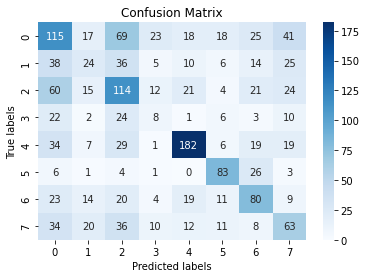

In [28]:
ax= plt.subplot()
cm = confusion_matrix(xgb_model.predict( X_test_text_vec2), y_test2)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [29]:
print(classification_report(xgb_model.predict( X_test_text_vec2), y_test2))

                       precision    recall  f1-score   support

 classic pop and rock       0.35      0.35      0.35       326
dance and electronica       0.24      0.15      0.19       158
                 folk       0.34      0.42      0.38       271
       jazz and blues       0.12      0.11      0.11        76
                metal       0.69      0.61      0.65       297
                  pop       0.57      0.67      0.62       124
                 punk       0.41      0.44      0.43       180
      soul and reggae       0.32      0.32      0.32       194

             accuracy                           0.41      1626
            macro avg       0.38      0.39      0.38      1626
         weighted avg       0.41      0.41      0.41      1626



In [30]:
print(cohen_kappa_score(xgb_model.predict(X_test_text_vec2), y_test2))

0.31024764616682354


In [31]:
pd.DataFrame(xgb_model.predict(X_valid_vecs),columns=['pred']).to_csv('test/valid_test_prediction.csv')